In [1]:
import pandas as pd
import itertools
import os
from tqdm import tqdm
from collections import defaultdict, Counter
import pickle
import random
from scipy.stats import entropy
import matplotlib.pyplot as plt

In [2]:
# Let grey is represented by 0, yellow by 1 and green by 2
# what could be possible input info of 5 letter word in wordle
allPatterns = list(itertools.product([0,1,2], repeat=5))
print(len(allPatterns))
# Total 3 power 5 that is 243 possible combination

243


In [3]:
#  Extracting all and curated word list from data folder

allWordList = list(pd.read_csv('./data/processed/valid_guesses.csv')['word'])
curatedWordList = list(pd.read_csv('./data/processed/valid_solutions.csv')['word'])
allWordList += curatedWordList
print("all valid guess words Len",len(allWordList))
print("curated word list Len:", len(curatedWordList))

all valid guess words Len 12972
curated word list Len: 2315


In [4]:
# First 2315 words of our list are most frequent wordle answers. so lets extract it too.
# curatedWordList = allWordList[:2315]
# print(len(curatedWordList))

In [5]:
# Sanity check whether all words are of 5 length or not
errorMsg = 'All words are not of 5 letter each'
assert len({len(x) for x in allWordList}) == 1 and len(allWordList[0]) == 5, errorMsg

In [6]:
def convertWordToPattern(guessWord, realAnswer):
    """
    lets suppose if ans is midst and we guessed digit then we return (1, 2, 0, 1, 2)
    """
    pattern = [0, 0, 0 ,0 ,0]
    for i, x in enumerate(guessWord):
        pattern[i] = int(x in realAnswer)
    for i, (x1, x2) in enumerate(zip(guessWord, realAnswer)):
        if x1 == x2:
            pattern[i] = 2
    
    return tuple(pattern)

# lets test it
print(convertWordToPattern('digit', 'midst'))
    

(1, 2, 0, 1, 2)


In [7]:
def createPatternMap(wordList):
    """
    For every word in the wordlist with every possible pattern information we get from wordle game, 
    lets create a list of possible set of words.
    """
    wordPatternMap = defaultdict(lambda: defaultdict(set))
    for word in tqdm(wordList):
        for realAnswer in wordList:
            pattern = convertWordToPattern(word, wordList)
            wordPatternMap[word][pattern].add(realAnswer)
    return dict(wordPatternMap)


In [8]:
if 'wordPatternMap.p' not in os.listdir('./data/processed'):
#     Lets cache this patterns map so that we dont need to create it everytime
    wordPatternMap = createPatternMap(curatedWordList)
    pickle.dump(wordPatternMap, open('./data/processed/wordPatternMap.p', 'wb+'))
else:
    # loading patterns map from the cache file
    wordPatternMap = pickle.load(open('./data/processed/wordPatternMap.p', 'rb'))

In [9]:
def calculateEntropies(possibleWords, wordPatternMap):
#     wordList,
    """
    Calculating the entropy for every word in our words list , taking into account the remaining possible words
    """
    entropiesMap = {}
    for word in tqdm(possibleWords):
        counts = []
        for pattern in allPatterns:
            matches = wordPatternMap[word][tuple(pattern)]
            matches = matches.intersection(possibleWords)
#             print("pattern"+str(pattern)+ "lenMatches"+ str(len(matches)))
            counts.append(len(matches))
#         print("========word['"+ str(word)+ "']==:count"+ str(counts))
            
        # Here in counts list, we have distribution of 243 pattern from a word and resultant match countpossible words.
        entropiesMap[word] = entropy(counts)
    return entropiesMap

In [10]:
# Given all the curated word list of 2315 words as possible words for first guess,
# lets sort them by entropy calcuation order
# after every guess and resultant pattern, we will check entropies for the remaining set of possible words,
# And then choose randomly one out of top 10 possible word based on maximum entropy order.
entropyMap = calculateEntropies(set(curatedWordList), wordPatternMap)
wordsEntropyInitially = sorted(entropyMap.items(), key= lambda x: -x[1])

100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4336.60it/s]


In [11]:
print(wordsEntropyInitially)
# In result you can see we can try raise as our first word as it gives maximum entropy gain.

[('raise', 4.074256529778889), ('slate', 4.05891419252938), ('crate', 4.044426464977779), ('irate', 4.042016375718312), ('trace', 4.041428402129088), ('arise', 4.034767941878586), ('stare', 4.025299783093858), ('snare', 3.99952082520612), ('arose', 3.997932022314528), ('least', 3.986736962882473), ('alert', 3.9827104052455393), ('crane', 3.980592974907975), ('stale', 3.9776754678899304), ('saner', 3.9743071854028647), ('alter', 3.9600681822245756), ('later', 3.9551594727731216), ('react', 3.948411680745814), ('leant', 3.9402460951840514), ('trade', 3.938157897930826), ('learn', 3.920492010954165), ('cater', 3.9140045113107718), ('roast', 3.9129499236252983), ('aisle', 3.9071511740666685), ('trice', 3.905355201077059), ('scare', 3.9027579177329668), ('parse', 3.9022044465621613), ('saute', 3.8956264104885876), ('heart', 3.89168798498796), ('alone', 3.8913531436794147), ('store', 3.888878505617476), ('alien', 3.888232530225648), ('share', 3.887383811994089), ('grate', 3.884454433965009),

In [12]:
# Lets begin a trial
# Lets play wordle with nytimes by giving guess word and its pattern output as result

# Assumption: If there is duplicate letter, pattern will show 1 for duplicate letter which
# is in wrong position and not 0

def playNyTimesWordleWithUserInput():
#     realAnswer = random.choice(curatedWordList)
#     print("====RealAnswer to reach is ", realAnswer)
    possibleWords = set(curatedWordList)

    for i in range(6):
    #     print("====possiblewordss", possibleWords)
        entropies = calculateEntropies( possibleWords, wordPatternMap)
        print("set of possible words includes like:")
        print([sample_word[0] for sample_word in sorted(entropies.items(), key=lambda sample_word: -sample_word[1])[:10]])

    #   Pick max entropy word
        guessWord = random.choice([x[0] for x in sorted(entropies.items(), key=lambda x: -x[1])[:10]])
#         print('Our suggestion for guess based on Entropy: ', guessWord)
        
        print("=====Now tell which Word you want to Put in Wordle as your guess:  eg: midst")
        guessWord = input()
        print('===Now Enter the pattern info return by wordle: eg: 01221 where 0=grey,1=yellow, 2=green color')
        guessWordPatternOutput = tuple(map(int, tuple(input())))

#         guessWordPatternOutput = [0, 0, 0, 0, 0]
#         for i, l1 in enumerate(guessWord):
#             guessWordPatternOutput[i] = int(l1 in realAnswer)

#         for i, (l1, l2) in enumerate(zip(guessWord, realAnswer)):
#             if l1 == l2:
#                 guessWordPatternOutput[i] = 2

        print('you guessed: \"', guessWord, '\"wordle pattern you provided:', guessWordPatternOutput)
        if guessWordPatternOutput == (2,2,2,2,2):
            print(f'WIN! in {i+1} guesses')
            print()
            print()
            print()
            break
    #     print("wordPatternMap", wordPatternMap[guessWord])
        words = wordPatternMap[guessWord][tuple(guessWordPatternOutput)]
    #     print("====words", words)
        possibleWords = possibleWords.intersection(words)

    

In [ ]:
playNyTimesWordleWithUserInput()

100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4488.11it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
=====Now tell which Word you want to Put in Wordle as your guess:  eg: midst
raise
===Now Enter the pattern info return by wordle: eg: 01221 where 0=grey,1=yellow, 2=green color
00102
you guessed: " raise "wordle pattern you provided: (0, 0, 1, 0, 2)


100%|█████████████████████████████████████████| 25/25 [00:00<00:00, 2012.24it/s]


set of possible words includes like:
['binge', 'mince', 'bilge', 'hinge', 'tilde', 'lithe', 'liege', 'niche', 'untie', 'midge']
Our suggestion for guess based on Entropy:  liege
=====Now tell which Word you want to Put in Wordle as your guess:  eg: midst


In [13]:
# Statistical Analysis for number of trails
countSum = 0
totalTrial = 0
guessCountToWin = list()
for noOfTrial in range(1000):
    sm = 0
    realAnswer = random.choice(curatedWordList)
    print("====RealAnswer to reach is ", realAnswer)
    possibleWords = set(curatedWordList)

    for _ in range(10):
        entropies = calculateEntropies( possibleWords, wordPatternMap)
        print("set of possible words includes like:")
        print([sample_word[0] for sample_word in sorted(entropies.items(), key=lambda sample_word: -sample_word[1])[:10]])

    #   Pick max entropy word
        guessWord = random.choice([x[0] for x in sorted(entropies.items(), key=lambda x: -x[1])[:10]])
        print('Our suggestion for guess based on Entropy: ', guessWord)
        
        sm += 1
        guessWordPatternOutput = [0, 0, 0, 0, 0]
        for i, l1 in enumerate(guessWord):
            guessWordPatternOutput[i] = int(l1 in realAnswer)

        for i, (l1, l2) in enumerate(zip(guessWord, realAnswer)):
            if l1 == l2:
                guessWordPatternOutput[i] = 2

        print('guessWordPatternOutput:', guessWordPatternOutput)
        if guessWord == realAnswer:
            guessCountToWin.append(sm)
            countSum += sm
            print('You Won! :',  len(guessCountToWin), ' times')
            print()
            print()
            print()
            break
    #     print("wordPatternMap", wordPatternMap[guessWord])
        words = wordPatternMap[guessWord][tuple(guessWordPatternOutput)]
    #     print("====words", words)
        possibleWords = possibleWords.intersection(words)


====RealAnswer to reach is  cleft


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4264.09it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 110/110 [00:00<00:00, 7716.69it/s]


set of possible words includes like:
['hotel', 'filet', 'betel', 'depot', 'dwelt', 'debit', 'towel', 'tepid', 'plied', 'dowel']
Our suggestion for guess based on Entropy:  depot
guessWordPatternOutput: [0, 1, 0, 0, 2]


100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 8118.48it/s]


set of possible words includes like:
['fleet', 'elect', 'filet', 'cleft', 'theft', 'evict', 'eject', 'eight', 'quiet', 'exult']
Our suggestion for guess based on Entropy:  elect
guessWordPatternOutput: [1, 2, 2, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5924.16it/s]


set of possible words includes like:
['cleft']
Our suggestion for guess based on Entropy:  cleft
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 1  times



====RealAnswer to reach is  bagel


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4775.73it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 1, 1, 0, 1]


100%|█████████████████████████████████████████| 31/31 [00:00<00:00, 8513.84it/s]


set of possible words includes like:
['pedal', 'regal', 'renal', 'penal', 'paler', 'panel', 'legal', 'angel', 'lapel', 'lager']
Our suggestion for guess based on Entropy:  panel
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 9043.35it/s]


set of possible words includes like:
['bagel', 'gavel', 'label', 'camel', 'hazel']
Our suggestion for guess based on Entropy:  bagel
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 2  times



====RealAnswer to reach is  tardy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4772.27it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [1, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 7881.07it/s]


set of possible words includes like:
['rapid', 'rabid', 'harry', 'carry', 'hairy', 'hardy', 'tardy', 'diary', 'dairy', 'cairn']
Our suggestion for guess based on Entropy:  tardy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 3  times



====RealAnswer to reach is  lumpy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4791.31it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 168/168 [00:00<00:00, 7486.01it/s]


set of possible words includes like:
['mulch', 'lunch', 'cloth', 'could', 'clung', 'clump', 'blunt', 'gulch', 'bunch', 'blond']
Our suggestion for guess based on Entropy:  cloth
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 8434.39it/s]


set of possible words includes like:
['bully', 'fully', 'gully', 'dully', 'bulky', 'lumpy', 'pulpy']
Our suggestion for guess based on Entropy:  gully
guessWordPatternOutput: [0, 2, 1, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5907.47it/s]


set of possible words includes like:
['lumpy']
Our suggestion for guess based on Entropy:  lumpy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 4  times



====RealAnswer to reach is  foist


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4739.86it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [1, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 17/17 [00:00<00:00, 8628.17it/s]


set of possible words includes like:
['moist', 'joist', 'ghost', 'foist', 'hoist', 'midst', 'joust', 'posit', 'tipsy', 'gusto']
Our suggestion for guess based on Entropy:  foist
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 5  times



====RealAnswer to reach is  paddy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4824.04it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 118/118 [00:00<00:00, 7956.40it/s]


set of possible words includes like:
['salon', 'canal', 'manly', 'modal', 'sandy', 'sadly', 'mason', 'candy', 'nasal', 'palsy']
Our suggestion for guess based on Entropy:  mason
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 8745.42it/s]


set of possible words includes like:
['badly', 'bawdy', 'caddy', 'caulk', 'paddy', 'gaudy', 'cabal', 'dally', 'gawky', 'gayly']
Our suggestion for guess based on Entropy:  caddy
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7695.97it/s]


set of possible words includes like:
['daddy', 'paddy']
Our suggestion for guess based on Entropy:  paddy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 6  times



====RealAnswer to reach is  wedge


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4824.92it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 65/65 [00:00<00:00, 8262.51it/s]


set of possible words includes like:
['nerdy', 'reign', 'genre', 'decry', 'nerve', 'merge', 'deign', 'heron', 'derby', 'demur']
Our suggestion for guess based on Entropy:  nerve
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8788.48it/s]


set of possible words includes like:
['wedge', 'hedge', 'deuce', 'femme']
Our suggestion for guess based on Entropy:  deuce
guessWordPatternOutput: [1, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6825.56it/s]


set of possible words includes like:
['wedge', 'hedge']
Our suggestion for guess based on Entropy:  wedge
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 7  times



====RealAnswer to reach is  sight


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4817.77it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 1, 1, 0]


100%|█████████████████████████████████████████| 21/21 [00:00<00:00, 8801.00it/s]


set of possible words includes like:
['stoic', 'posit', 'split', 'spoil', 'sonic', 'solid', 'sight', 'sixth', 'disco', 'music']
Our suggestion for guess based on Entropy:  sonic
guessWordPatternOutput: [2, 0, 0, 1, 0]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 9091.70it/s]


set of possible words includes like:
['sixth', 'silly', 'sight', 'sixty', 'silky', 'sushi']
Our suggestion for guess based on Entropy:  sixth
guessWordPatternOutput: [2, 2, 0, 1, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]


set of possible words includes like:
['sight']
Our suggestion for guess based on Entropy:  sight
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 8  times



====RealAnswer to reach is  fecal


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4768.61it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [1, 0, 0, 0, 1]


100%|█████████████████████████████████████████| 79/79 [00:00<00:00, 7765.77it/s]


set of possible words includes like:
['petal', 'metal', 'decal', 'cleat', 'leant', 'eclat', 'leapt', 'penal', 'dealt', 'medal']
Our suggestion for guess based on Entropy:  petal
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7605.27it/s]


set of possible words includes like:
['decal', 'medal', 'fecal', 'legal']
Our suggestion for guess based on Entropy:  legal
guessWordPatternOutput: [1, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8289.14it/s]


set of possible words includes like:
['medal', 'decal', 'fecal']
Our suggestion for guess based on Entropy:  decal
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6204.59it/s]


set of possible words includes like:
['fecal']
Our suggestion for guess based on Entropy:  fecal
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 9  times



====RealAnswer to reach is  octal


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4420.07it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [1, 0, 1, 0, 0]


100%|█████████████████████████████████████████| 44/44 [00:00<00:00, 8064.56it/s]


set of possible words includes like:
['tonal', 'talon', 'tonga', 'nomad', 'vocal', 'today', 'woman', 'local', 'modal', 'tango']
Our suggestion for guess based on Entropy:  talon
guessWordPatternOutput: [1, 1, 1, 1, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6842.26it/s]


set of possible words includes like:
['loath', 'octal']
Our suggestion for guess based on Entropy:  octal
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 10  times



====RealAnswer to reach is  quart


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4595.97it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [1, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 62/62 [00:00<00:00, 8050.24it/s]


set of possible words includes like:
['carol', 'coral', 'moral', 'royal', 'macro', 'mayor', 'harry', 'march', 'marry', 'hardy']
Our suggestion for guess based on Entropy:  hardy
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8912.67it/s]


set of possible words includes like:
['umbra', 'ultra', 'molar', 'cobra', 'flora', 'rumba', 'quart', 'lunar', 'quark', 'polar']
Our suggestion for guess based on Entropy:  flora
guessWordPatternOutput: [0, 0, 0, 2, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8439.24it/s]


set of possible words includes like:
['quart', 'quark']
Our suggestion for guess based on Entropy:  quark
guessWordPatternOutput: [2, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5706.54it/s]


set of possible words includes like:
['quart']
Our suggestion for guess based on Entropy:  quart
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 11  times



====RealAnswer to reach is  since


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4867.02it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [2, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 27/27 [00:00<00:00, 8236.09it/s]


set of possible words includes like:
['spine', 'snipe', 'spice', 'since', 'shine', 'slice', 'scone', 'singe', 'scope', 'snide']
Our suggestion for guess based on Entropy:  spice
guessWordPatternOutput: [2, 0, 1, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5817.34it/s]


set of possible words includes like:
['since']
Our suggestion for guess based on Entropy:  since
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 12  times



====RealAnswer to reach is  heist


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4839.49it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6026.30it/s]


set of possible words includes like:
['heist']
Our suggestion for guess based on Entropy:  heist
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 13  times



====RealAnswer to reach is  revue


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4842.03it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [2, 0, 0, 0, 2]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 8186.67it/s]


set of possible words includes like:
['rogue', 'rouge', 'route', 'revue', 'rupee', 'rhyme']
Our suggestion for guess based on Entropy:  rupee
guessWordPatternOutput: [2, 1, 0, 1, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8905.10it/s]


set of possible words includes like:
['rogue', 'rouge', 'route', 'revue']
Our suggestion for guess based on Entropy:  route
guessWordPatternOutput: [2, 0, 1, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6797.90it/s]


set of possible words includes like:
['revue']
Our suggestion for guess based on Entropy:  revue
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 14  times



====RealAnswer to reach is  beset


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4853.15it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 0, 1, 1]


100%|█████████████████████████████████████████| 54/54 [00:00<00:00, 8231.90it/s]


set of possible words includes like:
['sleet', 'onset', 'spelt', 'slept', 'smelt', 'unset', 'scent', 'spent', 'upset', 'sheet']
Our suggestion for guess based on Entropy:  spent
guessWordPatternOutput: [1, 0, 1, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6700.17it/s]


set of possible words includes like:
['beset']
Our suggestion for guess based on Entropy:  beset
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 15  times



====RealAnswer to reach is  canny


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4852.92it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████| 154/154 [00:00<00:00, 7749.15it/s]


set of possible words includes like:
['tonal', 'talon', 'canal', 'manly', 'tangy', 'candy', 'tango', 'latch', 'lanky', 'natal']
Our suggestion for guess based on Entropy:  tangy
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 9020.01it/s]


set of possible words includes like:
['canny', 'candy', 'fanny', 'fancy', 'nanny', 'handy', 'dandy', 'manly', 'lanky']
Our suggestion for guess based on Entropy:  lanky
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 8331.48it/s]


set of possible words includes like:
['canny', 'candy', 'fanny', 'fancy', 'nanny', 'handy', 'dandy']
Our suggestion for guess based on Entropy:  canny
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 16  times



====RealAnswer to reach is  skiff


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4868.80it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 79/79 [00:00<00:00, 8480.06it/s]


set of possible words includes like:
['stink', 'spilt', 'slink', 'stunk', 'slunk', 'shunt', 'split', 'stick', 'silky', 'stilt']
Our suggestion for guess based on Entropy:  split
guessWordPatternOutput: [2, 0, 0, 1, 0]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 8836.31it/s]


set of possible words includes like:
['swing', 'suing', 'shiny', 'sushi', 'skiff', 'sniff']
Our suggestion for guess based on Entropy:  skiff
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 17  times



====RealAnswer to reach is  shift


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4850.20it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████| 113/113 [00:00<00:00, 7998.86it/s]


set of possible words includes like:
['hoist', 'snout', 'south', 'shout', 'point', 'moist', 'shunt', 'foist', 'mount', 'moult']
Our suggestion for guess based on Entropy:  moult
guessWordPatternOutput: [0, 0, 0, 0, 2]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 9089.51it/s]


set of possible words includes like:
['shift', 'swift', 'wight', 'fight', 'night', 'sight', 'stint', 'visit', 'digit']
Our suggestion for guess based on Entropy:  swift
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]


set of possible words includes like:
['shift']
Our suggestion for guess based on Entropy:  shift
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 18  times



====RealAnswer to reach is  bulky


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4850.97it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 246/246 [00:00<00:00, 7354.49it/s]


set of possible words includes like:
['solid', 'slimy', 'lousy', 'noisy', 'spoil', 'sound', 'sling', 'spiny', 'guild', 'slung']
Our suggestion for guess based on Entropy:  sound
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|█████████████████████████████████████████| 17/17 [00:00<00:00, 8984.77it/s]


set of possible words includes like:
['lumpy', 'gully', 'pulpy', 'pupil', 'guppy', 'fully', 'bully', 'jumpy', 'puffy', 'gummy']
Our suggestion for guess based on Entropy:  jumpy
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 9303.45it/s]


set of possible words includes like:
['bulky', 'bully', 'fully', 'gully', 'buggy', 'fuzzy']
Our suggestion for guess based on Entropy:  bully
guessWordPatternOutput: [2, 2, 2, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]


set of possible words includes like:
['bulky']
Our suggestion for guess based on Entropy:  bulky
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 19  times



====RealAnswer to reach is  allot


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4852.72it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [1, 0, 1, 0, 0]


100%|█████████████████████████████████████████| 53/53 [00:00<00:00, 8213.19it/s]


set of possible words includes like:
['fault', 'satin', 'saint', 'faint', 'paint', 'aloft', 'salty', 'adult', 'waist', 'vault']
Our suggestion for guess based on Entropy:  vault
guessWordPatternOutput: [0, 1, 0, 1, 2]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 8971.77it/s]


set of possible words includes like:
['gloat', 'float', 'bloat', 'aloft', 'splat', 'allot']
Our suggestion for guess based on Entropy:  splat
guessWordPatternOutput: [0, 0, 2, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6944.21it/s]


set of possible words includes like:
['allot']
Our suggestion for guess based on Entropy:  allot
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 20  times



====RealAnswer to reach is  stick


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4860.31it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [2, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 8478.17it/s]


set of possible words includes like:
['stunk', 'snout', 'snort', 'skirt', 'spout', 'spurt', 'stink', 'shunt', 'shirt', 'short']
Our suggestion for guess based on Entropy:  stink
guessWordPatternOutput: [2, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6887.20it/s]


set of possible words includes like:
['stick']
Our suggestion for guess based on Entropy:  stick
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 21  times



====RealAnswer to reach is  audit


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4837.22it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [2, 0, 1, 0, 0]


100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 8431.41it/s]


set of possible words includes like:
['admit', 'audit', 'avoid', 'admin', 'antic', 'await', 'anvil', 'again', 'audio', 'avail']
Our suggestion for guess based on Entropy:  avoid
guessWordPatternOutput: [2, 0, 0, 2, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8823.92it/s]


set of possible words includes like:
['audit', 'admin', 'admit']
Our suggestion for guess based on Entropy:  admit
guessWordPatternOutput: [2, 1, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7084.97it/s]


set of possible words includes like:
['audit']
Our suggestion for guess based on Entropy:  audit
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 22  times



====RealAnswer to reach is  rival


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4853.05it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [1, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 8128.78it/s]


set of possible words includes like:
['rapid', 'rabid', 'harry', 'carry', 'hairy', 'hardy', 'tardy', 'diary', 'dairy', 'cairn']
Our suggestion for guess based on Entropy:  cairn
guessWordPatternOutput: [0, 1, 1, 1, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8399.81it/s]


set of possible words includes like:
['rival', 'viral', 'flair']
Our suggestion for guess based on Entropy:  viral
guessWordPatternOutput: [1, 2, 1, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5203.85it/s]


set of possible words includes like:
['rival']
Our suggestion for guess based on Entropy:  rival
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 23  times



====RealAnswer to reach is  ovine


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4843.99it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 0, 1, 0, 2]


100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 8121.75it/s]


set of possible words includes like:
['vogue', 'olive', 'boule', 'lodge', 'ovine', 'ounce', 'opine', 'coupe', 'voice', 'gouge']
Our suggestion for guess based on Entropy:  lodge
guessWordPatternOutput: [0, 1, 0, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8542.37it/s]


set of possible words includes like:
['ovine', 'opine', 'ounce']
Our suggestion for guess based on Entropy:  opine
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6955.73it/s]


set of possible words includes like:
['ovine']
Our suggestion for guess based on Entropy:  ovine
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 24  times



====RealAnswer to reach is  stuck


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4849.15it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 0, 1, 1]


100%|█████████████████████████████████████████| 32/32 [00:00<00:00, 8581.70it/s]


set of possible words includes like:
['storm', 'stork', 'story', 'stoic', 'stomp', 'stink', 'stony', 'stock', 'rusty', 'musty']
Our suggestion for guess based on Entropy:  story
guessWordPatternOutput: [2, 2, 0, 0, 0]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 9288.57it/s]


set of possible words includes like:
['stink', 'stunk', 'stung', 'sting', 'stick', 'stuck', 'stuff', 'stiff', 'stump']
Our suggestion for guess based on Entropy:  stuck
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 25  times



====RealAnswer to reach is  liege


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4848.78it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 1, 0, 2]


100%|█████████████████████████████████████████| 25/25 [00:00<00:00, 8662.34it/s]


set of possible words includes like:
['binge', 'mince', 'bilge', 'hinge', 'lithe', 'tilde', 'liege', 'niche', 'untie', 'midge']
Our suggestion for guess based on Entropy:  niche
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9200.05it/s]


set of possible words includes like:
['bilge', 'tilde', 'bible', 'midge', 'liege', 'title', 'biome', 'diode', 'pique', 'pixie']
Our suggestion for guess based on Entropy:  pique
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 8749.53it/s]


set of possible words includes like:
['bilge', 'tilde', 'bible', 'midge', 'liege', 'biome', 'title', 'diode']
Our suggestion for guess based on Entropy:  midge
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8297.34it/s]


set of possible words includes like:
['liege', 'bilge']
Our suggestion for guess based on Entropy:  bilge
guessWordPatternOutput: [0, 2, 1, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7049.25it/s]


set of possible words includes like:
['liege']
Our suggestion for guess based on Entropy:  liege
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 26  times



====RealAnswer to reach is  segue


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4839.46it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 0, 0, 2]


100%|███████████████████████████████████████| 104/104 [00:00<00:00, 7985.79it/s]


set of possible words includes like:
['noise', 'singe', 'slide', 'guile', 'louse', 'guise', 'snide', 'slime', 'slope', 'smile']
Our suggestion for guess based on Entropy:  louse
guessWordPatternOutput: [0, 0, 1, 1, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8496.23it/s]


set of possible words includes like:
['ensue', 'issue', 'segue']
Our suggestion for guess based on Entropy:  ensue
guessWordPatternOutput: [1, 0, 1, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6990.51it/s]


set of possible words includes like:
['segue']
Our suggestion for guess based on Entropy:  segue
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 27  times



====RealAnswer to reach is  icing


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4793.12it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 221/221 [00:00<00:00, 7306.92it/s]


set of possible words includes like:
['crony', 'round', 'groin', 'corny', 'irony', 'pound', 'doing', 'rhino', 'mound', 'hound']
Our suggestion for guess based on Entropy:  irony
guessWordPatternOutput: [2, 0, 0, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6069.90it/s]


set of possible words includes like:
['icing']
Our suggestion for guess based on Entropy:  icing
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 28  times



====RealAnswer to reach is  funky


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4794.17it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 194/194 [00:00<00:00, 7350.39it/s]


set of possible words includes like:
['plush', 'blush', 'slunk', 'slump', 'slung', 'flush', 'plunk', 'scold', 'phony', 'clump']
Our suggestion for guess based on Entropy:  clump
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 8182.87it/s]


set of possible words includes like:
['husky', 'hunky', 'bushy', 'funky', 'dusky', 'bonus', 'hussy', 'fussy', 'funny', 'bunny']
Our suggestion for guess based on Entropy:  funny
guessWordPatternOutput: [2, 2, 2, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6132.02it/s]


set of possible words includes like:
['funky']
Our suggestion for guess based on Entropy:  funky
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 29  times



====RealAnswer to reach is  major


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4599.93it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 1, 1, 0]


100%|█████████████████████████████████████████| 65/65 [00:00<00:00, 8010.98it/s]


set of possible words includes like:
['carol', 'moral', 'coral', 'labor', 'molar', 'royal', 'mayor', 'tarot', 'valor', 'polar']
Our suggestion for guess based on Entropy:  polar
guessWordPatternOutput: [0, 1, 0, 1, 2]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 8813.62it/s]


set of possible words includes like:
['armor', 'arbor', 'major', 'mayor', 'ardor', 'abhor', 'actor', 'favor', 'razor']
Our suggestion for guess based on Entropy:  actor
guessWordPatternOutput: [1, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8793.09it/s]


set of possible words includes like:
['major', 'mayor', 'razor', 'favor']
Our suggestion for guess based on Entropy:  major
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 30  times



====RealAnswer to reach is  chart


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4719.64it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 2, 2, 0]


100%|█████████████████████████████████████████| 16/16 [00:00<00:00, 8552.17it/s]


set of possible words includes like:
['hoard', 'chard', 'award', 'chart', 'board', 'diary', 'guard', 'dwarf', 'wharf', 'quart']
Our suggestion for guess based on Entropy:  award
guessWordPatternOutput: [1, 0, 2, 2, 0]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 9078.58it/s]


set of possible words includes like:
['chart', 'quart', 'tiara', 'quark', 'charm', 'ovary']
Our suggestion for guess based on Entropy:  quark
guessWordPatternOutput: [0, 0, 2, 2, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8192.00it/s]


set of possible words includes like:
['chart', 'tiara', 'charm', 'ovary']
Our suggestion for guess based on Entropy:  tiara
guessWordPatternOutput: [1, 0, 2, 2, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7256.58it/s]


set of possible words includes like:
['chart']
Our suggestion for guess based on Entropy:  chart
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 31  times



====RealAnswer to reach is  donut


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4779.04it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 90/90 [00:00<00:00, 8189.33it/s]


set of possible words includes like:
['hoist', 'snout', 'foist', 'shunt', 'moist', 'point', 'shout', 'spilt', 'posit', 'mount']
Our suggestion for guess based on Entropy:  mount
guessWordPatternOutput: [0, 2, 1, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6462.72it/s]


set of possible words includes like:
['donut']
Our suggestion for guess based on Entropy:  donut
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 32  times



====RealAnswer to reach is  revue


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4794.00it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 1, 0, 0, 2]


100%|█████████████████████████████████████████| 38/38 [00:00<00:00, 8418.29it/s]


set of possible words includes like:
['surge', 'curse', 'nurse', 'rouse', 'horse', 'purse', 'worse', 'reuse', 'serve', 'verse']
Our suggestion for guess based on Entropy:  purse
guessWordPatternOutput: [0, 1, 1, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8473.34it/s]


set of possible words includes like:
['rogue', 'rouge', 'revue']
Our suggestion for guess based on Entropy:  rogue
guessWordPatternOutput: [2, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]


set of possible words includes like:
['revue']
Our suggestion for guess based on Entropy:  revue
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 33  times



====RealAnswer to reach is  usage


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4806.97it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 2, 0, 2]


100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 7980.79it/s]


set of possible words includes like:
['shale', 'slave', 'scale', 'shape', 'phase', 'shave', 'shake', 'shade', 'spade', 'chase']
Our suggestion for guess based on Entropy:  phase
guessWordPatternOutput: [0, 0, 2, 1, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7541.00it/s]


set of possible words includes like:
['slave', 'suave', 'scale', 'snake', 'usage']
Our suggestion for guess based on Entropy:  scale
guessWordPatternOutput: [1, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5555.37it/s]


set of possible words includes like:
['usage']
Our suggestion for guess based on Entropy:  usage
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 34  times



====RealAnswer to reach is  gamer


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4804.53it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 1, 0, 1]


100%|█████████████████████████████████████████| 61/61 [00:00<00:00, 8025.49it/s]


set of possible words includes like:
['amber', 'cream', 'ramen', 'cedar', 'debar', 'anger', 'recap', 'dream', 'bread', 'caper']
Our suggestion for guess based on Entropy:  anger
guessWordPatternOutput: [1, 0, 1, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7302.91it/s]


set of possible words includes like:
['gamer', 'gazer', 'gayer']
Our suggestion for guess based on Entropy:  gamer
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 35  times



====RealAnswer to reach is  gamma


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4830.43it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 91/91 [00:00<00:00, 8312.97it/s]


set of possible words includes like:
['tangy', 'candy', 'tawny', 'talon', 'manly', 'tango', 'mangy', 'fancy', 'baton', 'canny']
Our suggestion for guess based on Entropy:  canny
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 15/15 [00:00<00:00, 8802.93it/s]


set of possible words includes like:
['gamut', 'datum', 'fault', 'fatal', 'gamma', 'vault', 'magma', 'mamma', 'laugh', 'mambo']
Our suggestion for guess based on Entropy:  fault
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 9404.27it/s]


set of possible words includes like:
['gamma', 'mamma', 'mambo', 'magma', 'madam', 'kappa']
Our suggestion for guess based on Entropy:  gamma
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 36  times



====RealAnswer to reach is  gripe


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4844.55it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 0, 1, 2]


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8104.78it/s]


set of possible words includes like:
['pride', 'grope', 'gripe', 'prove', 'prone', 'prude', 'price', 'dirge', 'probe', 'drone']
Our suggestion for guess based on Entropy:  prove
guessWordPatternOutput: [1, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7632.95it/s]


set of possible words includes like:
['gripe', 'crepe']
Our suggestion for guess based on Entropy:  gripe
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 37  times



====RealAnswer to reach is  shire


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4797.53it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 1, 0, 1, 2]


100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 121.38it/s]


set of possible words includes like:
['spree', 'scree', 'spire', 'surge', 'serve', 'shire']
Our suggestion for guess based on Entropy:  spree
guessWordPatternOutput: [2, 0, 1, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5077.85it/s]


set of possible words includes like:
['shire']
Our suggestion for guess based on Entropy:  shire
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 38  times



====RealAnswer to reach is  short


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4813.54it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [1, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 24/24 [00:00<00:00, 8556.17it/s]


set of possible words includes like:
['short', 'story', 'sport', 'snort', 'storm', 'shorn', 'strut', 'stork', 'scorn', 'spurt']
Our suggestion for guess based on Entropy:  spurt
guessWordPatternOutput: [2, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7717.21it/s]


set of possible words includes like:
['snort', 'short']
Our suggestion for guess based on Entropy:  short
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 39  times



====RealAnswer to reach is  crush


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4804.70it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [2, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 8490.49it/s]


set of possible words includes like:
['croup', 'crisp', 'crump', 'crimp', 'crock', 'crook', 'crown', 'crush', 'crumb', 'cross']
Our suggestion for guess based on Entropy:  crown
guessWordPatternOutput: [2, 2, 0, 0, 0]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 9039.45it/s]


set of possible words includes like:
['crisp', 'crimp', 'crump', 'crumb', 'crush', 'crick']
Our suggestion for guess based on Entropy:  crush
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 40  times



====RealAnswer to reach is  lynch


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4802.30it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 168/168 [00:00<00:00, 7661.50it/s]


set of possible words includes like:
['mulch', 'lunch', 'cloth', 'could', 'clung', 'clump', 'blunt', 'gulch', 'bunch', 'blond']
Our suggestion for guess based on Entropy:  clump
guessWordPatternOutput: [1, 1, 0, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5991.86it/s]


set of possible words includes like:
['lynch']
Our suggestion for guess based on Entropy:  lynch
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 41  times



====RealAnswer to reach is  verge


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4791.82it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 1, 0, 0, 2]


100%|█████████████████████████████████████████| 38/38 [00:00<00:00, 8224.97it/s]


set of possible words includes like:
['surge', 'curse', 'nurse', 'rouse', 'horse', 'purse', 'worse', 'reuse', 'serve', 'verse']
Our suggestion for guess based on Entropy:  horse
guessWordPatternOutput: [0, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 8620.12it/s]


set of possible words includes like:
['verge', 'nerve', 'verve', 'merge', 'curve', 'purge', 'puree']
Our suggestion for guess based on Entropy:  nerve
guessWordPatternOutput: [0, 2, 2, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7084.97it/s]


set of possible words includes like:
['verge']
Our suggestion for guess based on Entropy:  verge
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 42  times



====RealAnswer to reach is  leach


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4807.62it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 2, 0, 1]


100%|█████████████████████████████████████████| 18/18 [00:00<00:00, 8000.16it/s]


set of possible words includes like:
['death', 'dealt', 'heath', 'leach', 'mealy', 'heady', 'leapt', 'teach', 'leafy', 'leaky']
Our suggestion for guess based on Entropy:  leach
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 43  times



====RealAnswer to reach is  spade


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4800.45it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [2, 0, 2, 0, 2]


100%|█████████████████████████████████████████| 12/12 [00:00<00:00, 7941.25it/s]


set of possible words includes like:
['shale', 'shape', 'shave', 'shake', 'shade', 'slave', 'spade', 'space', 'scale', 'shame']
Our suggestion for guess based on Entropy:  spade
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 44  times



====RealAnswer to reach is  onion


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4701.84it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 2, 0, 0]


100%|█████████████████████████████████████████| 51/51 [00:00<00:00, 8460.61it/s]


set of possible words includes like:
['glint', 'cling', 'flint', 'guilt', 'clink', 'fling', 'guild', 'tying', 'built', 'think']
Our suggestion for guess based on Entropy:  clink
guessWordPatternOutput: [0, 0, 2, 1, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8490.49it/s]


set of possible words includes like:
['unity', 'unify', 'union', 'onion']
Our suggestion for guess based on Entropy:  union
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7423.55it/s]


set of possible words includes like:
['onion']
Our suggestion for guess based on Entropy:  onion
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 45  times



====RealAnswer to reach is  pulpy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4801.07it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 168/168 [00:00<00:00, 7663.91it/s]


set of possible words includes like:
['mulch', 'lunch', 'cloth', 'could', 'clung', 'clump', 'blunt', 'gulch', 'bunch', 'blond']
Our suggestion for guess based on Entropy:  could
guessWordPatternOutput: [0, 0, 1, 1, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 5545.58it/s]


set of possible words includes like:
['pulpy', 'bulky', 'lumpy']
Our suggestion for guess based on Entropy:  lumpy
guessWordPatternOutput: [1, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1461.94it/s]


set of possible words includes like:
['pulpy']
Our suggestion for guess based on Entropy:  pulpy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 46  times



====RealAnswer to reach is  snaky


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4785.38it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [1, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 61/61 [00:00<00:00, 8125.66it/s]


set of possible words includes like:
['slant', 'scant', 'shalt', 'stalk', 'scalp', 'scaly', 'scald', 'stank', 'splat', 'stand']
Our suggestion for guess based on Entropy:  slant
guessWordPatternOutput: [2, 0, 2, 1, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 6754.11it/s]


set of possible words includes like:
['snack', 'snaky', 'spawn']
Our suggestion for guess based on Entropy:  spawn
guessWordPatternOutput: [2, 0, 2, 0, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7410.43it/s]


set of possible words includes like:
['snack', 'snaky']
Our suggestion for guess based on Entropy:  snaky
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 47  times



====RealAnswer to reach is  titan


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4787.88it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [1, 0, 1, 0, 0]


100%|█████████████████████████████████████████| 35/35 [00:00<00:00, 8684.89it/s]


set of possible words includes like:
['panic', 'plain', 'plait', 'cavil', 'chain', 'claim', 'mania', 'final', 'tidal', 'vital']
Our suggestion for guess based on Entropy:  chain
guessWordPatternOutput: [0, 0, 1, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]


set of possible words includes like:
['titan']
Our suggestion for guess based on Entropy:  titan
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 48  times



====RealAnswer to reach is  jumpy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4771.40it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 219/219 [00:00<00:00, 7372.01it/s]


set of possible words includes like:
['could', 'moult', 'clout', 'cloud', 'tulip', 'built', 'pilot', 'cloth', 'guilt', 'touch']
Our suggestion for guess based on Entropy:  guilt
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 7042.49it/s]


set of possible words includes like:
['dumpy', 'dummy', 'jumpy', 'muddy', 'humph', 'mummy', 'duchy', 'jumbo', 'puffy', 'mucky']
Our suggestion for guess based on Entropy:  puffy
guessWordPatternOutput: [1, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 2971.52it/s]


set of possible words includes like:
['jumpy', 'dumpy']
Our suggestion for guess based on Entropy:  dumpy
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]


set of possible words includes like:
['jumpy']
Our suggestion for guess based on Entropy:  jumpy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 49  times



====RealAnswer to reach is  grade


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4774.76it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8780.21it/s]


set of possible words includes like:
['grade', 'drape', 'drake', 'grave', 'grape', 'brake', 'brave', 'graze', 'erase', 'frame']
Our suggestion for guess based on Entropy:  brake
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 8362.33it/s]


set of possible words includes like:
['grade', 'grape', 'drape', 'grave', 'graze', 'erase', 'frame']
Our suggestion for guess based on Entropy:  grape
guessWordPatternOutput: [2, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7973.96it/s]


set of possible words includes like:
['grade', 'graze', 'grave']
Our suggestion for guess based on Entropy:  grave
guessWordPatternOutput: [2, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 2766.69it/s]


set of possible words includes like:
['grade', 'graze']
Our suggestion for guess based on Entropy:  graze
guessWordPatternOutput: [2, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6413.31it/s]


set of possible words includes like:
['grade']
Our suggestion for guess based on Entropy:  grade
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 50  times



====RealAnswer to reach is  sharp


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4740.48it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 1, 2, 0, 0]


100%|█████████████████████████████████████████| 17/17 [00:00<00:00, 6824.58it/s]


set of possible words includes like:
['shard', 'hoard', 'award', 'shark', 'dwarf', 'sharp', 'swarm', 'wharf', 'board', 'spark']
Our suggestion for guess based on Entropy:  wharf
guessWordPatternOutput: [0, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 3043.03it/s]


set of possible words includes like:
['shard', 'sharp', 'shark']
Our suggestion for guess based on Entropy:  shard
guessWordPatternOutput: [2, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6350.20it/s]


set of possible words includes like:
['sharp', 'shark']
Our suggestion for guess based on Entropy:  shark
guessWordPatternOutput: [2, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1130.24it/s]


set of possible words includes like:
['sharp']
Our suggestion for guess based on Entropy:  sharp
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 51  times



====RealAnswer to reach is  relic


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4729.25it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 0, 1, 1]


100%|███████████████████████████████████████| 118/118 [00:00<00:00, 7672.82it/s]


set of possible words includes like:
['diner', 'cider', 'rider', 'idler', 'decor', 'older', 'liner', 'filer', 'diver', 'flier']
Our suggestion for guess based on Entropy:  rider
guessWordPatternOutput: [2, 1, 0, 1, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 1872.46it/s]


set of possible words includes like:
['relic', 'reign']
Our suggestion for guess based on Entropy:  relic
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 52  times



====RealAnswer to reach is  agora


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4577.32it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [2, 1, 2, 0, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 6932.73it/s]


set of possible words includes like:
['acorn', 'adorn', 'agora', 'abort']
Our suggestion for guess based on Entropy:  agora
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 53  times



====RealAnswer to reach is  sooty


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4653.45it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 0, 2, 0]


100%|█████████████████████████████████████████| 24/24 [00:00<00:00, 6586.19it/s]


set of possible words includes like:
['lusty', 'sloth', 'south', 'musty', 'sooty', 'sooth', 'mouth', 'dusty', 'gusty', 'nutty']
Our suggestion for guess based on Entropy:  sooth
guessWordPatternOutput: [2, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1016.06it/s]


set of possible words includes like:
['sooty']
Our suggestion for guess based on Entropy:  sooty
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 54  times



====RealAnswer to reach is  evade


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4725.35it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [1, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 50/50 [00:00<00:00, 6177.36it/s]


set of possible words includes like:
['halve', 'cable', 'glade', 'lance', 'blame', 'table', 'lathe', 'maple', 'blade', 'fable']
Our suggestion for guess based on Entropy:  lathe
guessWordPatternOutput: [0, 1, 0, 0, 2]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 8121.75it/s]


set of possible words includes like:
['knave', 'weave', 'inane', 'evade', 'quake', 'peace', 'image']
Our suggestion for guess based on Entropy:  evade
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 55  times



====RealAnswer to reach is  preen


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4668.10it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 0, 1, 1]


100%|███████████████████████████████████████| 118/118 [00:00<00:00, 6935.45it/s]


set of possible words includes like:
['diner', 'cider', 'rider', 'idler', 'decor', 'older', 'liner', 'filer', 'diver', 'flier']
Our suggestion for guess based on Entropy:  idler
guessWordPatternOutput: [0, 0, 0, 2, 1]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8065.97it/s]


set of possible words includes like:
['creep', 'preen', 'creek', 'green', 'renew']
Our suggestion for guess based on Entropy:  creek
guessWordPatternOutput: [0, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8065.97it/s]


set of possible words includes like:
['green', 'preen']
Our suggestion for guess based on Entropy:  preen
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 56  times



====RealAnswer to reach is  opine


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4765.22it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 1, 0, 0, 2]


100%|█████████████████████████████████████████| 24/24 [00:00<00:00, 8617.70it/s]


set of possible words includes like:
['hinge', 'ounce', 'wince', 'niche', 'pence', 'hence', 'mince', 'binge', 'opine', 'ovine']
Our suggestion for guess based on Entropy:  ounce
guessWordPatternOutput: [2, 0, 1, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8267.35it/s]


set of possible words includes like:
['ovine', 'opine', 'ozone']
Our suggestion for guess based on Entropy:  ovine
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7049.25it/s]


set of possible words includes like:
['opine']
Our suggestion for guess based on Entropy:  opine
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 57  times



====RealAnswer to reach is  surge


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4744.00it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [2, 0, 0, 1, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 6803.41it/s]


set of possible words includes like:
['scree', 'spree', 'serve', 'surge']
Our suggestion for guess based on Entropy:  surge
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 58  times



====RealAnswer to reach is  ulcer


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4764.92it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|███████████████████████████████████████| 103/103 [00:00<00:00, 7992.55it/s]


set of possible words includes like:
['rivet', 'diner', 'refit', 'liner', 'idler', 'ripen', 'rider', 'inter', 'filer', 'flier']
Our suggestion for guess based on Entropy:  filer
guessWordPatternOutput: [0, 0, 1, 2, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 6964.97it/s]


set of possible words includes like:
['ulcer', 'bluer', 'elder', 'leper', 'lever']
Our suggestion for guess based on Entropy:  ulcer
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 59  times



====RealAnswer to reach is  touch


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4773.91it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [2, 0, 0, 2, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6512.89it/s]


set of possible words includes like:
['touch', 'thick']
Our suggestion for guess based on Entropy:  touch
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 60  times



====RealAnswer to reach is  plait


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4761.37it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [1, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 5570.12it/s]


set of possible words includes like:
['plait', 'plant']
Our suggestion for guess based on Entropy:  plant
guessWordPatternOutput: [2, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7345.54it/s]


set of possible words includes like:
['plait']
Our suggestion for guess based on Entropy:  plait
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 61  times



====RealAnswer to reach is  befit


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4810.68it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 120/120 [00:00<00:00, 7786.70it/s]


set of possible words includes like:
['inlet', 'filet', 'field', 'deity', 'plied', 'yield', 'elfin', 'tepid', 'fiend', 'debit']
Our suggestion for guess based on Entropy:  yield
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 8255.34it/s]


set of possible words includes like:
['neigh', 'ethic', 'feign', 'befit', 'weigh', 'thief', 'chief', 'eking', 'evict', 'begin']
Our suggestion for guess based on Entropy:  neigh
guessWordPatternOutput: [0, 2, 1, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6403.52it/s]


set of possible words includes like:
['befit']
Our suggestion for guess based on Entropy:  befit
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 62  times



====RealAnswer to reach is  photo


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4768.67it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████| 113/113 [00:00<00:00, 7927.68it/s]


set of possible words includes like:
['hoist', 'snout', 'south', 'shout', 'point', 'moist', 'shunt', 'foist', 'mount', 'moult']
Our suggestion for guess based on Entropy:  hoist
guessWordPatternOutput: [1, 1, 0, 0, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7847.15it/s]


set of possible words includes like:
['quoth', 'photo']
Our suggestion for guess based on Entropy:  quoth
guessWordPatternOutput: [0, 0, 2, 2, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7423.55it/s]


set of possible words includes like:
['photo']
Our suggestion for guess based on Entropy:  photo
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 63  times



====RealAnswer to reach is  bluff


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4791.47it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 168/168 [00:00<00:00, 7657.58it/s]


set of possible words includes like:
['mulch', 'lunch', 'cloth', 'could', 'clung', 'clump', 'blunt', 'gulch', 'bunch', 'blond']
Our suggestion for guess based on Entropy:  clump
guessWordPatternOutput: [0, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8361.85it/s]


set of possible words includes like:
['flunk', 'flung', 'bluff', 'blunt', 'fluff']
Our suggestion for guess based on Entropy:  fluff
guessWordPatternOutput: [1, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5159.05it/s]


set of possible words includes like:
['bluff']
Our suggestion for guess based on Entropy:  bluff
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 64  times



====RealAnswer to reach is  rouge


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4766.66it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 1, 0, 0, 2]


100%|█████████████████████████████████████████| 25/25 [00:00<00:00, 8550.03it/s]


set of possible words includes like:
['rouge', 'rogue', 'forge', 'route', 'gorge', 'verge', 'merge', 'curve', 'purge', 'forte']
Our suggestion for guess based on Entropy:  route
guessWordPatternOutput: [2, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6887.20it/s]


set of possible words includes like:
['rouge']
Our suggestion for guess based on Entropy:  rouge
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 65  times



====RealAnswer to reach is  itchy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4786.45it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 219/219 [00:00<00:00, 7207.95it/s]


set of possible words includes like:
['could', 'moult', 'clout', 'cloud', 'tulip', 'built', 'pilot', 'cloth', 'guilt', 'touch']
Our suggestion for guess based on Entropy:  tulip
guessWordPatternOutput: [1, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 17/17 [00:00<00:00, 8411.37it/s]


set of possible words includes like:
['width', 'witty', 'ditto', 'witch', 'ditty', 'ditch', 'bitty', 'fifth', 'kitty', 'wight']
Our suggestion for guess based on Entropy:  kitty
guessWordPatternOutput: [0, 1, 1, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6452.78it/s]


set of possible words includes like:
['itchy']
Our suggestion for guess based on Entropy:  itchy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 66  times



====RealAnswer to reach is  abled


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4759.37it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [1, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 38/38 [00:00<00:00, 8309.45it/s]


set of possible words includes like:
['angle', 'angel', 'bagel', 'algae', 'eagle', 'alien', 'gavel', 'alive', 'agile', 'cable']
Our suggestion for guess based on Entropy:  agile
guessWordPatternOutput: [2, 0, 0, 1, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8232.20it/s]


set of possible words includes like:
['abled', 'alley']
Our suggestion for guess based on Entropy:  abled
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 67  times



====RealAnswer to reach is  filer


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4777.82it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 1, 1, 0, 1]


100%|█████████████████████████████████████████| 34/34 [00:00<00:00, 8380.72it/s]


set of possible words includes like:
['rivet', 'finer', 'diner', 'liner', 'ripen', 'miner', 'infer', 'liver', 'diver', 'filer']
Our suggestion for guess based on Entropy:  rivet
guessWordPatternOutput: [1, 2, 0, 2, 0]


100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 8850.44it/s]


set of possible words includes like:
['finer', 'diner', 'liner', 'nicer', 'cider', 'filer', 'miner', 'wider', 'fiber', 'fixer']
Our suggestion for guess based on Entropy:  miner
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 8461.94it/s]


set of possible words includes like:
['fixer', 'fiber', 'filer', 'wider', 'cider', 'piper']
Our suggestion for guess based on Entropy:  cider
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 6647.07it/s]


set of possible words includes like:
['fiber', 'filer', 'fixer', 'piper']
Our suggestion for guess based on Entropy:  fiber
guessWordPatternOutput: [2, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7275.46it/s]


set of possible words includes like:
['filer', 'fixer']
Our suggestion for guess based on Entropy:  fixer
guessWordPatternOutput: [2, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6452.78it/s]


set of possible words includes like:
['filer']
Our suggestion for guess based on Entropy:  filer
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 68  times



====RealAnswer to reach is  theme


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4640.28it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 79/79 [00:00<00:00, 7651.37it/s]


set of possible words includes like:
['guile', 'utile', 'tilde', 'glide', 'bilge', 'boule', 'guide', 'bugle', 'bulge', 'cutie']
Our suggestion for guess based on Entropy:  cutie
guessWordPatternOutput: [0, 0, 1, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 6150.01it/s]


set of possible words includes like:
['theme', 'thyme', 'tepee']
Our suggestion for guess based on Entropy:  theme
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 69  times



====RealAnswer to reach is  issue


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4665.58it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 1, 1, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7415.67it/s]


set of possible words includes like:
['singe', 'siege', 'sieve', 'since', 'issue']
Our suggestion for guess based on Entropy:  siege
guessWordPatternOutput: [1, 1, 1, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6584.46it/s]


set of possible words includes like:
['issue']
Our suggestion for guess based on Entropy:  issue
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 70  times



====RealAnswer to reach is  unify


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4739.16it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 16/16 [00:00<00:00, 8209.04it/s]


set of possible words includes like:
['until', 'unlit', 'unfit', 'unity', 'input', 'unify', 'ingot', 'union', 'uncut', 'onion']
Our suggestion for guess based on Entropy:  uncut
guessWordPatternOutput: [2, 2, 0, 1, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8334.43it/s]


set of possible words includes like:
['union', 'undid', 'unzip', 'unify']
Our suggestion for guess based on Entropy:  unify
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 71  times



====RealAnswer to reach is  bloke


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4759.17it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 79/79 [00:00<00:00, 8226.58it/s]


set of possible words includes like:
['guile', 'utile', 'tilde', 'glide', 'bilge', 'boule', 'guide', 'bugle', 'bulge', 'cutie']
Our suggestion for guess based on Entropy:  guide
guessWordPatternOutput: [0, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 15/15 [00:00<00:00, 7911.79it/s]


set of possible words includes like:
['clove', 'elope', 'choke', 'whole', 'emcee', 'bloke', 'belle', 'melee', 'cycle', 'thyme']
Our suggestion for guess based on Entropy:  melee
guessWordPatternOutput: [0, 1, 1, 1, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7949.78it/s]


set of possible words includes like:
['elope', 'bloke', 'cycle', 'clove', 'whole']
Our suggestion for guess based on Entropy:  bloke
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 72  times



====RealAnswer to reach is  scary


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4723.86it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [2, 0, 2, 0, 0]


100%|█████████████████████████████████████████| 23/23 [00:00<00:00, 8735.76it/s]


set of possible words includes like:
['shark', 'spark', 'shack', 'scamp', 'sharp', 'shank', 'spank', 'smack', 'shaky', 'swamp']
Our suggestion for guess based on Entropy:  spark
guessWordPatternOutput: [2, 0, 2, 2, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8834.76it/s]


set of possible words includes like:
['scary', 'scarf', 'shard', 'swarm']
Our suggestion for guess based on Entropy:  scarf
guessWordPatternOutput: [2, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]


set of possible words includes like:
['scary']
Our suggestion for guess based on Entropy:  scary
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 73  times



====RealAnswer to reach is  drawl


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4751.35it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [1, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 43/43 [00:00<00:00, 8034.71it/s]


set of possible words includes like:
['drawn', 'grant', 'train', 'triad', 'grand', 'drain', 'brand', 'drank', 'draft', 'brawn']
Our suggestion for guess based on Entropy:  drawn
guessWordPatternOutput: [2, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6584.46it/s]


set of possible words includes like:
['drawl']
Our suggestion for guess based on Entropy:  drawl
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 74  times



====RealAnswer to reach is  gnome


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4721.71it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 0, 0, 2]


100%|███████████████████████████████████████| 104/104 [00:00<00:00, 7792.76it/s]


set of possible words includes like:
['noise', 'singe', 'slide', 'guile', 'louse', 'guise', 'snide', 'slime', 'slope', 'smile']
Our suggestion for guess based on Entropy:  slope
guessWordPatternOutput: [0, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 8522.12it/s]


set of possible words includes like:
['biome', 'gnome', 'booze', 'ozone', 'diode', 'evoke']
Our suggestion for guess based on Entropy:  booze
guessWordPatternOutput: [0, 1, 2, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7248.22it/s]


set of possible words includes like:
['diode', 'evoke', 'gnome']
Our suggestion for guess based on Entropy:  gnome
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 75  times



====RealAnswer to reach is  ledge


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4748.35it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 87/87 [00:00<00:00, 8227.83it/s]


set of possible words includes like:
['guile', 'glide', 'lunge', 'clone', 'binge', 'ounce', 'bilge', 'boule', 'hinge', 'globe']
Our suggestion for guess based on Entropy:  clone
guessWordPatternOutput: [0, 1, 0, 0, 2]


100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 7903.46it/s]


set of possible words includes like:
['bilge', 'guile', 'bugle', 'bulge', 'liege', 'belie', 'belle', 'bible', 'ledge', 'exile']
Our suggestion for guess based on Entropy:  bugle
guessWordPatternOutput: [0, 0, 1, 1, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6921.29it/s]


set of possible words includes like:
['ledge', 'liege']
Our suggestion for guess based on Entropy:  ledge
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 76  times



====RealAnswer to reach is  tawny


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4786.11it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 91/91 [00:00<00:00, 8227.14it/s]


set of possible words includes like:
['tangy', 'candy', 'tawny', 'talon', 'manly', 'tango', 'mangy', 'fancy', 'baton', 'canny']
Our suggestion for guess based on Entropy:  fancy
guessWordPatternOutput: [0, 2, 1, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5315.97it/s]


set of possible words includes like:
['tawny']
Our suggestion for guess based on Entropy:  tawny
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 77  times



====RealAnswer to reach is  thumb


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4722.17it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|█████████████████████████████████████████| 86/86 [00:00<00:00, 6687.99it/s]


set of possible words includes like:
['north', 'torch', 'touch', 'thorn', 'mouth', 'mirth', 'month', 'birth', 'worth', 'forth']
Our suggestion for guess based on Entropy:  mouth
guessWordPatternOutput: [1, 0, 2, 1, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 4556.55it/s]


set of possible words includes like:
['thumb', 'thump']
Our suggestion for guess based on Entropy:  thump
guessWordPatternOutput: [2, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4539.29it/s]


set of possible words includes like:
['thumb']
Our suggestion for guess based on Entropy:  thumb
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 78  times



====RealAnswer to reach is  dairy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4694.99it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 1, 2, 0]


100%|█████████████████████████████████████████| 16/16 [00:00<00:00, 7729.65it/s]


set of possible words includes like:
['cairn', 'carry', 'macro', 'marry', 'fairy', 'dairy', 'acorn', 'adorn', 'hairy', 'harry']
Our suggestion for guess based on Entropy:  adorn
guessWordPatternOutput: [1, 1, 0, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5915.80it/s]


set of possible words includes like:
['dairy']
Our suggestion for guess based on Entropy:  dairy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 79  times



====RealAnswer to reach is  royal


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4450.43it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 1, 1, 0]


100%|█████████████████████████████████████████| 64/64 [00:00<00:00, 7578.21it/s]


set of possible words includes like:
['carol', 'baron', 'labor', 'manor', 'mayor', 'moral', 'molar', 'rayon', 'coral', 'royal']
Our suggestion for guess based on Entropy:  labor
guessWordPatternOutput: [1, 1, 0, 1, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 5577.53it/s]


set of possible words includes like:
['coral', 'moral', 'royal']
Our suggestion for guess based on Entropy:  royal
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 80  times



====RealAnswer to reach is  lyric


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4769.85it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 33/33 [00:00<00:00, 8529.21it/s]


set of possible words includes like:
['birch', 'birth', 'curly', 'lurch', 'mirth', 'curry', 'lyric', 'girth', 'blurt', 'thrum']
Our suggestion for guess based on Entropy:  mirth
guessWordPatternOutput: [0, 1, 2, 0, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7724.32it/s]


set of possible words includes like:
['lyric', 'lurid']
Our suggestion for guess based on Entropy:  lyric
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 81  times



====RealAnswer to reach is  scion


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4790.13it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|█████████████████████████████████████████| 51/51 [00:00<00:00, 8460.27it/s]


set of possible words includes like:
['slick', 'lunch', 'punch', 'mulch', 'snuck', 'lucid', 'pouch', 'pluck', 'pinch', 'munch']
Our suggestion for guess based on Entropy:  punch
guessWordPatternOutput: [0, 0, 1, 1, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8168.07it/s]


set of possible words includes like:
['icing', 'scion']
Our suggestion for guess based on Entropy:  scion
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 82  times



====RealAnswer to reach is  stein


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4798.35it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 1, 1, 1]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 6850.64it/s]


set of possible words includes like:
['sheik', 'islet', 'sinew', 'stein']
Our suggestion for guess based on Entropy:  stein
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 83  times



====RealAnswer to reach is  cumin


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4814.36it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████| 130/130 [00:00<00:00, 7928.28it/s]


set of possible words includes like:
['sling', 'slimy', 'spiny', 'slink', 'slick', 'spicy', 'cling', 'sonic', 'clink', 'shiny']
Our suggestion for guess based on Entropy:  slink
guessWordPatternOutput: [0, 0, 1, 1, 0]


100%|█████████████████████████████████████████| 15/15 [00:00<00:00, 8782.04it/s]


set of possible words includes like:
['conic', 'cynic', 'dingo', 'dingy', 'windy', 'winch', 'cumin', 'pinch', 'bingo', 'finch']
Our suggestion for guess based on Entropy:  pinch
guessWordPatternOutput: [0, 1, 1, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7049.25it/s]


set of possible words includes like:
['cumin']
Our suggestion for guess based on Entropy:  cumin
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 84  times



====RealAnswer to reach is  bigot


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4804.05it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 107/107 [00:00<00:00, 8122.76it/s]


set of possible words includes like:
['pilot', 'pinto', 'tonic', 'unlit', 'minty', 'until', 'optic', 'filth', 'limit', 'light']
Our suggestion for guess based on Entropy:  filth
guessWordPatternOutput: [0, 2, 0, 1, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8456.26it/s]


set of possible words includes like:
['pivot', 'digit', 'bigot', 'timid']
Our suggestion for guess based on Entropy:  bigot
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 85  times



====RealAnswer to reach is  brave


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4802.20it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8732.68it/s]


set of possible words includes like:
['grade', 'drape', 'drake', 'grave', 'grape', 'brake', 'brave', 'graze', 'erase', 'frame']
Our suggestion for guess based on Entropy:  grave
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4236.67it/s]


set of possible words includes like:
['brave']
Our suggestion for guess based on Entropy:  brave
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 86  times



====RealAnswer to reach is  wiser


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4812.78it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [1, 0, 0, 1, 1]


100%|█████████████████████████████████████████| 16/16 [00:00<00:00, 7480.64it/s]


set of possible words includes like:
['reset', 'poser', 'wrest', 'crest', 'riser', 'wiser', 'press', 'loser', 'usher', 'cress']
Our suggestion for guess based on Entropy:  poser
guessWordPatternOutput: [0, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8719.97it/s]


set of possible words includes like:
['wiser', 'riser', 'miser']
Our suggestion for guess based on Entropy:  wiser
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 87  times



====RealAnswer to reach is  axial


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4803.61it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 7955.27it/s]


set of possible words includes like:
['salon', 'manly', 'sadly', 'sandy', 'gaily', 'daily', 'mason', 'palsy', 'inlay', 'nasal']
Our suggestion for guess based on Entropy:  mason
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 12/12 [00:00<00:00, 7130.14it/s]


set of possible words includes like:
['axial', 'allay', 'alpha', 'aphid', 'apply', 'alibi', 'pupal', 'bylaw', 'awful', 'villa']
Our suggestion for guess based on Entropy:  axial
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 88  times



====RealAnswer to reach is  plank


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4802.65it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 2, 0, 0]


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 7794.92it/s]


set of possible words includes like:
['slain', 'snail', 'slang', 'spank', 'plank', 'shank', 'flask', 'plain', 'shawl', 'shall']
Our suggestion for guess based on Entropy:  plank
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 89  times



====RealAnswer to reach is  belle


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4713.39it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 79/79 [00:00<00:00, 7577.87it/s]


set of possible words includes like:
['guile', 'utile', 'tilde', 'cutie', 'unite', 'lunge', 'glide', 'guide', 'lithe', 'dunce']
Our suggestion for guess based on Entropy:  guide
guessWordPatternOutput: [0, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 12/12 [00:00<00:00, 5176.56it/s]


set of possible words includes like:
['melee', 'thyme', 'fence', 'pence', 'emcee', 'tepee', 'cycle', 'theme', 'femme', 'hence']
Our suggestion for guess based on Entropy:  melee
guessWordPatternOutput: [0, 2, 2, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5190.97it/s]


set of possible words includes like:
['belle']
Our suggestion for guess based on Entropy:  belle
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 90  times



====RealAnswer to reach is  sneak


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4549.82it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [2, 2, 1, 0, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6574.14it/s]


set of possible words includes like:
['sneak']
Our suggestion for guess based on Entropy:  sneak
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 91  times



====RealAnswer to reach is  crept


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4695.71it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 0, 1, 1]


100%|█████████████████████████████████████████| 72/72 [00:00<00:00, 7329.85it/s]


set of possible words includes like:
['tried', 'inter', 'outer', 'tenor', 'timer', 'rivet', 'deter', 'their', 'merit', 'remit']
Our suggestion for guess based on Entropy:  tenor
guessWordPatternOutput: [1, 1, 0, 0, 1]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 2998.69it/s]


set of possible words includes like:
['erect', 'crept', 'erupt', 'greet', 'exert', 'egret', 'rivet']
Our suggestion for guess based on Entropy:  erect
guessWordPatternOutput: [1, 2, 2, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4782.56it/s]


set of possible words includes like:
['crept']
Our suggestion for guess based on Entropy:  crept
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 92  times



====RealAnswer to reach is  lover


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4688.78it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [2, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 9023.54it/s]


set of possible words includes like:
['liner', 'liken', 'linen', 'liver', 'lover', 'lunge', 'lower', 'lumen', 'libel', 'liege']
Our suggestion for guess based on Entropy:  lunge
guessWordPatternOutput: [2, 0, 0, 0, 1]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 3819.95it/s]


set of possible words includes like:
['lover', 'liver', 'lower', 'libel']
Our suggestion for guess based on Entropy:  lover
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 93  times



====RealAnswer to reach is  daisy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4687.00it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [1, 0, 1, 0, 0]


100%|█████████████████████████████████████████| 41/41 [00:00<00:00, 8595.31it/s]


set of possible words includes like:
['anvil', 'admin', 'manic', 'mania', 'align', 'panic', 'cabin', 'cavil', 'avian', 'axion']
Our suggestion for guess based on Entropy:  manic
guessWordPatternOutput: [0, 2, 0, 1, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 6879.67it/s]


set of possible words includes like:
['gaily', 'daisy', 'daily']
Our suggestion for guess based on Entropy:  daily
guessWordPatternOutput: [2, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5005.14it/s]


set of possible words includes like:
['daisy']
Our suggestion for guess based on Entropy:  daisy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 94  times



====RealAnswer to reach is  slush


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4752.79it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 246/246 [00:00<00:00, 6898.07it/s]


set of possible words includes like:
['solid', 'slimy', 'lousy', 'noisy', 'spoil', 'sound', 'sling', 'spiny', 'guild', 'slung']
Our suggestion for guess based on Entropy:  spoil
guessWordPatternOutput: [2, 0, 0, 0, 1]


100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 960.87it/s]


set of possible words includes like:
['slunk', 'shyly', 'slung', 'slush', 'skulk', 'slyly', 'sulky', 'sully']
Our suggestion for guess based on Entropy:  slyly
guessWordPatternOutput: [2, 2, 0, 1, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 6913.69it/s]


set of possible words includes like:
['slung', 'slunk', 'slush']
Our suggestion for guess based on Entropy:  slung
guessWordPatternOutput: [2, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4369.07it/s]


set of possible words includes like:
['slush']
Our suggestion for guess based on Entropy:  slush
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 95  times



====RealAnswer to reach is  tiara


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4729.42it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [1, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 17/17 [00:00<00:00, 5866.16it/s]


set of possible words includes like:
['radii', 'rabid', 'rapid', 'radio', 'nadir', 'tapir', 'ratio', 'chair', 'flair', 'vicar']
Our suggestion for guess based on Entropy:  vicar
guessWordPatternOutput: [0, 2, 0, 1, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8439.24it/s]


set of possible words includes like:
['diary', 'tiara']
Our suggestion for guess based on Entropy:  tiara
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 96  times



====RealAnswer to reach is  dandy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4708.82it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 118/118 [00:00<00:00, 7997.80it/s]


set of possible words includes like:
['salon', 'canal', 'manly', 'modal', 'sandy', 'sadly', 'mason', 'candy', 'nasal', 'palsy']
Our suggestion for guess based on Entropy:  sadly
guessWordPatternOutput: [0, 2, 1, 0, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8041.23it/s]


set of possible words includes like:
['handy', 'dandy', 'candy', 'bawdy', 'gaudy']
Our suggestion for guess based on Entropy:  dandy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 97  times



====RealAnswer to reach is  nutty


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4729.01it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 0, 2, 0]


100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 8527.17it/s]


set of possible words includes like:
['south', 'sloth', 'mouth', 'sooty', 'sooth', 'smith', 'musty', 'lusty', 'youth', 'dusty']
Our suggestion for guess based on Entropy:  youth
guessWordPatternOutput: [1, 0, 1, 2, 0]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 9115.22it/s]


set of possible words includes like:
['lusty', 'musty', 'gusty', 'dusty', 'nutty', 'putty', 'unity']
Our suggestion for guess based on Entropy:  nutty
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 98  times



====RealAnswer to reach is  gusto


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4716.71it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 0, 1, 1, 0]


100%|█████████████████████████████████████████| 15/15 [00:00<00:00, 7665.03it/s]


set of possible words includes like:
['scion', 'sound', 'sonic', 'solid', 'bonus', 'synod', 'bison', 'disco', 'locus', 'south']
Our suggestion for guess based on Entropy:  solid
guessWordPatternOutput: [1, 1, 0, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5691.05it/s]


set of possible words includes like:
['gusto']
Our suggestion for guess based on Entropy:  gusto
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 99  times



====RealAnswer to reach is  incur


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4734.09it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 221/221 [00:00<00:00, 7240.65it/s]


set of possible words includes like:
['crony', 'round', 'groin', 'corny', 'irony', 'pound', 'doing', 'rhino', 'mound', 'hound']
Our suggestion for guess based on Entropy:  crony
guessWordPatternOutput: [1, 1, 0, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5949.37it/s]


set of possible words includes like:
['incur']
Our suggestion for guess based on Entropy:  incur
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 100  times



====RealAnswer to reach is  threw


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4756.66it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 1, 0, 1, 1]


100%|█████████████████████████████████████████| 30/30 [00:00<00:00, 8448.31it/s]


set of possible words includes like:
['timer', 'truer', 'merit', 'tried', 'tuber', 'tiger', 'meter', 'their', 'inter', 'beret']
Our suggestion for guess based on Entropy:  timer
guessWordPatternOutput: [2, 0, 0, 2, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6898.53it/s]


set of possible words includes like:
['threw']
Our suggestion for guess based on Entropy:  threw
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 101  times



====RealAnswer to reach is  ghost


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4754.36it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 0, 2, 0]


100%|█████████████████████████████████████████| 17/17 [00:00<00:00, 7776.55it/s]


set of possible words includes like:
['blush', 'plush', 'flush', 'slosh', 'slush', 'floss', 'ghost', 'lousy', 'gloss', 'bossy']
Our suggestion for guess based on Entropy:  slosh
guessWordPatternOutput: [1, 0, 2, 2, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6492.73it/s]


set of possible words includes like:
['ghost']
Our suggestion for guess based on Entropy:  ghost
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 102  times



====RealAnswer to reach is  stone


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4728.53it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 0, 1, 2]


100%|█████████████████████████████████████████| 17/17 [00:00<00:00, 8354.21it/s]


set of possible words includes like:
['stone', 'stoke', 'stove', 'stole', 'smote', 'slope', 'scope', 'shone', 'scone', 'spoke']
Our suggestion for guess based on Entropy:  stone
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 103  times



====RealAnswer to reach is  every


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4749.62it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|█████████████████████████████████████████| 92/92 [00:00<00:00, 7838.39it/s]


set of possible words includes like:
['loser', 'poser', 'lemur', 'sower', 'lover', 'older', 'lower', 'sober', 'super', 'reply']
Our suggestion for guess based on Entropy:  lover
guessWordPatternOutput: [0, 0, 1, 1, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6204.59it/s]


set of possible words includes like:
['every']
Our suggestion for guess based on Entropy:  every
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 104  times



====RealAnswer to reach is  funky


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4714.19it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 227/227 [00:00<00:00, 7197.72it/s]


set of possible words includes like:
['could', 'guild', 'cloud', 'cling', 'build', 'dimly', 'child', 'godly', 'clung', 'blind']
Our suggestion for guess based on Entropy:  could
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|█████████████████████████████████████████| 16/16 [00:00<00:00, 8625.82it/s]


set of possible words includes like:
['fungi', 'guppy', 'funky', 'funny', 'puffy', 'jumpy', 'unify', 'humph', 'gummy', 'bunny']
Our suggestion for guess based on Entropy:  humph
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 9078.58it/s]


set of possible words includes like:
['bunny', 'funny', 'funky', 'fungi', 'fuzzy', 'buggy']
Our suggestion for guess based on Entropy:  buggy
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 4981.36it/s]


set of possible words includes like:
['funky', 'funny', 'fuzzy']
Our suggestion for guess based on Entropy:  funky
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 105  times



====RealAnswer to reach is  aorta


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4745.49it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 1, 2, 0]


100%|█████████████████████████████████████████| 15/15 [00:00<00:00, 8537.73it/s]


set of possible words includes like:
['party', 'warty', 'ratty', 'fatty', 'patty', 'catty', 'batty', 'tatty', 'aorta', 'aunty']
Our suggestion for guess based on Entropy:  tatty
guessWordPatternOutput: [1, 1, 1, 2, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8548.17it/s]


set of possible words includes like:
['aorta', 'quota', 'junta']
Our suggestion for guess based on Entropy:  quota
guessWordPatternOutput: [0, 0, 1, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]


set of possible words includes like:
['aorta']
Our suggestion for guess based on Entropy:  aorta
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 106  times



====RealAnswer to reach is  khaki


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4760.27it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 2, 0, 0]


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3729.35it/s]


set of possible words includes like:
['slain', 'snail', 'slang', 'spank', 'plank', 'shank', 'flask', 'plain', 'shawl', 'shall']
Our suggestion for guess based on Entropy:  slain
guessWordPatternOutput: [0, 0, 2, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4691.62it/s]


set of possible words includes like:
['khaki']
Our suggestion for guess based on Entropy:  khaki
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 107  times



====RealAnswer to reach is  bless


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4660.57it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 0, 2, 1]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 8287.32it/s]


set of possible words includes like:
['guess', 'chest', 'chess', 'quest', 'guest', 'flesh', 'bless', 'welsh', 'poesy']
Our suggestion for guess based on Entropy:  guest
guessWordPatternOutput: [0, 0, 2, 2, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8853.41it/s]


set of possible words includes like:
['bless', 'chess', 'flesh', 'poesy']
Our suggestion for guess based on Entropy:  flesh
guessWordPatternOutput: [0, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]


set of possible words includes like:
['bless']
Our suggestion for guess based on Entropy:  bless
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 108  times



====RealAnswer to reach is  crest


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4757.46it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 2, 0, 2, 1]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 8131.12it/s]


set of possible words includes like:
['cress', 'crest', 'press', 'dress', 'wrest', 'fresh']
Our suggestion for guess based on Entropy:  wrest
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6898.53it/s]


set of possible words includes like:
['crest']
Our suggestion for guess based on Entropy:  crest
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 109  times



====RealAnswer to reach is  funny


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4766.09it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 221/221 [00:00<00:00, 7069.03it/s]


set of possible words includes like:
['crony', 'round', 'groin', 'corny', 'irony', 'pound', 'doing', 'rhino', 'mound', 'hound']
Our suggestion for guess based on Entropy:  irony
guessWordPatternOutput: [0, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7096.96it/s]


set of possible words includes like:
['bunny', 'funny']
Our suggestion for guess based on Entropy:  funny
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 110  times



====RealAnswer to reach is  chose


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4682.14it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [1, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 27/27 [00:00<00:00, 8111.03it/s]


set of possible words includes like:
['rouse', 'nurse', 'horse', 'purse', 'poise', 'prose', 'worse', 'house', 'noise', 'noose']
Our suggestion for guess based on Entropy:  horse
guessWordPatternOutput: [1, 1, 0, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6447.82it/s]


set of possible words includes like:
['chose', 'whose']
Our suggestion for guess based on Entropy:  chose
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 111  times



====RealAnswer to reach is  prior


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4718.14it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 221/221 [00:00<00:00, 7150.45it/s]


set of possible words includes like:
['crony', 'round', 'groin', 'corny', 'irony', 'pound', 'doing', 'rhino', 'mound', 'hound']
Our suggestion for guess based on Entropy:  round
guessWordPatternOutput: [1, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 8032.87it/s]


set of possible words includes like:
['crook', 'brook', 'frock', 'broom', 'crock', 'proof', 'micro', 'groom', 'prior', 'vigor']
Our suggestion for guess based on Entropy:  crook
guessWordPatternOutput: [0, 2, 1, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4854.52it/s]


set of possible words includes like:
['prior']
Our suggestion for guess based on Entropy:  prior
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 112  times



====RealAnswer to reach is  canoe


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4732.56it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [1, 0, 1, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6369.48it/s]


set of possible words includes like:
['ovate', 'canoe']
Our suggestion for guess based on Entropy:  ovate
guessWordPatternOutput: [1, 0, 1, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]


set of possible words includes like:
['canoe']
Our suggestion for guess based on Entropy:  canoe
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 113  times



====RealAnswer to reach is  south


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4718.11it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [2, 0, 0, 0, 0]


100%|█████████████████████████████████████████| 74/74 [00:00<00:00, 8053.83it/s]


set of possible words includes like:
['spilt', 'split', 'sloth', 'stilt', 'still', 'stool', 'south', 'spoil', 'shift', 'stick']
Our suggestion for guess based on Entropy:  spoil
guessWordPatternOutput: [2, 0, 1, 0, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6388.89it/s]


set of possible words includes like:
['south', 'soggy']
Our suggestion for guess based on Entropy:  south
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 114  times



====RealAnswer to reach is  after


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4662.06it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 1, 1, 1, 1]


100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 7904.19it/s]


set of possible words includes like:
['alter', 'later', 'after', 'cater', 'water', 'eater', 'hater', 'taker', 'taper', 'tamer']
Our suggestion for guess based on Entropy:  after
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 115  times



====RealAnswer to reach is  tacit


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4664.91it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 1, 0, 2]


100%|█████████████████████████████████████████| 23/23 [00:00<00:00, 7728.65it/s]


set of possible words includes like:
['caput', 'about', 'tacit', 'taint', 'audit', 'taunt', 'daunt', 'haunt', 'paint', 'habit']
Our suggestion for guess based on Entropy:  about
guessWordPatternOutput: [1, 0, 0, 0, 2]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 8606.64it/s]


set of possible words includes like:
['tacit', 'taint', 'faint', 'paint', 'yacht', 'carat']
Our suggestion for guess based on Entropy:  yacht
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6250.83it/s]


set of possible words includes like:
['tacit']
Our suggestion for guess based on Entropy:  tacit
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 116  times



====RealAnswer to reach is  leery


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4710.53it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|█████████████████████████████████████████| 61/61 [00:00<00:00, 7839.58it/s]


set of possible words includes like:
['liner', 'liver', 'lower', 'lover', 'lever', 'leper', 'rebel', 'revel', 'peril', 'repel']
Our suggestion for guess based on Entropy:  lover
guessWordPatternOutput: [2, 0, 0, 1, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6132.02it/s]


set of possible words includes like:
['leery']
Our suggestion for guess based on Entropy:  leery
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 117  times



====RealAnswer to reach is  eying


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4674.70it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|█████████████████████████████████████████| 47/47 [00:00<00:00, 8379.34it/s]


set of possible words includes like:
['lemon', 'demon', 'olden', 'denim', 'linen', 'melon', 'liken', 'widen', 'deign', 'money']
Our suggestion for guess based on Entropy:  linen
guessWordPatternOutput: [0, 1, 1, 1, 1]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8674.88it/s]


set of possible words includes like:
['eying', 'eking', 'being', 'neigh']
Our suggestion for guess based on Entropy:  eking
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6990.51it/s]


set of possible words includes like:
['eying']
Our suggestion for guess based on Entropy:  eying
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 118  times



====RealAnswer to reach is  slosh


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4752.88it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 246/246 [00:00<00:00, 7081.81it/s]


set of possible words includes like:
['solid', 'slimy', 'lousy', 'noisy', 'spoil', 'sound', 'sling', 'spiny', 'guild', 'slung']
Our suggestion for guess based on Entropy:  slung
guessWordPatternOutput: [2, 2, 0, 0, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7887.74it/s]


set of possible words includes like:
['slyly', 'slimy', 'sloop', 'slosh']
Our suggestion for guess based on Entropy:  slimy
guessWordPatternOutput: [2, 2, 0, 0, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6689.48it/s]


set of possible words includes like:
['slosh', 'sloop']
Our suggestion for guess based on Entropy:  slosh
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 119  times



====RealAnswer to reach is  noose


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4768.88it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 1, 0, 2, 0]


100%|█████████████████████████████████████████| 28/28 [00:00<00:00, 8586.09it/s]


set of possible words includes like:
['purse', 'horse', 'prose', 'curse', 'rouse', 'nurse', 'poise', 'chose', 'copse', 'house']
Our suggestion for guess based on Entropy:  chose
guessWordPatternOutput: [0, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8834.76it/s]


set of possible words includes like:
['moose', 'noose', 'goose', 'prose']
Our suggestion for guess based on Entropy:  noose
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 120  times



====RealAnswer to reach is  hyper


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4728.97it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|█████████████████████████████████████████| 92/92 [00:00<00:00, 6924.52it/s]


set of possible words includes like:
['loser', 'poser', 'lemur', 'sower', 'lover', 'older', 'lower', 'sober', 'super', 'reply']
Our suggestion for guess based on Entropy:  sower
guessWordPatternOutput: [0, 0, 0, 2, 2]


100%|█████████████████████████████████████████| 22/22 [00:00<00:00, 6389.77it/s]


set of possible words includes like:
['ulcer', 'bluer', 'ruler', 'buyer', 'ruder', 'flyer', 'under', 'leper', 'udder', 'elder']
Our suggestion for guess based on Entropy:  bluer
guessWordPatternOutput: [0, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 7017.80it/s]


set of possible words includes like:
['refer', 'defer', 'fever', 'never', 'cheer', 'hyper']
Our suggestion for guess based on Entropy:  hyper
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 121  times



====RealAnswer to reach is  today


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4682.64it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 1, 1, 0]


100%|█████████████████████████████████████████| 51/51 [00:00<00:00, 8180.72it/s]


set of possible words includes like:
['taint', 'tacit', 'habit', 'paint', 'tarot', 'taunt', 'caput', 'tapir', 'haunt', 'faint']
Our suggestion for guess based on Entropy:  tarot
guessWordPatternOutput: [2, 1, 0, 1, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8507.72it/s]


set of possible words includes like:
['topaz', 'today', 'tonga']
Our suggestion for guess based on Entropy:  today
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 122  times



====RealAnswer to reach is  fleck


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4735.14it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 120/120 [00:00<00:00, 7865.30it/s]


set of possible words includes like:
['inlet', 'filet', 'field', 'deity', 'plied', 'yield', 'elfin', 'tepid', 'fiend', 'debit']
Our suggestion for guess based on Entropy:  filet
guessWordPatternOutput: [2, 0, 1, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5683.34it/s]


set of possible words includes like:
['fleck']
Our suggestion for guess based on Entropy:  fleck
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 123  times



====RealAnswer to reach is  lemur


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4761.17it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [1, 0, 0, 0, 1]


100%|███████████████████████████████████████| 102/102 [00:00<00:00, 7951.43it/s]


set of possible words includes like:
['outer', 'tenor', 'decor', 'older', 'deter', 'tower', 'voter', 'other', 'order', 'tuber']
Our suggestion for guess based on Entropy:  deter
guessWordPatternOutput: [0, 2, 0, 1, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7275.46it/s]


set of possible words includes like:
['lemur', 'femur']
Our suggestion for guess based on Entropy:  lemur
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 124  times



====RealAnswer to reach is  slime


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4747.70it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [1, 1, 0, 1, 0]


100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 8258.83it/s]


set of possible words includes like:
['slime', 'spell', 'smile', 'slope', 'smell', 'sleep', 'spiel', 'slide', 'slice', 'shell']
Our suggestion for guess based on Entropy:  slime
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 125  times



====RealAnswer to reach is  sleep


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4709.36it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [1, 1, 0, 1, 0]


100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 8004.40it/s]


set of possible words includes like:
['slime', 'spell', 'smile', 'slope', 'smell', 'sleep', 'spiel', 'slide', 'slice', 'shell']
Our suggestion for guess based on Entropy:  smile
guessWordPatternOutput: [2, 0, 0, 1, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8232.20it/s]


set of possible words includes like:
['sleek', 'sleep']
Our suggestion for guess based on Entropy:  sleep
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 126  times



====RealAnswer to reach is  olive


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4775.14it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [1, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 53/53 [00:00<00:00, 8105.08it/s]


set of possible words includes like:
['since', 'slice', 'singe', 'noise', 'snide', 'spine', 'snipe', 'spice', 'slide', 'shine']
Our suggestion for guess based on Entropy:  spice
guessWordPatternOutput: [0, 0, 2, 0, 2]


100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 8391.66it/s]


set of possible words includes like:
['glide', 'elide', 'olive', 'exile', 'guile', 'while', 'oxide', 'ovine', 'guide', 'whine']
Our suggestion for guess based on Entropy:  guile
guessWordPatternOutput: [0, 0, 2, 1, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7717.21it/s]


set of possible words includes like:
['elide', 'olive']
Our suggestion for guess based on Entropy:  elide
guessWordPatternOutput: [1, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5809.29it/s]


set of possible words includes like:
['olive']
Our suggestion for guess based on Entropy:  olive
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 127  times



====RealAnswer to reach is  daddy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4767.58it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████| 148/148 [00:00<00:00, 7661.30it/s]


set of possible words includes like:
['paint', 'canal', 'cabin', 'chant', 'manic', 'candy', 'panic', 'giant', 'faint', 'clang']
Our suggestion for guess based on Entropy:  panic
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 30/30 [00:00<00:00, 8097.63it/s]


set of possible words includes like:
['badly', 'madly', 'tally', 'balmy', 'gaudy', 'dally', 'datum', 'gayly', 'gamut', 'fault']
Our suggestion for guess based on Entropy:  gaudy
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 5618.63it/s]


set of possible words includes like:
['daddy', 'bawdy']
Our suggestion for guess based on Entropy:  daddy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 128  times



====RealAnswer to reach is  movie


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4753.68it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 79/79 [00:00<00:00, 7757.95it/s]


set of possible words includes like:
['guile', 'utile', 'tilde', 'glide', 'bilge', 'boule', 'guide', 'bugle', 'bulge', 'cutie']
Our suggestion for guess based on Entropy:  boule
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8202.68it/s]


set of possible words includes like:
['voice', 'movie', 'dodge']
Our suggestion for guess based on Entropy:  movie
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 129  times



====RealAnswer to reach is  audit


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4704.65it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [2, 0, 1, 0, 0]


100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 8707.43it/s]


set of possible words includes like:
['admit', 'audit', 'avoid', 'admin', 'antic', 'await', 'anvil', 'again', 'audio', 'avail']
Our suggestion for guess based on Entropy:  antic
guessWordPatternOutput: [2, 0, 1, 2, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8689.86it/s]


set of possible words includes like:
['audit', 'admit', 'await']
Our suggestion for guess based on Entropy:  audit
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 130  times



====RealAnswer to reach is  troop


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4752.49it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 0, 1, 0]


100%|███████████████████████████████████████| 106/106 [00:00<00:00, 7891.03it/s]


set of possible words includes like:
['grout', 'croup', 'droit', 'torch', 'curio', 'tumor', 'turbo', 'throb', 'proud', 'troop']
Our suggestion for guess based on Entropy:  croup
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7436.71it/s]


set of possible words includes like:
['droop', 'troop']
Our suggestion for guess based on Entropy:  droop
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6797.90it/s]


set of possible words includes like:
['troop']
Our suggestion for guess based on Entropy:  troop
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 131  times



====RealAnswer to reach is  video


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4717.15it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 123/123 [00:00<00:00, 7659.75it/s]


set of possible words includes like:
['olden', 'widen', 'wield', 'dowel', 'plied', 'sinew', 'spiel', 'liken', 'bleed', 'yield']
Our suggestion for guess based on Entropy:  dowel
guessWordPatternOutput: [1, 1, 0, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5683.34it/s]


set of possible words includes like:
['video']
Our suggestion for guess based on Entropy:  video
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 132  times



====RealAnswer to reach is  marsh


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4730.31it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 61/61 [00:00<00:00, 7880.39it/s]


set of possible words includes like:
['rayon', 'mayor', 'royal', 'moral', 'manor', 'molar', 'harpy', 'polar', 'marry', 'labor']
Our suggestion for guess based on Entropy:  moral
guessWordPatternOutput: [2, 0, 2, 1, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7194.35it/s]


set of possible words includes like:
['marry', 'marsh']
Our suggestion for guess based on Entropy:  marry
guessWordPatternOutput: [2, 2, 2, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4485.89it/s]


set of possible words includes like:
['marsh']
Our suggestion for guess based on Entropy:  marsh
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 133  times



====RealAnswer to reach is  quack


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4727.72it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 92/92 [00:00<00:00, 7787.45it/s]


set of possible words includes like:
['float', 'aloft', 'gloat', 'tonal', 'bloat', 'plant', 'cloak', 'along', 'allot', 'atoll']
Our suggestion for guess based on Entropy:  atoll
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 8466.01it/s]


set of possible words includes like:
['champ', 'chaff', 'whack', 'quack', 'knack', 'human', 'guava']
Our suggestion for guess based on Entropy:  whack
guessWordPatternOutput: [0, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6428.05it/s]


set of possible words includes like:
['knack', 'quack']
Our suggestion for guess based on Entropy:  knack
guessWordPatternOutput: [1, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6105.25it/s]


set of possible words includes like:
['quack']
Our suggestion for guess based on Entropy:  quack
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 134  times



====RealAnswer to reach is  blitz


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4719.64it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 98/98 [00:00<00:00, 7845.66it/s]


set of possible words includes like:
['count', 'point', 'mouth', 'donut', 'month', 'touch', 'mount', 'youth', 'tough', 'tonic']
Our suggestion for guess based on Entropy:  mouth
guessWordPatternOutput: [0, 0, 0, 2, 0]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 8242.98it/s]


set of possible words includes like:
['witty', 'kitty', 'bitty', 'ditty', 'fifty', 'blitz']
Our suggestion for guess based on Entropy:  bitty
guessWordPatternOutput: [2, 1, 1, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4922.89it/s]


set of possible words includes like:
['blitz']
Our suggestion for guess based on Entropy:  blitz
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 135  times



====RealAnswer to reach is  nutty


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4753.49it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|█████████████████████████████████████████| 86/86 [00:00<00:00, 8192.74it/s]


set of possible words includes like:
['north', 'torch', 'touch', 'thorn', 'mouth', 'mirth', 'month', 'birth', 'worth', 'forth']
Our suggestion for guess based on Entropy:  north
guessWordPatternOutput: [2, 0, 0, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5377.31it/s]


set of possible words includes like:
['nutty']
Our suggestion for guess based on Entropy:  nutty
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 136  times



====RealAnswer to reach is  stoop


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4718.90it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [2, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 7565.69it/s]


set of possible words includes like:
['stunk', 'snout', 'snort', 'skirt', 'spout', 'spurt', 'stink', 'shunt', 'shirt', 'short']
Our suggestion for guess based on Entropy:  stunk
guessWordPatternOutput: [2, 2, 0, 0, 0]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 8348.95it/s]


set of possible words includes like:
['strip', 'stomp', 'storm', 'stoop', 'story', 'stood', 'stoic', 'stiff']
Our suggestion for guess based on Entropy:  stoic
guessWordPatternOutput: [2, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8263.01it/s]


set of possible words includes like:
['stomp', 'stoop', 'storm', 'stood', 'story']
Our suggestion for guess based on Entropy:  stoop
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 137  times



====RealAnswer to reach is  koala


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4739.45it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 2, 0, 0]


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 7954.52it/s]


set of possible words includes like:
['slain', 'snail', 'slang', 'spank', 'plank', 'shank', 'flask', 'plain', 'shawl', 'shall']
Our suggestion for guess based on Entropy:  slang
guessWordPatternOutput: [0, 1, 2, 0, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8106.50it/s]


set of possible words includes like:
['qualm', 'loamy', 'koala', 'quail', 'avail']
Our suggestion for guess based on Entropy:  loamy
guessWordPatternOutput: [1, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5159.05it/s]


set of possible words includes like:
['koala']
Our suggestion for guess based on Entropy:  koala
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 138  times



====RealAnswer to reach is  alive


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4668.79it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [1, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 38/38 [00:00<00:00, 7902.01it/s]


set of possible words includes like:
['angle', 'angel', 'bagel', 'algae', 'eagle', 'alien', 'gavel', 'alive', 'agile', 'cable']
Our suggestion for guess based on Entropy:  angle
guessWordPatternOutput: [2, 0, 0, 1, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6574.14it/s]


set of possible words includes like:
['alive', 'alike']
Our suggestion for guess based on Entropy:  alive
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 139  times



====RealAnswer to reach is  smell


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4660.98it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [2, 1, 0, 0, 1]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 7903.84it/s]


set of possible words includes like:
['shell', 'spell', 'swell', 'shelf', 'smell', 'spiel']
Our suggestion for guess based on Entropy:  swell
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8799.24it/s]


set of possible words includes like:
['spell', 'smell', 'shell']
Our suggestion for guess based on Entropy:  shell
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8232.20it/s]


set of possible words includes like:
['spell', 'smell']
Our suggestion for guess based on Entropy:  spell
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7049.25it/s]


set of possible words includes like:
['smell']
Our suggestion for guess based on Entropy:  smell
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 140  times



====RealAnswer to reach is  nymph


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4767.49it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 246/246 [00:00<00:00, 7112.27it/s]


set of possible words includes like:
['solid', 'slimy', 'lousy', 'noisy', 'spoil', 'sound', 'sling', 'spiny', 'guild', 'slung']
Our suggestion for guess based on Entropy:  solid
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|█████████████████████████████████████████| 15/15 [00:00<00:00, 7953.80it/s]


set of possible words includes like:
['nymph', 'pygmy', 'guppy', 'funny', 'funky', 'humph', 'puffy', 'jumpy', 'gummy', 'bunny']
Our suggestion for guess based on Entropy:  humph
guessWordPatternOutput: [1, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5555.37it/s]


set of possible words includes like:
['nymph']
Our suggestion for guess based on Entropy:  nymph
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 141  times



====RealAnswer to reach is  timer


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4758.54it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [2, 1, 0, 0, 1]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 7935.17it/s]


set of possible words includes like:
['timer', 'tiger', 'threw', 'tower', 'tuber', 'their', 'tenor']
Our suggestion for guess based on Entropy:  tuber
guessWordPatternOutput: [2, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8823.92it/s]


set of possible words includes like:
['timer', 'tiger', 'tower']
Our suggestion for guess based on Entropy:  tiger
guessWordPatternOutput: [2, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4951.95it/s]


set of possible words includes like:
['timer']
Our suggestion for guess based on Entropy:  timer
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 142  times



====RealAnswer to reach is  lousy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4751.04it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [1, 1, 0, 0, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7830.06it/s]


set of possible words includes like:
['lupus', 'locus', 'lousy']
Our suggestion for guess based on Entropy:  lousy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 143  times



====RealAnswer to reach is  vigil


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4760.55it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 107/107 [00:00<00:00, 7684.11it/s]


set of possible words includes like:
['pilot', 'pinto', 'tonic', 'unlit', 'minty', 'until', 'optic', 'filth', 'limit', 'light']
Our suggestion for guess based on Entropy:  light
guessWordPatternOutput: [1, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5315.97it/s]


set of possible words includes like:
['vigil']
Our suggestion for guess based on Entropy:  vigil
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 144  times



====RealAnswer to reach is  afoul


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4703.90it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 7714.70it/s]


set of possible words includes like:
['salon', 'manly', 'sadly', 'sandy', 'gaily', 'daily', 'mason', 'palsy', 'inlay', 'nasal']
Our suggestion for guess based on Entropy:  sandy
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 18/18 [00:00<00:00, 7217.04it/s]


set of possible words includes like:
['afoul', 'aloof', 'allow', 'axiom', 'awful', 'aglow', 'viola', 'polka', 'alibi', 'axial']
Our suggestion for guess based on Entropy:  alibi
guessWordPatternOutput: [2, 1, 0, 0, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7854.50it/s]


set of possible words includes like:
['awful', 'aglow', 'afoul']
Our suggestion for guess based on Entropy:  afoul
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 145  times



====RealAnswer to reach is  rebel


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4740.11it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|███████████████████████████████████████| 113/113 [00:00<00:00, 7661.51it/s]


set of possible words includes like:
['risen', 'resin', 'ripen', 'loser', 'liner', 'siren', 'plier', 'poser', 'liver', 'diner']
Our suggestion for guess based on Entropy:  liner
guessWordPatternOutput: [1, 0, 0, 2, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7653.84it/s]


set of possible words includes like:
['rebel', 'revel', 'repel']
Our suggestion for guess based on Entropy:  revel
guessWordPatternOutput: [2, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 2400.86it/s]


set of possible words includes like:
['rebel', 'repel']
Our suggestion for guess based on Entropy:  rebel
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 146  times



====RealAnswer to reach is  worth


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4749.69it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████| 103/103 [00:00<00:00, 7498.02it/s]


set of possible words includes like:
['court', 'truly', 'thorn', 'torch', 'front', 'throw', 'grunt', 'brunt', 'corny', 'chord']
Our suggestion for guess based on Entropy:  corny
guessWordPatternOutput: [0, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 7805.78it/s]


set of possible words includes like:
['forth', 'worth', 'morph', 'forum', 'forgo', 'world']
Our suggestion for guess based on Entropy:  morph
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6021.97it/s]


set of possible words includes like:
['worth', 'forth']
Our suggestion for guess based on Entropy:  worth
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 147  times



====RealAnswer to reach is  fjord


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4727.37it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 61/61 [00:00<00:00, 8163.77it/s]


set of possible words includes like:
['curry', 'curly', 'corny', 'hurry', 'lurch', 'horny', 'chord', 'lorry', 'surly', 'sorry']
Our suggestion for guess based on Entropy:  surly
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 3445.01it/s]


set of possible words includes like:
['honor', 'fjord', 'chord', 'donor']
Our suggestion for guess based on Entropy:  chord
guessWordPatternOutput: [0, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1298.95it/s]


set of possible words includes like:
['fjord']
Our suggestion for guess based on Entropy:  fjord
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 148  times



====RealAnswer to reach is  irate


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4748.08it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 1, 2, 0, 1]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 8754.09it/s]


set of possible words includes like:
['grate', 'trace', 'agate', 'crate', 'irate', 'trade', 'abate', 'ovate']
Our suggestion for guess based on Entropy:  trade
guessWordPatternOutput: [1, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8624.34it/s]


set of possible words includes like:
['irate', 'grate', 'crate']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 149  times



====RealAnswer to reach is  fancy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4737.49it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [1, 0, 1, 0, 0]


100%|█████████████████████████████████████████| 19/19 [00:00<00:00, 6735.28it/s]


set of possible words includes like:
['manic', 'macho', 'sumac', 'macaw', 'bacon', 'focal', 'magic', 'mocha', 'havoc', 'basic']
Our suggestion for guess based on Entropy:  macaw
guessWordPatternOutput: [0, 2, 1, 1, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 4019.07it/s]


set of possible words includes like:
['panic', 'basic', 'fancy', 'saucy', 'havoc']
Our suggestion for guess based on Entropy:  havoc
guessWordPatternOutput: [0, 2, 0, 0, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 1826.39it/s]


set of possible words includes like:
['saucy', 'fancy']
Our suggestion for guess based on Entropy:  fancy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 150  times



====RealAnswer to reach is  berth


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4735.32it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 1, 0, 2, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6223.00it/s]


set of possible words includes like:
['berth']
Our suggestion for guess based on Entropy:  berth
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 151  times



====RealAnswer to reach is  gumbo


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4740.90it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 194/194 [00:00<00:00, 7469.00it/s]


set of possible words includes like:
['plush', 'blush', 'slunk', 'slump', 'slung', 'flush', 'plunk', 'scold', 'phony', 'clump']
Our suggestion for guess based on Entropy:  slump
guessWordPatternOutput: [0, 0, 1, 1, 0]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 8645.08it/s]


set of possible words includes like:
['jumbo', 'munch', 'muddy', 'gumbo', 'mucky', 'buxom']
Our suggestion for guess based on Entropy:  muddy
guessWordPatternOutput: [1, 2, 0, 0, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7516.67it/s]


set of possible words includes like:
['gumbo', 'jumbo', 'buxom']
Our suggestion for guess based on Entropy:  jumbo
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 3830.41it/s]


set of possible words includes like:
['gumbo']
Our suggestion for guess based on Entropy:  gumbo
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 152  times



====RealAnswer to reach is  dally


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4736.57it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 7822.09it/s]


set of possible words includes like:
['salon', 'manly', 'sadly', 'sandy', 'gaily', 'daily', 'mason', 'palsy', 'inlay', 'nasal']
Our suggestion for guess based on Entropy:  sandy
guessWordPatternOutput: [0, 2, 0, 1, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 2896.62it/s]


set of possible words includes like:
['madly', 'badly', 'daily', 'dally']
Our suggestion for guess based on Entropy:  dally
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 153  times



====RealAnswer to reach is  macro


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4650.50it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 1, 2, 0]


100%|█████████████████████████████████████████| 16/16 [00:00<00:00, 8155.17it/s]


set of possible words includes like:
['cairn', 'carry', 'macro', 'marry', 'fairy', 'dairy', 'acorn', 'adorn', 'hairy', 'harry']
Our suggestion for guess based on Entropy:  hairy
guessWordPatternOutput: [0, 2, 0, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6492.73it/s]


set of possible words includes like:
['macro']
Our suggestion for guess based on Entropy:  macro
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 154  times



====RealAnswer to reach is  bingo


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4687.90it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 246/246 [00:00<00:00, 7064.12it/s]


set of possible words includes like:
['solid', 'slimy', 'lousy', 'noisy', 'spoil', 'sound', 'sling', 'spiny', 'guild', 'slung']
Our suggestion for guess based on Entropy:  slung
guessWordPatternOutput: [0, 0, 0, 1, 1]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7660.83it/s]


set of possible words includes like:
['dingo', 'bingo', 'dingy', 'bongo']
Our suggestion for guess based on Entropy:  bingo
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 155  times



====RealAnswer to reach is  range


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4710.24it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 1, 1, 0, 2]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 6890.97it/s]


set of possible words includes like:
['barge', 'large', 'raise', 'agree', 'range', 'parse', 'afire', 'adore', 'azure']
Our suggestion for guess based on Entropy:  adore
guessWordPatternOutput: [1, 0, 0, 1, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7363.60it/s]


set of possible words includes like:
['barge', 'large', 'raise', 'range', 'parse']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [2, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4424.37it/s]


set of possible words includes like:
['range']
Our suggestion for guess based on Entropy:  range
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 156  times



====RealAnswer to reach is  impel


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4629.53it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|█████████████████████████████████████████| 61/61 [00:00<00:00, 8145.32it/s]


set of possible words includes like:
['liner', 'liver', 'lower', 'lover', 'lever', 'leper', 'rebel', 'revel', 'peril', 'repel']
Our suggestion for guess based on Entropy:  lower
guessWordPatternOutput: [1, 0, 0, 2, 0]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 9163.59it/s]


set of possible words includes like:
['expel', 'pixel', 'excel', 'impel', 'bevel', 'bezel', 'kneel']
Our suggestion for guess based on Entropy:  kneel
guessWordPatternOutput: [0, 0, 1, 2, 2]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 8522.12it/s]


set of possible words includes like:
['expel', 'pixel', 'impel', 'excel', 'bevel', 'bezel']
Our suggestion for guess based on Entropy:  impel
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 157  times



====RealAnswer to reach is  cargo


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4814.25it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 1, 1, 0]


100%|█████████████████████████████████████████| 64/64 [00:00<00:00, 7994.86it/s]


set of possible words includes like:
['carol', 'baron', 'labor', 'manor', 'mayor', 'moral', 'molar', 'rayon', 'coral', 'royal']
Our suggestion for guess based on Entropy:  baron
guessWordPatternOutput: [0, 2, 2, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6797.90it/s]


set of possible words includes like:
['cargo']
Our suggestion for guess based on Entropy:  cargo
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 158  times



====RealAnswer to reach is  burst


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4766.08it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [1, 1, 0, 1, 0]


100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 8044.55it/s]


set of possible words includes like:
['torus', 'truss', 'worst', 'trust', 'frost', 'torso', 'first', 'crust', 'burst', 'wrist']
Our suggestion for guess based on Entropy:  worst
guessWordPatternOutput: [0, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7319.90it/s]


set of possible words includes like:
['burst', 'first']
Our suggestion for guess based on Entropy:  burst
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 159  times



====RealAnswer to reach is  swept


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4796.59it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [2, 0, 0, 0, 1]


100%|█████████████████████████████████████████| 27/27 [00:00<00:00, 8161.89it/s]


set of possible words includes like:
['spelt', 'slept', 'spiel', 'sleep', 'steel', 'sleet', 'spell', 'steep', 'swept', 'smelt']
Our suggestion for guess based on Entropy:  spelt
guessWordPatternOutput: [2, 1, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]


set of possible words includes like:
['swept']
Our suggestion for guess based on Entropy:  swept
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 160  times



====RealAnswer to reach is  showy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4806.67it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 246/246 [00:00<00:00, 7262.05it/s]


set of possible words includes like:
['solid', 'slimy', 'lousy', 'noisy', 'spoil', 'sound', 'sling', 'spiny', 'guild', 'slung']
Our suggestion for guess based on Entropy:  sound
guessWordPatternOutput: [2, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9090.39it/s]


set of possible words includes like:
['sloop', 'spool', 'spook', 'swoop', 'spoil', 'shook', 'spoof', 'showy', 'slosh', 'smoky']
Our suggestion for guess based on Entropy:  swoop
guessWordPatternOutput: [2, 1, 2, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6932.73it/s]


set of possible words includes like:
['showy']
Our suggestion for guess based on Entropy:  showy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 161  times



====RealAnswer to reach is  junto


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4803.28it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 98/98 [00:00<00:00, 8091.69it/s]


set of possible words includes like:
['count', 'point', 'mouth', 'donut', 'month', 'touch', 'mount', 'youth', 'tough', 'tonic']
Our suggestion for guess based on Entropy:  touch
guessWordPatternOutput: [1, 1, 1, 0, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8634.70it/s]


set of possible words includes like:
['outgo', 'outdo', 'junto', 'flout']
Our suggestion for guess based on Entropy:  flout
guessWordPatternOutput: [0, 0, 1, 1, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7073.03it/s]


set of possible words includes like:
['outgo', 'outdo', 'junto']
Our suggestion for guess based on Entropy:  outgo
guessWordPatternOutput: [1, 2, 1, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7061.12it/s]


set of possible words includes like:
['junto']
Our suggestion for guess based on Entropy:  junto
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 162  times



====RealAnswer to reach is  thank


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4809.65it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 2, 1, 0]


100%|█████████████████████████████████████████| 22/22 [00:00<00:00, 8699.41it/s]


set of possible words includes like:
['slant', 'plant', 'blast', 'shalt', 'plait', 'stain', 'stalk', 'stank', 'stand', 'staid']
Our suggestion for guess based on Entropy:  blast
guessWordPatternOutput: [0, 0, 2, 0, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8256.50it/s]


set of possible words includes like:
['twang', 'thank']
Our suggestion for guess based on Entropy:  twang
guessWordPatternOutput: [2, 0, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]


set of possible words includes like:
['thank']
Our suggestion for guess based on Entropy:  thank
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 163  times



====RealAnswer to reach is  reedy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4780.93it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|███████████████████████████████████████| 103/103 [00:00<00:00, 7927.29it/s]


set of possible words includes like:
['rivet', 'diner', 'refit', 'liner', 'idler', 'ripen', 'rider', 'inter', 'filer', 'flier']
Our suggestion for guess based on Entropy:  refit
guessWordPatternOutput: [2, 2, 0, 0, 0]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 9020.01it/s]


set of possible words includes like:
['revel', 'reply', 'repel', 'rebel', 'renew', 'rerun', 'reedy', 'recur']
Our suggestion for guess based on Entropy:  repel
guessWordPatternOutput: [2, 2, 0, 1, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8128.50it/s]


set of possible words includes like:
['rerun', 'recur', 'reedy']
Our suggestion for guess based on Entropy:  recur
guessWordPatternOutput: [2, 2, 0, 0, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7256.58it/s]


set of possible words includes like:
['reedy']
Our suggestion for guess based on Entropy:  reedy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 164  times



====RealAnswer to reach is  fetal


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4808.68it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [1, 0, 0, 0, 1]


100%|█████████████████████████████████████████| 78/78 [00:00<00:00, 8085.31it/s]


set of possible words includes like:
['decal', 'metal', 'petal', 'leant', 'cleat', 'dealt', 'leapt', 'medal', 'eclat', 'pedal']
Our suggestion for guess based on Entropy:  pedal
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8322.03it/s]


set of possible words includes like:
['fetal', 'metal', 'fecal', 'legal']
Our suggestion for guess based on Entropy:  metal
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]


set of possible words includes like:
['fetal']
Our suggestion for guess based on Entropy:  fetal
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 165  times



====RealAnswer to reach is  hyper


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4806.78it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|███████████████████████████████████████| 113/113 [00:00<00:00, 7882.33it/s]


set of possible words includes like:
['risen', 'resin', 'ripen', 'loser', 'liner', 'siren', 'plier', 'poser', 'liver', 'diner']
Our suggestion for guess based on Entropy:  poser
guessWordPatternOutput: [1, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8680.26it/s]


set of possible words includes like:
['riper', 'viper', 'hyper', 'leper', 'upper']
Our suggestion for guess based on Entropy:  leper
guessWordPatternOutput: [0, 1, 2, 2, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8371.86it/s]


set of possible words includes like:
['riper', 'viper', 'upper', 'hyper']
Our suggestion for guess based on Entropy:  riper
guessWordPatternOutput: [1, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8568.55it/s]


set of possible words includes like:
['upper', 'hyper']
Our suggestion for guess based on Entropy:  upper
guessWordPatternOutput: [0, 1, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]


set of possible words includes like:
['hyper']
Our suggestion for guess based on Entropy:  hyper
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 166  times



====RealAnswer to reach is  false


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4806.36it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 1, 0, 2]


100%|█████████████████████████████████████████| 42/42 [00:00<00:00, 8275.90it/s]


set of possible words includes like:
['angle', 'cable', 'amble', 'lapse', 'salve', 'ample', 'maple', 'lance', 'value', 'false']
Our suggestion for guess based on Entropy:  ample
guessWordPatternOutput: [1, 0, 0, 1, 2]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 9085.14it/s]


set of possible words includes like:
['valve', 'value', 'halve', 'salve', 'false', 'lance']
Our suggestion for guess based on Entropy:  false
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 167  times



====RealAnswer to reach is  swine


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4802.96it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 2, 1, 2]


100%|█████████████████████████████████████████| 15/15 [00:00<00:00, 8393.08it/s]


set of possible words includes like:
['spine', 'snipe', 'spite', 'spice', 'snide', 'slide', 'smite', 'slime', 'slice', 'smile']
Our suggestion for guess based on Entropy:  snipe
guessWordPatternOutput: [2, 1, 2, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8089.30it/s]


set of possible words includes like:
['shine', 'swine']
Our suggestion for guess based on Entropy:  shine
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]


set of possible words includes like:
['swine']
Our suggestion for guess based on Entropy:  swine
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 168  times



====RealAnswer to reach is  zesty


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4804.78it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [1, 0, 0, 0, 1]


100%|█████████████████████████████████████████| 58/58 [00:00<00:00, 7908.64it/s]


set of possible words includes like:
['spelt', 'sleet', 'slept', 'islet', 'upset', 'heist', 'spent', 'unset', 'smelt', 'sheet']
Our suggestion for guess based on Entropy:  spelt
guessWordPatternOutput: [1, 0, 1, 0, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7616.77it/s]


set of possible words includes like:
['ethos', 'zesty', 'fetus']
Our suggestion for guess based on Entropy:  ethos
guessWordPatternOutput: [1, 1, 0, 0, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4544.21it/s]


set of possible words includes like:
['zesty']
Our suggestion for guess based on Entropy:  zesty
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 169  times



====RealAnswer to reach is  ovary


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4803.25it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 1, 2, 0, 0]


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 8452.00it/s]


set of possible words includes like:
['shard', 'chard', 'shark', 'hoard', 'sharp', 'charm', 'roach', 'wharf', 'swarm', 'scarf']
Our suggestion for guess based on Entropy:  chard
guessWordPatternOutput: [0, 0, 2, 2, 0]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 9114.75it/s]


set of possible words includes like:
['snarl', 'spark', 'swarm', 'alarm', 'quark', 'ovary']
Our suggestion for guess based on Entropy:  alarm
guessWordPatternOutput: [1, 0, 2, 2, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8726.01it/s]


set of possible words includes like:
['quark', 'spark', 'ovary']
Our suggestion for guess based on Entropy:  spark
guessWordPatternOutput: [0, 0, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]


set of possible words includes like:
['ovary']
Our suggestion for guess based on Entropy:  ovary
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 170  times



====RealAnswer to reach is  fairy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4785.74it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 136/136 [00:00<00:00, 7827.34it/s]


set of possible words includes like:
['manor', 'cairn', 'rayon', 'baron', 'adorn', 'macro', 'cargo', 'nadir', 'rainy', 'acorn']
Our suggestion for guess based on Entropy:  baron
guessWordPatternOutput: [0, 2, 1, 0, 0]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 8905.10it/s]


set of possible words includes like:
['radii', 'rapid', 'radar', 'dairy', 'rajah', 'hairy', 'fairy']
Our suggestion for guess based on Entropy:  dairy
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7115.02it/s]


set of possible words includes like:
['hairy', 'fairy']
Our suggestion for guess based on Entropy:  fairy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 171  times



====RealAnswer to reach is  delay


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4795.08it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [1, 0, 0, 0, 1]


100%|█████████████████████████████████████████| 78/78 [00:00<00:00, 8093.91it/s]


set of possible words includes like:
['decal', 'metal', 'petal', 'leant', 'cleat', 'dealt', 'leapt', 'medal', 'eclat', 'pedal']
Our suggestion for guess based on Entropy:  dealt
guessWordPatternOutput: [2, 2, 1, 1, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7516.67it/s]


set of possible words includes like:
['delay', 'decal']
Our suggestion for guess based on Entropy:  decal
guessWordPatternOutput: [2, 2, 0, 2, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]


set of possible words includes like:
['delay']
Our suggestion for guess based on Entropy:  delay
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 172  times



====RealAnswer to reach is  learn


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4806.93it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 1, 2, 2, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 4568.96it/s]


set of possible words includes like:
['learn', 'yearn']
Our suggestion for guess based on Entropy:  yearn
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]


set of possible words includes like:
['learn']
Our suggestion for guess based on Entropy:  learn
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 173  times



====RealAnswer to reach is  roger


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4745.52it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [2, 0, 0, 0, 1]


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 8888.12it/s]


set of possible words includes like:
['ruler', 'ruder', 'rover', 'rower', 'recut', 'rebut', 'recur', 'roger', 'rebel', 'revel']
Our suggestion for guess based on Entropy:  ruder
guessWordPatternOutput: [2, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 9093.34it/s]


set of possible words includes like:
['roger', 'rower', 'rover', 'refer']
Our suggestion for guess based on Entropy:  roger
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 174  times



====RealAnswer to reach is  petal


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4768.53it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 1, 1, 1, 1]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 8536.58it/s]


set of possible words includes like:
['fetal', 'metal', 'petal', 'later', 'valet', 'eclat']
Our suggestion for guess based on Entropy:  valet
guessWordPatternOutput: [0, 1, 1, 1, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 4373.62it/s]


set of possible words includes like:
['fetal', 'metal', 'petal']
Our suggestion for guess based on Entropy:  fetal
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8264.64it/s]


set of possible words includes like:
['metal', 'petal']
Our suggestion for guess based on Entropy:  petal
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 175  times



====RealAnswer to reach is  humph


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4781.05it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 183/183 [00:00<00:00, 7651.86it/s]


set of possible words includes like:
['lunch', 'cling', 'filth', 'flint', 'mulch', 'minty', 'child', 'pinch', 'glint', 'gulch']
Our suggestion for guess based on Entropy:  lunch
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6335.81it/s]


set of possible words includes like:
['humph']
Our suggestion for guess based on Entropy:  humph
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 176  times



====RealAnswer to reach is  outer


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4748.61it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 1, 1, 0, 1]


100%|█████████████████████████████████████████| 34/34 [00:00<00:00, 8609.93it/s]


set of possible words includes like:
['voter', 'tower', 'mover', 'hover', 'rover', 'mower', 'cover', 'other', 'lover', 'rower']
Our suggestion for guess based on Entropy:  mower
guessWordPatternOutput: [0, 1, 0, 2, 2]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 5120.21it/s]


set of possible words includes like:
['other', 'outer', 'otter', 'older', 'odder', 'offer']
Our suggestion for guess based on Entropy:  otter
guessWordPatternOutput: [2, 1, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7281.78it/s]


set of possible words includes like:
['outer']
Our suggestion for guess based on Entropy:  outer
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 177  times



====RealAnswer to reach is  pithy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4775.86it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 107/107 [00:00<00:00, 8170.23it/s]


set of possible words includes like:
['pilot', 'pinto', 'tonic', 'unlit', 'minty', 'until', 'optic', 'filth', 'limit', 'light']
Our suggestion for guess based on Entropy:  minty
guessWordPatternOutput: [0, 2, 0, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6241.52it/s]


set of possible words includes like:
['pithy']
Our suggestion for guess based on Entropy:  pithy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 178  times



====RealAnswer to reach is  trick


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4734.70it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [1, 0, 2, 0, 0]


100%|█████████████████████████████████████████| 28/28 [00:00<00:00, 8875.49it/s]


set of possible words includes like:
['print', 'drink', 'trick', 'prick', 'brink', 'brick', 'flirt', 'drift', 'grind', 'crimp']
Our suggestion for guess based on Entropy:  trick
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 179  times



====RealAnswer to reach is  shush


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4763.94it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 246/246 [00:00<00:00, 7336.09it/s]


set of possible words includes like:
['solid', 'slimy', 'lousy', 'noisy', 'spoil', 'sound', 'sling', 'spiny', 'guild', 'slung']
Our suggestion for guess based on Entropy:  spoil
guessWordPatternOutput: [2, 0, 0, 0, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 3843.05it/s]


set of possible words includes like:
['skunk', 'swung', 'snuff', 'sunny', 'shush']
Our suggestion for guess based on Entropy:  shush
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 180  times



====RealAnswer to reach is  cough


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4776.92it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 104/104 [00:00<00:00, 8200.47it/s]


set of possible words includes like:
['donut', 'count', 'doing', 'doubt', 'mount', 'point', 'dingo', 'month', 'moult', 'login']
Our suggestion for guess based on Entropy:  count
guessWordPatternOutput: [2, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 3268.29it/s]


set of possible words includes like:
['couch', 'cough', 'could']
Our suggestion for guess based on Entropy:  couch
guessWordPatternOutput: [2, 2, 2, 1, 2]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 978.38it/s]


set of possible words includes like:
['cough']
Our suggestion for guess based on Entropy:  cough
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 181  times



====RealAnswer to reach is  dummy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4780.37it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 246/246 [00:00<00:00, 7178.33it/s]


set of possible words includes like:
['solid', 'slimy', 'lousy', 'noisy', 'spoil', 'sound', 'sling', 'spiny', 'guild', 'slung']
Our suggestion for guess based on Entropy:  slimy
guessWordPatternOutput: [0, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8661.44it/s]


set of possible words includes like:
['pygmy', 'gummy', 'mummy', 'dummy']
Our suggestion for guess based on Entropy:  mummy
guessWordPatternOutput: [1, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8473.34it/s]


set of possible words includes like:
['gummy', 'dummy']
Our suggestion for guess based on Entropy:  gummy
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7061.12it/s]


set of possible words includes like:
['dummy']
Our suggestion for guess based on Entropy:  dummy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 182  times



====RealAnswer to reach is  vinyl


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4776.52it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 107/107 [00:00<00:00, 7602.24it/s]


set of possible words includes like:
['pilot', 'pinto', 'tonic', 'unlit', 'minty', 'until', 'optic', 'filth', 'limit', 'light']
Our suggestion for guess based on Entropy:  optic
guessWordPatternOutput: [0, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 8518.08it/s]


set of possible words includes like:
['dimly', 'dilly', 'filmy', 'filly', 'windy', 'dingy', 'idyll', 'willy', 'billy', 'milky']
Our suggestion for guess based on Entropy:  idyll
guessWordPatternOutput: [1, 0, 1, 1, 2]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 990.86it/s]


set of possible words includes like:
['vinyl']
Our suggestion for guess based on Entropy:  vinyl
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 183  times



====RealAnswer to reach is  metal


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4745.65it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [1, 0, 0, 0, 1]


100%|█████████████████████████████████████████| 78/78 [00:00<00:00, 7392.68it/s]


set of possible words includes like:
['decal', 'metal', 'petal', 'leant', 'cleat', 'dealt', 'leapt', 'medal', 'eclat', 'pedal']
Our suggestion for guess based on Entropy:  eclat
guessWordPatternOutput: [1, 0, 1, 2, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8149.55it/s]


set of possible words includes like:
['fetal', 'metal', 'petal']
Our suggestion for guess based on Entropy:  metal
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 184  times



====RealAnswer to reach is  badge


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4785.51it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 1, 0, 2]


100%|█████████████████████████████████████████| 41/41 [00:00<00:00, 7149.18it/s]


set of possible words includes like:
['angle', 'agile', 'amble', 'alive', 'cable', 'ankle', 'mange', 'ample', 'maple', 'lance']
Our suggestion for guess based on Entropy:  alive
guessWordPatternOutput: [1, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 7999.82it/s]


set of possible words includes like:
['mange', 'badge', 'dance', 'gauze', 'gauge', 'canoe', 'maybe', 'gaffe', 'cache', 'payee']
Our suggestion for guess based on Entropy:  mange
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8371.86it/s]


set of possible words includes like:
['gauge', 'badge']
Our suggestion for guess based on Entropy:  badge
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 185  times



====RealAnswer to reach is  score


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4779.51it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [1, 1, 0, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8086.70it/s]


set of possible words includes like:
['scree', 'score', 'force']
Our suggestion for guess based on Entropy:  scree
guessWordPatternOutput: [2, 2, 1, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2375.03it/s]


set of possible words includes like:
['score']
Our suggestion for guess based on Entropy:  score
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 186  times



====RealAnswer to reach is  month


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4788.25it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████| 113/113 [00:00<00:00, 7989.82it/s]


set of possible words includes like:
['hoist', 'snout', 'south', 'shout', 'point', 'moist', 'shunt', 'foist', 'mount', 'moult']
Our suggestion for guess based on Entropy:  point
guessWordPatternOutput: [0, 2, 0, 1, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6141.00it/s]


set of possible words includes like:
['month']
Our suggestion for guess based on Entropy:  month
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 187  times



====RealAnswer to reach is  judge


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4770.98it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 87/87 [00:00<00:00, 7874.67it/s]


set of possible words includes like:
['guile', 'glide', 'lunge', 'clone', 'binge', 'ounce', 'bilge', 'boule', 'hinge', 'globe']
Our suggestion for guess based on Entropy:  globe
guessWordPatternOutput: [1, 0, 0, 0, 2]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 5980.12it/s]


set of possible words includes like:
['hinge', 'judge', 'nudge', 'fudge', 'wedge', 'hedge', 'fugue', 'midge']
Our suggestion for guess based on Entropy:  fugue
guessWordPatternOutput: [0, 2, 1, 1, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8305.55it/s]


set of possible words includes like:
['judge', 'nudge']
Our suggestion for guess based on Entropy:  judge
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 188  times



====RealAnswer to reach is  colon


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4787.45it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 104/104 [00:00<00:00, 8109.91it/s]


set of possible words includes like:
['donut', 'count', 'doing', 'doubt', 'mount', 'point', 'dingo', 'month', 'moult', 'login']
Our suggestion for guess based on Entropy:  doubt
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 19/19 [00:00<00:00, 9085.83it/s]


set of possible words includes like:
['login', 'logic', 'coyly', 'folly', 'golly', 'colon', 'comfy', 'folio', 'holly', 'foggy']
Our suggestion for guess based on Entropy:  folly
guessWordPatternOutput: [0, 2, 2, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]


set of possible words includes like:
['colon']
Our suggestion for guess based on Entropy:  colon
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 189  times



====RealAnswer to reach is  nobly


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4781.74it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 168/168 [00:00<00:00, 7690.59it/s]


set of possible words includes like:
['mulch', 'lunch', 'cloth', 'could', 'clung', 'clump', 'blunt', 'gulch', 'bunch', 'blond']
Our suggestion for guess based on Entropy:  blond
guessWordPatternOutput: [1, 1, 1, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6797.90it/s]


set of possible words includes like:
['nobly']
Our suggestion for guess based on Entropy:  nobly
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 190  times



====RealAnswer to reach is  stilt


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4788.54it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [1, 0, 0, 1, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7302.91it/s]


set of possible words includes like:
['spilt', 'stilt', 'split']
Our suggestion for guess based on Entropy:  split
guessWordPatternOutput: [2, 0, 1, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7084.97it/s]


set of possible words includes like:
['stilt']
Our suggestion for guess based on Entropy:  stilt
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 191  times



====RealAnswer to reach is  fixer


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4796.98it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [1, 1, 0, 0, 1]


100%|█████████████████████████████████████████| 34/34 [00:00<00:00, 8434.75it/s]


set of possible words includes like:
['risen', 'ripen', 'resin', 'siren', 'diner', 'rider', 'liner', 'finer', 'riser', 'reign']
Our suggestion for guess based on Entropy:  rider
guessWordPatternOutput: [1, 2, 0, 2, 2]


100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 9040.95it/s]


set of possible words includes like:
['liner', 'finer', 'liver', 'miner', 'filer', 'viper', 'miser', 'giver', 'fiber', 'fixer']
Our suggestion for guess based on Entropy:  fixer
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 192  times



====RealAnswer to reach is  mount


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4798.50it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 37/37 [00:00<00:00, 8495.61it/s]


set of possible words includes like:
['ingot', 'grout', 'point', 'print', 'orbit', 'grunt', 'count', 'donut', 'droit', 'joint']
Our suggestion for guess based on Entropy:  ingot
guessWordPatternOutput: [0, 1, 0, 1, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8656.97it/s]


set of possible words includes like:
['mount', 'count', 'donut', 'front']
Our suggestion for guess based on Entropy:  count
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7182.03it/s]


set of possible words includes like:
['mount']
Our suggestion for guess based on Entropy:  mount
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 193  times



====RealAnswer to reach is  fling


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4792.39it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████| 130/130 [00:00<00:00, 7954.54it/s]


set of possible words includes like:
['sling', 'slimy', 'spiny', 'slink', 'slick', 'spicy', 'cling', 'sonic', 'clink', 'shiny']
Our suggestion for guess based on Entropy:  clink
guessWordPatternOutput: [0, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8289.14it/s]


set of possible words includes like:
['fling', 'sling', 'blind']
Our suggestion for guess based on Entropy:  blind
guessWordPatternOutput: [0, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8297.34it/s]


set of possible words includes like:
['fling', 'sling']
Our suggestion for guess based on Entropy:  sling
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7133.17it/s]


set of possible words includes like:
['fling']
Our suggestion for guess based on Entropy:  fling
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 194  times



====RealAnswer to reach is  azure


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4810.52it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 1, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 6594.82it/s]


set of possible words includes like:
['azure', 'adore', 'afire']
Our suggestion for guess based on Entropy:  azure
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 195  times



====RealAnswer to reach is  robin


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4799.35it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 221/221 [00:00<00:00, 7384.16it/s]


set of possible words includes like:
['crony', 'round', 'groin', 'corny', 'irony', 'pound', 'doing', 'rhino', 'mound', 'hound']
Our suggestion for guess based on Entropy:  doing
guessWordPatternOutput: [0, 2, 1, 1, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8065.97it/s]


set of possible words includes like:
['ionic', 'conic', 'robin']
Our suggestion for guess based on Entropy:  robin
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 196  times



====RealAnswer to reach is  clown


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4806.89it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████| 106/106 [00:00<00:00, 8108.93it/s]


set of possible words includes like:
['could', 'guild', 'build', 'cloud', 'curly', 'child', 'godly', 'fluid', 'cling', 'would']
Our suggestion for guess based on Entropy:  child
guessWordPatternOutput: [2, 0, 0, 1, 0]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 8964.92it/s]


set of possible words includes like:
['clown', 'colon', 'clung', 'cluck', 'clock', 'clump', 'color']
Our suggestion for guess based on Entropy:  clung
guessWordPatternOutput: [2, 2, 0, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5817.34it/s]


set of possible words includes like:
['clown']
Our suggestion for guess based on Entropy:  clown
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 197  times



====RealAnswer to reach is  cabby


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4784.50it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [2, 0, 1, 0, 0]


100%|█████████████████████████████████████████| 15/15 [00:00<00:00, 8246.76it/s]


set of possible words includes like:
['canal', 'cabal', 'candy', 'cabin', 'canny', 'canon', 'cavil', 'cacao', 'china', 'cloak']
Our suggestion for guess based on Entropy:  cacao
guessWordPatternOutput: [2, 2, 1, 1, 0]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 8589.86it/s]


set of possible words includes like:
['candy', 'canny', 'cabin', 'cabby', 'caddy', 'cavil', 'caulk']
Our suggestion for guess based on Entropy:  candy
guessWordPatternOutput: [2, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6492.73it/s]


set of possible words includes like:
['cabby']
Our suggestion for guess based on Entropy:  cabby
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 198  times



====RealAnswer to reach is  topaz


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4798.30it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 1, 0, 1]


100%|█████████████████████████████████████████| 43/43 [00:00<00:00, 8413.26it/s]


set of possible words includes like:
['catty', 'party', 'ratty', 'tapir', 'batty', 'ratio', 'patty', 'patio', 'warty', 'tardy']
Our suggestion for guess based on Entropy:  patty
guessWordPatternOutput: [1, 1, 1, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6955.73it/s]


set of possible words includes like:
['topaz']
Our suggestion for guess based on Entropy:  topaz
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 199  times



====RealAnswer to reach is  whine


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4734.31it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 2, 0, 2]


100%|█████████████████████████████████████████| 23/23 [00:00<00:00, 7922.88it/s]


set of possible words includes like:
['utile', 'unite', 'elite', 'twine', 'guile', 'twice', 'while', 'whine', 'glide', 'elide']
Our suggestion for guess based on Entropy:  glide
guessWordPatternOutput: [0, 0, 2, 0, 2]


100%|█████████████████████████████████████████| 12/12 [00:00<00:00, 8404.02it/s]


set of possible words includes like:
['unite', 'twine', 'twice', 'whine', 'ovine', 'opine', 'white', 'quite', 'voice', 'juice']
Our suggestion for guess based on Entropy:  white
guessWordPatternOutput: [2, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6250.83it/s]


set of possible words includes like:
['whine']
Our suggestion for guess based on Entropy:  whine
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 200  times



====RealAnswer to reach is  crone


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4781.14it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|█████████████████████████████████████████| 21/21 [00:00<00:00, 8573.97it/s]


set of possible words includes like:
['trope', 'prude', 'prone', 'prove', 'probe', 'prune', 'grope', 'trove', 'drone', 'truce']
Our suggestion for guess based on Entropy:  prune
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7810.62it/s]


set of possible words includes like:
['drone', 'crone']
Our suggestion for guess based on Entropy:  drone
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]


set of possible words includes like:
['crone']
Our suggestion for guess based on Entropy:  crone
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 201  times



====RealAnswer to reach is  sheer


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4808.66it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 1, 0, 1, 0]


100%|█████████████████████████████████████████| 59/59 [00:00<00:00, 7955.76it/s]


set of possible words includes like:
['spire', 'spine', 'snipe', 'siren', 'shire', 'shine', 'swine', 'spice', 'risen', 'spore']
Our suggestion for guess based on Entropy:  shire
guessWordPatternOutput: [2, 2, 0, 1, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8035.07it/s]


set of possible words includes like:
['sheer', 'shrew']
Our suggestion for guess based on Entropy:  shrew
guessWordPatternOutput: [2, 2, 1, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7530.17it/s]


set of possible words includes like:
['sheer']
Our suggestion for guess based on Entropy:  sheer
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 202  times



====RealAnswer to reach is  dream


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4797.15it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [1, 2, 0, 0, 1]


100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 8436.16it/s]


set of possible words includes like:
['tread', 'bread', 'dream', 'break', 'creak', 'dread', 'treat', 'great', 'cream', 'freak']
Our suggestion for guess based on Entropy:  cream
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]


set of possible words includes like:
['dream']
Our suggestion for guess based on Entropy:  dream
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 203  times



====RealAnswer to reach is  flout


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4790.64it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 168/168 [00:00<00:00, 7647.53it/s]


set of possible words includes like:
['mulch', 'lunch', 'cloth', 'could', 'clung', 'clump', 'blunt', 'gulch', 'bunch', 'blond']
Our suggestion for guess based on Entropy:  could
guessWordPatternOutput: [0, 1, 1, 1, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7810.62it/s]


set of possible words includes like:
['ghoul', 'flout']
Our suggestion for guess based on Entropy:  ghoul
guessWordPatternOutput: [0, 0, 2, 2, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7145.32it/s]


set of possible words includes like:
['flout']
Our suggestion for guess based on Entropy:  flout
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 204  times



====RealAnswer to reach is  chore


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4784.88it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [1, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 7864.81it/s]


set of possible words includes like:
['trope', 'grope', 'prove', 'prone', 'trove', 'probe', 'grove', 'drove', 'drone', 'truce']
Our suggestion for guess based on Entropy:  drone
guessWordPatternOutput: [0, 1, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6944.21it/s]


set of possible words includes like:
['chore']
Our suggestion for guess based on Entropy:  chore
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 205  times



====RealAnswer to reach is  vigor


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4795.65it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 0, 1, 0]


100%|███████████████████████████████████████| 106/106 [00:00<00:00, 8022.89it/s]


set of possible words includes like:
['grout', 'croup', 'droit', 'torch', 'curio', 'tumor', 'turbo', 'throb', 'proud', 'troop']
Our suggestion for guess based on Entropy:  tumor
guessWordPatternOutput: [0, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7836.89it/s]


set of possible words includes like:
['rigor', 'vigor', 'prior', 'floor', 'color']
Our suggestion for guess based on Entropy:  color
guessWordPatternOutput: [0, 1, 0, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8768.58it/s]


set of possible words includes like:
['vigor', 'rigor', 'prior']
Our suggestion for guess based on Entropy:  vigor
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 206  times



====RealAnswer to reach is  clerk


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4798.62it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|███████████████████████████████████████| 103/103 [00:00<00:00, 7723.90it/s]


set of possible words includes like:
['rivet', 'diner', 'refit', 'liner', 'idler', 'ripen', 'rider', 'inter', 'filer', 'flier']
Our suggestion for guess based on Entropy:  flier
guessWordPatternOutput: [0, 2, 0, 1, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6533.18it/s]


set of possible words includes like:
['clerk']
Our suggestion for guess based on Entropy:  clerk
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 207  times



====RealAnswer to reach is  showy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4759.36it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 246/246 [00:00<00:00, 7326.92it/s]


set of possible words includes like:
['solid', 'slimy', 'lousy', 'noisy', 'spoil', 'sound', 'sling', 'spiny', 'guild', 'slung']
Our suggestion for guess based on Entropy:  spiny
guessWordPatternOutput: [2, 0, 0, 0, 2]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 9126.56it/s]


set of possible words includes like:
['shyly', 'sulky', 'smoky', 'slyly', 'showy', 'sully', 'soggy']
Our suggestion for guess based on Entropy:  shyly
guessWordPatternOutput: [2, 2, 1, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6808.94it/s]


set of possible words includes like:
['showy']
Our suggestion for guess based on Entropy:  showy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 208  times



====RealAnswer to reach is  alpha


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4758.25it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 92/92 [00:00<00:00, 8186.44it/s]


set of possible words includes like:
['float', 'aloft', 'gloat', 'tonal', 'bloat', 'plant', 'cloak', 'along', 'allot', 'atoll']
Our suggestion for guess based on Entropy:  gloat
guessWordPatternOutput: [0, 2, 0, 1, 0]


100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 6971.42it/s]


set of possible words includes like:
['black', 'plank', 'clank', 'flack', 'blank', 'clack', 'flank', 'clamp', 'bland', 'flaky']
Our suggestion for guess based on Entropy:  clank
guessWordPatternOutput: [0, 2, 1, 0, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 2478.17it/s]


set of possible words includes like:
['album', 'alpha']
Our suggestion for guess based on Entropy:  album
guessWordPatternOutput: [2, 2, 0, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1283.84it/s]


set of possible words includes like:
['alpha']
Our suggestion for guess based on Entropy:  alpha
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 209  times



====RealAnswer to reach is  smell


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4771.01it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 0, 0, 1, 1]


100%|█████████████████████████████████████████| 44/44 [00:00<00:00, 7536.93it/s]


set of possible words includes like:
['spelt', 'slept', 'spiel', 'spent', 'steel', 'sleet', 'sleep', 'upset', 'steep', 'swept']
Our suggestion for guess based on Entropy:  swept
guessWordPatternOutput: [2, 0, 2, 0, 0]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 5158.14it/s]


set of possible words includes like:
['shell', 'shelf', 'sleek', 'smell', 'sheik', 'sheen', 'seedy']
Our suggestion for guess based on Entropy:  sheik
guessWordPatternOutput: [2, 0, 2, 0, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 2652.94it/s]


set of possible words includes like:
['seedy', 'smell']
Our suggestion for guess based on Entropy:  seedy
guessWordPatternOutput: [2, 1, 2, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]


set of possible words includes like:
['smell']
Our suggestion for guess based on Entropy:  smell
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 210  times



====RealAnswer to reach is  risen


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4746.75it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 1, 1, 1, 1]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 4663.30it/s]


set of possible words includes like:
['miser', 'resin', 'wiser', 'riser', 'risen', 'siren', 'serif']
Our suggestion for guess based on Entropy:  miser
guessWordPatternOutput: [0, 2, 2, 2, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1151.96it/s]


set of possible words includes like:
['risen']
Our suggestion for guess based on Entropy:  risen
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 211  times



====RealAnswer to reach is  spent


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4764.91it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 0, 1, 1]


100%|█████████████████████████████████████████| 41/41 [00:00<00:00, 8514.88it/s]


set of possible words includes like:
['spelt', 'slept', 'upset', 'spent', 'steep', 'steel', 'swept', 'sleet', 'onset', 'sleep']
Our suggestion for guess based on Entropy:  steep
guessWordPatternOutput: [2, 1, 2, 1, 1]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8830.11it/s]


set of possible words includes like:
['spelt', 'slept', 'swept', 'spent']
Our suggestion for guess based on Entropy:  spent
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 212  times



====RealAnswer to reach is  bulky


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4774.89it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 227/227 [00:00<00:00, 7440.49it/s]


set of possible words includes like:
['could', 'guild', 'cloud', 'cling', 'build', 'dimly', 'child', 'godly', 'clung', 'blind']
Our suggestion for guess based on Entropy:  child
guessWordPatternOutput: [0, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 19/19 [00:00<00:00, 9268.64it/s]


set of possible words includes like:
['plumb', 'plunk', 'bloom', 'blown', 'flung', 'flunk', 'plump', 'lumpy', 'bluff', 'flown']
Our suggestion for guess based on Entropy:  lumpy
guessWordPatternOutput: [1, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6990.51it/s]


set of possible words includes like:
['bulky']
Our suggestion for guess based on Entropy:  bulky
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 213  times



====RealAnswer to reach is  ditch


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4753.15it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 98/98 [00:00<00:00, 7816.27it/s]


set of possible words includes like:
['count', 'point', 'mouth', 'donut', 'month', 'touch', 'mount', 'youth', 'tough', 'tonic']
Our suggestion for guess based on Entropy:  donut
guessWordPatternOutput: [2, 0, 0, 0, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 1890.60it/s]


set of possible words includes like:
['ditch', 'ditty']
Our suggestion for guess based on Entropy:  ditch
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 214  times



====RealAnswer to reach is  those


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4809.21it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [1, 0, 0, 1, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8334.43it/s]


set of possible words includes like:
['these', 'tense', 'those', 'terse']
Our suggestion for guess based on Entropy:  those
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 215  times



====RealAnswer to reach is  serve


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4787.80it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 1, 0, 1, 2]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 7900.37it/s]


set of possible words includes like:
['spree', 'scree', 'score', 'spore', 'swore', 'store', 'shore', 'snore', 'surge', 'serve']
Our suggestion for guess based on Entropy:  score
guessWordPatternOutput: [2, 0, 0, 1, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8548.17it/s]


set of possible words includes like:
['spree', 'serve', 'surge']
Our suggestion for guess based on Entropy:  surge
guessWordPatternOutput: [2, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8439.24it/s]


set of possible words includes like:
['spree', 'serve']
Our suggestion for guess based on Entropy:  serve
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 216  times



====RealAnswer to reach is  splat


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4796.50it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 1, 1, 0]


100%|█████████████████████████████████████████| 57/57 [00:00<00:00, 7994.49it/s]


set of possible words includes like:
['talon', 'tonal', 'fault', 'taint', 'faint', 'taunt', 'bloat', 'gloat', 'paint', 'daunt']
Our suggestion for guess based on Entropy:  talon
guessWordPatternOutput: [1, 1, 2, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]


set of possible words includes like:
['splat']
Our suggestion for guess based on Entropy:  splat
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 217  times



====RealAnswer to reach is  later


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4806.47it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 1, 1, 1, 1]


100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 8350.07it/s]


set of possible words includes like:
['alter', 'later', 'after', 'eater', 'water', 'hater', 'taker', 'taper', 'tamer', 'alert']
Our suggestion for guess based on Entropy:  hater
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8473.34it/s]


set of possible words includes like:
['later', 'eater', 'water']
Our suggestion for guess based on Entropy:  later
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 218  times



====RealAnswer to reach is  felon


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4800.23it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|█████████████████████████████████████████| 47/47 [00:00<00:00, 8313.96it/s]


set of possible words includes like:
['lemon', 'demon', 'olden', 'denim', 'linen', 'melon', 'liken', 'widen', 'deign', 'money']
Our suggestion for guess based on Entropy:  money
guessWordPatternOutput: [0, 1, 1, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6326.25it/s]


set of possible words includes like:
['felon']
Our suggestion for guess based on Entropy:  felon
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 219  times



====RealAnswer to reach is  lynch


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4791.91it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 194/194 [00:00<00:00, 7522.23it/s]


set of possible words includes like:
['plush', 'blush', 'slunk', 'slump', 'slung', 'flush', 'plunk', 'scold', 'phony', 'clump']
Our suggestion for guess based on Entropy:  blush
guessWordPatternOutput: [0, 1, 0, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7781.64it/s]


set of possible words includes like:
['lynch', 'lymph']
Our suggestion for guess based on Entropy:  lymph
guessWordPatternOutput: [2, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6898.53it/s]


set of possible words includes like:
['lynch']
Our suggestion for guess based on Entropy:  lynch
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 220  times



====RealAnswer to reach is  piney


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4810.52it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [1, 0, 0, 0, 1]


100%|█████████████████████████████████████████| 38/38 [00:00<00:00, 8497.28it/s]


set of possible words includes like:
['plied', 'deign', 'widen', 'liken', 'fiend', 'piney', 'linen', 'elfin', 'devil', 'given']
Our suggestion for guess based on Entropy:  plied
guessWordPatternOutput: [2, 0, 1, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7084.97it/s]


set of possible words includes like:
['piney']
Our suggestion for guess based on Entropy:  piney
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 221  times



====RealAnswer to reach is  dwarf


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4807.16it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 2, 0, 0]


100%|█████████████████████████████████████████| 48/48 [00:00<00:00, 8359.35it/s]


set of possible words includes like:
['chard', 'drawn', 'drank', 'grand', 'drain', 'crank', 'brand', 'wrack', 'chain', 'braid']
Our suggestion for guess based on Entropy:  drain
guessWordPatternOutput: [2, 1, 2, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]


set of possible words includes like:
['dwarf']
Our suggestion for guess based on Entropy:  dwarf
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 222  times



====RealAnswer to reach is  rayon


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4810.09it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 136/136 [00:00<00:00, 7719.40it/s]


set of possible words includes like:
['manor', 'cairn', 'rayon', 'baron', 'adorn', 'macro', 'cargo', 'nadir', 'rainy', 'acorn']
Our suggestion for guess based on Entropy:  macro
guessWordPatternOutput: [0, 2, 0, 1, 1]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8863.70it/s]


set of possible words includes like:
['vapor', 'favor', 'rayon', 'razor', 'baron']
Our suggestion for guess based on Entropy:  baron
guessWordPatternOutput: [0, 2, 1, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6944.21it/s]


set of possible words includes like:
['rayon']
Our suggestion for guess based on Entropy:  rayon
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 223  times



====RealAnswer to reach is  banjo


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4803.25it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 7951.35it/s]


set of possible words includes like:
['salon', 'manly', 'sadly', 'sandy', 'gaily', 'daily', 'mason', 'palsy', 'inlay', 'nasal']
Our suggestion for guess based on Entropy:  gaily
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 9049.20it/s]


set of possible words includes like:
['mason', 'sauna', 'mambo', 'fauna', 'mamma', 'banjo', 'kappa', 'madam']
Our suggestion for guess based on Entropy:  fauna
guessWordPatternOutput: [0, 2, 0, 1, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7443.31it/s]


set of possible words includes like:
['mason', 'banjo']
Our suggestion for guess based on Entropy:  banjo
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 224  times



====RealAnswer to reach is  weedy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4805.55it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 121/121 [00:00<00:00, 7880.72it/s]


set of possible words includes like:
['olden', 'towel', 'hotel', 'motel', 'felon', 'dowel', 'melon', 'lemon', 'bowel', 'betel']
Our suggestion for guess based on Entropy:  lemon
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 8834.10it/s]


set of possible words includes like:
['depth', 'hefty', 'beefy', 'petty', 'beech', 'teeth', 'jetty', 'teddy', 'fetch', 'debut']
Our suggestion for guess based on Entropy:  depth
guessWordPatternOutput: [1, 2, 0, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7084.97it/s]


set of possible words includes like:
['weedy']
Our suggestion for guess based on Entropy:  weedy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 225  times



====RealAnswer to reach is  siren


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4794.54it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [1, 0, 1, 1, 1]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7459.86it/s]


set of possible words includes like:
['wiser', 'miser', 'siren', 'serif']
Our suggestion for guess based on Entropy:  wiser
guessWordPatternOutput: [0, 2, 1, 2, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6898.53it/s]


set of possible words includes like:
['siren']
Our suggestion for guess based on Entropy:  siren
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 226  times



====RealAnswer to reach is  mambo


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4812.26it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████| 154/154 [00:00<00:00, 7674.30it/s]


set of possible words includes like:
['tonal', 'talon', 'canal', 'manly', 'tangy', 'candy', 'tango', 'latch', 'lanky', 'natal']
Our suggestion for guess based on Entropy:  talon
guessWordPatternOutput: [0, 2, 0, 1, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8112.77it/s]


set of possible words includes like:
['cacao', 'mambo', 'macho']
Our suggestion for guess based on Entropy:  mambo
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 227  times



====RealAnswer to reach is  newer


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4809.37it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|███████████████████████████████████████| 103/103 [00:00<00:00, 7964.70it/s]


set of possible words includes like:
['rivet', 'diner', 'refit', 'liner', 'idler', 'ripen', 'rider', 'inter', 'filer', 'flier']
Our suggestion for guess based on Entropy:  ripen
guessWordPatternOutput: [1, 0, 0, 2, 1]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8546.72it/s]


set of possible words includes like:
['enter', 'never', 'newer', 'under']
Our suggestion for guess based on Entropy:  newer
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 228  times



====RealAnswer to reach is  infer


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4828.75it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|███████████████████████████████████████| 113/113 [00:00<00:00, 7787.27it/s]


set of possible words includes like:
['risen', 'resin', 'ripen', 'loser', 'liner', 'siren', 'plier', 'poser', 'liver', 'diner']
Our suggestion for guess based on Entropy:  siren
guessWordPatternOutput: [0, 1, 1, 2, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7724.32it/s]


set of possible words includes like:
['inner', 'infer']
Our suggestion for guess based on Entropy:  infer
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 229  times



====RealAnswer to reach is  ensue


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4802.82it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 0, 0, 2]


100%|███████████████████████████████████████| 104/104 [00:00<00:00, 7943.32it/s]


set of possible words includes like:
['noise', 'singe', 'slide', 'guile', 'louse', 'guise', 'snide', 'slime', 'slope', 'smile']
Our suggestion for guess based on Entropy:  slide
guessWordPatternOutput: [1, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8920.26it/s]


set of possible words includes like:
['moose', 'goose', 'noose', 'mouse', 'house', 'whose', 'posse', 'ensue', 'geese', 'obese']
Our suggestion for guess based on Entropy:  whose
guessWordPatternOutput: [0, 0, 0, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7145.32it/s]


set of possible words includes like:
['ensue']
Our suggestion for guess based on Entropy:  ensue
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 230  times



====RealAnswer to reach is  align


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4711.41it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 1, 2, 0, 0]


100%|█████████████████████████████████████████| 12/12 [00:00<00:00, 8230.85it/s]


set of possible words includes like:
['align', 'axion', 'avian', 'axial', 'aping', 'aging', 'iliac', 'axiom', 'voila', 'china']
Our suggestion for guess based on Entropy:  avian
guessWordPatternOutput: [2, 0, 2, 1, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7008.03it/s]


set of possible words includes like:
['align', 'axion']
Our suggestion for guess based on Entropy:  axion
guessWordPatternOutput: [2, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 3355.44it/s]


set of possible words includes like:
['align']
Our suggestion for guess based on Entropy:  align
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 231  times



====RealAnswer to reach is  swept


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4460.61it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [2, 0, 0, 1, 1]


100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 7818.56it/s]


set of possible words includes like:
['spent', 'steep', 'sweet', 'stern', 'steer', 'swept', 'steed', 'sheet', 'stein', 'scent']
Our suggestion for guess based on Entropy:  steed
guessWordPatternOutput: [2, 1, 2, 1, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7194.35it/s]


set of possible words includes like:
['scent', 'swept', 'spent']
Our suggestion for guess based on Entropy:  swept
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 232  times



====RealAnswer to reach is  pixie


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4680.86it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 0, 0, 2]


100%|███████████████████████████████████████| 104/104 [00:00<00:00, 7597.32it/s]


set of possible words includes like:
['noise', 'singe', 'slide', 'guile', 'louse', 'guise', 'snide', 'slime', 'slope', 'smile']
Our suggestion for guess based on Entropy:  slope
guessWordPatternOutput: [0, 0, 0, 1, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7748.10it/s]


set of possible words includes like:
['pixie', 'pique', 'penne']
Our suggestion for guess based on Entropy:  pique
guessWordPatternOutput: [2, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4593.98it/s]


set of possible words includes like:
['pixie']
Our suggestion for guess based on Entropy:  pixie
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 233  times



====RealAnswer to reach is  swoop


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4698.25it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 76/76 [00:00<00:00, 7520.40it/s]


set of possible words includes like:
['scion', 'spiny', 'spunk', 'scorn', 'shorn', 'shiny', 'scour', 'sonic', 'snuck', 'spicy']
Our suggestion for guess based on Entropy:  shiny
guessWordPatternOutput: [2, 0, 0, 0, 0]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8461.38it/s]


set of possible words includes like:
['scoop', 'scrub', 'scrum', 'scour', 'scoff', 'spoof', 'swoop', 'spook', 'smock', 'sword']
Our suggestion for guess based on Entropy:  scoop
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5023.12it/s]


set of possible words includes like:
['swoop']
Our suggestion for guess based on Entropy:  swoop
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 234  times



====RealAnswer to reach is  drank


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4705.01it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 1, 2, 1, 0]


100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 8469.67it/s]


set of possible words includes like:
['grand', 'drawn', 'drain', 'brand', 'drank', 'brain', 'brawn', 'grain', 'grant', 'train']
Our suggestion for guess based on Entropy:  brawn
guessWordPatternOutput: [0, 2, 2, 0, 1]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 7593.79it/s]


set of possible words includes like:
['grand', 'drank', 'crank', 'prank', 'frank', 'grant']
Our suggestion for guess based on Entropy:  drank
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 235  times



====RealAnswer to reach is  limit


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4753.15it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 107/107 [00:00<00:00, 7942.35it/s]


set of possible words includes like:
['pilot', 'pinto', 'tonic', 'unlit', 'minty', 'until', 'optic', 'filth', 'limit', 'light']
Our suggestion for guess based on Entropy:  limit
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 236  times



====RealAnswer to reach is  dwelt


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4743.40it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 120/120 [00:00<00:00, 7648.14it/s]


set of possible words includes like:
['inlet', 'filet', 'field', 'deity', 'plied', 'yield', 'elfin', 'tepid', 'fiend', 'debit']
Our suggestion for guess based on Entropy:  filet
guessWordPatternOutput: [0, 0, 1, 1, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7577.79it/s]


set of possible words includes like:
['dwelt', 'knelt', 'exult', 'elect']
Our suggestion for guess based on Entropy:  knelt
guessWordPatternOutput: [0, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4410.41it/s]


set of possible words includes like:
['dwelt']
Our suggestion for guess based on Entropy:  dwelt
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 237  times



====RealAnswer to reach is  false


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4692.56it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 1, 0, 2]


100%|█████████████████████████████████████████| 45/45 [00:00<00:00, 8220.54it/s]


set of possible words includes like:
['aisle', 'angle', 'alive', 'amble', 'agile', 'salve', 'ample', 'maple', 'value', 'lapse']
Our suggestion for guess based on Entropy:  value
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6250.83it/s]


set of possible words includes like:
['false']
Our suggestion for guess based on Entropy:  false
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 238  times



====RealAnswer to reach is  manor


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4741.35it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 136/136 [00:00<00:00, 7617.35it/s]


set of possible words includes like:
['manor', 'cairn', 'rayon', 'baron', 'adorn', 'macro', 'cargo', 'nadir', 'rainy', 'acorn']
Our suggestion for guess based on Entropy:  rainy
guessWordPatternOutput: [1, 2, 0, 1, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6432.98it/s]


set of possible words includes like:
['manor', 'baron']
Our suggestion for guess based on Entropy:  manor
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 239  times



====RealAnswer to reach is  agate


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4741.19it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 7518.92it/s]


set of possible words includes like:
['grate', 'agate', 'crate', 'irate', 'abate', 'ovate']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8905.10it/s]


set of possible words includes like:
['agate', 'abate', 'ovate']
Our suggestion for guess based on Entropy:  agate
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 240  times



====RealAnswer to reach is  ranch


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4752.30it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [1, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 8082.36it/s]


set of possible words includes like:
['rapid', 'rabid', 'harry', 'carry', 'hairy', 'hardy', 'tardy', 'diary', 'dairy', 'cairn']
Our suggestion for guess based on Entropy:  harry
guessWordPatternOutput: [1, 2, 1, 1, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 5748.25it/s]


set of possible words includes like:
['ranch', 'ralph', 'rajah']
Our suggestion for guess based on Entropy:  ranch
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 241  times



====RealAnswer to reach is  lanky


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4732.43it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 62/62 [00:00<00:00, 7807.34it/s]


set of possible words includes like:
['tango', 'tonga', 'tonal', 'talon', 'tangy', 'mango', 'mangy', 'gonad', 'canny', 'taint']
Our suggestion for guess based on Entropy:  tangy
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 7245.44it/s]


set of possible words includes like:
['canny', 'candy', 'fanny', 'fancy', 'nanny', 'handy', 'dandy', 'manly', 'lanky']
Our suggestion for guess based on Entropy:  candy
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7742.14it/s]


set of possible words includes like:
['nanny', 'fanny', 'lanky', 'manly']
Our suggestion for guess based on Entropy:  fanny
guessWordPatternOutput: [0, 2, 2, 1, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 5664.15it/s]


set of possible words includes like:
['lanky', 'manly']
Our suggestion for guess based on Entropy:  manly
guessWordPatternOutput: [0, 2, 2, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4975.45it/s]


set of possible words includes like:
['lanky']
Our suggestion for guess based on Entropy:  lanky
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 242  times



====RealAnswer to reach is  droop


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4702.69it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 0, 1, 0]


100%|███████████████████████████████████████| 106/106 [00:00<00:00, 7695.70it/s]


set of possible words includes like:
['grout', 'croup', 'droit', 'torch', 'curio', 'tumor', 'turbo', 'throb', 'proud', 'troop']
Our suggestion for guess based on Entropy:  turbo
guessWordPatternOutput: [0, 0, 1, 0, 1]


100%|█████████████████████████████████████████| 21/21 [00:00<00:00, 8373.46it/s]


set of possible words includes like:
['droop', 'drool', 'crowd', 'crook', 'color', 'prowl', 'growl', 'proof', 'floor', 'droll']
Our suggestion for guess based on Entropy:  crook
guessWordPatternOutput: [0, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8452.00it/s]


set of possible words includes like:
['droop', 'drool', 'proof', 'groom']
Our suggestion for guess based on Entropy:  proof
guessWordPatternOutput: [1, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]


set of possible words includes like:
['droop']
Our suggestion for guess based on Entropy:  droop
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 243  times



====RealAnswer to reach is  shrug


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4745.72it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 64/64 [00:00<00:00, 7867.39it/s]


set of possible words includes like:
['surly', 'sorry', 'gourd', 'horny', 'hurry', 'lorry', 'rough', 'round', 'mourn', 'shorn']
Our suggestion for guess based on Entropy:  horny
guessWordPatternOutput: [1, 0, 2, 0, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 5698.78it/s]


set of possible words includes like:
['shrub', 'shrug']
Our suggestion for guess based on Entropy:  shrug
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 244  times



====RealAnswer to reach is  crimp


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4708.88it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 221/221 [00:00<00:00, 7238.11it/s]


set of possible words includes like:
['crony', 'round', 'groin', 'corny', 'irony', 'pound', 'doing', 'rhino', 'mound', 'hound']
Our suggestion for guess based on Entropy:  hound
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 8032.87it/s]


set of possible words includes like:
['crimp', 'privy', 'piggy', 'picky', 'prick', 'wimpy', 'pygmy', 'grimy', 'mimic', 'civic']
Our suggestion for guess based on Entropy:  civic
guessWordPatternOutput: [2, 1, 0, 1, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7543.71it/s]


set of possible words includes like:
['crick', 'crimp']
Our suggestion for guess based on Entropy:  crick
guessWordPatternOutput: [2, 2, 2, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6061.13it/s]


set of possible words includes like:
['crimp']
Our suggestion for guess based on Entropy:  crimp
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 245  times



====RealAnswer to reach is  motel


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4738.61it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 0, 1, 1]


100%|█████████████████████████████████████████| 54/54 [00:00<00:00, 7837.38it/s]


set of possible words includes like:
['sleet', 'onset', 'spelt', 'slept', 'smelt', 'unset', 'scent', 'spent', 'upset', 'sheet']
Our suggestion for guess based on Entropy:  unset
guessWordPatternOutput: [0, 0, 0, 2, 1]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 6911.79it/s]


set of possible words includes like:
['hotel', 'motel', 'totem', 'towel', 'betel', 'tweed']
Our suggestion for guess based on Entropy:  totem
guessWordPatternOutput: [1, 2, 2, 2, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6482.70it/s]


set of possible words includes like:
['motel']
Our suggestion for guess based on Entropy:  motel
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 246  times



====RealAnswer to reach is  spool


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4691.76it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 194/194 [00:00<00:00, 7182.03it/s]


set of possible words includes like:
['plush', 'blush', 'slunk', 'slump', 'slung', 'flush', 'plunk', 'scold', 'phony', 'clump']
Our suggestion for guess based on Entropy:  slunk
guessWordPatternOutput: [2, 1, 0, 0, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7247.18it/s]


set of possible words includes like:
['scold', 'scowl', 'spool', 'shyly']
Our suggestion for guess based on Entropy:  shyly
guessWordPatternOutput: [2, 0, 0, 1, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7688.92it/s]


set of possible words includes like:
['spool', 'scowl']
Our suggestion for guess based on Entropy:  spool
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 247  times



====RealAnswer to reach is  focal


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4606.90it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 118/118 [00:00<00:00, 7616.85it/s]


set of possible words includes like:
['salon', 'canal', 'manly', 'modal', 'sandy', 'sadly', 'mason', 'candy', 'nasal', 'palsy']
Our suggestion for guess based on Entropy:  palsy
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 7773.40it/s]


set of possible words includes like:
['focal', 'afoul', 'awful', 'offal', 'zonal', 'vocal', 'local', 'aloof', 'modal', 'along']
Our suggestion for guess based on Entropy:  local
guessWordPatternOutput: [1, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7043.33it/s]


set of possible words includes like:
['focal', 'vocal']
Our suggestion for guess based on Entropy:  focal
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 248  times



====RealAnswer to reach is  venue


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4659.26it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 61/61 [00:00<00:00, 7915.74it/s]


set of possible words includes like:
['lunge', 'boule', 'bulge', 'bugle', 'clone', 'ounce', 'uncle', 'dunce', 'globe', 'noble']
Our suggestion for guess based on Entropy:  noble
guessWordPatternOutput: [1, 0, 0, 0, 2]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 9183.65it/s]


set of possible words includes like:
['pence', 'fence', 'hence', 'penne', 'dunce', 'undue', 'venue']
Our suggestion for guess based on Entropy:  penne
guessWordPatternOutput: [0, 2, 2, 1, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7958.83it/s]


set of possible words includes like:
['hence', 'fence', 'venue']
Our suggestion for guess based on Entropy:  venue
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 249  times



====RealAnswer to reach is  flesh


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4647.65it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 106/106 [00:00<00:00, 7891.59it/s]


set of possible words includes like:
['olden', 'dowel', 'bowel', 'melon', 'lemon', 'bleed', 'newly', 'novel', 'wheel', 'felon']
Our suggestion for guess based on Entropy:  dowel
guessWordPatternOutput: [0, 0, 0, 1, 1]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 7439.35it/s]


set of possible words includes like:
['belch', 'belly', 'shelf', 'leech', 'jelly', 'flesh', 'bless', 'fleck', 'elegy', 'leggy']
Our suggestion for guess based on Entropy:  belly
guessWordPatternOutput: [0, 1, 1, 1, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6786.90it/s]


set of possible words includes like:
['fleck', 'flesh']
Our suggestion for guess based on Entropy:  flesh
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 250  times



====RealAnswer to reach is  covet


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4711.14it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 121/121 [00:00<00:00, 7631.74it/s]


set of possible words includes like:
['olden', 'towel', 'hotel', 'motel', 'felon', 'dowel', 'melon', 'lemon', 'bowel', 'betel']
Our suggestion for guess based on Entropy:  felon
guessWordPatternOutput: [0, 1, 0, 1, 0]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 7614.93it/s]


set of possible words includes like:
['comet', 'covey', 'covet', 'modem', 'octet', 'totem', 'dopey', 'epoch', 'gooey', 'epoxy']
Our suggestion for guess based on Entropy:  octet
guessWordPatternOutput: [1, 1, 1, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7489.83it/s]


set of possible words includes like:
['covet', 'comet']
Our suggestion for guess based on Entropy:  covet
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 251  times



====RealAnswer to reach is  table


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4698.30it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [2, 0, 1, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 3936.47it/s]


set of possible words includes like:
['taste', 'table']
Our suggestion for guess based on Entropy:  table
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 252  times



====RealAnswer to reach is  howdy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4443.74it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 104/104 [00:00<00:00, 7704.81it/s]


set of possible words includes like:
['donut', 'count', 'doing', 'doubt', 'mount', 'point', 'dingo', 'month', 'moult', 'login']
Our suggestion for guess based on Entropy:  count
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 18/18 [00:00<00:00, 7650.74it/s]


set of possible words includes like:
['godly', 'dolly', 'moldy', 'golly', 'holly', 'folly', 'howdy', 'dodgy', 'lowly', 'jolly']
Our suggestion for guess based on Entropy:  dodgy
guessWordPatternOutput: [1, 2, 1, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 1924.88it/s]


set of possible words includes like:
['moldy', 'howdy']
Our suggestion for guess based on Entropy:  moldy
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4032.98it/s]


set of possible words includes like:
['howdy']
Our suggestion for guess based on Entropy:  howdy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 253  times



====RealAnswer to reach is  sixth


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4736.26it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 0, 1, 1]


100%|█████████████████████████████████████████| 32/32 [00:00<00:00, 8569.64it/s]


set of possible words includes like:
['storm', 'stork', 'story', 'stoic', 'stomp', 'stink', 'stony', 'stock', 'rusty', 'musty']
Our suggestion for guess based on Entropy:  stoic
guessWordPatternOutput: [2, 1, 0, 1, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8571.47it/s]


set of possible words includes like:
['sixth', 'sixty', 'smith']
Our suggestion for guess based on Entropy:  sixty
guessWordPatternOutput: [2, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 3923.58it/s]


set of possible words includes like:
['sixth']
Our suggestion for guess based on Entropy:  sixth
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 254  times



====RealAnswer to reach is  afire


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4773.51it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 1, 1, 0, 2]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 7970.59it/s]


set of possible words includes like:
['barge', 'large', 'raise', 'agree', 'range', 'parse', 'afire', 'adore', 'azure']
Our suggestion for guess based on Entropy:  parse
guessWordPatternOutput: [0, 1, 1, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8624.34it/s]


set of possible words includes like:
['azure', 'adore', 'afire']
Our suggestion for guess based on Entropy:  azure
guessWordPatternOutput: [2, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7810.62it/s]


set of possible words includes like:
['adore', 'afire']
Our suggestion for guess based on Entropy:  afire
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 255  times



====RealAnswer to reach is  wagon


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4803.07it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 91/91 [00:00<00:00, 8266.70it/s]


set of possible words includes like:
['tangy', 'candy', 'tawny', 'talon', 'manly', 'tango', 'mangy', 'fancy', 'baton', 'canny']
Our suggestion for guess based on Entropy:  mangy
guessWordPatternOutput: [0, 2, 1, 1, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8267.35it/s]


set of possible words includes like:
['pagan', 'wagon', 'gaunt']
Our suggestion for guess based on Entropy:  wagon
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 256  times



====RealAnswer to reach is  least


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4788.88it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [1, 1, 2, 0, 1]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 6770.47it/s]


set of possible words includes like:
['least', 'beast', 'yeast', 'feast']
Our suggestion for guess based on Entropy:  feast
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8842.52it/s]


set of possible words includes like:
['least', 'beast', 'yeast']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 257  times



====RealAnswer to reach is  hater


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4785.09it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [1, 1, 0, 0, 1]


100%|█████████████████████████████████████████| 61/61 [00:00<00:00, 6632.60it/s]


set of possible words includes like:
['relay', 'repay', 'regal', 'later', 'teary', 'pearl', 'realm', 'react', 'taper', 'paler']
Our suggestion for guess based on Entropy:  pearl
guessWordPatternOutput: [0, 1, 1, 1, 0]


100%|█████████████████████████████████████████| 21/21 [00:00<00:00, 7903.13it/s]


set of possible words includes like:
['tamer', 'gamer', 'water', 'wager', 'taker', 'cater', 'eater', 'earth', 'hater', 'eager']
Our suggestion for guess based on Entropy:  eater
guessWordPatternOutput: [1, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7616.77it/s]


set of possible words includes like:
['hater', 'cater', 'water']
Our suggestion for guess based on Entropy:  water
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7019.76it/s]


set of possible words includes like:
['hater', 'cater']
Our suggestion for guess based on Entropy:  cater
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5991.86it/s]


set of possible words includes like:
['hater']
Our suggestion for guess based on Entropy:  hater
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 258  times



====RealAnswer to reach is  evict


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4771.96it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 110/110 [00:00<00:00, 7766.84it/s]


set of possible words includes like:
['hotel', 'filet', 'betel', 'depot', 'dwelt', 'debit', 'towel', 'tepid', 'plied', 'dowel']
Our suggestion for guess based on Entropy:  plied
guessWordPatternOutput: [0, 0, 2, 1, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7724.32it/s]


set of possible words includes like:
['evict', 'weigh']
Our suggestion for guess based on Entropy:  weigh
guessWordPatternOutput: [0, 1, 2, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7145.32it/s]


set of possible words includes like:
['evict']
Our suggestion for guess based on Entropy:  evict
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 259  times



====RealAnswer to reach is  gaunt


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4771.71it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [1, 0, 1, 0, 0]


100%|█████████████████████████████████████████| 53/53 [00:00<00:00, 8164.92it/s]


set of possible words includes like:
['fault', 'satin', 'saint', 'faint', 'paint', 'aloft', 'salty', 'adult', 'waist', 'vault']
Our suggestion for guess based on Entropy:  salty
guessWordPatternOutput: [0, 2, 0, 1, 0]


100%|█████████████████████████████████████████| 12/12 [00:00<00:00, 6427.23it/s]


set of possible words includes like:
['jaunt', 'vaunt', 'gaunt', 'daunt', 'haunt', 'faint', 'paint', 'habit', 'datum', 'gamut']
Our suggestion for guess based on Entropy:  gamut
guessWordPatternOutput: [2, 2, 0, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2362.99it/s]


set of possible words includes like:
['gaunt']
Our suggestion for guess based on Entropy:  gaunt
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 260  times



====RealAnswer to reach is  crony


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4777.39it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████| 103/103 [00:00<00:00, 8046.89it/s]


set of possible words includes like:
['court', 'truly', 'thorn', 'torch', 'front', 'throw', 'grunt', 'brunt', 'corny', 'chord']
Our suggestion for guess based on Entropy:  throw
guessWordPatternOutput: [0, 0, 1, 1, 0]


100%|█████████████████████████████████████████| 16/16 [00:00<00:00, 7322.30it/s]


set of possible words includes like:
['proud', 'frond', 'croup', 'prong', 'crony', 'group', 'gourd', 'glory', 'fjord', 'frock']
Our suggestion for guess based on Entropy:  fjord
guessWordPatternOutput: [0, 0, 2, 1, 0]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 9131.29it/s]


set of possible words includes like:
['prong', 'crony', 'proxy', 'group', 'croup', 'crock']
Our suggestion for guess based on Entropy:  crony
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 261  times



====RealAnswer to reach is  dough


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4766.34it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 246/246 [00:00<00:00, 7327.70it/s]


set of possible words includes like:
['solid', 'slimy', 'lousy', 'noisy', 'spoil', 'sound', 'sling', 'spiny', 'guild', 'slung']
Our suggestion for guess based on Entropy:  lousy
guessWordPatternOutput: [0, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 8529.34it/s]


set of possible words includes like:
['bough', 'dough', 'found', 'wound', 'mound', 'pound', 'bound', 'hound']
Our suggestion for guess based on Entropy:  dough
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 262  times



====RealAnswer to reach is  rumor


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4791.67it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 7517.77it/s]


set of possible words includes like:
['north', 'torch', 'throw', 'worth', 'horny', 'corny', 'moron', 'court', 'round', 'forth']
Our suggestion for guess based on Entropy:  throw
guessWordPatternOutput: [0, 0, 1, 2, 0]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 4600.70it/s]


set of possible words includes like:
['rigor', 'minor', 'donor', 'rumor', 'vigor', 'color']
Our suggestion for guess based on Entropy:  rumor
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 263  times



====RealAnswer to reach is  wreck


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4765.72it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 2, 0, 2, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6250.83it/s]


set of possible words includes like:
['wreck']
Our suggestion for guess based on Entropy:  wreck
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 264  times



====RealAnswer to reach is  bleak


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4762.55it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 1, 0, 1]


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 7698.80it/s]


set of possible words includes like:
['angel', 'clean', 'glean', 'penal', 'laden', 'pedal', 'decal', 'panel', 'began', 'sedan']
Our suggestion for guess based on Entropy:  pedal
guessWordPatternOutput: [0, 1, 0, 2, 1]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 3122.50it/s]


set of possible words includes like:
['glean', 'clean', 'gleam', 'bleak']
Our suggestion for guess based on Entropy:  gleam
guessWordPatternOutput: [0, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7416.98it/s]


set of possible words includes like:
['bleak', 'clean']
Our suggestion for guess based on Entropy:  bleak
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 265  times



====RealAnswer to reach is  moody


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4763.53it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 227/227 [00:00<00:00, 7411.30it/s]


set of possible words includes like:
['could', 'guild', 'cloud', 'cling', 'build', 'dimly', 'child', 'godly', 'clung', 'blind']
Our suggestion for guess based on Entropy:  could
guessWordPatternOutput: [0, 2, 0, 0, 1]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 9152.87it/s]


set of possible words includes like:
['downy', 'dowdy', 'howdy', 'goody', 'woody', 'doing', 'moody', 'dodgy']
Our suggestion for guess based on Entropy:  howdy
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8405.42it/s]


set of possible words includes like:
['moody', 'goody']
Our suggestion for guess based on Entropy:  moody
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 266  times



====RealAnswer to reach is  motel


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4746.74it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 121/121 [00:00<00:00, 7972.71it/s]


set of possible words includes like:
['olden', 'towel', 'hotel', 'motel', 'felon', 'dowel', 'melon', 'lemon', 'bowel', 'betel']
Our suggestion for guess based on Entropy:  betel
guessWordPatternOutput: [0, 1, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7781.64it/s]


set of possible words includes like:
['motel', 'hotel']
Our suggestion for guess based on Entropy:  motel
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 267  times



====RealAnswer to reach is  brain


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4761.76it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [1, 2, 1, 0, 0]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 7867.60it/s]


set of possible words includes like:
['train', 'trail', 'grain', 'drain', 'brain', 'grail', 'braid', 'trait', 'frail']
Our suggestion for guess based on Entropy:  brain
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 268  times



====RealAnswer to reach is  blown


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4803.84it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 246/246 [00:00<00:00, 7229.33it/s]


set of possible words includes like:
['solid', 'slimy', 'lousy', 'noisy', 'spoil', 'sound', 'sling', 'spiny', 'guild', 'slung']
Our suggestion for guess based on Entropy:  sound
guessWordPatternOutput: [0, 1, 0, 1, 0]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 9164.54it/s]


set of possible words includes like:
['blown', 'flown', 'inbox', 'nylon', 'known', 'onion', 'knoll', 'bingo', 'lingo']
Our suggestion for guess based on Entropy:  knoll
guessWordPatternOutput: [0, 1, 2, 1, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8330.30it/s]


set of possible words includes like:
['blown', 'flown']
Our suggestion for guess based on Entropy:  blown
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 269  times



====RealAnswer to reach is  graph


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4781.43it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 2, 2, 0, 0]


100%|█████████████████████████████████████████| 25/25 [00:00<00:00, 7879.29it/s]


set of possible words includes like:
['brand', 'grand', 'drain', 'drawn', 'brain', 'brawn', 'grain', 'braid', 'drank', 'prawn']
Our suggestion for guess based on Entropy:  drank
guessWordPatternOutput: [0, 2, 2, 0, 0]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 7138.03it/s]


set of possible words includes like:
['grasp', 'brash', 'grass', 'brass', 'grail', 'graph', 'brawl', 'gravy', 'bravo', 'frail']
Our suggestion for guess based on Entropy:  bravo
guessWordPatternOutput: [0, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8958.36it/s]


set of possible words includes like:
['grasp', 'grass', 'graph', 'grail', 'frail']
Our suggestion for guess based on Entropy:  graph
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 270  times



====RealAnswer to reach is  fling


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4786.05it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 246/246 [00:00<00:00, 7333.22it/s]


set of possible words includes like:
['solid', 'slimy', 'lousy', 'noisy', 'spoil', 'sound', 'sling', 'spiny', 'guild', 'slung']
Our suggestion for guess based on Entropy:  spiny
guessWordPatternOutput: [0, 0, 2, 2, 0]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 5488.73it/s]


set of possible words includes like:
['doing', 'going', 'blind', 'owing', 'blink', 'fling']
Our suggestion for guess based on Entropy:  owing
guessWordPatternOutput: [0, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6990.51it/s]


set of possible words includes like:
['fling']
Our suggestion for guess based on Entropy:  fling
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 271  times



====RealAnswer to reach is  spear


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4794.72it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [1, 1, 0, 1, 1]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 8574.39it/s]


set of possible words includes like:
['shear', 'smear', 'swear', 'spear', 'saner', 'safer']
Our suggestion for guess based on Entropy:  smear
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8571.47it/s]


set of possible words includes like:
['swear', 'shear', 'spear']
Our suggestion for guess based on Entropy:  swear
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 3140.62it/s]


set of possible words includes like:
['shear', 'spear']
Our suggestion for guess based on Entropy:  shear
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]


set of possible words includes like:
['spear']
Our suggestion for guess based on Entropy:  spear
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 272  times



====RealAnswer to reach is  shirk


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4757.15it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [2, 0, 0, 2, 0]


100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 6410.51it/s]


set of possible words includes like:
['stork', 'sport', 'short', 'skirt', 'shirt', 'storm', 'story', 'shirk', 'spurt', 'smirk']
Our suggestion for guess based on Entropy:  sport
guessWordPatternOutput: [2, 0, 0, 2, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 4154.15it/s]


set of possible words includes like:
['shirk', 'smirk', 'swirl']
Our suggestion for guess based on Entropy:  smirk
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7345.54it/s]


set of possible words includes like:
['shirk']
Our suggestion for guess based on Entropy:  shirk
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 273  times



====RealAnswer to reach is  crust


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4787.11it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [1, 2, 0, 1, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 3921.74it/s]


set of possible words includes like:
['crypt', 'crust']
Our suggestion for guess based on Entropy:  crust
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 274  times



====RealAnswer to reach is  flask


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4769.41it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [1, 0, 0, 2, 0]


100%|█████████████████████████████████████████| 24/24 [00:00<00:00, 7764.83it/s]


set of possible words includes like:
['slash', 'stash', 'clasp', 'clash', 'flash', 'swash', 'spasm', 'smash', 'palsy', 'class']
Our suggestion for guess based on Entropy:  smash
guessWordPatternOutput: [1, 0, 2, 2, 0]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 5745.62it/s]


set of possible words includes like:
['class', 'clasp', 'glass', 'blast', 'flask', 'quasi']
Our suggestion for guess based on Entropy:  clasp
guessWordPatternOutput: [0, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7423.55it/s]


set of possible words includes like:
['flask', 'glass', 'blast']
Our suggestion for guess based on Entropy:  glass
guessWordPatternOutput: [0, 2, 2, 2, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 5983.32it/s]


set of possible words includes like:
['flask', 'blast']
Our suggestion for guess based on Entropy:  blast
guessWordPatternOutput: [0, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1200.43it/s]


set of possible words includes like:
['flask']
Our suggestion for guess based on Entropy:  flask
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 275  times



====RealAnswer to reach is  idler


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4791.16it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [1, 0, 1, 0, 1]


100%|█████████████████████████████████████████| 26/26 [00:00<00:00, 8009.69it/s]


set of possible words includes like:
['diner', 'liner', 'finer', 'miner', 'infer', 'diver', 'liver', 'filer', 'idler', 'inter']
Our suggestion for guess based on Entropy:  liver
guessWordPatternOutput: [1, 1, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6842.26it/s]


set of possible words includes like:
['idler']
Our suggestion for guess based on Entropy:  idler
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 276  times



====RealAnswer to reach is  stoop


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4794.00it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 47/47 [00:00<00:00, 7959.15it/s]


set of possible words includes like:
['shunt', 'count', 'scout', 'donut', 'mount', 'shout', 'stunt', 'snout', 'notch', 'stung']
Our suggestion for guess based on Entropy:  shunt
guessWordPatternOutput: [2, 0, 0, 0, 1]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8882.47it/s]


set of possible words includes like:
['stoop', 'stool', 'stood', 'stomp', 'stock']
Our suggestion for guess based on Entropy:  stoop
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 277  times



====RealAnswer to reach is  leapt


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4776.21it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|█████████████████████████████████████████| 69/69 [00:00<00:00, 7848.75it/s]


set of possible words includes like:
['cleat', 'petal', 'decal', 'pleat', 'dealt', 'leant', 'metal', 'bleat', 'leapt', 'eclat']
Our suggestion for guess based on Entropy:  dealt
guessWordPatternOutput: [0, 2, 2, 1, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7632.95it/s]


set of possible words includes like:
['leapt', 'leant']
Our suggestion for guess based on Entropy:  leapt
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 278  times



====RealAnswer to reach is  patio


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4808.46it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 2, 1, 0, 0]


100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 8278.62it/s]


set of possible words includes like:
['panic', 'manic', 'cabin', 'mania', 'magic', 'cavil', 'cacti', 'tacit', 'patio', 'vapid']
Our suggestion for guess based on Entropy:  patio
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 279  times



====RealAnswer to reach is  nadir


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4736.75it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 136/136 [00:00<00:00, 7469.23it/s]


set of possible words includes like:
['manor', 'cairn', 'rayon', 'baron', 'adorn', 'macro', 'cargo', 'nadir', 'rainy', 'acorn']
Our suggestion for guess based on Entropy:  nadir
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 280  times



====RealAnswer to reach is  south


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4767.34it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████| 113/113 [00:00<00:00, 7762.14it/s]


set of possible words includes like:
['hoist', 'snout', 'south', 'shout', 'point', 'moist', 'shunt', 'foist', 'mount', 'moult']
Our suggestion for guess based on Entropy:  moult
guessWordPatternOutput: [0, 2, 2, 0, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8240.28it/s]


set of possible words includes like:
['pouty', 'south', 'youth']
Our suggestion for guess based on Entropy:  pouty
guessWordPatternOutput: [0, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7294.44it/s]


set of possible words includes like:
['south']
Our suggestion for guess based on Entropy:  south
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 281  times



====RealAnswer to reach is  count


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4809.93it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 91/91 [00:00<00:00, 8230.86it/s]


set of possible words includes like:
['count', 'tonic', 'point', 'young', 'cling', 'tying', 'clung', 'doing', 'donut', 'tunic']
Our suggestion for guess based on Entropy:  count
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 282  times



====RealAnswer to reach is  rotor


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4809.79it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 1, 0, 1, 0]


100%|█████████████████████████████████████████| 34/34 [00:00<00:00, 8376.78it/s]


set of possible words includes like:
['short', 'torus', 'worst', 'shirt', 'throb', 'burst', 'sport', 'snort', 'torso', 'strut']
Our suggestion for guess based on Entropy:  worst
guessWordPatternOutput: [0, 2, 1, 0, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8224.13it/s]


set of possible words includes like:
['rotor', 'motor']
Our suggestion for guess based on Entropy:  motor
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]


set of possible words includes like:
['rotor']
Our suggestion for guess based on Entropy:  rotor
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 283  times



====RealAnswer to reach is  fairy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4790.51it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 136/136 [00:00<00:00, 7798.98it/s]


set of possible words includes like:
['manor', 'cairn', 'rayon', 'baron', 'adorn', 'macro', 'cargo', 'nadir', 'rainy', 'acorn']
Our suggestion for guess based on Entropy:  baron
guessWordPatternOutput: [0, 2, 1, 0, 0]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 8814.21it/s]


set of possible words includes like:
['radii', 'rapid', 'radar', 'dairy', 'rajah', 'hairy', 'fairy']
Our suggestion for guess based on Entropy:  radii
guessWordPatternOutput: [1, 2, 0, 1, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7403.89it/s]


set of possible words includes like:
['hairy', 'fairy']
Our suggestion for guess based on Entropy:  hairy
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6990.51it/s]


set of possible words includes like:
['fairy']
Our suggestion for guess based on Entropy:  fairy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 284  times



====RealAnswer to reach is  diary


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4800.78it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 2, 0, 0]


100%|█████████████████████████████████████████| 48/48 [00:00<00:00, 8340.65it/s]


set of possible words includes like:
['chard', 'drawn', 'drank', 'grand', 'drain', 'crank', 'brand', 'wrack', 'chain', 'braid']
Our suggestion for guess based on Entropy:  drank
guessWordPatternOutput: [2, 1, 2, 0, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7996.77it/s]


set of possible words includes like:
['diary', 'dwarf']
Our suggestion for guess based on Entropy:  diary
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 285  times



====RealAnswer to reach is  dizzy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4818.77it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 107/107 [00:00<00:00, 8126.29it/s]


set of possible words includes like:
['pilot', 'pinto', 'tonic', 'unlit', 'minty', 'until', 'optic', 'filth', 'limit', 'light']
Our suggestion for guess based on Entropy:  minty
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 9281.01it/s]


set of possible words includes like:
['dilly', 'filly', 'giddy', 'biddy', 'dizzy', 'billy', 'hilly', 'fizzy', 'piggy', 'hippy']
Our suggestion for guess based on Entropy:  biddy
guessWordPatternOutput: [0, 2, 1, 1, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8577.31it/s]


set of possible words includes like:
['dilly', 'dizzy']
Our suggestion for guess based on Entropy:  dizzy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 286  times



====RealAnswer to reach is  scale


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4792.92it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [2, 0, 2, 0, 2]


100%|█████████████████████████████████████████| 12/12 [00:00<00:00, 7962.61it/s]


set of possible words includes like:
['shale', 'shape', 'shave', 'shake', 'shade', 'slave', 'spade', 'space', 'scale', 'shame']
Our suggestion for guess based on Entropy:  shake
guessWordPatternOutput: [2, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8859.96it/s]


set of possible words includes like:
['slave', 'space', 'scale', 'suave', 'spade']
Our suggestion for guess based on Entropy:  spade
guessWordPatternOutput: [2, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8823.92it/s]


set of possible words includes like:
['scale', 'suave', 'slave']
Our suggestion for guess based on Entropy:  suave
guessWordPatternOutput: [2, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]


set of possible words includes like:
['scale']
Our suggestion for guess based on Entropy:  scale
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 287  times



====RealAnswer to reach is  privy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4793.03it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [1, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 25/25 [00:00<00:00, 9117.26it/s]


set of possible words includes like:
['brink', 'drink', 'brick', 'brisk', 'prick', 'bring', 'crisp', 'crimp', 'grimy', 'briny']
Our suggestion for guess based on Entropy:  grimy
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8128.50it/s]


set of possible words includes like:
['briny', 'privy']
Our suggestion for guess based on Entropy:  privy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 288  times



====RealAnswer to reach is  third


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4916.53it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [2, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 8129.93it/s]


set of possible words includes like:
['turbo', 'throb', 'thrum', 'torus', 'tutor', 'tumor', 'throw', 'torso', 'thorn', 'third']
Our suggestion for guess based on Entropy:  throb
guessWordPatternOutput: [2, 2, 1, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]


set of possible words includes like:
['third']
Our suggestion for guess based on Entropy:  third
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 289  times



====RealAnswer to reach is  arrow


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4864.96it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 136/136 [00:00<00:00, 7756.88it/s]


set of possible words includes like:
['manor', 'cairn', 'rayon', 'baron', 'adorn', 'macro', 'cargo', 'nadir', 'rainy', 'acorn']
Our suggestion for guess based on Entropy:  acorn
guessWordPatternOutput: [2, 0, 1, 1, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8962.19it/s]


set of possible words includes like:
['arbor', 'ardor', 'abhor', 'armor', 'arrow']
Our suggestion for guess based on Entropy:  arbor
guessWordPatternOutput: [2, 2, 0, 2, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7049.25it/s]


set of possible words includes like:
['arrow']
Our suggestion for guess based on Entropy:  arrow
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 290  times



====RealAnswer to reach is  table


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4892.68it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 1, 1, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 4646.14it/s]


set of possible words includes like:
['lathe', 'bathe', 'table', 'atone']
Our suggestion for guess based on Entropy:  lathe
guessWordPatternOutput: [1, 2, 1, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]


set of possible words includes like:
['table']
Our suggestion for guess based on Entropy:  table
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 291  times



====RealAnswer to reach is  parry


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4874.41it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [1, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 7923.57it/s]


set of possible words includes like:
['rapid', 'rabid', 'harry', 'carry', 'hairy', 'hardy', 'tardy', 'diary', 'dairy', 'cairn']
Our suggestion for guess based on Entropy:  hardy
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 5274.53it/s]


set of possible words includes like:
['parry', 'party', 'marry', 'carry', 'warty']
Our suggestion for guess based on Entropy:  carry
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8232.20it/s]


set of possible words includes like:
['marry', 'parry']
Our suggestion for guess based on Entropy:  parry
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 292  times



====RealAnswer to reach is  mango


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4878.49it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 136/136 [00:00<00:00, 8104.82it/s]


set of possible words includes like:
['manor', 'cairn', 'rayon', 'baron', 'adorn', 'macro', 'cargo', 'nadir', 'rainy', 'acorn']
Our suggestion for guess based on Entropy:  adorn
guessWordPatternOutput: [1, 0, 1, 0, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 2427.26it/s]


set of possible words includes like:
['mango', 'banjo']
Our suggestion for guess based on Entropy:  banjo
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7084.97it/s]


set of possible words includes like:
['mango']
Our suggestion for guess based on Entropy:  mango
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 293  times



====RealAnswer to reach is  comet


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4867.93it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [2, 0, 0, 1, 1]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8770.11it/s]


set of possible words includes like:
['chest', 'covet', 'comet', 'cleft']
Our suggestion for guess based on Entropy:  cleft
guessWordPatternOutput: [2, 0, 1, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8516.35it/s]


set of possible words includes like:
['covet', 'comet']
Our suggestion for guess based on Entropy:  comet
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 294  times



====RealAnswer to reach is  bleep


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4862.71it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 2, 0, 0, 1]


100%|█████████████████████████████████████████| 18/18 [00:00<00:00, 6698.98it/s]


set of possible words includes like:
['blend', 'clued', 'plied', 'bleed', 'bluer', 'flier', 'older', 'elder', 'plier', 'olden']
Our suggestion for guess based on Entropy:  elder
guessWordPatternOutput: [1, 2, 0, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1138.83it/s]


set of possible words includes like:
['bleep']
Our suggestion for guess based on Entropy:  bleep
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 295  times



====RealAnswer to reach is  dealt


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4856.13it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 2, 0, 1]


100%|█████████████████████████████████████████| 18/18 [00:00<00:00, 8322.03it/s]


set of possible words includes like:
['death', 'dealt', 'heath', 'leach', 'mealy', 'heady', 'leapt', 'teach', 'leafy', 'leaky']
Our suggestion for guess based on Entropy:  leapt
guessWordPatternOutput: [1, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7002.18it/s]


set of possible words includes like:
['dealt']
Our suggestion for guess based on Entropy:  dealt
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 296  times



====RealAnswer to reach is  sappy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4852.00it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [2, 0, 1, 0, 0]


100%|█████████████████████████████████████████| 17/17 [00:00<00:00, 6227.35it/s]


set of possible words includes like:
['saucy', 'scram', 'scrap', 'sauna', 'sumac', 'spray', 'sugar', 'sonar', 'savor', 'scuba']
Our suggestion for guess based on Entropy:  sumac
guessWordPatternOutput: [2, 0, 0, 1, 0]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 4073.46it/s]


set of possible words includes like:
['savvy', 'savoy', 'savor', 'sappy', 'sandy', 'sassy']
Our suggestion for guess based on Entropy:  sassy
guessWordPatternOutput: [2, 2, 1, 1, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8692.86it/s]


set of possible words includes like:
['savvy', 'savoy', 'sappy', 'sandy']
Our suggestion for guess based on Entropy:  savoy
guessWordPatternOutput: [2, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7300.79it/s]


set of possible words includes like:
['sandy', 'sappy']
Our suggestion for guess based on Entropy:  sandy
guessWordPatternOutput: [2, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6374.32it/s]


set of possible words includes like:
['sappy']
Our suggestion for guess based on Entropy:  sappy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 297  times



====RealAnswer to reach is  probe


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4849.59it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 0, 0, 2]


100%|███████████████████████████████████████| 107/107 [00:00<00:00, 8302.33it/s]


set of possible words includes like:
['drone', 'price', 'crone', 'dirge', 'prone', 'gripe', 'grope', 'urine', 'rouge', 'crude']
Our suggestion for guess based on Entropy:  price
guessWordPatternOutput: [2, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8977.53it/s]


set of possible words includes like:
['prune', 'prone', 'probe', 'prove', 'prude']
Our suggestion for guess based on Entropy:  prune
guessWordPatternOutput: [2, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7543.71it/s]


set of possible words includes like:
['prove', 'probe']
Our suggestion for guess based on Entropy:  probe
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 298  times



====RealAnswer to reach is  plume


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4884.62it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 0, 0, 2]


100%|███████████████████████████████████████| 104/104 [00:00<00:00, 8251.97it/s]


set of possible words includes like:
['noise', 'singe', 'slide', 'guile', 'louse', 'guise', 'snide', 'slime', 'slope', 'smile']
Our suggestion for guess based on Entropy:  singe
guessWordPatternOutput: [0, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 15/15 [00:00<00:00, 9035.55it/s]


set of possible words includes like:
['elope', 'flume', 'plume', 'bloke', 'fluke', 'boule', 'elude', 'belle', 'evoke', 'whole']
Our suggestion for guess based on Entropy:  bloke
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 9286.28it/s]


set of possible words includes like:
['flume', 'plume', 'elude']
Our suggestion for guess based on Entropy:  plume
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 299  times



====RealAnswer to reach is  think


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4904.58it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 2, 0, 0]


100%|█████████████████████████████████████████| 51/51 [00:00<00:00, 8740.28it/s]


set of possible words includes like:
['glint', 'cling', 'flint', 'guilt', 'clink', 'fling', 'guild', 'tying', 'built', 'think']
Our suggestion for guess based on Entropy:  fling
guessWordPatternOutput: [0, 0, 2, 2, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 9029.72it/s]


set of possible words includes like:
['point', 'joint', 'whiny', 'think']
Our suggestion for guess based on Entropy:  joint
guessWordPatternOutput: [0, 0, 2, 2, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]


set of possible words includes like:
['think']
Our suggestion for guess based on Entropy:  think
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 300  times



====RealAnswer to reach is  decal


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4836.83it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 1, 0, 1]


100%|█████████████████████████████████████████| 51/51 [00:00<00:00, 8477.37it/s]


set of possible words includes like:
['clean', 'glean', 'angel', 'penal', 'laden', 'pedal', 'decal', 'medal', 'plead', 'panel']
Our suggestion for guess based on Entropy:  angel
guessWordPatternOutput: [1, 0, 0, 1, 2]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 9407.78it/s]


set of possible words includes like:
['pedal', 'medal', 'decal', 'fecal', 'ideal', 'equal']
Our suggestion for guess based on Entropy:  medal
guessWordPatternOutput: [0, 2, 1, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7002.18it/s]


set of possible words includes like:
['decal']
Our suggestion for guess based on Entropy:  decal
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 301  times



====RealAnswer to reach is  crepe


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4903.94it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 2, 0, 1, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8361.85it/s]


set of possible words includes like:
['creme', 'crepe', 'crime', 'crone', 'crude']
Our suggestion for guess based on Entropy:  crime
guessWordPatternOutput: [2, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8924.05it/s]


set of possible words includes like:
['crone', 'crude', 'crepe']
Our suggestion for guess based on Entropy:  crone
guessWordPatternOutput: [2, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8848.74it/s]


set of possible words includes like:
['crude', 'crepe']
Our suggestion for guess based on Entropy:  crepe
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 302  times



====RealAnswer to reach is  quell


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4869.60it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 121/121 [00:00<00:00, 8233.60it/s]


set of possible words includes like:
['olden', 'towel', 'hotel', 'motel', 'felon', 'dowel', 'melon', 'lemon', 'bowel', 'betel']
Our suggestion for guess based on Entropy:  dowel
guessWordPatternOutput: [0, 0, 0, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6502.80it/s]


set of possible words includes like:
['quell']
Our suggestion for guess based on Entropy:  quell
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 303  times



====RealAnswer to reach is  tempo


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4920.62it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [2, 0, 0, 0, 1]


100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 8985.50it/s]


set of possible words includes like:
['tweed', 'tenth', 'teeth', 'tweet', 'token', 'tenet', 'tepid', 'theft', 'towel', 'tempo']
Our suggestion for guess based on Entropy:  tepid
guessWordPatternOutput: [2, 2, 1, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]


set of possible words includes like:
['tempo']
Our suggestion for guess based on Entropy:  tempo
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 304  times



====RealAnswer to reach is  order


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4906.92it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 2, 1, 0, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7006.08it/s]


set of possible words includes like:
['error', 'order', 'credo']
Our suggestion for guess based on Entropy:  order
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 305  times



====RealAnswer to reach is  elope


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4912.89it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 80/80 [00:00<00:00, 8553.26it/s]


set of possible words includes like:
['louse', 'close', 'clone', 'scone', 'lunge', 'slope', 'boule', 'pulse', 'mouse', 'shone']
Our suggestion for guess based on Entropy:  louse
guessWordPatternOutput: [1, 1, 0, 0, 2]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 9209.58it/s]


set of possible words includes like:
['globe', 'glove', 'clove', 'clone', 'bloke', 'elope', 'whole']
Our suggestion for guess based on Entropy:  whole
guessWordPatternOutput: [0, 0, 2, 1, 2]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 8898.81it/s]


set of possible words includes like:
['globe', 'glove', 'clove', 'clone', 'bloke', 'elope']
Our suggestion for guess based on Entropy:  globe
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 9039.45it/s]


set of possible words includes like:
['clove', 'clone', 'elope']
Our suggestion for guess based on Entropy:  elope
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 306  times



====RealAnswer to reach is  grasp


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4907.72it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [1, 1, 0, 2, 0]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 8677.12it/s]


set of possible words includes like:
['crass', 'grass', 'crash', 'brash', 'brass', 'trash', 'grasp', 'artsy']
Our suggestion for guess based on Entropy:  brass
guessWordPatternOutput: [0, 2, 2, 2, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8930.38it/s]


set of possible words includes like:
['crash', 'trash', 'grasp']
Our suggestion for guess based on Entropy:  crash
guessWordPatternOutput: [0, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]


set of possible words includes like:
['grasp']
Our suggestion for guess based on Entropy:  grasp
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 307  times



====RealAnswer to reach is  canon


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4906.08it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 1, 1, 0]


100%|█████████████████████████████████████████| 32/32 [00:00<00:00, 8926.43it/s]


set of possible words includes like:
['canal', 'cabal', 'cacao', 'cabin', 'bacon', 'manic', 'cavil', 'canon', 'china', 'vocal']
Our suggestion for guess based on Entropy:  cabal
guessWordPatternOutput: [2, 2, 0, 1, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 9404.27it/s]


set of possible words includes like:
['canny', 'caddy', 'candy', 'canon']
Our suggestion for guess based on Entropy:  candy
guessWordPatternOutput: [2, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]


set of possible words includes like:
['canon']
Our suggestion for guess based on Entropy:  canon
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 308  times



====RealAnswer to reach is  grand


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4913.65it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 2, 0, 0]


100%|█████████████████████████████████████████| 48/48 [00:00<00:00, 8641.00it/s]


set of possible words includes like:
['chard', 'drawn', 'drank', 'grand', 'drain', 'crank', 'brand', 'wrack', 'chain', 'braid']
Our suggestion for guess based on Entropy:  wrack
guessWordPatternOutput: [0, 2, 2, 0, 0]


100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 8764.69it/s]


set of possible words includes like:
['brand', 'grand', 'braid', 'grain', 'drain', 'brain', 'fraud', 'drama', 'gravy', 'bravo']
Our suggestion for guess based on Entropy:  brain
guessWordPatternOutput: [0, 2, 2, 0, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6533.18it/s]


set of possible words includes like:
['grand']
Our suggestion for guess based on Entropy:  grand
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 309  times



====RealAnswer to reach is  flume


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4883.11it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 79/79 [00:00<00:00, 8569.32it/s]


set of possible words includes like:
['guile', 'utile', 'tilde', 'glide', 'bilge', 'boule', 'guide', 'bugle', 'bulge', 'cutie']
Our suggestion for guess based on Entropy:  cutie
guessWordPatternOutput: [0, 1, 0, 0, 2]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 9449.67it/s]


set of possible words includes like:
['flume', 'plume', 'fluke', 'elude', 'gouge', 'vogue', 'boule']
Our suggestion for guess based on Entropy:  flume
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 310  times



====RealAnswer to reach is  refer


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4884.95it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 8331.79it/s]


set of possible words includes like:
['outer', 'voter', 'retro', 'older', 'tenor', 'metro', 'recut', 'other', 'tower', 'rebut']
Our suggestion for guess based on Entropy:  older
guessWordPatternOutput: [0, 0, 0, 2, 2]


100%|█████████████████████████████████████████| 18/18 [00:00<00:00, 9168.99it/s]


set of possible words includes like:
['tuber', 'buyer', 'meter', 'utter', 'enter', 'ether', 'hyper', 'ember', 'upper', 'purer']
Our suggestion for guess based on Entropy:  utter
guessWordPatternOutput: [0, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 9126.87it/s]


set of possible words includes like:
['fever', 'fewer', 'never', 'newer', 'cyber', 'refer', 'cheer', 'hyper', 'ember']
Our suggestion for guess based on Entropy:  newer
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8858.09it/s]


set of possible words includes like:
['fever', 'refer']
Our suggestion for guess based on Entropy:  fever
guessWordPatternOutput: [1, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]


set of possible words includes like:
['refer']
Our suggestion for guess based on Entropy:  refer
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 311  times



====RealAnswer to reach is  truck


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4906.83it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 37/37 [00:00<00:00, 8930.21it/s]


set of possible words includes like:
['print', 'trick', 'trunk', 'grunt', 'drink', 'grind', 'brink', 'truck', 'brunt', 'bring']
Our suggestion for guess based on Entropy:  trunk
guessWordPatternOutput: [2, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7084.97it/s]


set of possible words includes like:
['truck']
Our suggestion for guess based on Entropy:  truck
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 312  times



====RealAnswer to reach is  media


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4915.59it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 2, 1, 0, 0]


100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 8911.86it/s]


set of possible words includes like:
['debar', 'cedar', 'recap', 'rehab', 'rebar', 'repay', 'pecan', 'zebra', 'decay', 'began']
Our suggestion for guess based on Entropy:  repay
guessWordPatternOutput: [0, 2, 0, 1, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8586.09it/s]


set of possible words includes like:
['mecca', 'media']
Our suggestion for guess based on Entropy:  mecca
guessWordPatternOutput: [2, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]


set of possible words includes like:
['media']
Our suggestion for guess based on Entropy:  media
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 313  times



====RealAnswer to reach is  fritz


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4909.65it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [1, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 8761.60it/s]


set of possible words includes like:
['frost', 'front', 'fruit', 'drift', 'orbit', 'droit', 'fritz', 'brunt', 'froth', 'grout']
Our suggestion for guess based on Entropy:  orbit
guessWordPatternOutput: [0, 2, 0, 1, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7256.58it/s]


set of possible words includes like:
['fritz']
Our suggestion for guess based on Entropy:  fritz
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 314  times



====RealAnswer to reach is  draft


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4916.14it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 2, 1, 0]


100%|█████████████████████████████████████████| 19/19 [00:00<00:00, 8812.54it/s]


set of possible words includes like:
['craft', 'tract', 'train', 'track', 'grant', 'chart', 'graft', 'trait', 'draft', 'apart']
Our suggestion for guess based on Entropy:  tract
guessWordPatternOutput: [1, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8898.81it/s]


set of possible words includes like:
['grant', 'graft', 'draft']
Our suggestion for guess based on Entropy:  grant
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7639.90it/s]


set of possible words includes like:
['draft']
Our suggestion for guess based on Entropy:  draft
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 315  times



====RealAnswer to reach is  sworn


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4909.36it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 1, 0, 1, 0]


100%|█████████████████████████████████████████| 25/25 [00:00<00:00, 8880.97it/s]


set of possible words includes like:
['short', 'story', 'sport', 'snort', 'storm', 'shorn', 'strut', 'stork', 'scorn', 'sworn']
Our suggestion for guess based on Entropy:  short
guessWordPatternOutput: [2, 0, 2, 2, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8898.81it/s]


set of possible words includes like:
['sworn', 'scorn', 'sword']
Our suggestion for guess based on Entropy:  sword
guessWordPatternOutput: [2, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7463.17it/s]


set of possible words includes like:
['sworn']
Our suggestion for guess based on Entropy:  sworn
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 316  times



====RealAnswer to reach is  semen


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4893.92it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [2, 1, 0, 0, 1]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 8162.11it/s]


set of possible words includes like:
['stein', 'scent', 'seven', 'semen', 'spent', 'spend', 'sheen', 'sinew']
Our suggestion for guess based on Entropy:  sheen
guessWordPatternOutput: [2, 0, 1, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8577.31it/s]


set of possible words includes like:
['seven', 'semen']
Our suggestion for guess based on Entropy:  semen
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 317  times



====RealAnswer to reach is  pique


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4866.85it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|███████████████████████████████████████| 207/207 [00:00<00:00, 7486.41it/s]


set of possible words includes like:
['drone', 'diner', 'cried', 'cider', 'pride', 'crone', 'pried', 'price', 'prone', 'drive']
Our suggestion for guess based on Entropy:  prone
guessWordPatternOutput: [2, 0, 0, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8519.24it/s]


set of possible words includes like:
['pixie', 'pique', 'piece']
Our suggestion for guess based on Entropy:  pixie
guessWordPatternOutput: [2, 2, 0, 1, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7377.84it/s]


set of possible words includes like:
['pique', 'piece']
Our suggestion for guess based on Entropy:  pique
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 318  times



====RealAnswer to reach is  welsh


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4913.86it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 106/106 [00:00<00:00, 8270.94it/s]


set of possible words includes like:
['olden', 'dowel', 'bowel', 'melon', 'lemon', 'bleed', 'newly', 'novel', 'wheel', 'felon']
Our suggestion for guess based on Entropy:  newly
guessWordPatternOutput: [0, 2, 1, 1, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8799.24it/s]


set of possible words includes like:
['welsh', 'welch', 'below']
Our suggestion for guess based on Entropy:  welsh
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 319  times



====RealAnswer to reach is  shrub


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4899.92it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 64/64 [00:00<00:00, 8427.85it/s]


set of possible words includes like:
['surly', 'sorry', 'gourd', 'horny', 'hurry', 'lorry', 'rough', 'round', 'mourn', 'shorn']
Our suggestion for guess based on Entropy:  gourd
guessWordPatternOutput: [0, 0, 1, 1, 0]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 9507.30it/s]


set of possible words includes like:
['shrub', 'burly', 'surly', 'syrup', 'virus', 'murky']
Our suggestion for guess based on Entropy:  virus
guessWordPatternOutput: [0, 0, 2, 2, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8811.56it/s]


set of possible words includes like:
['shrub', 'syrup']
Our suggestion for guess based on Entropy:  shrub
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 320  times



====RealAnswer to reach is  boxer


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4906.46it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|███████████████████████████████████████| 207/207 [00:00<00:00, 7534.42it/s]


set of possible words includes like:
['drone', 'diner', 'cried', 'cider', 'pride', 'crone', 'pried', 'price', 'prone', 'drive']
Our suggestion for guess based on Entropy:  cried
guessWordPatternOutput: [0, 1, 0, 2, 0]


100%|█████████████████████████████████████████| 24/24 [00:00<00:00, 9224.16it/s]


set of possible words includes like:
['power', 'mower', 'rower', 'mover', 'poker', 'homer', 'rover', 'hover', 'rupee', 'roger']
Our suggestion for guess based on Entropy:  mower
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 9567.84it/s]


set of possible words includes like:
['rover', 'roger', 'poker', 'hover', 'joker', 'goner', 'foyer', 'boxer']
Our suggestion for guess based on Entropy:  boxer
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 321  times



====RealAnswer to reach is  rough


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4882.43it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8383.13it/s]


set of possible words includes like:
['north', 'torch', 'throw', 'worth', 'horny', 'corny', 'moron', 'court', 'round', 'forth']
Our suggestion for guess based on Entropy:  worth
guessWordPatternOutput: [0, 2, 1, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6797.90it/s]


set of possible words includes like:
['rough']
Our suggestion for guess based on Entropy:  rough
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 322  times



====RealAnswer to reach is  wrack


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4904.56it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [1, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 78/78 [00:00<00:00, 8471.59it/s]


set of possible words includes like:
['adorn', 'acorn', 'broad', 'abort', 'brand', 'board', 'grant', 'grand', 'cobra', 'drawn']
Our suggestion for guess based on Entropy:  board
guessWordPatternOutput: [0, 0, 2, 1, 0]


100%|█████████████████████████████████████████| 19/19 [00:00<00:00, 9134.77it/s]


set of possible words includes like:
['track', 'wrack', 'craft', 'tract', 'crank', 'grant', 'prawn', 'crawl', 'trawl', 'graft']
Our suggestion for guess based on Entropy:  prawn
guessWordPatternOutput: [0, 2, 2, 1, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8586.09it/s]


set of possible words includes like:
['wrack', 'wrath']
Our suggestion for guess based on Entropy:  wrath
guessWordPatternOutput: [2, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7397.36it/s]


set of possible words includes like:
['wrack']
Our suggestion for guess based on Entropy:  wrack
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 323  times



====RealAnswer to reach is  cacti


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4896.39it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [1, 0, 1, 2, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7118.04it/s]


set of possible words includes like:
['faith', 'amity', 'cacti', 'vista']
Our suggestion for guess based on Entropy:  amity
guessWordPatternOutput: [1, 0, 1, 2, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7752.87it/s]


set of possible words includes like:
['cacti', 'vista']
Our suggestion for guess based on Entropy:  cacti
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 324  times



====RealAnswer to reach is  soggy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4353.08it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 246/246 [00:00<00:00, 7076.08it/s]


set of possible words includes like:
['solid', 'slimy', 'lousy', 'noisy', 'spoil', 'sound', 'sling', 'spiny', 'guild', 'slung']
Our suggestion for guess based on Entropy:  guild
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7154.46it/s]


set of possible words includes like:
['soggy', 'foggy', 'pygmy', 'bongo']
Our suggestion for guess based on Entropy:  pygmy
guessWordPatternOutput: [0, 1, 2, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7688.92it/s]


set of possible words includes like:
['soggy', 'foggy']
Our suggestion for guess based on Entropy:  soggy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 325  times



====RealAnswer to reach is  fjord


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4765.70it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 64/64 [00:00<00:00, 7876.86it/s]


set of possible words includes like:
['torch', 'thrum', 'forth', 'worth', 'court', 'horny', 'north', 'throw', 'corny', 'curry']
Our suggestion for guess based on Entropy:  court
guessWordPatternOutput: [0, 1, 0, 2, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7999.31it/s]


set of possible words includes like:
['hydro', 'glory', 'fjord']
Our suggestion for guess based on Entropy:  hydro
guessWordPatternOutput: [0, 0, 1, 2, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5584.96it/s]


set of possible words includes like:
['fjord']
Our suggestion for guess based on Entropy:  fjord
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 326  times



====RealAnswer to reach is  chick


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4822.00it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████| 130/130 [00:00<00:00, 7958.25it/s]


set of possible words includes like:
['sling', 'slimy', 'spiny', 'slink', 'slick', 'spicy', 'cling', 'sonic', 'clink', 'shiny']
Our suggestion for guess based on Entropy:  sling
guessWordPatternOutput: [0, 0, 2, 0, 0]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 8927.22it/s]


set of possible words includes like:
['quick', 'chick', 'which', 'juicy', 'whiff', 'opium']
Our suggestion for guess based on Entropy:  which
guessWordPatternOutput: [0, 2, 2, 2, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5497.12it/s]


set of possible words includes like:
['chick']
Our suggestion for guess based on Entropy:  chick
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 327  times



====RealAnswer to reach is  ditto


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4797.10it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 107/107 [00:00<00:00, 8254.23it/s]


set of possible words includes like:
['pilot', 'pinto', 'tonic', 'unlit', 'minty', 'until', 'optic', 'filth', 'limit', 'light']
Our suggestion for guess based on Entropy:  pinto
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6584.46it/s]


set of possible words includes like:
['ditto']
Our suggestion for guess based on Entropy:  ditto
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 328  times



====RealAnswer to reach is  flung


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4781.54it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 168/168 [00:00<00:00, 7808.20it/s]


set of possible words includes like:
['mulch', 'lunch', 'cloth', 'could', 'clung', 'clump', 'blunt', 'gulch', 'bunch', 'blond']
Our suggestion for guess based on Entropy:  blunt
guessWordPatternOutput: [0, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8132.44it/s]


set of possible words includes like:
['flung', 'flunk', 'plunk', 'clung']
Our suggestion for guess based on Entropy:  flung
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 329  times



====RealAnswer to reach is  elect


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4797.92it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|█████████████████████████████████████████| 54/54 [00:00<00:00, 7393.26it/s]


set of possible words includes like:
['filet', 'fleet', 'inlet', 'fetid', 'thief', 'depot', 'tenet', 'tepid', 'cleft', 'edict']
Our suggestion for guess based on Entropy:  fleet
guessWordPatternOutput: [0, 2, 2, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5184.55it/s]


set of possible words includes like:
['elect']
Our suggestion for guess based on Entropy:  elect
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 330  times



====RealAnswer to reach is  ninny


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4523.19it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 246/246 [00:00<00:00, 7381.38it/s]


set of possible words includes like:
['solid', 'slimy', 'lousy', 'noisy', 'spoil', 'sound', 'sling', 'spiny', 'guild', 'slung']
Our suggestion for guess based on Entropy:  lousy
guessWordPatternOutput: [0, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 15/15 [00:00<00:00, 6856.43it/s]


set of possible words includes like:
['dingy', 'windy', 'pinky', 'giddy', 'whiny', 'piggy', 'dizzy', 'biddy', 'pygmy', 'wimpy']
Our suggestion for guess based on Entropy:  dizzy
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 8872.81it/s]


set of possible words includes like:
['pinky', 'hippy', 'piggy', 'wimpy', 'kinky', 'ninny', 'jiffy']
Our suggestion for guess based on Entropy:  jiffy
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 5059.47it/s]


set of possible words includes like:
['pinky', 'hippy', 'piggy', 'wimpy', 'kinky', 'ninny']
Our suggestion for guess based on Entropy:  ninny
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 331  times



====RealAnswer to reach is  adage


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4785.31it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 2, 0, 2]


100%|█████████████████████████████████████████| 35/35 [00:00<00:00, 8401.09it/s]


set of possible words includes like:
['slave', 'shale', 'shave', 'shake', 'shade', 'shame', 'spade', 'shape', 'phase', 'lease']
Our suggestion for guess based on Entropy:  phase
guessWordPatternOutput: [0, 0, 2, 0, 2]


100%|█████████████████████████████████████████| 17/17 [00:00<00:00, 6028.34it/s]


set of possible words includes like:
['glade', 'glaze', 'blade', 'blame', 'flake', 'flame', 'blaze', 'image', 'adage', 'amaze']
Our suggestion for guess based on Entropy:  glaze
guessWordPatternOutput: [1, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7115.02it/s]


set of possible words includes like:
['image', 'adage']
Our suggestion for guess based on Entropy:  image
guessWordPatternOutput: [0, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4718.00it/s]


set of possible words includes like:
['adage']
Our suggestion for guess based on Entropy:  adage
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 332  times



====RealAnswer to reach is  comma


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4634.37it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████| 154/154 [00:00<00:00, 7818.09it/s]


set of possible words includes like:
['tonal', 'talon', 'canal', 'manly', 'tangy', 'candy', 'tango', 'latch', 'lanky', 'natal']
Our suggestion for guess based on Entropy:  manly
guessWordPatternOutput: [1, 1, 0, 0, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 4457.28it/s]


set of possible words includes like:
['dogma', 'champ', 'comma']
Our suggestion for guess based on Entropy:  dogma
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6105.25it/s]


set of possible words includes like:
['comma']
Our suggestion for guess based on Entropy:  comma
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 333  times



====RealAnswer to reach is  chunk


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4849.56it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 221/221 [00:00<00:00, 7669.16it/s]


set of possible words includes like:
['crony', 'round', 'groin', 'corny', 'irony', 'pound', 'doing', 'rhino', 'mound', 'hound']
Our suggestion for guess based on Entropy:  rhino
guessWordPatternOutput: [0, 2, 0, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6213.78it/s]


set of possible words includes like:
['chunk']
Our suggestion for guess based on Entropy:  chunk
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 334  times



====RealAnswer to reach is  humus


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4875.48it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 80/80 [00:00<00:00, 8688.81it/s]


set of possible words includes like:
['stunk', 'stony', 'stock', 'spunk', 'shunt', 'sloth', 'stuck', 'slunk', 'stool', 'snout']
Our suggestion for guess based on Entropy:  stuck
guessWordPatternOutput: [1, 0, 1, 0, 0]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 8597.82it/s]


set of possible words includes like:
['pushy', 'lupus', 'mushy', 'humus', 'bushy', 'bonus']
Our suggestion for guess based on Entropy:  lupus
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 978.61it/s]


set of possible words includes like:
['humus']
Our suggestion for guess based on Entropy:  humus
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 335  times



====RealAnswer to reach is  devil


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4861.34it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [1, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 25/25 [00:00<00:00, 8375.88it/s]


set of possible words includes like:
['belle', 'below', 'belie', 'belly', 'belch', 'hello', 'rebel', 'bevel', 'cello', 'relic']
Our suggestion for guess based on Entropy:  cello
guessWordPatternOutput: [0, 2, 1, 1, 0]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 4420.29it/s]


set of possible words includes like:
['bevel', 'revel', 'rebel', 'bezel', 'repel', 'peril', 'devil', 'jewel']
Our suggestion for guess based on Entropy:  jewel
guessWordPatternOutput: [0, 2, 0, 1, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6716.26it/s]


set of possible words includes like:
['peril', 'devil']
Our suggestion for guess based on Entropy:  devil
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 336  times



====RealAnswer to reach is  badge


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4769.67it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|█████████████████████████████████████████| 26/26 [00:00<00:00, 6466.17it/s]


set of possible words includes like:
['cable', 'table', 'halve', 'lathe', 'lance', 'vague', 'fable', 'badge', 'value', 'haute']
Our suggestion for guess based on Entropy:  fable
guessWordPatternOutput: [0, 2, 1, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 6978.88it/s]


set of possible words includes like:
['bathe', 'badge', 'maybe']
Our suggestion for guess based on Entropy:  bathe
guessWordPatternOutput: [2, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4928.68it/s]


set of possible words includes like:
['badge']
Our suggestion for guess based on Entropy:  badge
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 337  times



====RealAnswer to reach is  creed


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4732.80it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 2, 0, 0, 1]


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 8561.55it/s]


set of possible words includes like:
['creed', 'creep', 'freed', 'credo', 'greed', 'creek', 'breed', 'order', 'dryer', 'cress']
Our suggestion for guess based on Entropy:  freed
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7557.30it/s]


set of possible words includes like:
['greed', 'breed', 'creed']
Our suggestion for guess based on Entropy:  greed
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6600.01it/s]


set of possible words includes like:
['breed', 'creed']
Our suggestion for guess based on Entropy:  breed
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5005.14it/s]


set of possible words includes like:
['creed']
Our suggestion for guess based on Entropy:  creed
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 338  times



====RealAnswer to reach is  retry


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4813.98it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 1, 0, 1, 1]


100%|█████████████████████████████████████████| 28/28 [00:00<00:00, 8234.51it/s]


set of possible words includes like:
['outer', 'otter', 'retro', 'other', 'ester', 'metro', 'tenor', 'utter', 'enter', 'voter']
Our suggestion for guess based on Entropy:  utter
guessWordPatternOutput: [0, 1, 2, 1, 1]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8573.80it/s]


set of possible words includes like:
['retro', 'retry', 'metro', 'entry', 'retch']
Our suggestion for guess based on Entropy:  metro
guessWordPatternOutput: [0, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5210.32it/s]


set of possible words includes like:
['retry']
Our suggestion for guess based on Entropy:  retry
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 339  times



====RealAnswer to reach is  shrub


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4732.38it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 1, 0, 1, 0]


100%|█████████████████████████████████████████| 21/21 [00:00<00:00, 8753.77it/s]


set of possible words includes like:
['shirt', 'strip', 'spurt', 'skirt', 'shrub', 'strut', 'shirk', 'shrug', 'surly', 'slurp']
Our suggestion for guess based on Entropy:  surly
guessWordPatternOutput: [2, 1, 2, 0, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8449.44it/s]


set of possible words includes like:
['shrub', 'scrub', 'shrug', 'scrum', 'strut']
Our suggestion for guess based on Entropy:  shrub
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 340  times



====RealAnswer to reach is  ultra


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4783.62it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 1, 1, 1, 0]


100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 6870.79it/s]


set of possible words includes like:
['carat', 'satyr', 'tarot', 'stray', 'actor', 'strap', 'straw', 'altar', 'tardy', 'abort']
Our suggestion for guess based on Entropy:  abort
guessWordPatternOutput: [1, 0, 0, 2, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4219.62it/s]


set of possible words includes like:
['ultra']
Our suggestion for guess based on Entropy:  ultra
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 341  times



====RealAnswer to reach is  tiara


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4818.61it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 1, 2, 1, 0]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 6904.20it/s]


set of possible words includes like:
['start', 'smart', 'stair', 'stark', 'roast', 'apart', 'quart', 'tiara']
Our suggestion for guess based on Entropy:  start
guessWordPatternOutput: [0, 1, 2, 2, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6069.90it/s]


set of possible words includes like:
['tiara']
Our suggestion for guess based on Entropy:  tiara
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 342  times



====RealAnswer to reach is  enema


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4851.13it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 1, 0, 1]


100%|█████████████████████████████████████████| 61/61 [00:00<00:00, 7965.52it/s]


set of possible words includes like:
['amber', 'cream', 'ramen', 'cedar', 'debar', 'anger', 'recap', 'dream', 'bread', 'caper']
Our suggestion for guess based on Entropy:  caper
guessWordPatternOutput: [0, 1, 0, 1, 0]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8789.40it/s]


set of possible words includes like:
['hyena', 'enema', 'amend', 'knead', 'omega', 'began', 'vegan', 'ahead', 'kebab', 'media']
Our suggestion for guess based on Entropy:  omega
guessWordPatternOutput: [0, 1, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5714.31it/s]


set of possible words includes like:
['enema']
Our suggestion for guess based on Entropy:  enema
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 343  times



====RealAnswer to reach is  maxim


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4837.45it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 8037.37it/s]


set of possible words includes like:
['salon', 'manly', 'sadly', 'sandy', 'gaily', 'daily', 'mason', 'palsy', 'inlay', 'nasal']
Our suggestion for guess based on Entropy:  gaily
guessWordPatternOutput: [0, 2, 1, 0, 0]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 9131.29it/s]


set of possible words includes like:
['mania', 'mafia', 'basin', 'maxim', 'basis', 'vapid']
Our suggestion for guess based on Entropy:  mania
guessWordPatternOutput: [2, 2, 0, 2, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5714.31it/s]


set of possible words includes like:
['maxim']
Our suggestion for guess based on Entropy:  maxim
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 344  times



====RealAnswer to reach is  faith


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4822.95it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [1, 0, 2, 0, 0]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 6740.85it/s]


set of possible words includes like:
['faith', 'taint', 'paint', 'faint', 'china', 'gaily', 'daily', 'voila', 'iliac']
Our suggestion for guess based on Entropy:  faint
guessWordPatternOutput: [2, 2, 2, 0, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6052.39it/s]


set of possible words includes like:
['faith']
Our suggestion for guess based on Entropy:  faith
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 345  times



====RealAnswer to reach is  those


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4835.72it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [1, 0, 0, 1, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8065.97it/s]


set of possible words includes like:
['these', 'tense', 'those', 'terse']
Our suggestion for guess based on Entropy:  those
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 346  times



====RealAnswer to reach is  icing


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4824.48it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 2, 0, 0]


100%|█████████████████████████████████████████| 51/51 [00:00<00:00, 8310.39it/s]


set of possible words includes like:
['glint', 'cling', 'flint', 'guilt', 'clink', 'fling', 'guild', 'tying', 'built', 'think']
Our suggestion for guess based on Entropy:  think
guessWordPatternOutput: [0, 0, 2, 2, 0]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9433.88it/s]


set of possible words includes like:
['doing', 'cling', 'lying', 'blind', 'dying', 'going', 'fling', 'owing', 'vying', 'icing']
Our suggestion for guess based on Entropy:  icing
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 347  times



====RealAnswer to reach is  cleat


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4847.96it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 1, 1, 1]


100%|█████████████████████████████████████████| 25/25 [00:00<00:00, 8199.69it/s]


set of possible words includes like:
['cleat', 'pleat', 'cheat', 'bleat', 'eclat', 'steal', 'wheat', 'sweat', 'adept', 'petal']
Our suggestion for guess based on Entropy:  adept
guessWordPatternOutput: [1, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7637.12it/s]


set of possible words includes like:
['cheat', 'cleat', 'wheat', 'bleat', 'sweat']
Our suggestion for guess based on Entropy:  cleat
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 348  times



====RealAnswer to reach is  route


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4824.30it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 1, 0, 0, 2]


100%|█████████████████████████████████████████| 25/25 [00:00<00:00, 8191.36it/s]


set of possible words includes like:
['rouge', 'rogue', 'forge', 'route', 'gorge', 'verge', 'merge', 'curve', 'purge', 'forte']
Our suggestion for guess based on Entropy:  gorge
guessWordPatternOutput: [0, 2, 1, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5210.32it/s]


set of possible words includes like:
['route']
Our suggestion for guess based on Entropy:  route
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 349  times



====RealAnswer to reach is  roast


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4849.97it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [1, 1, 0, 2, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 6367.87it/s]


set of possible words includes like:
['harsh', 'marsh', 'roast']
Our suggestion for guess based on Entropy:  roast
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 350  times



====RealAnswer to reach is  shied


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4840.96it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 0, 0, 1, 1]


100%|█████████████████████████████████████████| 44/44 [00:00<00:00, 8783.88it/s]


set of possible words includes like:
['spelt', 'slept', 'spiel', 'spent', 'steel', 'sleet', 'sleep', 'upset', 'steep', 'swept']
Our suggestion for guess based on Entropy:  swept
guessWordPatternOutput: [2, 0, 1, 0, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8689.86it/s]


set of possible words includes like:
['seven', 'semen', 'shied']
Our suggestion for guess based on Entropy:  semen
guessWordPatternOutput: [2, 1, 0, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6842.26it/s]


set of possible words includes like:
['shied']
Our suggestion for guess based on Entropy:  shied
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 351  times



====RealAnswer to reach is  equip


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4899.00it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 123/123 [00:00<00:00, 8023.07it/s]


set of possible words includes like:
['olden', 'widen', 'wield', 'dowel', 'plied', 'sinew', 'spiel', 'liken', 'bleed', 'yield']
Our suggestion for guess based on Entropy:  dowel
guessWordPatternOutput: [0, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 16/16 [00:00<00:00, 8239.27it/s]


set of possible words includes like:
['begun', 'eking', 'begin', 'eying', 'neigh', 'feign', 'being', 'pesky', 'penny', 'beefy']
Our suggestion for guess based on Entropy:  being
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8848.74it/s]


set of possible words includes like:
['sheik', 'equip']
Our suggestion for guess based on Entropy:  equip
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 352  times



====RealAnswer to reach is  verge


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4891.80it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 1, 0, 0, 2]


100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 8707.29it/s]


set of possible words includes like:
['surge', 'horse', 'rouse', 'nurse', 'worse', 'reuse', 'rouge', 'rogue', 'purse', 'spore']
Our suggestion for guess based on Entropy:  rogue
guessWordPatternOutput: [1, 0, 1, 0, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 9113.10it/s]


set of possible words includes like:
['verge', 'merge', 'genre', 'dirge']
Our suggestion for guess based on Entropy:  verge
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 353  times



====RealAnswer to reach is  attic


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4883.11it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [2, 0, 1, 0, 0]


100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 9386.46it/s]


set of possible words includes like:
['admit', 'audit', 'avoid', 'admin', 'antic', 'await', 'anvil', 'again', 'audio', 'avail']
Our suggestion for guess based on Entropy:  admin
guessWordPatternOutput: [2, 0, 0, 2, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 9325.86it/s]


set of possible words includes like:
['await', 'attic', 'avail', 'affix']
Our suggestion for guess based on Entropy:  attic
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 354  times



====RealAnswer to reach is  canal


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4886.46it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 118/118 [00:00<00:00, 8176.98it/s]


set of possible words includes like:
['salon', 'canal', 'manly', 'modal', 'sandy', 'sadly', 'mason', 'candy', 'nasal', 'palsy']
Our suggestion for guess based on Entropy:  modal
guessWordPatternOutput: [0, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 8736.11it/s]


set of possible words includes like:
['banal', 'nasal', 'basal', 'canal', 'cabal', 'naval', 'usual', 'pupal', 'papal']
Our suggestion for guess based on Entropy:  basal
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7854.50it/s]


set of possible words includes like:
['canal', 'naval', 'papal']
Our suggestion for guess based on Entropy:  canal
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 355  times



====RealAnswer to reach is  tonal


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4858.31it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 1, 1, 0]


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 8550.92it/s]


set of possible words includes like:
['tonal', 'talon', 'bloat', 'gloat', 'total', 'fault', 'float', 'octal', 'taunt', 'baton']
Our suggestion for guess based on Entropy:  fault
guessWordPatternOutput: [0, 1, 0, 1, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8240.28it/s]


set of possible words includes like:
['tonal', 'total', 'octal']
Our suggestion for guess based on Entropy:  total
guessWordPatternOutput: [2, 2, 1, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1264.11it/s]


set of possible words includes like:
['tonal']
Our suggestion for guess based on Entropy:  tonal
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 356  times



====RealAnswer to reach is  knoll


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4873.36it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 227/227 [00:00<00:00, 7700.64it/s]


set of possible words includes like:
['could', 'guild', 'cloud', 'cling', 'build', 'dimly', 'child', 'godly', 'clung', 'blind']
Our suggestion for guess based on Entropy:  godly
guessWordPatternOutput: [0, 1, 0, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1276.03it/s]


set of possible words includes like:
['knoll']
Our suggestion for guess based on Entropy:  knoll
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 357  times



====RealAnswer to reach is  shore


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4876.74it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 1, 0, 1, 2]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9157.87it/s]


set of possible words includes like:
['spree', 'scree', 'score', 'spore', 'swore', 'store', 'shore', 'snore', 'surge', 'serve']
Our suggestion for guess based on Entropy:  score
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 3762.38it/s]


set of possible words includes like:
['swore', 'store', 'shore', 'snore', 'spore']
Our suggestion for guess based on Entropy:  store
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 670.58it/s]


set of possible words includes like:
['swore', 'spore', 'shore', 'snore']
Our suggestion for guess based on Entropy:  spore
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 3398.03it/s]


set of possible words includes like:
['swore', 'shore', 'snore']
Our suggestion for guess based on Entropy:  shore
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 358  times



====RealAnswer to reach is  maxim


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4865.57it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 8275.36it/s]


set of possible words includes like:
['salon', 'manly', 'sadly', 'sandy', 'gaily', 'daily', 'mason', 'palsy', 'inlay', 'nasal']
Our suggestion for guess based on Entropy:  palsy
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 9738.52it/s]


set of possible words includes like:
['gamma', 'mania', 'manga', 'magma', 'mango', 'wagon', 'mafia', 'mamma', 'mambo', 'fauna']
Our suggestion for guess based on Entropy:  fauna
guessWordPatternOutput: [0, 2, 0, 0, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8848.74it/s]


set of possible words includes like:
['madam', 'maxim', 'mambo']
Our suggestion for guess based on Entropy:  madam
guessWordPatternOutput: [2, 2, 0, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5809.29it/s]


set of possible words includes like:
['maxim']
Our suggestion for guess based on Entropy:  maxim
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 359  times



====RealAnswer to reach is  bowel


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4860.85it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 0, 1, 0, 1]


100%|█████████████████████████████████████████| 47/47 [00:00<00:00, 8734.65it/s]


set of possible words includes like:
['melon', 'demon', 'lemon', 'motel', 'olden', 'model', 'venom', 'women', 'novel', 'towel']
Our suggestion for guess based on Entropy:  demon
guessWordPatternOutput: [0, 1, 0, 1, 0]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 6100.81it/s]


set of possible words includes like:
['covet', 'towel', 'hotel', 'hovel', 'vowel', 'octet', 'covey', 'bowel']
Our suggestion for guess based on Entropy:  octet
guessWordPatternOutput: [1, 0, 0, 2, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7810.62it/s]


set of possible words includes like:
['vowel', 'hovel', 'bowel']
Our suggestion for guess based on Entropy:  hovel
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 971.80it/s]


set of possible words includes like:
['bowel']
Our suggestion for guess based on Entropy:  bowel
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 360  times



====RealAnswer to reach is  class


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4876.95it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [1, 0, 2, 0, 0]


100%|█████████████████████████████████████████| 17/17 [00:00<00:00, 6202.43it/s]


set of possible words includes like:
['clash', 'chaos', 'class', 'flash', 'chasm', 'clasp', 'blast', 'coast', 'glass', 'awash']
Our suggestion for guess based on Entropy:  chaos
guessWordPatternOutput: [2, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]


set of possible words includes like:
['class']
Our suggestion for guess based on Entropy:  class
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 361  times



====RealAnswer to reach is  satyr


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4862.20it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [1, 1, 0, 1, 0]


100%|█████████████████████████████████████████| 23/23 [00:00<00:00, 8943.08it/s]


set of possible words includes like:
['strap', 'stray', 'scrap', 'spray', 'straw', 'stark', 'smart', 'scram', 'satyr', 'sharp']
Our suggestion for guess based on Entropy:  strap
guessWordPatternOutput: [2, 1, 1, 1, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8168.07it/s]


set of possible words includes like:
['satyr', 'smart']
Our suggestion for guess based on Entropy:  satyr
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 362  times



====RealAnswer to reach is  cable


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4856.99it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [1, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 47/47 [00:00<00:00, 8342.46it/s]


set of possible words includes like:
['cable', 'table', 'halve', 'lathe', 'lance', 'plate', 'glade', 'blade', 'fable', 'place']
Our suggestion for guess based on Entropy:  lathe
guessWordPatternOutput: [1, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 9358.80it/s]


set of possible words includes like:
['fable', 'cable', 'eagle', 'maple', 'valve', 'value']
Our suggestion for guess based on Entropy:  fable
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7133.17it/s]


set of possible words includes like:
['cable']
Our suggestion for guess based on Entropy:  cable
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 363  times



====RealAnswer to reach is  rider


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4604.04it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|███████████████████████████████████████| 113/113 [00:00<00:00, 7460.24it/s]


set of possible words includes like:
['risen', 'resin', 'ripen', 'loser', 'liner', 'siren', 'plier', 'poser', 'liver', 'diner']
Our suggestion for guess based on Entropy:  liner
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 8837.27it/s]


set of possible words includes like:
['river', 'diver', 'rider', 'riser', 'riper', 'viper', 'wider', 'giver', 'wiser', 'miser']
Our suggestion for guess based on Entropy:  giver
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 9164.54it/s]


set of possible words includes like:
['riser', 'rider', 'wiser', 'riper', 'wider', 'miser', 'fiber', 'fixer', 'piper']
Our suggestion for guess based on Entropy:  fiber
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 8343.32it/s]


set of possible words includes like:
['riser', 'rider', 'wiser', 'riper', 'wider', 'miser', 'piper']
Our suggestion for guess based on Entropy:  piper
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8774.69it/s]


set of possible words includes like:
['rider', 'wider', 'riser', 'wiser', 'miser']
Our suggestion for guess based on Entropy:  wiser
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]


set of possible words includes like:
['rider']
Our suggestion for guess based on Entropy:  rider
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 364  times



====RealAnswer to reach is  sword


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4622.91it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [2, 0, 0, 2, 0]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8725.41it/s]


set of possible words includes like:
['shorn', 'sworn', 'scorn', 'sword', 'swirl', 'shirk', 'spurn', 'sorry', 'slurp', 'smirk']
Our suggestion for guess based on Entropy:  sorry
guessWordPatternOutput: [2, 1, 1, 2, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 9068.77it/s]


set of possible words includes like:
['shorn', 'sworn', 'scorn', 'sword']
Our suggestion for guess based on Entropy:  sword
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 365  times



====RealAnswer to reach is  avail


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4811.43it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 2, 0, 0]


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 7981.70it/s]


set of possible words includes like:
['slain', 'snail', 'slang', 'spank', 'plank', 'shank', 'flask', 'plain', 'shawl', 'shall']
Our suggestion for guess based on Entropy:  slang
guessWordPatternOutput: [0, 1, 2, 0, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8973.69it/s]


set of possible words includes like:
['qualm', 'loamy', 'koala', 'quail', 'avail']
Our suggestion for guess based on Entropy:  avail
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 366  times



====RealAnswer to reach is  meaty


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4789.98it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|█████████████████████████████████████████| 69/69 [00:00<00:00, 7746.65it/s]


set of possible words includes like:
['cleat', 'petal', 'decal', 'pleat', 'dealt', 'leant', 'metal', 'bleat', 'leapt', 'eclat']
Our suggestion for guess based on Entropy:  petal
guessWordPatternOutput: [0, 2, 1, 1, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8531.94it/s]


set of possible words includes like:
['heath', 'death', 'meaty', 'teach', 'meant']
Our suggestion for guess based on Entropy:  teach
guessWordPatternOutput: [1, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6218.39it/s]


set of possible words includes like:
['meant', 'meaty']
Our suggestion for guess based on Entropy:  meaty
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 367  times



====RealAnswer to reach is  zesty


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4747.49it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 2, 0, 1, 1]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7934.74it/s]


set of possible words includes like:
['pesto', 'setup', 'zesty', 'testy', 'fetus']
Our suggestion for guess based on Entropy:  testy
guessWordPatternOutput: [1, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5777.28it/s]


set of possible words includes like:
['zesty']
Our suggestion for guess based on Entropy:  zesty
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 368  times



====RealAnswer to reach is  sauce


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4745.42it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 1, 1, 1, 0]


100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 7123.85it/s]


set of possible words includes like:
['saner', 'sneak', 'shear', 'swear', 'spear', 'speak', 'ashen', 'askew', 'smear', 'safer']
Our suggestion for guess based on Entropy:  askew
guessWordPatternOutput: [1, 1, 0, 1, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7506.58it/s]


set of possible words includes like:
['shear', 'smear', 'spear', 'sauce']
Our suggestion for guess based on Entropy:  smear
guessWordPatternOutput: [2, 0, 1, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5841.65it/s]


set of possible words includes like:
['sauce']
Our suggestion for guess based on Entropy:  sauce
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 369  times



====RealAnswer to reach is  sever


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4788.85it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 2, 0, 1, 0]


100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 8004.40it/s]


set of possible words includes like:
['serve', 'serum', 'sever', 'resin', 'serif', 'sewer', 'seven', 'semen', 'seize', 'segue']
Our suggestion for guess based on Entropy:  semen
guessWordPatternOutput: [2, 2, 0, 2, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 3394.82it/s]


set of possible words includes like:
['sever', 'sewer']
Our suggestion for guess based on Entropy:  sever
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 370  times



====RealAnswer to reach is  style


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4780.17it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [2, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 24/24 [00:00<00:00, 7716.62it/s]


set of possible words includes like:
['stole', 'spite', 'smile', 'slime', 'slope', 'smote', 'smite', 'slice', 'stoke', 'stove']
Our suggestion for guess based on Entropy:  smite
guessWordPatternOutput: [2, 0, 0, 1, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7459.86it/s]


set of possible words includes like:
['stoke', 'stove', 'style', 'stole']
Our suggestion for guess based on Entropy:  stove
guessWordPatternOutput: [2, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6034.97it/s]


set of possible words includes like:
['style']
Our suggestion for guess based on Entropy:  style
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 371  times



====RealAnswer to reach is  oddly


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4750.38it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 194/194 [00:00<00:00, 7446.92it/s]


set of possible words includes like:
['plush', 'blush', 'slunk', 'slump', 'slung', 'flush', 'plunk', 'scold', 'phony', 'clump']
Our suggestion for guess based on Entropy:  slung
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 7518.75it/s]


set of possible words includes like:
['holly', 'folly', 'jolly', 'dolly', 'lowly', 'wooly', 'moldy', 'loopy', 'lymph', 'oddly']
Our suggestion for guess based on Entropy:  lowly
guessWordPatternOutput: [1, 1, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6061.13it/s]


set of possible words includes like:
['oddly']
Our suggestion for guess based on Entropy:  oddly
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 372  times



====RealAnswer to reach is  plant


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4773.58it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 2, 1, 0]


100%|█████████████████████████████████████████| 21/21 [00:00<00:00, 7918.76it/s]


set of possible words includes like:
['shalt', 'slant', 'stalk', 'blast', 'scant', 'chant', 'plant', 'coast', 'stank', 'shaft']
Our suggestion for guess based on Entropy:  blast
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4739.33it/s]


set of possible words includes like:
['plant']
Our suggestion for guess based on Entropy:  plant
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 373  times



====RealAnswer to reach is  husky


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4730.64it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 246/246 [00:00<00:00, 6947.16it/s]


set of possible words includes like:
['solid', 'slimy', 'lousy', 'noisy', 'spoil', 'sound', 'sling', 'spiny', 'guild', 'slung']
Our suggestion for guess based on Entropy:  slimy
guessWordPatternOutput: [1, 0, 0, 0, 2]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 4340.24it/s]


set of possible words includes like:
['hussy', 'husky', 'pushy', 'bushy', 'bossy', 'dusky', 'fussy', 'gypsy']
Our suggestion for guess based on Entropy:  bossy
guessWordPatternOutput: [0, 0, 2, 1, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7445.51it/s]


set of possible words includes like:
['husky', 'pushy', 'dusky']
Our suggestion for guess based on Entropy:  pushy
guessWordPatternOutput: [0, 2, 2, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6250.83it/s]


set of possible words includes like:
['husky']
Our suggestion for guess based on Entropy:  husky
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 374  times



====RealAnswer to reach is  irony


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4794.76it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [1, 0, 1, 0, 0]


100%|█████████████████████████████████████████| 23/23 [00:00<00:00, 9141.38it/s]


set of possible words includes like:
['droit', 'groin', 'orbit', 'choir', 'irony', 'broil', 'dirty', 'micro', 'lyric', 'birch']
Our suggestion for guess based on Entropy:  micro
guessWordPatternOutput: [0, 1, 0, 1, 1]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7822.28it/s]


set of possible words includes like:
['orbit', 'droit', 'irony', 'groin', 'broil']
Our suggestion for guess based on Entropy:  groin
guessWordPatternOutput: [0, 2, 2, 1, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5005.14it/s]


set of possible words includes like:
['irony']
Our suggestion for guess based on Entropy:  irony
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 375  times



====RealAnswer to reach is  rower


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4785.86it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 0, 1, 1]


100%|███████████████████████████████████████| 128/128 [00:00<00:00, 7573.51it/s]


set of possible words includes like:
['cider', 'tried', 'rider', 'older', 'plier', 'decor', 'idler', 'diver', 'flier', 'filer']
Our suggestion for guess based on Entropy:  flier
guessWordPatternOutput: [0, 0, 0, 2, 2]


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 8244.85it/s]


set of possible words includes like:
['outer', 'other', 'tower', 'voter', 'otter', 'tuber', 'homer', 'hover', 'mower', 'power']
Our suggestion for guess based on Entropy:  hover
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 5250.04it/s]


set of possible words includes like:
['rower', 'power', 'cower', 'tower', 'mower', 'wooer', 'poker', 'corer', 'joker', 'roger']
Our suggestion for guess based on Entropy:  cower
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7796.10it/s]


set of possible words includes like:
['tower', 'rower', 'power', 'mower']
Our suggestion for guess based on Entropy:  power
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 5868.90it/s]


set of possible words includes like:
['tower', 'rower', 'mower']
Our suggestion for guess based on Entropy:  rower
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 376  times



====RealAnswer to reach is  motor


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4800.36it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 0, 1, 0]


100%|███████████████████████████████████████| 106/106 [00:00<00:00, 8045.53it/s]


set of possible words includes like:
['grout', 'croup', 'droit', 'torch', 'curio', 'tumor', 'turbo', 'throb', 'proud', 'troop']
Our suggestion for guess based on Entropy:  turbo
guessWordPatternOutput: [1, 0, 1, 0, 1]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 3875.54it/s]


set of possible words includes like:
['rotor', 'froth', 'motor', 'droit']
Our suggestion for guess based on Entropy:  droit
guessWordPatternOutput: [0, 1, 1, 0, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 2303.93it/s]


set of possible words includes like:
['rotor', 'motor']
Our suggestion for guess based on Entropy:  motor
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 377  times



====RealAnswer to reach is  basal


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4372.97it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 7677.89it/s]


set of possible words includes like:
['salon', 'manly', 'sadly', 'sandy', 'gaily', 'daily', 'mason', 'palsy', 'inlay', 'nasal']
Our suggestion for guess based on Entropy:  palsy
guessWordPatternOutput: [0, 2, 1, 1, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7575.50it/s]


set of possible words includes like:
['basil', 'nasal', 'basal']
Our suggestion for guess based on Entropy:  basal
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 378  times



====RealAnswer to reach is  greed


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4586.69it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 2, 0, 0, 1]


100%|█████████████████████████████████████████| 22/22 [00:00<00:00, 6536.42it/s]


set of possible words includes like:
['creed', 'crept', 'greed', 'credo', 'creep', 'erect', 'trend', 'freed', 'greet', 'creek']
Our suggestion for guess based on Entropy:  credo
guessWordPatternOutput: [0, 2, 2, 1, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 6269.51it/s]


set of possible words includes like:
['freed', 'greed', 'breed', 'trend']
Our suggestion for guess based on Entropy:  breed
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 4865.78it/s]


set of possible words includes like:
['freed', 'greed']
Our suggestion for guess based on Entropy:  greed
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 379  times



====RealAnswer to reach is  leper


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 3926.38it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|███████████████████████████████████████| 103/103 [00:00<00:00, 6760.35it/s]


set of possible words includes like:
['rivet', 'diner', 'refit', 'liner', 'idler', 'ripen', 'rider', 'inter', 'filer', 'flier']
Our suggestion for guess based on Entropy:  rivet
guessWordPatternOutput: [1, 0, 0, 2, 0]


100%|█████████████████████████████████████████| 18/18 [00:00<00:00, 8075.46it/s]


set of possible words includes like:
['ulcer', 'buyer', 'bluer', 'under', 'flyer', 'cyber', 'udder', 'leper', 'elder', 'upper']
Our suggestion for guess based on Entropy:  under
guessWordPatternOutput: [0, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 2766.95it/s]


set of possible words includes like:
['cyber', 'hyper', 'flyer', 'leper', 'fewer', 'cheer', 'ember']
Our suggestion for guess based on Entropy:  ember
guessWordPatternOutput: [1, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 3297.93it/s]


set of possible words includes like:
['hyper', 'leper', 'flyer', 'fewer', 'cheer']
Our suggestion for guess based on Entropy:  fewer
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4373.62it/s]


set of possible words includes like:
['leper']
Our suggestion for guess based on Entropy:  leper
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 380  times



====RealAnswer to reach is  roomy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4419.58it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 1, 2, 0, 0]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 4358.47it/s]


set of possible words includes like:
['glory', 'ivory', 'chord', 'choir', 'floor', 'flour', 'fjord', 'thorn', 'roomy']
Our suggestion for guess based on Entropy:  chord
guessWordPatternOutput: [0, 0, 2, 1, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7077.00it/s]


set of possible words includes like:
['floor', 'flour', 'roomy']
Our suggestion for guess based on Entropy:  flour
guessWordPatternOutput: [0, 0, 2, 0, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4691.62it/s]


set of possible words includes like:
['roomy']
Our suggestion for guess based on Entropy:  roomy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 381  times



====RealAnswer to reach is  heath


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4598.55it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [1, 0, 0, 0, 1]


100%|█████████████████████████████████████████| 79/79 [00:00<00:00, 8002.46it/s]


set of possible words includes like:
['petal', 'metal', 'decal', 'cleat', 'leant', 'eclat', 'leapt', 'penal', 'dealt', 'medal']
Our suggestion for guess based on Entropy:  penal
guessWordPatternOutput: [0, 2, 0, 1, 0]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 8130.25it/s]


set of possible words includes like:
['death', 'heath', 'heady', 'beady', 'beach', 'teach', 'heavy', 'meaty', 'mecca']
Our suggestion for guess based on Entropy:  beady
guessWordPatternOutput: [0, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6825.56it/s]


set of possible words includes like:
['heath', 'teach']
Our suggestion for guess based on Entropy:  heath
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 382  times



====RealAnswer to reach is  abide


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4542.39it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 1, 0, 2]


100%|█████████████████████████████████████████| 45/45 [00:00<00:00, 8159.77it/s]


set of possible words includes like:
['aisle', 'angle', 'alive', 'amble', 'agile', 'salve', 'ample', 'maple', 'value', 'lapse']
Our suggestion for guess based on Entropy:  amble
guessWordPatternOutput: [2, 0, 1, 0, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7761.48it/s]


set of possible words includes like:
['abode', 'adobe', 'above', 'abide', 'abuse']
Our suggestion for guess based on Entropy:  above
guessWordPatternOutput: [2, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6710.89it/s]


set of possible words includes like:
['abuse', 'abide']
Our suggestion for guess based on Entropy:  abide
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 383  times



====RealAnswer to reach is  stole


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4646.63it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [2, 1, 0, 1, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6759.56it/s]


set of possible words includes like:
['style', 'stole']
Our suggestion for guess based on Entropy:  style
guessWordPatternOutput: [2, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5915.80it/s]


set of possible words includes like:
['stole']
Our suggestion for guess based on Entropy:  stole
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 384  times



====RealAnswer to reach is  alley


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4628.58it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 1, 0, 1]


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 7721.73it/s]


set of possible words includes like:
['angel', 'clean', 'glean', 'penal', 'laden', 'pedal', 'decal', 'panel', 'began', 'sedan']
Our suggestion for guess based on Entropy:  sedan
guessWordPatternOutput: [0, 1, 0, 1, 0]


100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 8334.06it/s]


set of possible words includes like:
['bagel', 'label', 'gavel', 'cagey', 'lapel', 'camel', 'abbey', 'cameo', 'hazel', 'alley']
Our suggestion for guess based on Entropy:  cagey
guessWordPatternOutput: [0, 1, 0, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6091.94it/s]


set of possible words includes like:
['abbey', 'alley']
Our suggestion for guess based on Entropy:  abbey
guessWordPatternOutput: [2, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2387.20it/s]


set of possible words includes like:
['alley']
Our suggestion for guess based on Entropy:  alley
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 385  times



====RealAnswer to reach is  foist


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4592.04it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [1, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 64/64 [00:00<00:00, 7899.34it/s]


set of possible words includes like:
['hoist', 'spilt', 'foist', 'point', 'split', 'shift', 'moist', 'sight', 'posit', 'glint']
Our suggestion for guess based on Entropy:  point
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7660.83it/s]


set of possible words includes like:
['hoist', 'foist', 'joist', 'moist']
Our suggestion for guess based on Entropy:  moist
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 268.32it/s]


set of possible words includes like:
['hoist', 'foist', 'joist']
Our suggestion for guess based on Entropy:  hoist
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 3577.23it/s]


set of possible words includes like:
['foist', 'joist']
Our suggestion for guess based on Entropy:  foist
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 386  times



====RealAnswer to reach is  moist


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4607.42it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 2, 2, 0]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 8998.51it/s]


set of possible words includes like:
['hoist', 'foist', 'joist', 'moist', 'twist', 'swish', 'whisk', 'noisy', 'bliss']
Our suggestion for guess based on Entropy:  bliss
guessWordPatternOutput: [0, 0, 2, 2, 1]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 8630.26it/s]


set of possible words includes like:
['foist', 'joist', 'moist', 'hoist', 'twist', 'swish', 'whisk', 'noisy']
Our suggestion for guess based on Entropy:  noisy
guessWordPatternOutput: [0, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8405.42it/s]


set of possible words includes like:
['hoist', 'foist', 'joist', 'moist']
Our suggestion for guess based on Entropy:  moist
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 387  times



====RealAnswer to reach is  covey


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4624.11it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 0, 1, 0, 1]


100%|█████████████████████████████████████████| 47/47 [00:00<00:00, 8227.90it/s]


set of possible words includes like:
['melon', 'demon', 'lemon', 'motel', 'olden', 'model', 'venom', 'women', 'novel', 'towel']
Our suggestion for guess based on Entropy:  olden
guessWordPatternOutput: [1, 0, 0, 2, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8621.39it/s]


set of possible words includes like:
['covet', 'covey', 'totem', 'comet']
Our suggestion for guess based on Entropy:  comet
guessWordPatternOutput: [2, 2, 0, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6898.53it/s]


set of possible words includes like:
['covey']
Our suggestion for guess based on Entropy:  covey
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 388  times



====RealAnswer to reach is  shell


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4630.13it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 106/106 [00:00<00:00, 7696.77it/s]


set of possible words includes like:
['olden', 'dowel', 'bowel', 'melon', 'lemon', 'bleed', 'newly', 'novel', 'wheel', 'felon']
Our suggestion for guess based on Entropy:  dowel
guessWordPatternOutput: [0, 0, 0, 1, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7503.23it/s]


set of possible words includes like:
['spell', 'smell', 'shell', 'quell']
Our suggestion for guess based on Entropy:  quell
guessWordPatternOutput: [0, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7315.65it/s]


set of possible words includes like:
['spell', 'smell', 'shell']
Our suggestion for guess based on Entropy:  smell
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 3052.62it/s]


set of possible words includes like:
['spell', 'shell']
Our suggestion for guess based on Entropy:  spell
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5023.12it/s]


set of possible words includes like:
['shell']
Our suggestion for guess based on Entropy:  shell
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 389  times



====RealAnswer to reach is  patio


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4659.54it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 1, 0, 1]


100%|█████████████████████████████████████████| 43/43 [00:00<00:00, 7673.05it/s]


set of possible words includes like:
['catty', 'party', 'ratty', 'tapir', 'batty', 'ratio', 'patty', 'patio', 'warty', 'tardy']
Our suggestion for guess based on Entropy:  ratty
guessWordPatternOutput: [0, 2, 2, 1, 0]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 8091.90it/s]


set of possible words includes like:
['match', 'patch', 'batch', 'patio', 'baton', 'watch', 'hatch', 'catch', 'datum']
Our suggestion for guess based on Entropy:  patio
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 390  times



====RealAnswer to reach is  pesto


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4562.30it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 0, 2, 1]


100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 7607.92it/s]


set of possible words includes like:
['piety', 'depth', 'petty', 'teeth', 'testy', 'tenth', 'pesto', 'zesty', 'hefty', 'empty']
Our suggestion for guess based on Entropy:  tenth
guessWordPatternOutput: [1, 2, 0, 2, 0]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 7871.70it/s]


set of possible words includes like:
['pesto', 'petty', 'jetty', 'deity', 'lefty', 'zesty']
Our suggestion for guess based on Entropy:  zesty
guessWordPatternOutput: [0, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2041.02it/s]


set of possible words includes like:
['pesto']
Our suggestion for guess based on Entropy:  pesto
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 391  times



====RealAnswer to reach is  verge


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4373.78it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 1, 0, 0, 2]


100%|█████████████████████████████████████████| 19/19 [00:00<00:00, 8727.61it/s]


set of possible words includes like:
['verge', 'merge', 'purge', 'revue', 'ridge', 'nerve', 'verve', 'dirge', 'eerie', 'curve']
Our suggestion for guess based on Entropy:  ridge
guessWordPatternOutput: [1, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8799.24it/s]


set of possible words includes like:
['verge', 'merge', 'purge']
Our suggestion for guess based on Entropy:  verge
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 392  times



====RealAnswer to reach is  shone


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4822.68it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 0, 2, 1, 2]


100%|█████████████████████████████████████████| 12/12 [00:00<00:00, 8463.37it/s]


set of possible words includes like:
['stoke', 'stone', 'stove', 'stole', 'smote', 'spoke', 'scope', 'slope', 'shone', 'smoke']
Our suggestion for guess based on Entropy:  scope
guessWordPatternOutput: [2, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 9349.24it/s]


set of possible words includes like:
['stoke', 'stove', 'stone', 'stole', 'smote', 'shone', 'shove', 'smoke']
Our suggestion for guess based on Entropy:  shone
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 393  times



====RealAnswer to reach is  dally


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4802.56it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 136/136 [00:00<00:00, 8124.21it/s]


set of possible words includes like:
['bloat', 'aptly', 'tidal', 'octal', 'gloat', 'float', 'today', 'aloft', 'tally', 'daily']
Our suggestion for guess based on Entropy:  octal
guessWordPatternOutput: [0, 0, 0, 1, 1]


100%|█████████████████████████████████████████| 15/15 [00:00<00:00, 9241.27it/s]


set of possible words includes like:
['balmy', 'daily', 'madly', 'badly', 'gaily', 'dally', 'valid', 'amply', 'gayly', 'album']
Our suggestion for guess based on Entropy:  madly
guessWordPatternOutput: [0, 2, 1, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8264.64it/s]


set of possible words includes like:
['daily', 'dally']
Our suggestion for guess based on Entropy:  dally
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 394  times



====RealAnswer to reach is  least


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4912.49it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 2, 1, 1]


100%|█████████████████████████████████████████| 12/12 [00:00<00:00, 8209.37it/s]


set of possible words includes like:
['leant', 'least', 'leapt', 'exalt', 'dealt', 'beast', 'meant', 'yeast', 'enact', 'feast']
Our suggestion for guess based on Entropy:  feast
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8768.58it/s]


set of possible words includes like:
['least', 'beast', 'yeast']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 395  times



====RealAnswer to reach is  brave


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4905.50it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 2, 1, 2]


100%|█████████████████████████████████████████| 18/18 [00:00<00:00, 8443.02it/s]


set of possible words includes like:
['crate', 'trace', 'grace', 'grate', 'trade', 'crave', 'brace', 'grade', 'craze', 'grave']
Our suggestion for guess based on Entropy:  brace
guessWordPatternOutput: [2, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7194.35it/s]


set of possible words includes like:
['brake', 'brave']
Our suggestion for guess based on Entropy:  brake
guessWordPatternOutput: [2, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4815.50it/s]


set of possible words includes like:
['brave']
Our suggestion for guess based on Entropy:  brave
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 396  times



====RealAnswer to reach is  drill


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4893.55it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 37/37 [00:00<00:00, 8853.79it/s]


set of possible words includes like:
['print', 'trick', 'trunk', 'grunt', 'drink', 'grind', 'brink', 'truck', 'brunt', 'bring']
Our suggestion for guess based on Entropy:  trunk
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 9098.27it/s]


set of possible words includes like:
['grimy', 'dryly', 'grill', 'wryly', 'crimp', 'drill', 'privy', 'frill']
Our suggestion for guess based on Entropy:  crimp
guessWordPatternOutput: [0, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 6619.10it/s]


set of possible words includes like:
['drill', 'frill', 'grill']
Our suggestion for guess based on Entropy:  drill
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 397  times



====RealAnswer to reach is  cried


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4911.78it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 2, 0, 0, 1]


100%|█████████████████████████████████████████| 28/28 [00:00<00:00, 9002.72it/s]


set of possible words includes like:
['creed', 'cried', 'crept', 'freed', 'greed', 'trend', 'pried', 'tried', 'fried', 'drier']
Our suggestion for guess based on Entropy:  cried
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 398  times



====RealAnswer to reach is  penny


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4898.92it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 165/165 [00:00<00:00, 7823.60it/s]


set of possible words includes like:
['diner', 'cider', 'decor', 'diver', 'finer', 'cried', 'nicer', 'wider', 'miner', 'ripen']
Our suggestion for guess based on Entropy:  diner
guessWordPatternOutput: [0, 0, 2, 1, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8928.80it/s]


set of possible words includes like:
['bench', 'wench', 'venom', 'penny']
Our suggestion for guess based on Entropy:  venom
guessWordPatternOutput: [0, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7958.83it/s]


set of possible words includes like:
['bench', 'wench', 'penny']
Our suggestion for guess based on Entropy:  penny
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 399  times



====RealAnswer to reach is  ditto


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4904.72it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|█████████████████████████████████████████| 86/86 [00:00<00:00, 8555.34it/s]


set of possible words includes like:
['north', 'torch', 'touch', 'thorn', 'mouth', 'mirth', 'month', 'birth', 'worth', 'forth']
Our suggestion for guess based on Entropy:  touch
guessWordPatternOutput: [1, 1, 0, 0, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8648.05it/s]


set of possible words includes like:
['pinto', 'intro', 'ditto']
Our suggestion for guess based on Entropy:  pinto
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7463.17it/s]


set of possible words includes like:
['ditto']
Our suggestion for guess based on Entropy:  ditto
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 400  times



====RealAnswer to reach is  whose


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4865.81it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 0, 2, 2]


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 8703.68it/s]


set of possible words includes like:
['loose', 'chose', 'close', 'house', 'those', 'louse', 'noose', 'goose', 'moose', 'mouse']
Our suggestion for guess based on Entropy:  those
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8256.50it/s]


set of possible words includes like:
['chose', 'whose']
Our suggestion for guess based on Entropy:  chose
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7145.32it/s]


set of possible words includes like:
['whose']
Our suggestion for guess based on Entropy:  whose
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 401  times



====RealAnswer to reach is  erupt


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4897.93it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 0, 1, 1]


100%|███████████████████████████████████████| 128/128 [00:00<00:00, 8043.73it/s]


set of possible words includes like:
['cider', 'tried', 'rider', 'older', 'plier', 'decor', 'idler', 'diver', 'flier', 'filer']
Our suggestion for guess based on Entropy:  idler
guessWordPatternOutput: [0, 0, 0, 1, 1]


100%|█████████████████████████████████████████| 12/12 [00:00<00:00, 9152.87it/s]


set of possible words includes like:
['crept', 'perch', 'retch', 'mercy', 'erect', 'recut', 'perky', 'erupt', 'wreck', 'berth']
Our suggestion for guess based on Entropy:  erupt
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 402  times



====RealAnswer to reach is  fauna


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4900.86it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 118/118 [00:00<00:00, 8233.15it/s]


set of possible words includes like:
['salon', 'canal', 'manly', 'modal', 'sandy', 'sadly', 'mason', 'candy', 'nasal', 'palsy']
Our suggestion for guess based on Entropy:  candy
guessWordPatternOutput: [0, 2, 1, 0, 0]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 9282.00it/s]


set of possible words includes like:
['salon', 'mason', 'nasal', 'pagan', 'sauna', 'naval', 'wagon', 'fauna']
Our suggestion for guess based on Entropy:  naval
guessWordPatternOutput: [1, 2, 0, 1, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 9218.25it/s]


set of possible words includes like:
['sauna', 'mason', 'fauna', 'wagon']
Our suggestion for guess based on Entropy:  mason
guessWordPatternOutput: [0, 2, 0, 0, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6502.80it/s]


set of possible words includes like:
['fauna']
Our suggestion for guess based on Entropy:  fauna
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 403  times



====RealAnswer to reach is  haunt


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4910.87it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 1, 0, 2]


100%|█████████████████████████████████████████| 23/23 [00:00<00:00, 8995.62it/s]


set of possible words includes like:
['caput', 'about', 'tacit', 'taint', 'audit', 'taunt', 'daunt', 'haunt', 'paint', 'habit']
Our suggestion for guess based on Entropy:  caput
guessWordPatternOutput: [0, 2, 0, 1, 2]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 7986.62it/s]


set of possible words includes like:
['gaunt', 'daunt', 'jaunt', 'vaunt', 'taunt', 'haunt']
Our suggestion for guess based on Entropy:  taunt
guessWordPatternOutput: [1, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7799.00it/s]


set of possible words includes like:
['gaunt', 'daunt', 'jaunt', 'vaunt', 'haunt']
Our suggestion for guess based on Entropy:  gaunt
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8012.04it/s]


set of possible words includes like:
['vaunt', 'daunt', 'haunt', 'jaunt']
Our suggestion for guess based on Entropy:  vaunt
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 6049.48it/s]


set of possible words includes like:
['daunt', 'haunt', 'jaunt']
Our suggestion for guess based on Entropy:  daunt
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7543.71it/s]


set of possible words includes like:
['haunt', 'jaunt']
Our suggestion for guess based on Entropy:  jaunt
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5949.37it/s]


set of possible words includes like:
['haunt']
Our suggestion for guess based on Entropy:  haunt
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 404  times



====RealAnswer to reach is  cause


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4911.54it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [1, 0, 1, 0, 2]


100%|█████████████████████████████████████████| 15/15 [00:00<00:00, 8545.85it/s]


set of possible words includes like:
['lapse', 'pause', 'paste', 'abuse', 'cause', 'caste', 'amuse', 'baste', 'false', 'masse']
Our suggestion for guess based on Entropy:  baste
guessWordPatternOutput: [0, 2, 1, 0, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 9218.25it/s]


set of possible words includes like:
['pause', 'lapse', 'false', 'cause']
Our suggestion for guess based on Entropy:  pause
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7423.55it/s]


set of possible words includes like:
['cause']
Our suggestion for guess based on Entropy:  cause
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 405  times



====RealAnswer to reach is  zesty


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4912.17it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [1, 1, 0, 0, 1]


100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 9058.97it/s]


set of possible words includes like:
['upset', 'unset', 'quest', 'guest', 'heist', 'onset', 'pesto', 'beset', 'testy', 'zesty']
Our suggestion for guess based on Entropy:  heist
guessWordPatternOutput: [0, 2, 0, 1, 1]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 9264.06it/s]


set of possible words includes like:
['zesty', 'testy', 'pesto', 'fetus']
Our suggestion for guess based on Entropy:  fetus
guessWordPatternOutput: [0, 2, 1, 0, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 9091.70it/s]


set of possible words includes like:
['zesty', 'testy', 'pesto']
Our suggestion for guess based on Entropy:  testy
guessWordPatternOutput: [1, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7463.17it/s]


set of possible words includes like:
['zesty']
Our suggestion for guess based on Entropy:  zesty
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 406  times



====RealAnswer to reach is  hoist


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4908.13it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 0, 1, 2, 0]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 9238.56it/s]


set of possible words includes like:
['moist', 'foist', 'joist', 'hoist', 'joust', 'mossy', 'noisy', 'lousy', 'bossy']
Our suggestion for guess based on Entropy:  joist
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8571.47it/s]


set of possible words includes like:
['hoist', 'foist', 'moist']
Our suggestion for guess based on Entropy:  foist
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8447.74it/s]


set of possible words includes like:
['hoist', 'moist']
Our suggestion for guess based on Entropy:  moist
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7463.17it/s]


set of possible words includes like:
['hoist']
Our suggestion for guess based on Entropy:  hoist
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 407  times



====RealAnswer to reach is  labor


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4894.65it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 1, 1, 0]


100%|█████████████████████████████████████████| 65/65 [00:00<00:00, 7981.20it/s]


set of possible words includes like:
['carol', 'moral', 'coral', 'labor', 'molar', 'royal', 'mayor', 'tarot', 'valor', 'polar']
Our suggestion for guess based on Entropy:  royal
guessWordPatternOutput: [1, 1, 0, 1, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8004.40it/s]


set of possible words includes like:
['labor', 'valor']
Our suggestion for guess based on Entropy:  labor
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 408  times



====RealAnswer to reach is  yacht


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4887.12it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 91/91 [00:00<00:00, 8295.98it/s]


set of possible words includes like:
['tangy', 'candy', 'tawny', 'talon', 'manly', 'tango', 'mangy', 'fancy', 'baton', 'canny']
Our suggestion for guess based on Entropy:  mangy
guessWordPatternOutput: [0, 2, 0, 0, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8799.24it/s]


set of possible words includes like:
['bayou', 'kayak', 'yacht']
Our suggestion for guess based on Entropy:  bayou
guessWordPatternOutput: [0, 2, 1, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]


set of possible words includes like:
['yacht']
Our suggestion for guess based on Entropy:  yacht
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 409  times



====RealAnswer to reach is  aptly


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4875.67it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 92/92 [00:00<00:00, 8483.21it/s]


set of possible words includes like:
['float', 'aloft', 'gloat', 'tonal', 'bloat', 'plant', 'cloak', 'along', 'allot', 'atoll']
Our suggestion for guess based on Entropy:  gloat
guessWordPatternOutput: [0, 1, 0, 1, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1791.67it/s]


set of possible words includes like:
['aptly']
Our suggestion for guess based on Entropy:  aptly
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 410  times



====RealAnswer to reach is  chain


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4887.04it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [1, 0, 2, 0, 0]


100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 9279.43it/s]


set of possible words includes like:
['snail', 'slain', 'plain', 'chain', 'plaid', 'again', 'claim', 'quail', 'avail', 'flail']
Our suggestion for guess based on Entropy:  chain
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 411  times



====RealAnswer to reach is  wrote


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4854.58it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [1, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 8796.78it/s]


set of possible words includes like:
['trope', 'grope', 'prove', 'prone', 'trove', 'probe', 'grove', 'drove', 'drone', 'truce']
Our suggestion for guess based on Entropy:  truce
guessWordPatternOutput: [1, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1565.04it/s]


set of possible words includes like:
['wrote']
Our suggestion for guess based on Entropy:  wrote
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 412  times



====RealAnswer to reach is  whoop


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4888.96it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 221/221 [00:00<00:00, 7656.05it/s]


set of possible words includes like:
['crony', 'round', 'groin', 'corny', 'irony', 'pound', 'doing', 'rhino', 'mound', 'hound']
Our suggestion for guess based on Entropy:  pound
guessWordPatternOutput: [1, 1, 0, 0, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8168.07it/s]


set of possible words includes like:
['hippo', 'whoop']
Our suggestion for guess based on Entropy:  whoop
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 413  times



====RealAnswer to reach is  liken


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4853.26it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|█████████████████████████████████████████| 47/47 [00:00<00:00, 8785.25it/s]


set of possible words includes like:
['lemon', 'demon', 'olden', 'denim', 'linen', 'melon', 'liken', 'widen', 'deign', 'money']
Our suggestion for guess based on Entropy:  linen
guessWordPatternOutput: [2, 2, 1, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1151.96it/s]


set of possible words includes like:
['liken']
Our suggestion for guess based on Entropy:  liken
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 414  times



====RealAnswer to reach is  husky


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4850.26it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 246/246 [00:00<00:00, 7580.46it/s]


set of possible words includes like:
['solid', 'slimy', 'lousy', 'noisy', 'spoil', 'sound', 'sling', 'spiny', 'guild', 'slung']
Our suggestion for guess based on Entropy:  noisy
guessWordPatternOutput: [0, 0, 0, 1, 2]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9558.58it/s]


set of possible words includes like:
['mushy', 'pushy', 'musky', 'bushy', 'husky', 'dusky', 'shyly', 'sulky', 'slyly', 'sully']
Our suggestion for guess based on Entropy:  husky
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 415  times



====RealAnswer to reach is  eight


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4864.95it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 120/120 [00:00<00:00, 7755.50it/s]


set of possible words includes like:
['inlet', 'filet', 'field', 'deity', 'plied', 'yield', 'elfin', 'tepid', 'fiend', 'debit']
Our suggestion for guess based on Entropy:  deity
guessWordPatternOutput: [0, 1, 1, 1, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 3605.21it/s]


set of possible words includes like:
['filet', 'inlet', 'eight', 'inept', 'ethic']
Our suggestion for guess based on Entropy:  eight
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 416  times



====RealAnswer to reach is  froth


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4872.70it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████| 103/103 [00:00<00:00, 7353.92it/s]


set of possible words includes like:
['court', 'truly', 'thorn', 'torch', 'front', 'throw', 'grunt', 'brunt', 'corny', 'chord']
Our suggestion for guess based on Entropy:  chord
guessWordPatternOutput: [0, 1, 2, 1, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 3432.33it/s]


set of possible words includes like:
['froth', 'broth']
Our suggestion for guess based on Entropy:  broth
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5047.30it/s]


set of possible words includes like:
['froth']
Our suggestion for guess based on Entropy:  froth
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 417  times



====RealAnswer to reach is  funky


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4807.18it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 168/168 [00:00<00:00, 8003.85it/s]


set of possible words includes like:
['mulch', 'lunch', 'cloth', 'could', 'clung', 'clump', 'blunt', 'gulch', 'bunch', 'blond']
Our suggestion for guess based on Entropy:  clung
guessWordPatternOutput: [0, 0, 1, 1, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 9345.60it/s]


set of possible words includes like:
['hunky', 'funky', 'junto', 'donut', 'nutty']
Our suggestion for guess based on Entropy:  donut
guessWordPatternOutput: [0, 0, 2, 1, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7745.71it/s]


set of possible words includes like:
['funky', 'hunky']
Our suggestion for guess based on Entropy:  hunky
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 880.23it/s]


set of possible words includes like:
['funky']
Our suggestion for guess based on Entropy:  funky
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 418  times



====RealAnswer to reach is  timid


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4788.99it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 219/219 [00:00<00:00, 7012.71it/s]


set of possible words includes like:
['could', 'moult', 'clout', 'cloud', 'tulip', 'built', 'pilot', 'cloth', 'guilt', 'touch']
Our suggestion for guess based on Entropy:  moult
guessWordPatternOutput: [1, 0, 0, 0, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 3609.56it/s]


set of possible words includes like:
['timid']
Our suggestion for guess based on Entropy:  timid
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 419  times



====RealAnswer to reach is  usage


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4815.91it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 1, 0, 1, 2]


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 8361.02it/s]


set of possible words includes like:
['slate', 'stale', 'skate', 'stake', 'stave', 'shale', 'shake', 'slave', 'shave', 'shape']
Our suggestion for guess based on Entropy:  skate
guessWordPatternOutput: [1, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6026.30it/s]


set of possible words includes like:
['usage']
Our suggestion for guess based on Entropy:  usage
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 420  times



====RealAnswer to reach is  meaty


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4797.07it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 2, 2, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7419.17it/s]


set of possible words includes like:
['death', 'heath', 'meaty']
Our suggestion for guess based on Entropy:  heath
guessWordPatternOutput: [0, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]


set of possible words includes like:
['meaty']
Our suggestion for guess based on Entropy:  meaty
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 421  times



====RealAnswer to reach is  agile


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4838.22it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 1, 0, 2]


100%|█████████████████████████████████████████| 45/45 [00:00<00:00, 7885.02it/s]


set of possible words includes like:
['aisle', 'angle', 'alive', 'amble', 'agile', 'salve', 'ample', 'maple', 'value', 'lapse']
Our suggestion for guess based on Entropy:  salve
guessWordPatternOutput: [0, 1, 1, 0, 2]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 8181.35it/s]


set of possible words includes like:
['angle', 'agile', 'ankle', 'ample', 'algae', 'alike', 'alone', 'amble', 'apple']
Our suggestion for guess based on Entropy:  ankle
guessWordPatternOutput: [2, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8529.34it/s]


set of possible words includes like:
['ample', 'amble', 'apple', 'agile']
Our suggestion for guess based on Entropy:  apple
guessWordPatternOutput: [2, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7115.02it/s]


set of possible words includes like:
['agile', 'amble']
Our suggestion for guess based on Entropy:  amble
guessWordPatternOutput: [2, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]


set of possible words includes like:
['agile']
Our suggestion for guess based on Entropy:  agile
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 422  times



====RealAnswer to reach is  spout


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4828.96it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [2, 0, 0, 0, 0]


100%|█████████████████████████████████████████| 74/74 [00:00<00:00, 7946.81it/s]


set of possible words includes like:
['spilt', 'split', 'sloth', 'stilt', 'still', 'stool', 'south', 'spoil', 'shift', 'stick']
Our suggestion for guess based on Entropy:  shift
guessWordPatternOutput: [2, 0, 0, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7108.99it/s]


set of possible words includes like:
['scout', 'spout', 'stout']
Our suggestion for guess based on Entropy:  spout
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 423  times



====RealAnswer to reach is  shire


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4831.83it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [2, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 7127.97it/s]


set of possible words includes like:
['spore', 'shire', 'spire', 'shore', 'swore', 'score', 'snore']
Our suggestion for guess based on Entropy:  spore
guessWordPatternOutput: [2, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5526.09it/s]


set of possible words includes like:
['shire']
Our suggestion for guess based on Entropy:  shire
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 424  times



====RealAnswer to reach is  detox


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4850.04it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 110/110 [00:00<00:00, 7791.63it/s]


set of possible words includes like:
['hotel', 'filet', 'betel', 'depot', 'dwelt', 'debit', 'towel', 'tepid', 'plied', 'dowel']
Our suggestion for guess based on Entropy:  hotel
guessWordPatternOutput: [0, 1, 2, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5262.61it/s]


set of possible words includes like:
['detox']
Our suggestion for guess based on Entropy:  detox
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 425  times



====RealAnswer to reach is  debug


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4878.40it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 116/116 [00:00<00:00, 8264.50it/s]


set of possible words includes like:
['olden', 'widen', 'lemon', 'melon', 'liken', 'dowel', 'demon', 'deign', 'felon', 'boney']
Our suggestion for guess based on Entropy:  dowel
guessWordPatternOutput: [2, 0, 0, 1, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8496.23it/s]


set of possible words includes like:
['denim', 'debug', 'deign']
Our suggestion for guess based on Entropy:  debug
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 426  times



====RealAnswer to reach is  place


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4914.68it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 2, 0, 2]


100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 8650.28it/s]


set of possible words includes like:
['shale', 'slave', 'scale', 'shape', 'phase', 'shave', 'shake', 'shade', 'spade', 'chase']
Our suggestion for guess based on Entropy:  scale
guessWordPatternOutput: [0, 1, 2, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]


set of possible words includes like:
['place']
Our suggestion for guess based on Entropy:  place
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 427  times



====RealAnswer to reach is  bulky


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4897.80it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 168/168 [00:00<00:00, 7998.04it/s]


set of possible words includes like:
['mulch', 'lunch', 'cloth', 'could', 'clung', 'clump', 'blunt', 'gulch', 'bunch', 'blond']
Our suggestion for guess based on Entropy:  bunch
guessWordPatternOutput: [2, 2, 0, 0, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 9345.60it/s]


set of possible words includes like:
['bulky', 'bully', 'buggy', 'buddy', 'buxom']
Our suggestion for guess based on Entropy:  buxom
guessWordPatternOutput: [2, 2, 0, 0, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8811.56it/s]


set of possible words includes like:
['bulky', 'bully', 'buggy', 'buddy']
Our suggestion for guess based on Entropy:  buddy
guessWordPatternOutput: [2, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 9065.50it/s]


set of possible words includes like:
['bulky', 'bully', 'buggy']
Our suggestion for guess based on Entropy:  buggy
guessWordPatternOutput: [2, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8586.09it/s]


set of possible words includes like:
['bulky', 'bully']
Our suggestion for guess based on Entropy:  bully
guessWordPatternOutput: [2, 2, 2, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7681.88it/s]


set of possible words includes like:
['bulky']
Our suggestion for guess based on Entropy:  bulky
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 428  times



====RealAnswer to reach is  train


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4901.79it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 1, 2, 1, 0]


100%|██████████████████████████████████████████| 12/12 [00:00<00:00, 950.48it/s]


set of possible words includes like:
['tract', 'trait', 'craft', 'train', 'trail', 'graft', 'grant', 'trawl', 'track', 'draft']
Our suggestion for guess based on Entropy:  trawl
guessWordPatternOutput: [2, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 9275.33it/s]


set of possible words includes like:
['trait', 'tract', 'train', 'track', 'tramp']
Our suggestion for guess based on Entropy:  trait
guessWordPatternOutput: [2, 2, 2, 2, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]


set of possible words includes like:
['train']
Our suggestion for guess based on Entropy:  train
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 429  times



====RealAnswer to reach is  oddly


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4886.26it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 219/219 [00:00<00:00, 7550.16it/s]


set of possible words includes like:
['could', 'moult', 'clout', 'cloud', 'tulip', 'built', 'pilot', 'cloth', 'guilt', 'touch']
Our suggestion for guess based on Entropy:  cloth
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 15/15 [00:00<00:00, 9445.21it/s]


set of possible words includes like:
['golly', 'godly', 'dolly', 'moldy', 'folly', 'jolly', 'would', 'lowly', 'oddly', 'polyp']
Our suggestion for guess based on Entropy:  godly
guessWordPatternOutput: [0, 1, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]


set of possible words includes like:
['oddly']
Our suggestion for guess based on Entropy:  oddly
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 430  times



====RealAnswer to reach is  hardy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4881.72it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 136/136 [00:00<00:00, 8055.38it/s]


set of possible words includes like:
['manor', 'cairn', 'rayon', 'baron', 'adorn', 'macro', 'cargo', 'nadir', 'rainy', 'acorn']
Our suggestion for guess based on Entropy:  rayon
guessWordPatternOutput: [1, 2, 1, 0, 0]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 9129.08it/s]


set of possible words includes like:
['harpy', 'hardy', 'harry', 'hairy', 'parry', 'dairy', 'marry', 'carry', 'fairy']
Our suggestion for guess based on Entropy:  dairy
guessWordPatternOutput: [1, 2, 0, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]


set of possible words includes like:
['hardy']
Our suggestion for guess based on Entropy:  hardy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 431  times



====RealAnswer to reach is  choir


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4920.41it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [2, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8614.30it/s]


set of possible words includes like:
['choir', 'curry', 'curly', 'curio', 'churn', 'corny', 'chord', 'color', 'chirp', 'curvy']
Our suggestion for guess based on Entropy:  churn
guessWordPatternOutput: [2, 2, 0, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7096.96it/s]


set of possible words includes like:
['choir']
Our suggestion for guess based on Entropy:  choir
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 432  times



====RealAnswer to reach is  exact


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4899.57it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 1, 2, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 5588.68it/s]


set of possible words includes like:
['enact', 'exact']
Our suggestion for guess based on Entropy:  enact
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7476.48it/s]


set of possible words includes like:
['exact']
Our suggestion for guess based on Entropy:  exact
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 433  times



====RealAnswer to reach is  lucid


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4909.97it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████| 130/130 [00:00<00:00, 8262.89it/s]


set of possible words includes like:
['sling', 'slimy', 'spiny', 'slink', 'slick', 'spicy', 'cling', 'sonic', 'clink', 'shiny']
Our suggestion for guess based on Entropy:  slink
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 16/16 [00:00<00:00, 9020.01it/s]


set of possible words includes like:
['livid', 'lipid', 'dilly', 'dimly', 'limbo', 'lucid', 'billy', 'filmy', 'logic', 'hilly']
Our suggestion for guess based on Entropy:  filmy
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8873.70it/s]


set of possible words includes like:
['lucid', 'pupil', 'logic']
Our suggestion for guess based on Entropy:  pupil
guessWordPatternOutput: [0, 2, 0, 2, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7256.58it/s]


set of possible words includes like:
['lucid']
Our suggestion for guess based on Entropy:  lucid
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 434  times



====RealAnswer to reach is  bribe


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4897.25it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|█████████████████████████████████████████| 17/17 [00:00<00:00, 8717.83it/s]


set of possible words includes like:
['tripe', 'tribe', 'pride', 'price', 'prime', 'trice', 'bride', 'gripe', 'prize', 'brine']
Our suggestion for guess based on Entropy:  tripe
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 9495.51it/s]


set of possible words includes like:
['brine', 'bride', 'bribe', 'urine', 'grime', 'crime', 'drive']
Our suggestion for guess based on Entropy:  grime
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8848.74it/s]


set of possible words includes like:
['brine', 'bride', 'bribe', 'urine', 'drive']
Our suggestion for guess based on Entropy:  drive
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8962.19it/s]


set of possible words includes like:
['brine', 'urine', 'bribe']
Our suggestion for guess based on Entropy:  urine
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6374.32it/s]


set of possible words includes like:
['bribe']
Our suggestion for guess based on Entropy:  bribe
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 435  times



====RealAnswer to reach is  humid


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4873.90it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████| 130/130 [00:00<00:00, 8022.18it/s]


set of possible words includes like:
['sling', 'slimy', 'spiny', 'slink', 'slick', 'spicy', 'cling', 'sonic', 'clink', 'shiny']
Our suggestion for guess based on Entropy:  sonic
guessWordPatternOutput: [0, 0, 0, 2, 0]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 7769.28it/s]


set of possible words includes like:
['vigil', 'livid', 'pupil', 'lipid', 'fluid', 'vivid', 'humid']
Our suggestion for guess based on Entropy:  vigil
guessWordPatternOutput: [0, 1, 0, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5555.37it/s]


set of possible words includes like:
['humid']
Our suggestion for guess based on Entropy:  humid
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 436  times



====RealAnswer to reach is  cough


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4899.13it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 104/104 [00:00<00:00, 8350.07it/s]


set of possible words includes like:
['donut', 'count', 'doing', 'doubt', 'mount', 'point', 'dingo', 'month', 'moult', 'login']
Our suggestion for guess based on Entropy:  count
guessWordPatternOutput: [2, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8589.02it/s]


set of possible words includes like:
['couch', 'cough', 'could']
Our suggestion for guess based on Entropy:  couch
guessWordPatternOutput: [2, 2, 2, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7345.54it/s]


set of possible words includes like:
['cough']
Our suggestion for guess based on Entropy:  cough
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 437  times



====RealAnswer to reach is  abbot


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4896.92it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 1, 1, 0]


100%|█████████████████████████████████████████| 57/57 [00:00<00:00, 8288.85it/s]


set of possible words includes like:
['talon', 'tonal', 'fault', 'taint', 'faint', 'taunt', 'bloat', 'gloat', 'paint', 'daunt']
Our suggestion for guess based on Entropy:  paint
guessWordPatternOutput: [0, 1, 0, 0, 2]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9250.78it/s]


set of possible words includes like:
['float', 'bloat', 'aloft', 'gloat', 'abbot', 'about', 'afoot', 'allot', 'adult', 'squat']
Our suggestion for guess based on Entropy:  about
guessWordPatternOutput: [2, 2, 1, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]


set of possible words includes like:
['abbot']
Our suggestion for guess based on Entropy:  abbot
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 438  times



====RealAnswer to reach is  ovoid


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4870.96it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 107/107 [00:00<00:00, 8147.38it/s]


set of possible words includes like:
['pilot', 'pinto', 'tonic', 'unlit', 'minty', 'until', 'optic', 'filth', 'limit', 'light']
Our suggestion for guess based on Entropy:  filth
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 7265.72it/s]


set of possible words includes like:
['conic', 'ionic', 'cumin', 'comic', 'cynic', 'cubic', 'undid', 'unzip', 'inbox', 'pubic']
Our suggestion for guess based on Entropy:  comic
guessWordPatternOutput: [0, 1, 0, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7463.17it/s]


set of possible words includes like:
['ovoid']
Our suggestion for guess based on Entropy:  ovoid
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 439  times



====RealAnswer to reach is  boney


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4220.28it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 123/123 [00:00<00:00, 6795.57it/s]


set of possible words includes like:
['olden', 'widen', 'wield', 'dowel', 'plied', 'sinew', 'spiel', 'liken', 'bleed', 'yield']
Our suggestion for guess based on Entropy:  olden
guessWordPatternOutput: [1, 0, 0, 2, 1]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7799.73it/s]


set of possible words includes like:
['honey', 'boney', 'money', 'nosey']
Our suggestion for guess based on Entropy:  boney
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 440  times



====RealAnswer to reach is  finer


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4545.81it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [1, 0, 1, 0, 1]


100%|█████████████████████████████████████████| 26/26 [00:00<00:00, 6915.15it/s]


set of possible words includes like:
['diner', 'liner', 'finer', 'miner', 'infer', 'diver', 'liver', 'filer', 'idler', 'inter']
Our suggestion for guess based on Entropy:  idler
guessWordPatternOutput: [1, 0, 0, 2, 2]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 4648.97it/s]


set of possible words includes like:
['finer', 'miner', 'timer', 'tiger', 'viper', 'giver', 'fixer', 'fiber', 'nicer', 'piper']
Our suggestion for guess based on Entropy:  tiger
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 5669.07it/s]


set of possible words includes like:
['finer', 'miner', 'fiber', 'fixer', 'nicer', 'viper', 'piper']
Our suggestion for guess based on Entropy:  viper
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 4095.20it/s]


set of possible words includes like:
['finer', 'miner', 'fixer', 'fiber', 'nicer']
Our suggestion for guess based on Entropy:  finer
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 441  times



====RealAnswer to reach is  lumen


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4728.10it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|█████████████████████████████████████████| 47/47 [00:00<00:00, 7403.20it/s]


set of possible words includes like:
['lemon', 'demon', 'olden', 'denim', 'linen', 'melon', 'liken', 'widen', 'deign', 'money']
Our suggestion for guess based on Entropy:  deign
guessWordPatternOutput: [0, 1, 0, 0, 2]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 5573.41it/s]


set of possible words includes like:
['women', 'woven', 'woken', 'coven', 'token', 'often', 'lumen', 'hymen', 'queen']
Our suggestion for guess based on Entropy:  hymen
guessWordPatternOutput: [0, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6190.85it/s]


set of possible words includes like:
['women', 'lumen']
Our suggestion for guess based on Entropy:  lumen
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 442  times



====RealAnswer to reach is  lathe


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4756.49it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 1, 0, 2]


100%|█████████████████████████████████████████| 37/37 [00:00<00:00, 7556.94it/s]


set of possible words includes like:
['table', 'amble', 'alive', 'cable', 'halve', 'agile', 'fable', 'value', 'vague', 'ample']
Our suggestion for guess based on Entropy:  ample
guessWordPatternOutput: [1, 0, 0, 1, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7833.96it/s]


set of possible words includes like:
['halve', 'valve', 'value', 'lathe', 'latte']
Our suggestion for guess based on Entropy:  lathe
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 443  times



====RealAnswer to reach is  devil


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4745.78it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 123/123 [00:00<00:00, 7465.01it/s]


set of possible words includes like:
['olden', 'widen', 'wield', 'dowel', 'plied', 'sinew', 'spiel', 'liken', 'bleed', 'yield']
Our suggestion for guess based on Entropy:  spiel
guessWordPatternOutput: [0, 0, 1, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5584.96it/s]


set of possible words includes like:
['devil']
Our suggestion for guess based on Entropy:  devil
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 444  times



====RealAnswer to reach is  haven


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4708.65it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [1, 0, 0, 0, 1]


100%|█████████████████████████████████████████| 79/79 [00:00<00:00, 8033.31it/s]


set of possible words includes like:
['petal', 'metal', 'decal', 'cleat', 'leant', 'eclat', 'leapt', 'penal', 'dealt', 'medal']
Our suggestion for guess based on Entropy:  medal
guessWordPatternOutput: [0, 1, 0, 1, 0]


100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 4613.73it/s]


set of possible words includes like:
['taken', 'eaten', 'exact', 'enact', 'facet', 'haven', 'oaken', 'waxen', 'theta', 'hyena']
Our suggestion for guess based on Entropy:  haven
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 445  times



====RealAnswer to reach is  space


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4704.40it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 5051.35it/s]


set of possible words includes like:
['peace', 'place', 'space']
Our suggestion for guess based on Entropy:  place
guessWordPatternOutput: [1, 0, 2, 2, 2]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 711.74it/s]


set of possible words includes like:
['space']
Our suggestion for guess based on Entropy:  space
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 446  times



====RealAnswer to reach is  sweet


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4788.03it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [2, 0, 0, 1, 1]


100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 6869.77it/s]


set of possible words includes like:
['spent', 'steep', 'sweet', 'stern', 'steer', 'swept', 'steed', 'sheet', 'stein', 'scent']
Our suggestion for guess based on Entropy:  steep
guessWordPatternOutput: [2, 1, 2, 2, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6250.83it/s]


set of possible words includes like:
['sweet', 'sheet']
Our suggestion for guess based on Entropy:  sheet
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2058.05it/s]


set of possible words includes like:
['sweet']
Our suggestion for guess based on Entropy:  sweet
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 447  times



====RealAnswer to reach is  merit


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4699.05it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 0, 1, 1]


100%|███████████████████████████████████████| 128/128 [00:00<00:00, 6978.51it/s]


set of possible words includes like:
['cider', 'tried', 'rider', 'older', 'plier', 'decor', 'idler', 'diver', 'flier', 'filer']
Our suggestion for guess based on Entropy:  idler
guessWordPatternOutput: [1, 0, 0, 1, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 1950.54it/s]


set of possible words includes like:
['refit', 'remit', 'merit']
Our suggestion for guess based on Entropy:  merit
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 448  times



====RealAnswer to reach is  sleek


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4481.15it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [1, 1, 0, 1, 0]


100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 4704.02it/s]


set of possible words includes like:
['slime', 'spell', 'smile', 'slope', 'smell', 'sleep', 'spiel', 'slide', 'slice', 'shell']
Our suggestion for guess based on Entropy:  smile
guessWordPatternOutput: [2, 0, 0, 1, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6870.28it/s]


set of possible words includes like:
['sleek', 'sleep']
Our suggestion for guess based on Entropy:  sleep
guessWordPatternOutput: [2, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4524.60it/s]


set of possible words includes like:
['sleek']
Our suggestion for guess based on Entropy:  sleek
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 449  times



====RealAnswer to reach is  goody


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4746.91it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 194/194 [00:00<00:00, 7379.25it/s]


set of possible words includes like:
['plush', 'blush', 'slunk', 'slump', 'slung', 'flush', 'plunk', 'scold', 'phony', 'clump']
Our suggestion for guess based on Entropy:  blush
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|█████████████████████████████████████████| 15/15 [00:00<00:00, 8665.92it/s]


set of possible words includes like:
['goody', 'woody', 'dowdy', 'moody', 'downy', 'dodgy', 'goofy', 'woozy', 'known', 'condo']
Our suggestion for guess based on Entropy:  moody
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6350.20it/s]


set of possible words includes like:
['woody', 'goody']
Our suggestion for guess based on Entropy:  goody
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 450  times



====RealAnswer to reach is  elect


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4756.27it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [1, 0, 0, 2, 1]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8090.86it/s]


set of possible words includes like:
['evict', 'eject', 'edict', 'elect', 'fetch']
Our suggestion for guess based on Entropy:  edict
guessWordPatternOutput: [2, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7300.79it/s]


set of possible words includes like:
['eject', 'elect']
Our suggestion for guess based on Entropy:  elect
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 451  times



====RealAnswer to reach is  soggy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4745.56it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 0, 1, 1, 0]


100%|█████████████████████████████████████████| 15/15 [00:00<00:00, 7999.31it/s]


set of possible words includes like:
['scion', 'sound', 'sonic', 'solid', 'bonus', 'synod', 'bison', 'disco', 'locus', 'south']
Our suggestion for guess based on Entropy:  scion
guessWordPatternOutput: [2, 0, 0, 1, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7384.34it/s]


set of possible words includes like:
['south', 'soggy']
Our suggestion for guess based on Entropy:  soggy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 452  times



====RealAnswer to reach is  found


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4766.38it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 168/168 [00:00<00:00, 7628.07it/s]


set of possible words includes like:
['mulch', 'lunch', 'cloth', 'could', 'clung', 'clump', 'blunt', 'gulch', 'bunch', 'blond']
Our suggestion for guess based on Entropy:  clung
guessWordPatternOutput: [0, 0, 2, 2, 0]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 7945.91it/s]


set of possible words includes like:
['bound', 'hound', 'found', 'wound', 'pound', 'mount', 'mound']
Our suggestion for guess based on Entropy:  bound
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8619.61it/s]


set of possible words includes like:
['hound', 'found', 'wound', 'mound', 'pound']
Our suggestion for guess based on Entropy:  found
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 453  times



====RealAnswer to reach is  thorn


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4743.80it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 86/86 [00:00<00:00, 8158.83it/s]


set of possible words includes like:
['count', 'court', 'tonic', 'point', 'tough', 'touch', 'trout', 'torch', 'donut', 'mount']
Our suggestion for guess based on Entropy:  count
guessWordPatternOutput: [0, 1, 0, 1, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6831.11it/s]


set of possible words includes like:
['thorn', 'intro']
Our suggestion for guess based on Entropy:  intro
guessWordPatternOutput: [0, 1, 1, 2, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6017.65it/s]


set of possible words includes like:
['thorn']
Our suggestion for guess based on Entropy:  thorn
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 454  times



====RealAnswer to reach is  grant


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4742.65it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [1, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 35/35 [00:00<00:00, 8354.71it/s]


set of possible words includes like:
['drawn', 'grand', 'grant', 'brand', 'drank', 'crank', 'track', 'wrack', 'brawn', 'craft']
Our suggestion for guess based on Entropy:  drawn
guessWordPatternOutput: [0, 2, 2, 0, 1]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7601.82it/s]


set of possible words includes like:
['crank', 'frank', 'prank', 'grant']
Our suggestion for guess based on Entropy:  crank
guessWordPatternOutput: [0, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4240.95it/s]


set of possible words includes like:
['grant']
Our suggestion for guess based on Entropy:  grant
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 455  times



====RealAnswer to reach is  flare


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4780.79it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [1, 1, 2, 0, 0]


100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 7874.51it/s]


set of possible words includes like:
['blare', 'glare', 'flare', 'blade', 'blame', 'blaze', 'flame', 'glaze', 'glade', 'flake']
Our suggestion for guess based on Entropy:  glaze
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 8353.11it/s]


set of possible words includes like:
['blare', 'blame', 'flame', 'flare', 'blade', 'flake', 'plane', 'place']
Our suggestion for guess based on Entropy:  blare
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5398.07it/s]


set of possible words includes like:
['flare']
Our suggestion for guess based on Entropy:  flare
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 456  times



====RealAnswer to reach is  twine


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4737.65it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 1, 0, 0, 2]


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 8270.34it/s]


set of possible words includes like:
['tithe', 'title', 'quite', 'lithe', 'cutie', 'chute', 'unite', 'tilde', 'twice', 'twine']
Our suggestion for guess based on Entropy:  quite
guessWordPatternOutput: [0, 0, 2, 1, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6921.29it/s]


set of possible words includes like:
['twine', 'twice']
Our suggestion for guess based on Entropy:  twice
guessWordPatternOutput: [2, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5614.86it/s]


set of possible words includes like:
['twine']
Our suggestion for guess based on Entropy:  twine
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 457  times



====RealAnswer to reach is  glean


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4714.81it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [1, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 38/38 [00:00<00:00, 8286.12it/s]


set of possible words includes like:
['angle', 'angel', 'bagel', 'algae', 'eagle', 'alien', 'gavel', 'alive', 'agile', 'cable']
Our suggestion for guess based on Entropy:  angel
guessWordPatternOutput: [1, 1, 1, 1, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6250.83it/s]


set of possible words includes like:
['glean']
Our suggestion for guess based on Entropy:  glean
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 458  times



====RealAnswer to reach is  gaunt


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4701.51it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 74/74 [00:00<00:00, 7643.85it/s]


set of possible words includes like:
['talon', 'taint', 'taunt', 'tacit', 'fault', 'faint', 'baton', 'habit', 'titan', 'paint']
Our suggestion for guess based on Entropy:  faint
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 8630.26it/s]


set of possible words includes like:
['gaunt', 'daunt', 'jaunt', 'vaunt', 'taunt', 'haunt']
Our suggestion for guess based on Entropy:  vaunt
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8318.73it/s]


set of possible words includes like:
['gaunt', 'daunt', 'jaunt', 'taunt', 'haunt']
Our suggestion for guess based on Entropy:  daunt
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8050.49it/s]


set of possible words includes like:
['gaunt', 'taunt', 'haunt', 'jaunt']
Our suggestion for guess based on Entropy:  haunt
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8456.26it/s]


set of possible words includes like:
['gaunt', 'taunt', 'jaunt']
Our suggestion for guess based on Entropy:  taunt
guessWordPatternOutput: [1, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6737.84it/s]


set of possible words includes like:
['gaunt', 'jaunt']
Our suggestion for guess based on Entropy:  jaunt
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]


set of possible words includes like:
['gaunt']
Our suggestion for guess based on Entropy:  gaunt
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 459  times



====RealAnswer to reach is  golly


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4735.21it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 219/219 [00:00<00:00, 4976.80it/s]


set of possible words includes like:
['could', 'moult', 'clout', 'cloud', 'tulip', 'built', 'pilot', 'cloth', 'guilt', 'touch']
Our suggestion for guess based on Entropy:  touch
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 24/24 [00:00<00:00, 6990.99it/s]


set of possible words includes like:
['godly', 'goody', 'dolly', 'wooly', 'woody', 'golly', 'moldy', 'lowly', 'folly', 'loopy']
Our suggestion for guess based on Entropy:  godly
guessWordPatternOutput: [2, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4739.33it/s]


set of possible words includes like:
['golly']
Our suggestion for guess based on Entropy:  golly
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 460  times



====RealAnswer to reach is  embed


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4710.48it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 165/165 [00:00<00:00, 7595.21it/s]


set of possible words includes like:
['diner', 'cider', 'decor', 'diver', 'finer', 'cried', 'nicer', 'wider', 'miner', 'ripen']
Our suggestion for guess based on Entropy:  wider
guessWordPatternOutput: [0, 0, 1, 2, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7576.42it/s]


set of possible words includes like:
['unfed', 'kneed', 'dozen', 'embed', 'dopey']
Our suggestion for guess based on Entropy:  dozen
guessWordPatternOutput: [1, 0, 0, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5440.08it/s]


set of possible words includes like:
['embed']
Our suggestion for guess based on Entropy:  embed
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 461  times



====RealAnswer to reach is  brine


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4896.47it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [1, 0, 2, 0, 2]


100%|█████████████████████████████████████████| 17/17 [00:00<00:00, 8632.34it/s]


set of possible words includes like:
['tripe', 'tribe', 'pride', 'price', 'prime', 'trice', 'bride', 'gripe', 'prize', 'brine']
Our suggestion for guess based on Entropy:  gripe
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9165.87it/s]


set of possible words includes like:
['tribe', 'brine', 'trice', 'bride', 'trite', 'write', 'bribe', 'urine', 'drive', 'crime']
Our suggestion for guess based on Entropy:  trice
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8760.03it/s]


set of possible words includes like:
['brine', 'bride', 'bribe', 'urine', 'drive']
Our suggestion for guess based on Entropy:  brine
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 462  times



====RealAnswer to reach is  axiom


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4879.69it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 8206.26it/s]


set of possible words includes like:
['salon', 'manly', 'sadly', 'sandy', 'gaily', 'daily', 'mason', 'palsy', 'inlay', 'nasal']
Our suggestion for guess based on Entropy:  manly
guessWordPatternOutput: [1, 1, 0, 0, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8947.85it/s]


set of possible words includes like:
['sigma', 'dogma', 'amiss', 'axiom']
Our suggestion for guess based on Entropy:  sigma
guessWordPatternOutput: [0, 1, 0, 1, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7307.15it/s]


set of possible words includes like:
['axiom']
Our suggestion for guess based on Entropy:  axiom
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 463  times



====RealAnswer to reach is  wench


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4831.35it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 121/121 [00:00<00:00, 8019.07it/s]


set of possible words includes like:
['olden', 'towel', 'hotel', 'motel', 'felon', 'dowel', 'melon', 'lemon', 'bowel', 'betel']
Our suggestion for guess based on Entropy:  felon
guessWordPatternOutput: [0, 2, 0, 0, 1]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 8645.08it/s]


set of possible words includes like:
['wench', 'tenth', 'bench', 'tenet', 'needy', 'penny']
Our suggestion for guess based on Entropy:  bench
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5315.97it/s]


set of possible words includes like:
['wench']
Our suggestion for guess based on Entropy:  wench
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 464  times



====RealAnswer to reach is  gloom


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4810.63it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 0, 2, 0, 0]


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 686.23it/s]


set of possible words includes like:
['cloth', 'blond', 'clown', 'cloud', 'blown', 'clout', 'blood', 'booth', 'block', 'flown']
Our suggestion for guess based on Entropy:  clout
guessWordPatternOutput: [0, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 8630.26it/s]


set of possible words includes like:
['blond', 'blood', 'bloom', 'flood', 'blown', 'flown', 'gloom']
Our suggestion for guess based on Entropy:  flood
guessWordPatternOutput: [0, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6452.78it/s]


set of possible words includes like:
['bloom', 'gloom']
Our suggestion for guess based on Entropy:  gloom
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 465  times



====RealAnswer to reach is  opium


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4814.40it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 104/104 [00:00<00:00, 8085.85it/s]


set of possible words includes like:
['donut', 'count', 'doing', 'doubt', 'mount', 'point', 'dingo', 'month', 'moult', 'login']
Our suggestion for guess based on Entropy:  mount
guessWordPatternOutput: [1, 1, 1, 0, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8128.50it/s]


set of possible words includes like:
['gumbo', 'jumbo', 'buxom', 'opium']
Our suggestion for guess based on Entropy:  jumbo
guessWordPatternOutput: [0, 1, 1, 0, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4760.84it/s]


set of possible words includes like:
['opium']
Our suggestion for guess based on Entropy:  opium
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 466  times



====RealAnswer to reach is  shyly


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4840.20it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [1, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 27/27 [00:00<00:00, 8320.81it/s]


set of possible words includes like:
['skill', 'slink', 'slick', 'spill', 'skull', 'swill', 'slunk', 'sully', 'slimy', 'surly']
Our suggestion for guess based on Entropy:  skill
guessWordPatternOutput: [2, 0, 0, 2, 1]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8259.76it/s]


set of possible words includes like:
['sully', 'slyly', 'shyly', 'surly', 'scold']
Our suggestion for guess based on Entropy:  scold
guessWordPatternOutput: [2, 0, 0, 2, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8164.10it/s]


set of possible words includes like:
['slyly', 'sully', 'shyly', 'surly']
Our suggestion for guess based on Entropy:  shyly
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 467  times



====RealAnswer to reach is  bluer


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4791.58it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|█████████████████████████████████████████| 92/92 [00:00<00:00, 8070.02it/s]


set of possible words includes like:
['loser', 'poser', 'lemur', 'sower', 'lover', 'older', 'lower', 'sober', 'super', 'reply']
Our suggestion for guess based on Entropy:  lover
guessWordPatternOutput: [1, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 6719.49it/s]


set of possible words includes like:
['ulcer', 'bluer', 'ruler', 'elder', 'flyer']
Our suggestion for guess based on Entropy:  flyer
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 6563.86it/s]


set of possible words includes like:
['ulcer', 'bluer', 'elder']
Our suggestion for guess based on Entropy:  bluer
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 468  times



====RealAnswer to reach is  gaunt


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4712.46it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████| 154/154 [00:00<00:00, 7605.62it/s]


set of possible words includes like:
['tonal', 'talon', 'canal', 'manly', 'tangy', 'candy', 'tango', 'latch', 'lanky', 'natal']
Our suggestion for guess based on Entropy:  tango
guessWordPatternOutput: [1, 2, 1, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5809.29it/s]


set of possible words includes like:
['gaunt']
Our suggestion for guess based on Entropy:  gaunt
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 469  times



====RealAnswer to reach is  amass


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4739.71it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 2, 0, 0]


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 7924.77it/s]


set of possible words includes like:
['slain', 'snail', 'slang', 'spank', 'plank', 'shank', 'flask', 'plain', 'shawl', 'shall']
Our suggestion for guess based on Entropy:  plain
guessWordPatternOutput: [0, 0, 2, 0, 0]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 8294.60it/s]


set of possible words includes like:
['smash', 'swash', 'amass', 'shaky', 'shady', 'awash', 'quash', 'foamy', 'guava']
Our suggestion for guess based on Entropy:  awash
guessWordPatternOutput: [2, 0, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]


set of possible words includes like:
['amass']
Our suggestion for guess based on Entropy:  amass
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 470  times



====RealAnswer to reach is  basal


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4831.48it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [1, 0, 1, 0, 0]


100%|█████████████████████████████████████████| 16/16 [00:00<00:00, 8280.96it/s]


set of possible words includes like:
['basin', 'basil', 'nasal', 'basal', 'lasso', 'basis', 'pansy', 'palsy', 'basic', 'mason']
Our suggestion for guess based on Entropy:  basis
guessWordPatternOutput: [2, 2, 2, 0, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5652.70it/s]


set of possible words includes like:
['basal']
Our suggestion for guess based on Entropy:  basal
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 471  times



====RealAnswer to reach is  badly


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4799.12it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 136/136 [00:00<00:00, 7891.77it/s]


set of possible words includes like:
['bloat', 'aptly', 'tidal', 'octal', 'gloat', 'float', 'today', 'aloft', 'tally', 'daily']
Our suggestion for guess based on Entropy:  aloft
guessWordPatternOutput: [1, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 17/17 [00:00<00:00, 9013.17it/s]


set of possible words includes like:
['daily', 'gaily', 'badly', 'lilac', 'dally', 'valid', 'madly', 'balmy', 'bylaw', 'cavil']
Our suggestion for guess based on Entropy:  bylaw
guessWordPatternOutput: [2, 1, 1, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4424.37it/s]


set of possible words includes like:
['badly']
Our suggestion for guess based on Entropy:  badly
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 472  times



====RealAnswer to reach is  resin


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4756.09it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [2, 0, 1, 1, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 6476.02it/s]


set of possible words includes like:
['riser', 'resin', 'risen']
Our suggestion for guess based on Entropy:  riser
guessWordPatternOutput: [2, 1, 2, 1, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7002.18it/s]


set of possible words includes like:
['resin']
Our suggestion for guess based on Entropy:  resin
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 473  times



====RealAnswer to reach is  sunny


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4818.65it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 80/80 [00:00<00:00, 8245.95it/s]


set of possible words includes like:
['stunk', 'stony', 'stock', 'spunk', 'shunt', 'sloth', 'stuck', 'slunk', 'stool', 'snout']
Our suggestion for guess based on Entropy:  stool
guessWordPatternOutput: [2, 0, 0, 0, 0]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 9407.28it/s]


set of possible words includes like:
['skunk', 'spunk', 'snuck', 'shuck', 'swung', 'snuff', 'sunny']
Our suggestion for guess based on Entropy:  spunk
guessWordPatternOutput: [2, 0, 1, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6061.13it/s]


set of possible words includes like:
['sunny']
Our suggestion for guess based on Entropy:  sunny
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 474  times



====RealAnswer to reach is  pique


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4815.37it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 0, 0, 2]


100%|███████████████████████████████████████| 104/104 [00:00<00:00, 8006.16it/s]


set of possible words includes like:
['noise', 'singe', 'slide', 'guile', 'louse', 'guise', 'snide', 'slime', 'slope', 'smile']
Our suggestion for guess based on Entropy:  snide
guessWordPatternOutput: [0, 0, 1, 0, 2]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 9325.28it/s]


set of possible words includes like:
['bible', 'belie', 'bilge', 'imbue', 'biome', 'liege', 'movie', 'pique', 'pixie']
Our suggestion for guess based on Entropy:  bible
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8027.38it/s]


set of possible words includes like:
['pixie', 'pique']
Our suggestion for guess based on Entropy:  pixie
guessWordPatternOutput: [2, 2, 0, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5584.96it/s]


set of possible words includes like:
['pique']
Our suggestion for guess based on Entropy:  pique
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 475  times



====RealAnswer to reach is  hotly


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4829.28it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 98/98 [00:00<00:00, 8084.53it/s]


set of possible words includes like:
['count', 'point', 'mouth', 'donut', 'month', 'touch', 'mount', 'youth', 'tough', 'tonic']
Our suggestion for guess based on Entropy:  touch
guessWordPatternOutput: [1, 2, 0, 0, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5949.37it/s]


set of possible words includes like:
['hotly']
Our suggestion for guess based on Entropy:  hotly
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 476  times



====RealAnswer to reach is  bravo


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4798.10it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [1, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 78/78 [00:00<00:00, 8227.64it/s]


set of possible words includes like:
['adorn', 'acorn', 'broad', 'abort', 'brand', 'board', 'grant', 'grand', 'cobra', 'drawn']
Our suggestion for guess based on Entropy:  brand
guessWordPatternOutput: [2, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7745.71it/s]


set of possible words includes like:
['brawl', 'bravo']
Our suggestion for guess based on Entropy:  bravo
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 477  times



====RealAnswer to reach is  lunar


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4840.38it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 61/61 [00:00<00:00, 7996.89it/s]


set of possible words includes like:
['rayon', 'mayor', 'royal', 'moral', 'manor', 'molar', 'harpy', 'polar', 'marry', 'labor']
Our suggestion for guess based on Entropy:  molar
guessWordPatternOutput: [0, 0, 1, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6990.51it/s]


set of possible words includes like:
['lunar']
Our suggestion for guess based on Entropy:  lunar
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 478  times



====RealAnswer to reach is  court


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4847.20it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 1, 0, 2, 0]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 7991.32it/s]


set of possible words includes like:
['twirl', 'flirt', 'third', 'thorn', 'court', 'blurt', 'intro']
Our suggestion for guess based on Entropy:  intro
guessWordPatternOutput: [0, 0, 1, 2, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]


set of possible words includes like:
['court']
Our suggestion for guess based on Entropy:  court
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 479  times



====RealAnswer to reach is  glass


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4827.66it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 1, 0, 2, 0]


100%|█████████████████████████████████████████| 22/22 [00:00<00:00, 8644.81it/s]


set of possible words includes like:
['slash', 'clash', 'stash', 'chasm', 'flash', 'class', 'smash', 'swash', 'blast', 'clasp']
Our suggestion for guess based on Entropy:  swash
guessWordPatternOutput: [1, 0, 2, 2, 0]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 7335.55it/s]


set of possible words includes like:
['class', 'coast', 'clasp', 'glass', 'blast', 'toast', 'boast', 'flask', 'amass']
Our suggestion for guess based on Entropy:  toast
guessWordPatternOutput: [0, 0, 2, 2, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7825.19it/s]


set of possible words includes like:
['class', 'clasp', 'glass', 'amass', 'flask']
Our suggestion for guess based on Entropy:  class
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 3530.56it/s]


set of possible words includes like:
['glass']
Our suggestion for guess based on Entropy:  glass
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 480  times



====RealAnswer to reach is  swill


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4821.92it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████| 130/130 [00:00<00:00, 7827.55it/s]


set of possible words includes like:
['sling', 'slimy', 'spiny', 'slink', 'slick', 'spicy', 'cling', 'sonic', 'clink', 'shiny']
Our suggestion for guess based on Entropy:  shiny
guessWordPatternOutput: [2, 0, 2, 0, 0]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 7854.50it/s]


set of possible words includes like:
['skimp', 'spill', 'skiff', 'skill', 'swill', 'slick']
Our suggestion for guess based on Entropy:  skill
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7090.96it/s]


set of possible words includes like:
['spill', 'swill']
Our suggestion for guess based on Entropy:  spill
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 3104.59it/s]


set of possible words includes like:
['swill']
Our suggestion for guess based on Entropy:  swill
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 481  times



====RealAnswer to reach is  flair


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4828.49it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [1, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 18/18 [00:00<00:00, 8911.41it/s]


set of possible words includes like:
['trail', 'grail', 'grain', 'flair', 'train', 'drain', 'cigar', 'frail', 'brain', 'braid']
Our suggestion for guess based on Entropy:  train
guessWordPatternOutput: [0, 1, 2, 2, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7688.92it/s]


set of possible words includes like:
['flair', 'chair']
Our suggestion for guess based on Entropy:  flair
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 482  times



====RealAnswer to reach is  papal


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4827.25it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 136/136 [00:00<00:00, 7957.39it/s]


set of possible words includes like:
['bloat', 'aptly', 'tidal', 'octal', 'gloat', 'float', 'today', 'aloft', 'tally', 'daily']
Our suggestion for guess based on Entropy:  bloat
guessWordPatternOutput: [0, 1, 0, 2, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8586.09it/s]


set of possible words includes like:
['papal', 'pupal', 'axial', 'lilac']
Our suggestion for guess based on Entropy:  papal
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 483  times



====RealAnswer to reach is  idler


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4807.38it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 0, 1, 1]


100%|███████████████████████████████████████| 118/118 [00:00<00:00, 7702.80it/s]


set of possible words includes like:
['diner', 'cider', 'rider', 'idler', 'decor', 'older', 'liner', 'filer', 'diver', 'flier']
Our suggestion for guess based on Entropy:  decor
guessWordPatternOutput: [1, 1, 0, 0, 2]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 4302.48it/s]


set of possible words includes like:
['idler', 'ruder', 'under', 'udder', 'rider', 'wider', 'elder']
Our suggestion for guess based on Entropy:  elder
guessWordPatternOutput: [1, 1, 1, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4928.68it/s]


set of possible words includes like:
['idler']
Our suggestion for guess based on Entropy:  idler
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 484  times



====RealAnswer to reach is  final


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4796.99it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████| 148/148 [00:00<00:00, 7816.13it/s]


set of possible words includes like:
['paint', 'canal', 'cabin', 'chant', 'manic', 'candy', 'panic', 'giant', 'faint', 'clang']
Our suggestion for guess based on Entropy:  candy
guessWordPatternOutput: [0, 1, 2, 0, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 2990.95it/s]


set of possible words includes like:
['ninja', 'junta', 'final']
Our suggestion for guess based on Entropy:  final
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 485  times



====RealAnswer to reach is  sadly


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4797.93it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [2, 0, 1, 0, 0]


100%|█████████████████████████████████████████| 18/18 [00:00<00:00, 7452.86it/s]


set of possible words includes like:
['sadly', 'salon', 'salsa', 'salvo', 'salad', 'sauna', 'sandy', 'savoy', 'saucy', 'sally']
Our suggestion for guess based on Entropy:  saucy
guessWordPatternOutput: [2, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 7446.14it/s]


set of possible words includes like:
['sadly', 'savvy', 'savoy', 'sandy', 'sally', 'sappy', 'sassy']
Our suggestion for guess based on Entropy:  sappy
guessWordPatternOutput: [2, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 8355.19it/s]


set of possible words includes like:
['sadly', 'savvy', 'savoy', 'sandy', 'sally', 'sassy']
Our suggestion for guess based on Entropy:  sassy
guessWordPatternOutput: [2, 2, 1, 1, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8331.95it/s]


set of possible words includes like:
['sadly', 'savvy', 'savoy', 'sandy', 'sally']
Our suggestion for guess based on Entropy:  sandy
guessWordPatternOutput: [2, 2, 0, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5405.03it/s]


set of possible words includes like:
['sadly']
Our suggestion for guess based on Entropy:  sadly
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 486  times



====RealAnswer to reach is  quill


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4789.69it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 219/219 [00:00<00:00, 7343.84it/s]


set of possible words includes like:
['could', 'moult', 'clout', 'cloud', 'tulip', 'built', 'pilot', 'cloth', 'guilt', 'touch']
Our suggestion for guess based on Entropy:  tulip
guessWordPatternOutput: [0, 2, 1, 1, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8450.58it/s]


set of possible words includes like:
['guild', 'build', 'quill']
Our suggestion for guess based on Entropy:  guild
guessWordPatternOutput: [0, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4877.10it/s]


set of possible words includes like:
['quill']
Our suggestion for guess based on Entropy:  quill
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 487  times



====RealAnswer to reach is  retry


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4809.37it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 7635.86it/s]


set of possible words includes like:
['outer', 'voter', 'retro', 'older', 'tenor', 'metro', 'recut', 'other', 'tower', 'rebut']
Our suggestion for guess based on Entropy:  rebut
guessWordPatternOutput: [2, 2, 0, 0, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8548.17it/s]


set of possible words includes like:
['retro', 'retry', 'retch']
Our suggestion for guess based on Entropy:  retch
guessWordPatternOutput: [2, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 5618.63it/s]


set of possible words includes like:
['retro', 'retry']
Our suggestion for guess based on Entropy:  retro
guessWordPatternOutput: [2, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4369.07it/s]


set of possible words includes like:
['retry']
Our suggestion for guess based on Entropy:  retry
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 488  times



====RealAnswer to reach is  caste


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4719.03it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [1, 0, 0, 1, 2]


100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 6555.37it/s]


set of possible words includes like:
['slate', 'stale', 'shale', 'stave', 'skate', 'stake', 'haste', 'shake', 'shave', 'scale']
Our suggestion for guess based on Entropy:  haste
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8253.25it/s]


set of possible words includes like:
['taste', 'baste', 'waste', 'caste', 'paste']
Our suggestion for guess based on Entropy:  paste
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 4534.38it/s]


set of possible words includes like:
['taste', 'waste', 'baste', 'caste']
Our suggestion for guess based on Entropy:  caste
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 489  times



====RealAnswer to reach is  onion


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4776.89it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 2, 0, 0]


100%|█████████████████████████████████████████| 51/51 [00:00<00:00, 7519.84it/s]


set of possible words includes like:
['glint', 'cling', 'flint', 'guilt', 'clink', 'fling', 'guild', 'tying', 'built', 'think']
Our suggestion for guess based on Entropy:  clink
guessWordPatternOutput: [0, 0, 2, 1, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 6636.56it/s]


set of possible words includes like:
['unity', 'unify', 'union', 'onion']
Our suggestion for guess based on Entropy:  onion
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 490  times



====RealAnswer to reach is  shown


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4780.86it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 246/246 [00:00<00:00, 7020.14it/s]


set of possible words includes like:
['solid', 'slimy', 'lousy', 'noisy', 'spoil', 'sound', 'sling', 'spiny', 'guild', 'slung']
Our suggestion for guess based on Entropy:  lousy
guessWordPatternOutput: [0, 1, 0, 1, 0]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 3703.76it/s]


set of possible words includes like:
['shown', 'snoop', 'spoon', 'spook', 'swoop', 'swoon', 'spoof', 'bison', 'shook']
Our suggestion for guess based on Entropy:  bison
guessWordPatternOutput: [0, 0, 1, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1161.21it/s]


set of possible words includes like:
['shown']
Our suggestion for guess based on Entropy:  shown
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 491  times



====RealAnswer to reach is  gravy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4704.15it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [1, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 35/35 [00:00<00:00, 8442.16it/s]


set of possible words includes like:
['drawn', 'grand', 'grant', 'brand', 'drank', 'crank', 'track', 'wrack', 'brawn', 'craft']
Our suggestion for guess based on Entropy:  grand
guessWordPatternOutput: [2, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8519.24it/s]


set of possible words includes like:
['graph', 'graft', 'gravy']
Our suggestion for guess based on Entropy:  graft
guessWordPatternOutput: [2, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7037.42it/s]


set of possible words includes like:
['graph', 'gravy']
Our suggestion for guess based on Entropy:  gravy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 492  times



====RealAnswer to reach is  badge


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4856.65it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [1, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 50/50 [00:00<00:00, 8520.85it/s]


set of possible words includes like:
['halve', 'cable', 'glade', 'lance', 'blame', 'table', 'lathe', 'maple', 'blade', 'fable']
Our suggestion for guess based on Entropy:  lathe
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 9226.05it/s]


set of possible words includes like:
['mange', 'gauze', 'mauve', 'vague', 'gauge', 'naive', 'badge', 'maize', 'waive', 'maybe']
Our suggestion for guess based on Entropy:  mange
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7115.02it/s]


set of possible words includes like:
['gauge', 'badge']
Our suggestion for guess based on Entropy:  gauge
guessWordPatternOutput: [1, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5949.37it/s]


set of possible words includes like:
['badge']
Our suggestion for guess based on Entropy:  badge
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 493  times



====RealAnswer to reach is  comma


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4549.60it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████| 154/154 [00:00<00:00, 7625.20it/s]


set of possible words includes like:
['tonal', 'talon', 'canal', 'manly', 'tangy', 'candy', 'tango', 'latch', 'lanky', 'natal']
Our suggestion for guess based on Entropy:  lanky
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8483.62it/s]


set of possible words includes like:
['mocha', 'champ', 'comma', 'cocoa', 'dogma', 'coach', 'chaff', 'guava', 'quota', 'topaz']
Our suggestion for guess based on Entropy:  guava
guessWordPatternOutput: [0, 0, 1, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7161.59it/s]


set of possible words includes like:
['mocha', 'comma', 'cocoa']
Our suggestion for guess based on Entropy:  comma
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 494  times



====RealAnswer to reach is  putty


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4725.36it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 0, 2, 0]


100%|█████████████████████████████████████████| 37/37 [00:00<00:00, 7969.05it/s]


set of possible words includes like:
['north', 'mouth', 'broth', 'forth', 'froth', 'worth', 'birth', 'mirth', 'forty', 'month']
Our suggestion for guess based on Entropy:  mirth
guessWordPatternOutput: [0, 0, 0, 2, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8263.01it/s]


set of possible words includes like:
['pouty', 'junto', 'nutty', 'putty', 'booty']
Our suggestion for guess based on Entropy:  nutty
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4804.47it/s]


set of possible words includes like:
['putty']
Our suggestion for guess based on Entropy:  putty
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 495  times



====RealAnswer to reach is  prime


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4764.60it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|█████████████████████████████████████████| 24/24 [00:00<00:00, 7864.32it/s]


set of possible words includes like:
['tripe', 'price', 'truce', 'pride', 'prude', 'crude', 'prime', 'trice', 'brute', 'tribe']
Our suggestion for guess based on Entropy:  pride
guessWordPatternOutput: [2, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7388.67it/s]


set of possible words includes like:
['prize', 'prime', 'price']
Our suggestion for guess based on Entropy:  prime
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 496  times



====RealAnswer to reach is  mince


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4765.25it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 1, 0, 2]


100%|█████████████████████████████████████████| 25/25 [00:00<00:00, 8446.72it/s]


set of possible words includes like:
['binge', 'mince', 'bilge', 'hinge', 'lithe', 'tilde', 'liege', 'niche', 'untie', 'midge']
Our suggestion for guess based on Entropy:  bilge
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 8655.98it/s]


set of possible words includes like:
['piece', 'niche', 'wince', 'mince', 'niece', 'pique', 'pixie', 'tithe', 'diode']
Our suggestion for guess based on Entropy:  niche
guessWordPatternOutput: [1, 2, 1, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7037.42it/s]


set of possible words includes like:
['wince', 'mince']
Our suggestion for guess based on Entropy:  mince
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 497  times



====RealAnswer to reach is  handy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4744.95it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 7791.31it/s]


set of possible words includes like:
['salon', 'manly', 'sadly', 'sandy', 'gaily', 'daily', 'mason', 'palsy', 'inlay', 'nasal']
Our suggestion for guess based on Entropy:  nasal
guessWordPatternOutput: [1, 2, 0, 1, 0]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 7860.39it/s]


set of possible words includes like:
['mango', 'mangy', 'manga', 'mania', 'handy', 'dandy', 'fanny', 'wagon', 'banjo', 'fauna']
Our suggestion for guess based on Entropy:  mangy
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7557.30it/s]


set of possible words includes like:
['dandy', 'handy', 'fanny']
Our suggestion for guess based on Entropy:  fanny
guessWordPatternOutput: [0, 2, 2, 1, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 5878.49it/s]


set of possible words includes like:
['dandy', 'handy']
Our suggestion for guess based on Entropy:  dandy
guessWordPatternOutput: [1, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6413.31it/s]


set of possible words includes like:
['handy']
Our suggestion for guess based on Entropy:  handy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 498  times



====RealAnswer to reach is  ralph


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4467.56it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 1, 1, 0]


100%|█████████████████████████████████████████| 64/64 [00:00<00:00, 7831.59it/s]


set of possible words includes like:
['carol', 'baron', 'labor', 'manor', 'mayor', 'moral', 'molar', 'rayon', 'coral', 'royal']
Our suggestion for guess based on Entropy:  molar
guessWordPatternOutput: [0, 0, 2, 1, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6641.81it/s]


set of possible words includes like:
['rally', 'ralph']
Our suggestion for guess based on Entropy:  ralph
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 499  times



====RealAnswer to reach is  dizzy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4756.00it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 221/221 [00:00<00:00, 7309.69it/s]


set of possible words includes like:
['crony', 'round', 'groin', 'corny', 'irony', 'pound', 'doing', 'rhino', 'mound', 'hound']
Our suggestion for guess based on Entropy:  groin
guessWordPatternOutput: [0, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 12/12 [00:00<00:00, 7431.22it/s]


set of possible words includes like:
['whiff', 'which', 'chick', 'picky', 'wimpy', 'fizzy', 'hippy', 'juicy', 'quick', 'dizzy']
Our suggestion for guess based on Entropy:  dizzy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 500  times



====RealAnswer to reach is  death


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4755.28it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|█████████████████████████████████████████| 69/69 [00:00<00:00, 7827.73it/s]


set of possible words includes like:
['cleat', 'petal', 'decal', 'pleat', 'dealt', 'leant', 'metal', 'bleat', 'leapt', 'eclat']
Our suggestion for guess based on Entropy:  petal
guessWordPatternOutput: [0, 2, 1, 1, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8016.64it/s]


set of possible words includes like:
['heath', 'death', 'meaty', 'teach', 'meant']
Our suggestion for guess based on Entropy:  meant
guessWordPatternOutput: [0, 2, 2, 0, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 6496.08it/s]


set of possible words includes like:
['heath', 'death', 'teach']
Our suggestion for guess based on Entropy:  death
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 501  times



====RealAnswer to reach is  blunt


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4797.84it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 168/168 [00:00<00:00, 7609.45it/s]


set of possible words includes like:
['mulch', 'lunch', 'cloth', 'could', 'clung', 'clump', 'blunt', 'gulch', 'bunch', 'blond']
Our suggestion for guess based on Entropy:  lunch
guessWordPatternOutput: [1, 1, 1, 0, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7216.01it/s]


set of possible words includes like:
['flunk', 'plunk', 'flung', 'blunt']
Our suggestion for guess based on Entropy:  plunk
guessWordPatternOutput: [0, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6413.31it/s]


set of possible words includes like:
['blunt', 'flung']
Our suggestion for guess based on Entropy:  flung
guessWordPatternOutput: [0, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5809.29it/s]


set of possible words includes like:
['blunt']
Our suggestion for guess based on Entropy:  blunt
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 502  times



====RealAnswer to reach is  drier


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4789.37it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [1, 2, 0, 0, 1]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 8079.56it/s]


set of possible words includes like:
['drier', 'fried', 'cried', 'dried', 'pried', 'grief', 'brief', 'crier']
Our suggestion for guess based on Entropy:  drier
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 503  times



====RealAnswer to reach is  spied


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4807.49it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 2, 1, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 6536.58it/s]


set of possible words includes like:
['shied', 'spiel', 'spied']
Our suggestion for guess based on Entropy:  shied
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]


set of possible words includes like:
['spied']
Our suggestion for guess based on Entropy:  spied
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 504  times



====RealAnswer to reach is  fatal


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4753.15it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████| 148/148 [00:00<00:00, 7689.58it/s]


set of possible words includes like:
['paint', 'canal', 'cabin', 'chant', 'manic', 'candy', 'panic', 'giant', 'faint', 'clang']
Our suggestion for guess based on Entropy:  chant
guessWordPatternOutput: [0, 0, 1, 0, 1]


100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 7964.23it/s]


set of possible words includes like:
['tubal', 'tidal', 'batty', 'fatty', 'tally', 'fatal', 'tabby', 'taffy', 'vital', 'tatty']
Our suggestion for guess based on Entropy:  taffy
guessWordPatternOutput: [1, 2, 1, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5127.51it/s]


set of possible words includes like:
['fatal']
Our suggestion for guess based on Entropy:  fatal
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 505  times



====RealAnswer to reach is  slurp


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4762.02it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 1, 0, 1, 0]


100%|█████████████████████████████████████████| 21/21 [00:00<00:00, 7296.86it/s]


set of possible words includes like:
['shirt', 'strip', 'spurt', 'skirt', 'shrub', 'strut', 'shirk', 'shrug', 'surly', 'slurp']
Our suggestion for guess based on Entropy:  skirt
guessWordPatternOutput: [2, 0, 0, 2, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7275.46it/s]


set of possible words includes like:
['spurn', 'slurp']
Our suggestion for guess based on Entropy:  slurp
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 506  times



====RealAnswer to reach is  lyric


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4680.13it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 0, 1, 0]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 7895.75it/s]


set of possible words includes like:
['crony', 'groin', 'round', 'grind', 'crown', 'frond', 'crowd', 'corny', 'irony', 'prong']
Our suggestion for guess based on Entropy:  frond
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 8418.54it/s]


set of possible words includes like:
['lyric', 'lurch', 'curly', 'curvy', 'burly', 'birch', 'girly', 'rugby', 'murky']
Our suggestion for guess based on Entropy:  rugby
guessWordPatternOutput: [1, 0, 0, 0, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5349.88it/s]


set of possible words includes like:
['lyric']
Our suggestion for guess based on Entropy:  lyric
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 507  times



====RealAnswer to reach is  group


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4761.78it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 221/221 [00:00<00:00, 7269.50it/s]


set of possible words includes like:
['crony', 'round', 'groin', 'corny', 'irony', 'pound', 'doing', 'rhino', 'mound', 'hound']
Our suggestion for guess based on Entropy:  doing
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7485.37it/s]


set of possible words includes like:
['group', 'gumbo', 'groom']
Our suggestion for guess based on Entropy:  groom
guessWordPatternOutput: [2, 2, 2, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5023.12it/s]


set of possible words includes like:
['group']
Our suggestion for guess based on Entropy:  group
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 508  times



====RealAnswer to reach is  theme


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4761.10it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 0, 1, 2]


100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 8190.77it/s]


set of possible words includes like:
['style', 'stole', 'those', 'stone', 'these', 'tense', 'stoke', 'stove', 'thyme', 'theme']
Our suggestion for guess based on Entropy:  these
guessWordPatternOutput: [2, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4809.98it/s]


set of possible words includes like:
['theme']
Our suggestion for guess based on Entropy:  theme
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 509  times



====RealAnswer to reach is  moldy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4756.91it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 246/246 [00:00<00:00, 7058.03it/s]


set of possible words includes like:
['solid', 'slimy', 'lousy', 'noisy', 'spoil', 'sound', 'sling', 'spiny', 'guild', 'slung']
Our suggestion for guess based on Entropy:  sling
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 19/19 [00:00<00:00, 7581.75it/s]


set of possible words includes like:
['dully', 'dolly', 'folly', 'bully', 'fully', 'jolly', 'holly', 'would', 'lowly', 'wooly']
Our suggestion for guess based on Entropy:  wooly
guessWordPatternOutput: [0, 2, 1, 1, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 3992.67it/s]


set of possible words includes like:
['moldy', 'lobby']
Our suggestion for guess based on Entropy:  lobby
guessWordPatternOutput: [1, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4848.91it/s]


set of possible words includes like:
['moldy']
Our suggestion for guess based on Entropy:  moldy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 510  times



====RealAnswer to reach is  night


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4735.70it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 183/183 [00:00<00:00, 7452.96it/s]


set of possible words includes like:
['lunch', 'cling', 'filth', 'flint', 'mulch', 'minty', 'child', 'pinch', 'glint', 'gulch']
Our suggestion for guess based on Entropy:  flint
guessWordPatternOutput: [0, 0, 1, 1, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7269.16it/s]


set of possible words includes like:
['night', 'input']
Our suggestion for guess based on Entropy:  input
guessWordPatternOutput: [1, 1, 0, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4116.10it/s]


set of possible words includes like:
['night']
Our suggestion for guess based on Entropy:  night
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 511  times



====RealAnswer to reach is  haste


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4724.37it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 2, 0, 1, 2]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 6019.57it/s]


set of possible words includes like:
['caste', 'sauce', 'baste', 'haste', 'waste', 'paste', 'taste', 'saute', 'salve']
Our suggestion for guess based on Entropy:  caste
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7690.33it/s]


set of possible words includes like:
['taste', 'baste', 'haste', 'waste', 'paste']
Our suggestion for guess based on Entropy:  baste
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7692.44it/s]


set of possible words includes like:
['taste', 'waste', 'haste', 'paste']
Our suggestion for guess based on Entropy:  waste
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 6678.83it/s]


set of possible words includes like:
['taste', 'haste', 'paste']
Our suggestion for guess based on Entropy:  taste
guessWordPatternOutput: [1, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6250.83it/s]


set of possible words includes like:
['haste', 'paste']
Our suggestion for guess based on Entropy:  paste
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2427.26it/s]


set of possible words includes like:
['haste']
Our suggestion for guess based on Entropy:  haste
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 512  times



====RealAnswer to reach is  covey


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4731.13it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 110/110 [00:00<00:00, 7665.41it/s]


set of possible words includes like:
['hotel', 'filet', 'betel', 'depot', 'dwelt', 'debit', 'towel', 'tepid', 'plied', 'dowel']
Our suggestion for guess based on Entropy:  dwelt
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 5085.55it/s]


set of possible words includes like:
['epoxy', 'chief', 'bicep', 'gecko', 'epoch', 'gooey', 'covey', 'equip']
Our suggestion for guess based on Entropy:  epoch
guessWordPatternOutput: [1, 0, 1, 1, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 3545.48it/s]


set of possible words includes like:
['covey', 'gecko']
Our suggestion for guess based on Entropy:  covey
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 513  times



====RealAnswer to reach is  shall


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4644.91it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [1, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 61/61 [00:00<00:00, 7946.72it/s]


set of possible words includes like:
['slant', 'scant', 'shalt', 'stalk', 'scalp', 'scaly', 'scald', 'stank', 'splat', 'stand']
Our suggestion for guess based on Entropy:  scaly
guessWordPatternOutput: [2, 0, 2, 2, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7656.63it/s]


set of possible words includes like:
['shall', 'stall', 'shalt', 'stalk', 'small']
Our suggestion for guess based on Entropy:  shall
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 514  times



====RealAnswer to reach is  waver


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4742.80it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 1, 1, 1]


100%|█████████████████████████████████████████| 47/47 [00:00<00:00, 8174.00it/s]


set of possible words includes like:
['paler', 'baler', 'lager', 'regal', 'relay', 'clear', 'layer', 'gamer', 'rebar', 'racer']
Our suggestion for guess based on Entropy:  baler
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 5156.78it/s]


set of possible words includes like:
['wager', 'gamer', 'gayer', 'payer', 'parer', 'caper', 'gazer', 'eager', 'paper', 'racer']
Our suggestion for guess based on Entropy:  payer
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 6064.05it/s]


set of possible words includes like:
['wager', 'gamer', 'eager', 'gazer', 'waver', 'wafer', 'maker', 'racer', 'rarer']
Our suggestion for guess based on Entropy:  wafer
guessWordPatternOutput: [2, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 1921.35it/s]


set of possible words includes like:
['waver', 'wager']
Our suggestion for guess based on Entropy:  wager
guessWordPatternOutput: [2, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4691.62it/s]


set of possible words includes like:
['waver']
Our suggestion for guess based on Entropy:  waver
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 515  times



====RealAnswer to reach is  reedy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4715.91it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|███████████████████████████████████████| 113/113 [00:00<00:00, 7923.17it/s]


set of possible words includes like:
['risen', 'resin', 'ripen', 'loser', 'liner', 'siren', 'plier', 'poser', 'liver', 'diner']
Our suggestion for guess based on Entropy:  plier
guessWordPatternOutput: [0, 0, 0, 1, 1]


100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 6965.63it/s]


set of possible words includes like:
['merry', 'rebus', 'nerdy', 'berry', 'derby', 'rerun', 'serum', 'query', 'ferry', 'reedy']
Our suggestion for guess based on Entropy:  query
guessWordPatternOutput: [0, 0, 2, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4993.22it/s]


set of possible words includes like:
['reedy']
Our suggestion for guess based on Entropy:  reedy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 516  times



====RealAnswer to reach is  cider


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4679.66it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 0, 1, 1]


100%|███████████████████████████████████████| 128/128 [00:00<00:00, 7262.47it/s]


set of possible words includes like:
['cider', 'tried', 'rider', 'older', 'plier', 'decor', 'idler', 'diver', 'flier', 'filer']
Our suggestion for guess based on Entropy:  plier
guessWordPatternOutput: [0, 0, 1, 2, 2]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 3013.80it/s]


set of possible words includes like:
['rider', 'diver', 'giver', 'river', 'wider', 'cider', 'tiger', 'timer', 'fiber', 'fixer']
Our suggestion for guess based on Entropy:  cider
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 517  times



====RealAnswer to reach is  roach


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4788.01it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 2, 1, 0]


100%|█████████████████████████████████████████| 28/28 [00:00<00:00, 8838.09it/s]


set of possible words includes like:
['craft', 'tract', 'trail', 'trawl', 'crawl', 'track', 'draft', 'graft', 'trait', 'wrack']
Our suggestion for guess based on Entropy:  graft
guessWordPatternOutput: [0, 1, 2, 0, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 5714.31it/s]


set of possible words includes like:
['roach', 'chair']
Our suggestion for guess based on Entropy:  chair
guessWordPatternOutput: [1, 1, 2, 0, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4206.92it/s]


set of possible words includes like:
['roach']
Our suggestion for guess based on Entropy:  roach
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 518  times



====RealAnswer to reach is  reuse


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4711.45it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [1, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 27/27 [00:00<00:00, 7760.84it/s]


set of possible words includes like:
['rouse', 'nurse', 'horse', 'purse', 'poise', 'prose', 'worse', 'house', 'noise', 'noose']
Our suggestion for guess based on Entropy:  rouse
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5229.81it/s]


set of possible words includes like:
['reuse']
Our suggestion for guess based on Entropy:  reuse
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 519  times



====RealAnswer to reach is  valet


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4728.93it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 1, 1, 1]


100%|█████████████████████████████████████████| 25/25 [00:00<00:00, 6362.72it/s]


set of possible words includes like:
['cleat', 'pleat', 'cheat', 'bleat', 'eclat', 'steal', 'wheat', 'sweat', 'adept', 'petal']
Our suggestion for guess based on Entropy:  wheat
guessWordPatternOutput: [0, 0, 1, 1, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7506.58it/s]


set of possible words includes like:
['cadet', 'facet', 'valet', 'asset']
Our suggestion for guess based on Entropy:  asset
guessWordPatternOutput: [1, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 1857.80it/s]


set of possible words includes like:
['cadet', 'facet', 'valet']
Our suggestion for guess based on Entropy:  cadet
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5023.12it/s]


set of possible words includes like:
['valet']
Our suggestion for guess based on Entropy:  valet
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 520  times



====RealAnswer to reach is  truss


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4734.20it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 2, 0, 1, 0]


100%|█████████████████████████████████████████| 17/17 [00:00<00:00, 8512.79it/s]


set of possible words includes like:
['crust', 'trust', 'truss', 'trunk', 'grunt', 'truck', 'truly', 'brunt', 'trout', 'trump']
Our suggestion for guess based on Entropy:  trout
guessWordPatternOutput: [2, 2, 0, 1, 1]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7576.42it/s]


set of possible words includes like:
['truck', 'trunk', 'truly', 'truss', 'trump']
Our suggestion for guess based on Entropy:  truck
guessWordPatternOutput: [2, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7298.67it/s]


set of possible words includes like:
['truss', 'truly', 'trump']
Our suggestion for guess based on Entropy:  truss
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 521  times



====RealAnswer to reach is  berry


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4703.46it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|███████████████████████████████████████| 113/113 [00:00<00:00, 7890.59it/s]


set of possible words includes like:
['risen', 'resin', 'ripen', 'loser', 'liner', 'siren', 'plier', 'poser', 'liver', 'diner']
Our suggestion for guess based on Entropy:  resin
guessWordPatternOutput: [1, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 15/15 [00:00<00:00, 7940.75it/s]


set of possible words includes like:
['defer', 'fever', 'femur', 'leper', 'ferry', 'fewer', 'lever', 'lemur', 'demur', 'merry']
Our suggestion for guess based on Entropy:  leper
guessWordPatternOutput: [0, 2, 0, 1, 1]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7011.54it/s]


set of possible words includes like:
['berry', 'ferry', 'merry', 'derby', 'jerky']
Our suggestion for guess based on Entropy:  merry
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6159.04it/s]


set of possible words includes like:
['berry', 'ferry']
Our suggestion for guess based on Entropy:  berry
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 522  times



====RealAnswer to reach is  exult


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4743.66it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|█████████████████████████████████████████| 54/54 [00:00<00:00, 7794.49it/s]


set of possible words includes like:
['filet', 'fleet', 'inlet', 'fetid', 'thief', 'depot', 'tenet', 'tepid', 'cleft', 'edict']
Our suggestion for guess based on Entropy:  fetid
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 12/12 [00:00<00:00, 7138.23it/s]


set of possible words includes like:
['elect', 'event', 'unmet', 'knelt', 'eject', 'exult', 'covet', 'comet', 'token', 'towel']
Our suggestion for guess based on Entropy:  elect
guessWordPatternOutput: [2, 1, 1, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5071.71it/s]


set of possible words includes like:
['exult']
Our suggestion for guess based on Entropy:  exult
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 523  times



====RealAnswer to reach is  condo


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4799.22it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 221/221 [00:00<00:00, 7298.12it/s]


set of possible words includes like:
['crony', 'round', 'groin', 'corny', 'irony', 'pound', 'doing', 'rhino', 'mound', 'hound']
Our suggestion for guess based on Entropy:  doing
guessWordPatternOutput: [1, 2, 0, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6096.37it/s]


set of possible words includes like:
['condo']
Our suggestion for guess based on Entropy:  condo
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 524  times



====RealAnswer to reach is  rower


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4808.55it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 0, 1, 1]


100%|███████████████████████████████████████| 118/118 [00:00<00:00, 7785.19it/s]


set of possible words includes like:
['diner', 'cider', 'rider', 'idler', 'decor', 'older', 'liner', 'filer', 'diver', 'flier']
Our suggestion for guess based on Entropy:  liner
guessWordPatternOutput: [0, 0, 0, 2, 2]


100%|█████████████████████████████████████████| 35/35 [00:00<00:00, 8077.51it/s]


set of possible words includes like:
['power', 'cower', 'rower', 'foyer', 'mower', 'rover', 'cover', 'hover', 'mover', 'homer']
Our suggestion for guess based on Entropy:  rower
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 525  times



====RealAnswer to reach is  carry


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4669.98it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [1, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 26/26 [00:00<00:00, 8455.60it/s]


set of possible words includes like:
['party', 'macro', 'mayor', 'parry', 'marry', 'harpy', 'carry', 'march', 'carol', 'harry']
Our suggestion for guess based on Entropy:  carol
guessWordPatternOutput: [2, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7351.98it/s]


set of possible words includes like:
['carat', 'carry']
Our suggestion for guess based on Entropy:  carry
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 526  times



====RealAnswer to reach is  incur


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4841.87it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 221/221 [00:00<00:00, 7427.35it/s]


set of possible words includes like:
['crony', 'round', 'groin', 'corny', 'irony', 'pound', 'doing', 'rhino', 'mound', 'hound']
Our suggestion for guess based on Entropy:  hound
guessWordPatternOutput: [0, 0, 1, 1, 0]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 8197.34it/s]


set of possible words includes like:
['unify', 'unzip', 'cumin', 'fungi', 'incur', 'funky']
Our suggestion for guess based on Entropy:  cumin
guessWordPatternOutput: [1, 1, 0, 1, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4524.60it/s]


set of possible words includes like:
['incur']
Our suggestion for guess based on Entropy:  incur
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 527  times



====RealAnswer to reach is  begat


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4824.60it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 1, 1, 1]


100%|█████████████████████████████████████████| 25/25 [00:00<00:00, 8385.92it/s]


set of possible words includes like:
['cleat', 'pleat', 'cheat', 'bleat', 'eclat', 'steal', 'wheat', 'sweat', 'adept', 'petal']
Our suggestion for guess based on Entropy:  petal
guessWordPatternOutput: [0, 2, 1, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6168.09it/s]


set of possible words includes like:
['begat']
Our suggestion for guess based on Entropy:  begat
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 528  times



====RealAnswer to reach is  welsh


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4886.84it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 0, 0, 2, 1]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8705.49it/s]


set of possible words includes like:
['chest', 'heist', 'chess', 'flesh', 'quest', 'guest', 'guess', 'bless', 'welsh', 'exist']
Our suggestion for guess based on Entropy:  chess
guessWordPatternOutput: [0, 1, 1, 2, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8473.34it/s]


set of possible words includes like:
['welsh', 'heist']
Our suggestion for guess based on Entropy:  welsh
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 529  times



====RealAnswer to reach is  thong


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4915.24it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 91/91 [00:00<00:00, 8384.74it/s]


set of possible words includes like:
['count', 'tonic', 'point', 'young', 'cling', 'tying', 'clung', 'doing', 'donut', 'tunic']
Our suggestion for guess based on Entropy:  clung
guessWordPatternOutput: [0, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 8919.31it/s]


set of possible words includes like:
['doing', 'dying', 'tying', 'thong', 'going', 'owing', 'vying', 'thing']
Our suggestion for guess based on Entropy:  doing
guessWordPatternOutput: [0, 1, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6087.52it/s]


set of possible words includes like:
['thong']
Our suggestion for guess based on Entropy:  thong
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 530  times



====RealAnswer to reach is  curve


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4840.18it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 0, 1, 2]


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 7959.76it/s]


set of possible words includes like:
['pride', 'grope', 'gripe', 'prove', 'prone', 'prude', 'price', 'dirge', 'probe', 'drone']
Our suggestion for guess based on Entropy:  prone
guessWordPatternOutput: [0, 1, 0, 0, 2]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9183.94it/s]


set of possible words includes like:
['merge', 'verge', 'dirge', 'ridge', 'verve', 'eerie', 'revue', 'curve', 'rifle', 'rhyme']
Our suggestion for guess based on Entropy:  revue
guessWordPatternOutput: [1, 1, 1, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4500.33it/s]


set of possible words includes like:
['curve']
Our suggestion for guess based on Entropy:  curve
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 531  times



====RealAnswer to reach is  whose


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4841.35it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 6666.88it/s]


set of possible words includes like:
['loose', 'chose', 'close', 'moose', 'noose', 'goose', 'whose', 'those']
Our suggestion for guess based on Entropy:  goose
guessWordPatternOutput: [0, 1, 2, 2, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7810.62it/s]


set of possible words includes like:
['close', 'those', 'chose', 'whose']
Our suggestion for guess based on Entropy:  whose
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 532  times



====RealAnswer to reach is  fella


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4817.65it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [1, 0, 0, 0, 1]


100%|█████████████████████████████████████████| 78/78 [00:00<00:00, 8208.86it/s]


set of possible words includes like:
['decal', 'metal', 'petal', 'leant', 'cleat', 'dealt', 'leapt', 'medal', 'eclat', 'pedal']
Our suggestion for guess based on Entropy:  leapt
guessWordPatternOutput: [1, 2, 1, 0, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7541.00it/s]


set of possible words includes like:
['delay', 'decal', 'medal', 'fecal', 'fella']
Our suggestion for guess based on Entropy:  delay
guessWordPatternOutput: [0, 2, 2, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4928.68it/s]


set of possible words includes like:
['fella']
Our suggestion for guess based on Entropy:  fella
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 533  times



====RealAnswer to reach is  eight


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4694.85it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [1, 0, 0, 0, 1]


100%|█████████████████████████████████████████| 58/58 [00:00<00:00, 7813.38it/s]


set of possible words includes like:
['spelt', 'sleet', 'slept', 'islet', 'upset', 'heist', 'spent', 'unset', 'smelt', 'sheet']
Our suggestion for guess based on Entropy:  smelt
guessWordPatternOutput: [0, 0, 1, 0, 2]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 8770.11it/s]


set of possible words includes like:
['debit', 'debut', 'befit', 'duvet', 'beget', 'quiet', 'depot', 'eight']
Our suggestion for guess based on Entropy:  eight
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 534  times



====RealAnswer to reach is  verse


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4832.19it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [1, 0, 0, 1, 2]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8298.98it/s]


set of possible words includes like:
['rouse', 'purse', 'nurse', 'reuse', 'worse', 'horse', 'curse', 'prose', 'verse', 'rinse']
Our suggestion for guess based on Entropy:  rinse
guessWordPatternOutput: [1, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 8594.89it/s]


set of possible words includes like:
['prose', 'worse', 'horse', 'purse', 'curse', 'verse']
Our suggestion for guess based on Entropy:  horse
guessWordPatternOutput: [0, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 6466.04it/s]


set of possible words includes like:
['purse', 'curse', 'verse']
Our suggestion for guess based on Entropy:  curse
guessWordPatternOutput: [0, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4510.00it/s]


set of possible words includes like:
['verse']
Our suggestion for guess based on Entropy:  verse
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 535  times



====RealAnswer to reach is  salty


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4815.85it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [1, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 67/67 [00:00<00:00, 7954.33it/s]


set of possible words includes like:
['slant', 'scant', 'stank', 'snail', 'shalt', 'stalk', 'stand', 'stain', 'slain', 'saint']
Our suggestion for guess based on Entropy:  stalk
guessWordPatternOutput: [2, 1, 1, 1, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7169.75it/s]


set of possible words includes like:
['salty', 'splat']
Our suggestion for guess based on Entropy:  salty
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 536  times



====RealAnswer to reach is  agate


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4849.62it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 8156.16it/s]


set of possible words includes like:
['slate', 'skate', 'state', 'plate', 'elate', 'agate', 'abate', 'ovate']
Our suggestion for guess based on Entropy:  abate
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7463.17it/s]


set of possible words includes like:
['agate']
Our suggestion for guess based on Entropy:  agate
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 537  times



====RealAnswer to reach is  scowl


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4820.23it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 0, 2, 1, 0]


100%|█████████████████████████████████████████| 36/36 [00:00<00:00, 8425.12it/s]


set of possible words includes like:
['stoop', 'stool', 'shoot', 'scoop', 'stock', 'stomp', 'snoop', 'spoon', 'spool', 'sloop']
Our suggestion for guess based on Entropy:  sloop
guessWordPatternOutput: [2, 1, 2, 1, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6797.90it/s]


set of possible words includes like:
['scold', 'scowl']
Our suggestion for guess based on Entropy:  scold
guessWordPatternOutput: [2, 2, 2, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5127.51it/s]


set of possible words includes like:
['scowl']
Our suggestion for guess based on Entropy:  scowl
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 538  times



====RealAnswer to reach is  south


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4751.33it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 0, 2, 0]


100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 8285.45it/s]


set of possible words includes like:
['south', 'sloth', 'mouth', 'sooty', 'sooth', 'smith', 'musty', 'lusty', 'youth', 'dusty']
Our suggestion for guess based on Entropy:  south
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 539  times



====RealAnswer to reach is  mambo


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4788.56it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████| 154/154 [00:00<00:00, 7742.09it/s]


set of possible words includes like:
['tonal', 'talon', 'canal', 'manly', 'tangy', 'candy', 'tango', 'latch', 'lanky', 'natal']
Our suggestion for guess based on Entropy:  manly
guessWordPatternOutput: [2, 2, 0, 0, 0]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 6363.27it/s]


set of possible words includes like:
['macho', 'macaw', 'match', 'mambo', 'mamma', 'madam', 'magma']
Our suggestion for guess based on Entropy:  magma
guessWordPatternOutput: [2, 2, 0, 1, 1]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8848.74it/s]


set of possible words includes like:
['macho', 'macaw', 'match', 'mambo', 'madam']
Our suggestion for guess based on Entropy:  mambo
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 540  times



====RealAnswer to reach is  aging


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4786.78it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 7406.62it/s]


set of possible words includes like:
['salon', 'manly', 'sadly', 'sandy', 'gaily', 'daily', 'mason', 'palsy', 'inlay', 'nasal']
Our suggestion for guess based on Entropy:  salon
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 3209.11it/s]


set of possible words includes like:
['aging', 'aping', 'ninja']
Our suggestion for guess based on Entropy:  aping
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4766.25it/s]


set of possible words includes like:
['aging']
Our suggestion for guess based on Entropy:  aging
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 541  times



====RealAnswer to reach is  berry


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4816.62it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|███████████████████████████████████████| 113/113 [00:00<00:00, 7890.99it/s]


set of possible words includes like:
['risen', 'resin', 'ripen', 'loser', 'liner', 'siren', 'plier', 'poser', 'liver', 'diner']
Our suggestion for guess based on Entropy:  diner
guessWordPatternOutput: [0, 0, 0, 1, 1]


100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 9226.05it/s]


set of possible words includes like:
['merry', 'ferry', 'berry', 'perky', 'serum', 'jerky', 'sperm', 'rebus', 'reply', 'query']
Our suggestion for guess based on Entropy:  reply
guessWordPatternOutput: [1, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 3632.22it/s]


set of possible words includes like:
['berry', 'ferry', 'merry', 'jerky']
Our suggestion for guess based on Entropy:  ferry
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 3509.88it/s]


set of possible words includes like:
['berry', 'merry']
Our suggestion for guess based on Entropy:  berry
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 542  times



====RealAnswer to reach is  dilly


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4801.81it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████| 130/130 [00:00<00:00, 8063.46it/s]


set of possible words includes like:
['sling', 'slimy', 'spiny', 'slink', 'slick', 'spicy', 'cling', 'sonic', 'clink', 'shiny']
Our suggestion for guess based on Entropy:  slick
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 16/16 [00:00<00:00, 8324.10it/s]


set of possible words includes like:
['dilly', 'dimly', 'limbo', 'livid', 'billy', 'filmy', 'lipid', 'hilly', 'willy', 'filly']
Our suggestion for guess based on Entropy:  willy
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 3964.37it/s]


set of possible words includes like:
['hilly', 'dilly', 'filly', 'billy']
Our suggestion for guess based on Entropy:  hilly
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 2296.99it/s]


set of possible words includes like:
['dilly', 'filly', 'billy']
Our suggestion for guess based on Entropy:  billy
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6326.25it/s]


set of possible words includes like:
['dilly', 'filly']
Our suggestion for guess based on Entropy:  dilly
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 543  times



====RealAnswer to reach is  crock


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4823.53it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 0, 1, 0]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 7243.80it/s]


set of possible words includes like:
['crony', 'groin', 'round', 'grind', 'crown', 'frond', 'crowd', 'corny', 'irony', 'prong']
Our suggestion for guess based on Entropy:  frond
guessWordPatternOutput: [0, 2, 2, 0, 0]


100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 8864.04it/s]


set of possible words includes like:
['brook', 'prowl', 'crook', 'broom', 'croup', 'group', 'groom', 'growl', 'broil', 'crock']
Our suggestion for guess based on Entropy:  broom
guessWordPatternOutput: [0, 2, 2, 1, 0]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 3738.79it/s]


set of possible words includes like:
['prowl', 'croup', 'group', 'proxy', 'growl', 'crock']
Our suggestion for guess based on Entropy:  prowl
guessWordPatternOutput: [0, 2, 2, 0, 0]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 994.15it/s]


set of possible words includes like:
['crock']
Our suggestion for guess based on Entropy:  crock
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 544  times



====RealAnswer to reach is  wreck


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4809.35it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 0, 1, 1]


100%|███████████████████████████████████████| 118/118 [00:00<00:00, 7054.98it/s]


set of possible words includes like:
['diner', 'cider', 'rider', 'idler', 'decor', 'older', 'liner', 'filer', 'diver', 'flier']
Our suggestion for guess based on Entropy:  decor
guessWordPatternOutput: [0, 1, 1, 0, 1]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 2814.97it/s]


set of possible words includes like:
['creep', 'creek', 'wreck', 'cruel']
Our suggestion for guess based on Entropy:  cruel
guessWordPatternOutput: [1, 2, 0, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1140.38it/s]


set of possible words includes like:
['wreck']
Our suggestion for guess based on Entropy:  wreck
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 545  times



====RealAnswer to reach is  icily


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4817.20it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 219/219 [00:00<00:00, 7456.15it/s]


set of possible words includes like:
['could', 'moult', 'clout', 'cloud', 'tulip', 'built', 'pilot', 'cloth', 'guilt', 'touch']
Our suggestion for guess based on Entropy:  cloud
guessWordPatternOutput: [1, 1, 0, 0, 0]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 962.44it/s]


set of possible words includes like:
['icily']
Our suggestion for guess based on Entropy:  icily
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 546  times



====RealAnswer to reach is  shirt


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4864.35it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 1, 0, 1, 0]


100%|█████████████████████████████████████████| 21/21 [00:00<00:00, 6630.56it/s]


set of possible words includes like:
['shirt', 'strip', 'spurt', 'skirt', 'shrub', 'strut', 'shirk', 'shrug', 'surly', 'slurp']
Our suggestion for guess based on Entropy:  strip
guessWordPatternOutput: [2, 1, 1, 1, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8481.91it/s]


set of possible words includes like:
['shirt', 'skirt']
Our suggestion for guess based on Entropy:  skirt
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4999.17it/s]


set of possible words includes like:
['shirt']
Our suggestion for guess based on Entropy:  shirt
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 547  times



====RealAnswer to reach is  sixty


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4851.38it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 79/79 [00:00<00:00, 8693.88it/s]


set of possible words includes like:
['stink', 'spilt', 'slink', 'stunk', 'slunk', 'shunt', 'split', 'stick', 'silky', 'stilt']
Our suggestion for guess based on Entropy:  spilt
guessWordPatternOutput: [2, 0, 1, 0, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 4750.06it/s]


set of possible words includes like:
['sixth', 'sixty']
Our suggestion for guess based on Entropy:  sixth
guessWordPatternOutput: [2, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]


set of possible words includes like:
['sixty']
Our suggestion for guess based on Entropy:  sixty
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 548  times



====RealAnswer to reach is  haste


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4896.84it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 1, 2, 2]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 8437.12it/s]


set of possible words includes like:
['haste', 'taste', 'baste', 'waste', 'paste', 'saute', 'haute', 'latte']
Our suggestion for guess based on Entropy:  taste
guessWordPatternOutput: [1, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 9172.89it/s]


set of possible words includes like:
['waste', 'baste', 'haste', 'paste']
Our suggestion for guess based on Entropy:  baste
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 9118.05it/s]


set of possible words includes like:
['waste', 'haste', 'paste']
Our suggestion for guess based on Entropy:  paste
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8729.04it/s]


set of possible words includes like:
['waste', 'haste']
Our suggestion for guess based on Entropy:  waste
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7476.48it/s]


set of possible words includes like:
['haste']
Our suggestion for guess based on Entropy:  haste
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 549  times



====RealAnswer to reach is  drunk


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4904.57it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 221/221 [00:00<00:00, 7656.05it/s]


set of possible words includes like:
['crony', 'round', 'groin', 'corny', 'irony', 'pound', 'doing', 'rhino', 'mound', 'hound']
Our suggestion for guess based on Entropy:  rhino
guessWordPatternOutput: [1, 0, 0, 2, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7847.15it/s]


set of possible words includes like:
['drunk', 'wrung']
Our suggestion for guess based on Entropy:  wrung
guessWordPatternOutput: [0, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7294.44it/s]


set of possible words includes like:
['drunk']
Our suggestion for guess based on Entropy:  drunk
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 550  times



====RealAnswer to reach is  tooth


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4910.32it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [2, 0, 0, 0, 0]


100%|█████████████████████████████████████████| 17/17 [00:00<00:00, 8771.46it/s]


set of possible words includes like:
['thing', 'tying', 'think', 'thigh', 'thong', 'tough', 'tight', 'toxin', 'tipsy', 'thump']
Our suggestion for guess based on Entropy:  thigh
guessWordPatternOutput: [2, 1, 0, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7476.48it/s]


set of possible words includes like:
['tooth']
Our suggestion for guess based on Entropy:  tooth
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 551  times



====RealAnswer to reach is  frock


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4903.06it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 221/221 [00:00<00:00, 6830.71it/s]


set of possible words includes like:
['crony', 'round', 'groin', 'corny', 'irony', 'pound', 'doing', 'rhino', 'mound', 'hound']
Our suggestion for guess based on Entropy:  doing
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 17/17 [00:00<00:00, 8272.79it/s]


set of possible words includes like:
['furor', 'frock', 'proof', 'crook', 'humor', 'rumor', 'brook', 'broom', 'juror', 'crock']
Our suggestion for guess based on Entropy:  crook
guessWordPatternOutput: [1, 2, 2, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5991.86it/s]


set of possible words includes like:
['frock']
Our suggestion for guess based on Entropy:  frock
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 552  times



====RealAnswer to reach is  route


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4901.66it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 1, 0, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6061.13it/s]


set of possible words includes like:
['route', 'forte']
Our suggestion for guess based on Entropy:  forte
guessWordPatternOutput: [0, 2, 1, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7084.97it/s]


set of possible words includes like:
['route']
Our suggestion for guess based on Entropy:  route
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 553  times



====RealAnswer to reach is  award


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4830.63it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 2, 2, 0]


100%|█████████████████████████████████████████| 12/12 [00:00<00:00, 6767.74it/s]


set of possible words includes like:
['hoard', 'chard', 'award', 'board', 'dwarf', 'wharf', 'guard', 'diary', 'charm', 'ovary']
Our suggestion for guess based on Entropy:  award
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 554  times



====RealAnswer to reach is  funky


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4817.52it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 246/246 [00:00<00:00, 7343.08it/s]


set of possible words includes like:
['solid', 'slimy', 'lousy', 'noisy', 'spoil', 'sound', 'sling', 'spiny', 'guild', 'slung']
Our suggestion for guess based on Entropy:  sound
guessWordPatternOutput: [0, 0, 1, 1, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 9023.89it/s]


set of possible words includes like:
['unify', 'fungi', 'hunky', 'funky', 'unzip']
Our suggestion for guess based on Entropy:  fungi
guessWordPatternOutput: [2, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6096.37it/s]


set of possible words includes like:
['funky']
Our suggestion for guess based on Entropy:  funky
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 555  times



====RealAnswer to reach is  voice


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4830.94it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|███████████████████████████████████████| 207/207 [00:00<00:00, 7285.69it/s]


set of possible words includes like:
['drone', 'diner', 'cried', 'cider', 'pride', 'crone', 'pried', 'price', 'prone', 'drive']
Our suggestion for guess based on Entropy:  cider
guessWordPatternOutput: [1, 1, 0, 1, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7847.15it/s]


set of possible words includes like:
['juice', 'voice']
Our suggestion for guess based on Entropy:  voice
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 556  times



====RealAnswer to reach is  audit


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4745.31it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [1, 0, 1, 1, 0]


100%|█████████████████████████████████████████| 17/17 [00:00<00:00, 7685.19it/s]


set of possible words includes like:
['taint', 'satin', 'antic', 'titan', 'tacit', 'patio', 'paint', 'saint', 'faint', 'habit']
Our suggestion for guess based on Entropy:  titan
guessWordPatternOutput: [1, 1, 1, 1, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7145.32it/s]


set of possible words includes like:
['audit', 'admit', 'waist', 'habit']
Our suggestion for guess based on Entropy:  waist
guessWordPatternOutput: [0, 1, 1, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 5493.52it/s]


set of possible words includes like:
['audit', 'admit']
Our suggestion for guess based on Entropy:  admit
guessWordPatternOutput: [2, 1, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4993.22it/s]


set of possible words includes like:
['audit']
Our suggestion for guess based on Entropy:  audit
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 557  times



====RealAnswer to reach is  wench


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4832.58it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 165/165 [00:00<00:00, 7586.55it/s]


set of possible words includes like:
['diner', 'cider', 'decor', 'diver', 'finer', 'cried', 'nicer', 'wider', 'miner', 'ripen']
Our suggestion for guess based on Entropy:  miner
guessWordPatternOutput: [0, 0, 2, 1, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8744.21it/s]


set of possible words includes like:
['bench', 'wench', 'penny']
Our suggestion for guess based on Entropy:  wench
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 558  times



====RealAnswer to reach is  coach


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4829.89it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 2, 2, 0]


100%|█████████████████████████████████████████| 12/12 [00:00<00:00, 8721.48it/s]


set of possible words includes like:
['slack', 'snack', 'black', 'shack', 'smack', 'flack', 'clack', 'coach', 'whack', 'knack']
Our suggestion for guess based on Entropy:  smack
guessWordPatternOutput: [0, 0, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]


set of possible words includes like:
['coach']
Our suggestion for guess based on Entropy:  coach
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 559  times



====RealAnswer to reach is  acute


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4798.80it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [2, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 8477.62it/s]


set of possible words includes like:
['angle', 'alone', 'ankle', 'abate', 'agate', 'abode', 'atone', 'amble', 'anode', 'adage']
Our suggestion for guess based on Entropy:  agate
guessWordPatternOutput: [2, 0, 1, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4951.95it/s]


set of possible words includes like:
['acute']
Our suggestion for guess based on Entropy:  acute
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 560  times



====RealAnswer to reach is  cynic


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4779.96it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 107/107 [00:00<00:00, 7788.53it/s]


set of possible words includes like:
['pilot', 'pinto', 'tonic', 'unlit', 'minty', 'until', 'optic', 'filth', 'limit', 'light']
Our suggestion for guess based on Entropy:  limit
guessWordPatternOutput: [0, 1, 0, 2, 0]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 9100.74it/s]


set of possible words includes like:
['conic', 'cynic', 'ionic', 'cubic', 'pubic', 'unzip', 'undid', 'ovoid']
Our suggestion for guess based on Entropy:  pubic
guessWordPatternOutput: [0, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7248.22it/s]


set of possible words includes like:
['cynic', 'ionic', 'conic']
Our suggestion for guess based on Entropy:  ionic
guessWordPatternOutput: [1, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5817.34it/s]


set of possible words includes like:
['cynic']
Our suggestion for guess based on Entropy:  cynic
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 561  times



====RealAnswer to reach is  betel


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4802.29it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [1, 2, 0, 0, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5190.97it/s]


set of possible words includes like:
['betel']
Our suggestion for guess based on Entropy:  betel
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 562  times



====RealAnswer to reach is  ready


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4833.59it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 2, 0, 1]


100%|█████████████████████████████████████████| 12/12 [00:00<00:00, 8242.98it/s]


set of possible words includes like:
['heard', 'heady', 'beard', 'ready', 'beady', 'reach', 'weary', 'heavy', 'yearn', 'beach']
Our suggestion for guess based on Entropy:  heady
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8058.22it/s]


set of possible words includes like:
['beady', 'ready']
Our suggestion for guess based on Entropy:  ready
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 563  times



====RealAnswer to reach is  elfin


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4878.81it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 1, 0, 1]


100%|█████████████████████████████████████████| 35/35 [00:00<00:00, 8162.39it/s]


set of possible words includes like:
['widen', 'elfin', 'linen', 'fiend', 'inlet', 'liken', 'piney', 'filet', 'field', 'index']
Our suggestion for guess based on Entropy:  index
guessWordPatternOutput: [1, 1, 0, 1, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7781.64it/s]


set of possible words includes like:
['begin', 'elfin']
Our suggestion for guess based on Entropy:  begin
guessWordPatternOutput: [0, 1, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 3890.82it/s]


set of possible words includes like:
['elfin']
Our suggestion for guess based on Entropy:  elfin
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 564  times



====RealAnswer to reach is  gamma


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4512.32it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 136/136 [00:00<00:00, 7635.30it/s]


set of possible words includes like:
['manor', 'cairn', 'rayon', 'baron', 'adorn', 'macro', 'cargo', 'nadir', 'rainy', 'acorn']
Our suggestion for guess based on Entropy:  cairn
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 17/17 [00:00<00:00, 8192.00it/s]


set of possible words includes like:
['gaudy', 'gawky', 'bawdy', 'baggy', 'paddy', 'gamma', 'magma', 'mammy', 'daddy', 'madam']
Our suggestion for guess based on Entropy:  magma
guessWordPatternOutput: [1, 2, 1, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5957.82it/s]


set of possible words includes like:
['gamma']
Our suggestion for guess based on Entropy:  gamma
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 565  times



====RealAnswer to reach is  steed


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4704.21it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 0, 1, 1]


100%|█████████████████████████████████████████| 41/41 [00:00<00:00, 7976.55it/s]


set of possible words includes like:
['spelt', 'slept', 'upset', 'spent', 'steep', 'steel', 'swept', 'sleet', 'onset', 'sleep']
Our suggestion for guess based on Entropy:  onset
guessWordPatternOutput: [0, 0, 1, 2, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7248.22it/s]


set of possible words includes like:
['steel', 'steep', 'steed']
Our suggestion for guess based on Entropy:  steel
guessWordPatternOutput: [2, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6132.02it/s]


set of possible words includes like:
['steep', 'steed']
Our suggestion for guess based on Entropy:  steep
guessWordPatternOutput: [2, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4332.96it/s]


set of possible words includes like:
['steed']
Our suggestion for guess based on Entropy:  steed
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 566  times



====RealAnswer to reach is  attic


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4776.34it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 1, 0, 1]


100%|█████████████████████████████████████████| 43/43 [00:00<00:00, 8603.91it/s]


set of possible words includes like:
['catty', 'party', 'ratty', 'tapir', 'batty', 'ratio', 'patty', 'patio', 'warty', 'tardy']
Our suggestion for guess based on Entropy:  ratty
guessWordPatternOutput: [0, 1, 2, 1, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7194.35it/s]


set of possible words includes like:
['antic', 'titan', 'attic']
Our suggestion for guess based on Entropy:  titan
guessWordPatternOutput: [1, 1, 2, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4485.89it/s]


set of possible words includes like:
['attic']
Our suggestion for guess based on Entropy:  attic
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 567  times



====RealAnswer to reach is  thief


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4753.81it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|█████████████████████████████████████████| 54/54 [00:00<00:00, 7845.52it/s]


set of possible words includes like:
['filet', 'fleet', 'inlet', 'fetid', 'thief', 'depot', 'tenet', 'tepid', 'cleft', 'edict']
Our suggestion for guess based on Entropy:  tenet
guessWordPatternOutput: [2, 1, 0, 2, 1]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 6700.17it/s]


set of possible words includes like:
['towel', 'tweed', 'totem', 'thief']
Our suggestion for guess based on Entropy:  thief
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 568  times



====RealAnswer to reach is  crook


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4768.01it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 2, 0, 1, 0]


100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 7417.58it/s]


set of possible words includes like:
['crump', 'crumb', 'crimp', 'croup', 'crisp', 'crush', 'crown', 'cross', 'crowd', 'crony']
Our suggestion for guess based on Entropy:  cross
guessWordPatternOutput: [2, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7799.00it/s]


set of possible words includes like:
['crown', 'crowd', 'crony', 'crook', 'croup']
Our suggestion for guess based on Entropy:  crook
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 569  times



====RealAnswer to reach is  wheat


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4774.34it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 1, 1, 1]


100%|█████████████████████████████████████████| 25/25 [00:00<00:00, 8344.55it/s]


set of possible words includes like:
['cleat', 'pleat', 'cheat', 'bleat', 'eclat', 'steal', 'wheat', 'sweat', 'adept', 'petal']
Our suggestion for guess based on Entropy:  cleat
guessWordPatternOutput: [0, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7139.24it/s]


set of possible words includes like:
['wheat', 'sweat']
Our suggestion for guess based on Entropy:  sweat
guessWordPatternOutput: [0, 1, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 3744.91it/s]


set of possible words includes like:
['wheat']
Our suggestion for guess based on Entropy:  wheat
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 570  times



====RealAnswer to reach is  dream


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4779.20it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 2, 1, 0, 1]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 7791.28it/s]


set of possible words includes like:
['bread', 'dream', 'break', 'creak', 'dread', 'cream', 'freak', 'wreak', 'arena']
Our suggestion for guess based on Entropy:  arena
guessWordPatternOutput: [1, 2, 2, 0, 1]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 7729.65it/s]


set of possible words includes like:
['bread', 'dream', 'break', 'creak', 'dread', 'cream', 'freak', 'wreak']
Our suggestion for guess based on Entropy:  dread
guessWordPatternOutput: [2, 2, 2, 2, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6241.52it/s]


set of possible words includes like:
['dream']
Our suggestion for guess based on Entropy:  dream
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 571  times



====RealAnswer to reach is  might


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4757.15it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 98/98 [00:00<00:00, 8126.09it/s]


set of possible words includes like:
['count', 'point', 'mouth', 'donut', 'month', 'touch', 'mount', 'youth', 'tough', 'tonic']
Our suggestion for guess based on Entropy:  point
guessWordPatternOutput: [0, 0, 1, 0, 2]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 8395.80it/s]


set of possible words includes like:
['limit', 'might', 'light', 'wight', 'tight', 'fight', 'digit']
Our suggestion for guess based on Entropy:  digit
guessWordPatternOutput: [0, 2, 2, 1, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7913.78it/s]


set of possible words includes like:
['wight', 'tight', 'fight', 'might', 'light']
Our suggestion for guess based on Entropy:  tight
guessWordPatternOutput: [1, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8148.24it/s]


set of possible words includes like:
['wight', 'might', 'light', 'fight']
Our suggestion for guess based on Entropy:  light
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 6928.92it/s]


set of possible words includes like:
['wight', 'might', 'fight']
Our suggestion for guess based on Entropy:  wight
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 5899.16it/s]


set of possible words includes like:
['fight', 'might']
Our suggestion for guess based on Entropy:  might
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 572  times



====RealAnswer to reach is  stalk


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4723.57it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 2, 1, 0]


100%|█████████████████████████████████████████| 21/21 [00:00<00:00, 7691.94it/s]


set of possible words includes like:
['shalt', 'slant', 'stalk', 'blast', 'scant', 'chant', 'plant', 'coast', 'stank', 'shaft']
Our suggestion for guess based on Entropy:  blast
guessWordPatternOutput: [0, 1, 2, 1, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6172.63it/s]


set of possible words includes like:
['stall', 'stalk']
Our suggestion for guess based on Entropy:  stall
guessWordPatternOutput: [2, 2, 2, 2, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5405.03it/s]


set of possible words includes like:
['stalk']
Our suggestion for guess based on Entropy:  stalk
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 573  times



====RealAnswer to reach is  admin


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4758.99it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [2, 0, 1, 0, 0]


100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 6849.99it/s]


set of possible words includes like:
['admit', 'audit', 'avoid', 'admin', 'antic', 'await', 'anvil', 'again', 'audio', 'avail']
Our suggestion for guess based on Entropy:  audit
guessWordPatternOutput: [2, 0, 1, 2, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7635.26it/s]


set of possible words includes like:
['aphid', 'avoid', 'admin']
Our suggestion for guess based on Entropy:  admin
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 574  times



====RealAnswer to reach is  clown


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4325.27it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [2, 0, 0, 0, 0]


100%|█████████████████████████████████████████| 35/35 [00:00<00:00, 8169.66it/s]


set of possible words includes like:
['clink', 'cinch', 'conch', 'cling', 'couch', 'chunk', 'could', 'clung', 'cluck', 'click']
Our suggestion for guess based on Entropy:  cluck
guessWordPatternOutput: [2, 2, 0, 1, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7738.57it/s]


set of possible words includes like:
['clown', 'cliff', 'climb', 'cling']
Our suggestion for guess based on Entropy:  cliff
guessWordPatternOutput: [2, 2, 0, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4975.45it/s]


set of possible words includes like:
['clown']
Our suggestion for guess based on Entropy:  clown
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 575  times



====RealAnswer to reach is  goody


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4737.04it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 168/168 [00:00<00:00, 7655.84it/s]


set of possible words includes like:
['mulch', 'lunch', 'cloth', 'could', 'clung', 'clump', 'blunt', 'gulch', 'bunch', 'blond']
Our suggestion for guess based on Entropy:  clung
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8025.84it/s]


set of possible words includes like:
['dodgy', 'foggy', 'goody', 'goofy', 'pygmy']
Our suggestion for guess based on Entropy:  goofy
guessWordPatternOutput: [2, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5349.88it/s]


set of possible words includes like:
['goody']
Our suggestion for guess based on Entropy:  goody
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 576  times



====RealAnswer to reach is  sperm


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4775.61it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 1, 0, 1, 1]


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 8367.69it/s]


set of possible words includes like:
['shrew', 'super', 'steer', 'sheer', 'serum', 'sower', 'sneer', 'sewer', 'surer', 'sober']
Our suggestion for guess based on Entropy:  sewer
guessWordPatternOutput: [2, 1, 0, 1, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6831.11it/s]


set of possible words includes like:
['stern', 'sperm']
Our suggestion for guess based on Entropy:  stern
guessWordPatternOutput: [2, 0, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4500.33it/s]


set of possible words includes like:
['sperm']
Our suggestion for guess based on Entropy:  sperm
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 577  times



====RealAnswer to reach is  berry


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4776.88it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 0, 2, 1]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8439.24it/s]


set of possible words includes like:
['ferry', 'merry', 'berry', 'fiery', 'weird', 'every', 'decry', 'query', 'leery', 'clerk']
Our suggestion for guess based on Entropy:  decry
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7503.23it/s]


set of possible words includes like:
['berry', 'ferry', 'merry', 'leery']
Our suggestion for guess based on Entropy:  merry
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 5949.37it/s]


set of possible words includes like:
['berry', 'ferry']
Our suggestion for guess based on Entropy:  berry
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 578  times



====RealAnswer to reach is  totem


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4765.11it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 121/121 [00:00<00:00, 7888.44it/s]


set of possible words includes like:
['olden', 'towel', 'hotel', 'motel', 'felon', 'dowel', 'melon', 'lemon', 'bowel', 'betel']
Our suggestion for guess based on Entropy:  towel
guessWordPatternOutput: [2, 2, 0, 2, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 5694.91it/s]


set of possible words includes like:
['totem', 'token']
Our suggestion for guess based on Entropy:  token
guessWordPatternOutput: [2, 2, 0, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5622.39it/s]


set of possible words includes like:
['totem']
Our suggestion for guess based on Entropy:  totem
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 579  times



====RealAnswer to reach is  siege


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4649.44it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 1, 1, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7910.80it/s]


set of possible words includes like:
['singe', 'siege', 'sieve', 'since', 'issue']
Our suggestion for guess based on Entropy:  siege
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 580  times



====RealAnswer to reach is  impel


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4769.28it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 116/116 [00:00<00:00, 7664.93it/s]


set of possible words includes like:
['olden', 'widen', 'lemon', 'melon', 'liken', 'dowel', 'demon', 'deign', 'felon', 'boney']
Our suggestion for guess based on Entropy:  demon
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5210.32it/s]


set of possible words includes like:
['impel']
Our suggestion for guess based on Entropy:  impel
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 581  times



====RealAnswer to reach is  devil


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4759.59it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [1, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 25/25 [00:00<00:00, 8325.34it/s]


set of possible words includes like:
['belle', 'below', 'belie', 'belly', 'belch', 'hello', 'rebel', 'bevel', 'cello', 'relic']
Our suggestion for guess based on Entropy:  bevel
guessWordPatternOutput: [0, 2, 2, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5518.82it/s]


set of possible words includes like:
['devil']
Our suggestion for guess based on Entropy:  devil
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 582  times



====RealAnswer to reach is  fella


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4762.26it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 1, 0, 1]


100%|█████████████████████████████████████████| 48/48 [00:00<00:00, 8049.52it/s]


set of possible words includes like:
['cleat', 'decal', 'medal', 'petal', 'bleat', 'metal', 'pleat', 'pedal', 'eclat', 'fetal']
Our suggestion for guess based on Entropy:  petal
guessWordPatternOutput: [0, 2, 0, 1, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5497.12it/s]


set of possible words includes like:
['fella']
Our suggestion for guess based on Entropy:  fella
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 583  times



====RealAnswer to reach is  title


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4746.22it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [1, 0, 0, 1, 2]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 8202.68it/s]


set of possible words includes like:
['utile', 'tithe', 'title', 'tilde', 'lithe', 'cutie', 'twice', 'twine', 'untie']
Our suggestion for guess based on Entropy:  twine
guessWordPatternOutput: [2, 0, 1, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7108.99it/s]


set of possible words includes like:
['tilde', 'title', 'tithe']
Our suggestion for guess based on Entropy:  tithe
guessWordPatternOutput: [2, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4443.12it/s]


set of possible words includes like:
['title']
Our suggestion for guess based on Entropy:  title
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 584  times



====RealAnswer to reach is  blink


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4755.76it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 227/227 [00:00<00:00, 7306.53it/s]


set of possible words includes like:
['could', 'guild', 'cloud', 'cling', 'build', 'dimly', 'child', 'godly', 'clung', 'blind']
Our suggestion for guess based on Entropy:  build
guessWordPatternOutput: [2, 0, 2, 1, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7384.34it/s]


set of possible words includes like:
['blink', 'blimp']
Our suggestion for guess based on Entropy:  blimp
guessWordPatternOutput: [2, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4951.95it/s]


set of possible words includes like:
['blink']
Our suggestion for guess based on Entropy:  blink
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 585  times



====RealAnswer to reach is  shirt


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4739.58it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [2, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 8007.92it/s]


set of possible words includes like:
['stunk', 'snout', 'snort', 'skirt', 'spout', 'spurt', 'stink', 'shunt', 'shirt', 'short']
Our suggestion for guess based on Entropy:  spout
guessWordPatternOutput: [2, 0, 0, 0, 2]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 8707.90it/s]


set of possible words includes like:
['shift', 'shirt', 'skirt', 'swift', 'sight', 'stint']
Our suggestion for guess based on Entropy:  shift
guessWordPatternOutput: [2, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4975.45it/s]


set of possible words includes like:
['shirt']
Our suggestion for guess based on Entropy:  shirt
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 586  times



====RealAnswer to reach is  alien


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4756.55it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 1, 1, 0, 1]


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 6901.36it/s]


set of possible words includes like:
['glean', 'clean', 'navel', 'vegan', 'laden', 'alien', 'taken', 'ocean', 'haven', 'panel']
Our suggestion for guess based on Entropy:  clean
guessWordPatternOutput: [0, 2, 1, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1733.90it/s]


set of possible words includes like:
['alien']
Our suggestion for guess based on Entropy:  alien
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 587  times



====RealAnswer to reach is  braid


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4660.60it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [1, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 43/43 [00:00<00:00, 8375.36it/s]


set of possible words includes like:
['drawn', 'grant', 'train', 'triad', 'grand', 'drain', 'brand', 'drank', 'draft', 'brawn']
Our suggestion for guess based on Entropy:  drank
guessWordPatternOutput: [1, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6413.31it/s]


set of possible words includes like:
['braid', 'fraud']
Our suggestion for guess based on Entropy:  braid
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 588  times



====RealAnswer to reach is  alarm


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4696.62it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [2, 1, 0, 0, 0]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 5086.65it/s]


set of possible words includes like:
['award', 'apart', 'alarm', 'altar', 'angry', 'augur', 'acrid']
Our suggestion for guess based on Entropy:  altar
guessWordPatternOutput: [2, 2, 0, 1, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4804.47it/s]


set of possible words includes like:
['alarm']
Our suggestion for guess based on Entropy:  alarm
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 589  times



====RealAnswer to reach is  wedge


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4738.59it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 79/79 [00:00<00:00, 8152.70it/s]


set of possible words includes like:
['guile', 'utile', 'tilde', 'cutie', 'unite', 'lunge', 'glide', 'guide', 'lithe', 'dunce']
Our suggestion for guess based on Entropy:  dunce
guessWordPatternOutput: [1, 0, 0, 0, 2]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 4086.31it/s]


set of possible words includes like:
['elide', 'glide', 'wedge', 'hedge', 'ledge', 'tilde', 'midge']
Our suggestion for guess based on Entropy:  ledge
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 2278.27it/s]


set of possible words includes like:
['wedge', 'hedge']
Our suggestion for guess based on Entropy:  wedge
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 590  times



====RealAnswer to reach is  dealt


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4725.78it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [1, 0, 2, 0, 1]


100%|█████████████████████████████████████████| 12/12 [00:00<00:00, 5964.17it/s]


set of possible words includes like:
['least', 'leant', 'yeast', 'dealt', 'leapt', 'meant', 'beast', 'exalt', 'meaty', 'feast']
Our suggestion for guess based on Entropy:  exalt
guessWordPatternOutput: [1, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5322.72it/s]


set of possible words includes like:
['dealt']
Our suggestion for guess based on Entropy:  dealt
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 591  times



====RealAnswer to reach is  chest


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4679.68it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 0, 1, 1]


100%|█████████████████████████████████████████| 54/54 [00:00<00:00, 8001.29it/s]


set of possible words includes like:
['sleet', 'onset', 'spelt', 'slept', 'smelt', 'unset', 'scent', 'spent', 'upset', 'sheet']
Our suggestion for guess based on Entropy:  unset
guessWordPatternOutput: [0, 0, 1, 1, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7254.07it/s]


set of possible words includes like:
['smelt', 'slept', 'spelt', 'swept', 'chest']
Our suggestion for guess based on Entropy:  swept
guessWordPatternOutput: [1, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1269.08it/s]


set of possible words includes like:
['chest']
Our suggestion for guess based on Entropy:  chest
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 592  times



====RealAnswer to reach is  sewer


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4719.61it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [2, 0, 0, 0, 1]


100%|█████████████████████████████████████████| 28/28 [00:00<00:00, 6937.24it/s]


set of possible words includes like:
['siren', 'shrew', 'sewer', 'sneer', 'sheer', 'screw', 'sheen', 'serif', 'skier', 'super']
Our suggestion for guess based on Entropy:  shrew
guessWordPatternOutput: [2, 0, 1, 2, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 1748.36it/s]


set of possible words includes like:
['sower', 'sewer']
Our suggestion for guess based on Entropy:  sewer
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 593  times



====RealAnswer to reach is  sorry


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4690.07it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 76/76 [00:00<00:00, 7326.80it/s]


set of possible words includes like:
['scion', 'spiny', 'spunk', 'scorn', 'shorn', 'shiny', 'scour', 'sonic', 'snuck', 'spicy']
Our suggestion for guess based on Entropy:  shiny
guessWordPatternOutput: [2, 0, 0, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 6894.75it/s]


set of possible words includes like:
['soggy', 'sorry', 'smoky']
Our suggestion for guess based on Entropy:  soggy
guessWordPatternOutput: [2, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4306.27it/s]


set of possible words includes like:
['sorry']
Our suggestion for guess based on Entropy:  sorry
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 594  times



====RealAnswer to reach is  elite


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4688.91it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [1, 1, 0, 0, 1]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 4688.47it/s]


set of possible words includes like:
['title', 'tulle', 'tilde', 'elite', 'utile', 'extol', 'towel', 'hotel', 'motel', 'flute']
Our suggestion for guess based on Entropy:  extol
guessWordPatternOutput: [2, 0, 1, 0, 1]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 780.63it/s]


set of possible words includes like:
['elite']
Our suggestion for guess based on Entropy:  elite
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 595  times



====RealAnswer to reach is  botch


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4626.78it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 47/47 [00:00<00:00, 7090.83it/s]


set of possible words includes like:
['shunt', 'count', 'scout', 'donut', 'mount', 'shout', 'stunt', 'snout', 'notch', 'stung']
Our suggestion for guess based on Entropy:  donut
guessWordPatternOutput: [0, 2, 0, 0, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6307.22it/s]


set of possible words includes like:
['hotly', 'botch']
Our suggestion for guess based on Entropy:  hotly
guessWordPatternOutput: [1, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4848.91it/s]


set of possible words includes like:
['botch']
Our suggestion for guess based on Entropy:  botch
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 596  times



====RealAnswer to reach is  taken


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4709.11it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 1, 1, 0, 1]


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 8032.76it/s]


set of possible words includes like:
['taker', 'tamer', 'cater', 'water', 'hater', 'eater', 'earth', 'taper', 'eaten', 'taken']
Our suggestion for guess based on Entropy:  taper
guessWordPatternOutput: [2, 2, 0, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5440.08it/s]


set of possible words includes like:
['taken']
Our suggestion for guess based on Entropy:  taken
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 597  times



====RealAnswer to reach is  sixty


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4780.57it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 79/79 [00:00<00:00, 8176.43it/s]


set of possible words includes like:
['stink', 'spilt', 'slink', 'stunk', 'slunk', 'shunt', 'split', 'stick', 'silky', 'stilt']
Our suggestion for guess based on Entropy:  stick
guessWordPatternOutput: [2, 1, 1, 0, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7710.12it/s]


set of possible words includes like:
['sixth', 'sight', 'sixty', 'split']
Our suggestion for guess based on Entropy:  sight
guessWordPatternOutput: [2, 2, 0, 0, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4739.33it/s]


set of possible words includes like:
['sixty']
Our suggestion for guess based on Entropy:  sixty
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 598  times



====RealAnswer to reach is  verso


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4766.62it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [1, 0, 0, 1, 1]


100%|█████████████████████████████████████████| 16/16 [00:00<00:00, 8406.47it/s]


set of possible words includes like:
['reset', 'poser', 'wrest', 'crest', 'riser', 'wiser', 'press', 'loser', 'usher', 'cress']
Our suggestion for guess based on Entropy:  cress
guessWordPatternOutput: [0, 1, 1, 2, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7397.36it/s]


set of possible words includes like:
['verso']
Our suggestion for guess based on Entropy:  verso
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 599  times



====RealAnswer to reach is  speed


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4755.57it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [2, 0, 0, 0, 1]


100%|█████████████████████████████████████████| 28/28 [00:00<00:00, 8200.01it/s]


set of possible words includes like:
['siren', 'shrew', 'sewer', 'sneer', 'sheer', 'screw', 'sheen', 'serif', 'skier', 'super']
Our suggestion for guess based on Entropy:  shrew
guessWordPatternOutput: [2, 0, 0, 2, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7710.12it/s]


set of possible words includes like:
['spied', 'seven', 'speed', 'semen']
Our suggestion for guess based on Entropy:  seven
guessWordPatternOutput: [2, 1, 0, 2, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7632.95it/s]


set of possible words includes like:
['speed', 'spied']
Our suggestion for guess based on Entropy:  speed
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 600  times



====RealAnswer to reach is  never


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4720.33it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|███████████████████████████████████████| 113/113 [00:00<00:00, 7728.10it/s]


set of possible words includes like:
['risen', 'resin', 'ripen', 'loser', 'liner', 'siren', 'plier', 'poser', 'liver', 'diner']
Our suggestion for guess based on Entropy:  loser
guessWordPatternOutput: [0, 0, 0, 2, 2]


100%|█████████████████████████████████████████| 30/30 [00:00<00:00, 7827.14it/s]


set of possible words includes like:
['diner', 'diver', 'infer', 'finer', 'rider', 'under', 'viper', 'riper', 'river', 'fiber']
Our suggestion for guess based on Entropy:  infer
guessWordPatternOutput: [0, 1, 0, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 5614.86it/s]


set of possible words includes like:
['never', 'newer']
Our suggestion for guess based on Entropy:  newer
guessWordPatternOutput: [2, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5322.72it/s]


set of possible words includes like:
['never']
Our suggestion for guess based on Entropy:  never
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 601  times



====RealAnswer to reach is  steed


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4734.85it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [2, 0, 0, 1, 1]


100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 8252.07it/s]


set of possible words includes like:
['spent', 'steep', 'sweet', 'stern', 'steer', 'swept', 'steed', 'sheet', 'stein', 'scent']
Our suggestion for guess based on Entropy:  stern
guessWordPatternOutput: [2, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6432.98it/s]


set of possible words includes like:
['steep', 'steed']
Our suggestion for guess based on Entropy:  steep
guessWordPatternOutput: [2, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 3030.57it/s]


set of possible words includes like:
['steed']
Our suggestion for guess based on Entropy:  steed
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 602  times



====RealAnswer to reach is  droll


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4662.23it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8169.21it/s]


set of possible words includes like:
['grind', 'drink', 'groin', 'bring', 'prong', 'drown', 'frond', 'wring', 'growl', 'wrong']
Our suggestion for guess based on Entropy:  bring
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8540.63it/s]


set of possible words includes like:
['drool', 'dryly', 'droll', 'droop', 'prowl', 'wryly', 'proof', 'dross', 'proud', 'proxy']
Our suggestion for guess based on Entropy:  proud
guessWordPatternOutput: [0, 2, 2, 0, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7677.19it/s]


set of possible words includes like:
['droll', 'drool', 'dross']
Our suggestion for guess based on Entropy:  droll
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 603  times



====RealAnswer to reach is  blink


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4766.20it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 246/246 [00:00<00:00, 7320.11it/s]


set of possible words includes like:
['solid', 'slimy', 'lousy', 'noisy', 'spoil', 'sound', 'sling', 'spiny', 'guild', 'slung']
Our suggestion for guess based on Entropy:  slung
guessWordPatternOutput: [0, 2, 0, 2, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7125.09it/s]


set of possible words includes like:
['blond', 'blink', 'blind']
Our suggestion for guess based on Entropy:  blind
guessWordPatternOutput: [2, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4975.45it/s]


set of possible words includes like:
['blink']
Our suggestion for guess based on Entropy:  blink
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 604  times



====RealAnswer to reach is  speak


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4776.76it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 1, 0, 1]


100%|█████████████████████████████████████████| 48/48 [00:00<00:00, 7914.09it/s]


set of possible words includes like:
['laden', 'penal', 'angel', 'glean', 'pedal', 'sedan', 'alien', 'plead', 'knead', 'panel']
Our suggestion for guess based on Entropy:  laden
guessWordPatternOutput: [0, 1, 0, 1, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8253.25it/s]


set of possible words includes like:
['kebab', 'sepia', 'essay', 'speak', 'omega']
Our suggestion for guess based on Entropy:  omega
guessWordPatternOutput: [0, 0, 2, 0, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5190.97it/s]


set of possible words includes like:
['speak']
Our suggestion for guess based on Entropy:  speak
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 605  times



====RealAnswer to reach is  blink


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4779.31it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 183/183 [00:00<00:00, 7691.96it/s]


set of possible words includes like:
['lunch', 'cling', 'filth', 'flint', 'mulch', 'minty', 'child', 'pinch', 'glint', 'gulch']
Our suggestion for guess based on Entropy:  pinch
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 15/15 [00:00<00:00, 8417.79it/s]


set of possible words includes like:
['glint', 'flint', 'fling', 'blind', 'tying', 'unfit', 'until', 'unlit', 'dying', 'lying']
Our suggestion for guess based on Entropy:  dying
guessWordPatternOutput: [0, 0, 2, 2, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6944.21it/s]


set of possible words includes like:
['blink', 'flint']
Our suggestion for guess based on Entropy:  blink
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 606  times



====RealAnswer to reach is  expel


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4746.20it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [1, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 68/68 [00:00<00:00, 7794.61it/s]


set of possible words includes like:
['clued', 'plied', 'glide', 'olden', 'older', 'boule', 'bleed', 'elude', 'elide', 'bluer']
Our suggestion for guess based on Entropy:  glide
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|█████████████████████████████████████████| 12/12 [00:00<00:00, 8973.37it/s]


set of possible words includes like:
['hovel', 'novel', 'bowel', 'whelp', 'vowel', 'wheel', 'excel', 'kneel', 'quell', 'cruel']
Our suggestion for guess based on Entropy:  hovel
guessWordPatternOutput: [0, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8401.21it/s]


set of possible words includes like:
['excel', 'expel', 'cruel', 'kneel']
Our suggestion for guess based on Entropy:  expel
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 607  times



====RealAnswer to reach is  harpy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4742.10it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 61/61 [00:00<00:00, 7965.52it/s]


set of possible words includes like:
['rayon', 'mayor', 'royal', 'moral', 'manor', 'molar', 'harpy', 'polar', 'marry', 'labor']
Our suggestion for guess based on Entropy:  manor
guessWordPatternOutput: [0, 2, 0, 0, 1]


100%|█████████████████████████████████████████| 18/18 [00:00<00:00, 7989.15it/s]


set of possible words includes like:
['harpy', 'ralph', 'rapid', 'hardy', 'parry', 'harry', 'hairy', 'raspy', 'dairy', 'rabid']
Our suggestion for guess based on Entropy:  dairy
guessWordPatternOutput: [0, 2, 0, 1, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7248.22it/s]


set of possible words includes like:
['raspy', 'rally', 'harpy']
Our suggestion for guess based on Entropy:  rally
guessWordPatternOutput: [1, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4696.87it/s]


set of possible words includes like:
['harpy']
Our suggestion for guess based on Entropy:  harpy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 608  times



====RealAnswer to reach is  macro


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4685.82it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 136/136 [00:00<00:00, 7577.79it/s]


set of possible words includes like:
['manor', 'cairn', 'rayon', 'baron', 'adorn', 'macro', 'cargo', 'nadir', 'rainy', 'acorn']
Our suggestion for guess based on Entropy:  macro
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 609  times



====RealAnswer to reach is  rotor


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4735.03it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [2, 0, 0, 0, 0]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 6324.34it/s]


set of possible words includes like:
['ruddy', 'rugby', 'rumor', 'rowdy', 'round', 'rough', 'robot', 'roomy', 'rocky', 'rotor']
Our suggestion for guess based on Entropy:  ruddy
guessWordPatternOutput: [2, 0, 0, 0, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7244.05it/s]


set of possible words includes like:
['rotor', 'robot']
Our suggestion for guess based on Entropy:  robot
guessWordPatternOutput: [2, 2, 0, 2, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5053.38it/s]


set of possible words includes like:
['rotor']
Our suggestion for guess based on Entropy:  rotor
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 610  times



====RealAnswer to reach is  shrew


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4775.19it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [2, 0, 0, 1, 1]


100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 9193.38it/s]


set of possible words includes like:
['serum', 'shrew', 'serif', 'sewer', 'screw', 'sower', 'sheer', 'surer', 'super', 'steer']
Our suggestion for guess based on Entropy:  sower
guessWordPatternOutput: [2, 0, 1, 2, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8439.24it/s]


set of possible words includes like:
['screw', 'shrew']
Our suggestion for guess based on Entropy:  screw
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5295.84it/s]


set of possible words includes like:
['shrew']
Our suggestion for guess based on Entropy:  shrew
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 611  times



====RealAnswer to reach is  silly


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4722.87it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 1, 1, 0]


100%|█████████████████████████████████████████| 21/21 [00:00<00:00, 6741.71it/s]


set of possible words includes like:
['stoic', 'posit', 'split', 'spoil', 'sonic', 'solid', 'sight', 'sixth', 'disco', 'music']
Our suggestion for guess based on Entropy:  sight
guessWordPatternOutput: [2, 2, 0, 0, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6825.56it/s]


set of possible words includes like:
['silly', 'silky']
Our suggestion for guess based on Entropy:  silly
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 612  times



====RealAnswer to reach is  cairn


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4782.75it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [2, 1, 1, 0, 0]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 7745.71it/s]


set of possible words includes like:
['cargo', 'carol', 'coral', 'carry', 'cobra', 'cairn', 'cigar', 'circa']
Our suggestion for guess based on Entropy:  cairn
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 613  times



====RealAnswer to reach is  stole


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4756.85it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 0, 2, 1, 2]


100%|█████████████████████████████████████████| 12/12 [00:00<00:00, 9176.23it/s]


set of possible words includes like:
['stoke', 'stone', 'stove', 'stole', 'smote', 'spoke', 'scope', 'slope', 'shone', 'smoke']
Our suggestion for guess based on Entropy:  stole
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 614  times



====RealAnswer to reach is  anvil


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4753.84it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [1, 0, 1, 0, 0]


100%|█████████████████████████████████████████| 63/63 [00:00<00:00, 8169.96it/s]


set of possible words includes like:
['royal', 'moral', 'molar', 'coral', 'carol', 'vocal', 'inlay', 'alloy', 'polar', 'modal']
Our suggestion for guess based on Entropy:  alloy
guessWordPatternOutput: [2, 1, 1, 0, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7781.64it/s]


set of possible words includes like:
['anvil', 'annul', 'awful', 'axial']
Our suggestion for guess based on Entropy:  awful
guessWordPatternOutput: [2, 0, 0, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6195.43it/s]


set of possible words includes like:
['axial', 'anvil']
Our suggestion for guess based on Entropy:  axial
guessWordPatternOutput: [2, 0, 1, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6017.65it/s]


set of possible words includes like:
['anvil']
Our suggestion for guess based on Entropy:  anvil
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 615  times



====RealAnswer to reach is  farce


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4730.45it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 78/78 [00:00<00:00, 6842.83it/s]


set of possible words includes like:
['anger', 'range', 'gamer', 'ramen', 'mange', 'barge', 'carve', 'agree', 'amber', 'wager']
Our suggestion for guess based on Entropy:  amber
guessWordPatternOutput: [1, 0, 0, 1, 1]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 4261.96it/s]


set of possible words includes like:
['creak', 'freak', 'farce', 'wreak', 'carve', 'dread', 'opera', 'range']
Our suggestion for guess based on Entropy:  range
guessWordPatternOutput: [1, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 1191.90it/s]


set of possible words includes like:
['farce', 'carve']
Our suggestion for guess based on Entropy:  farce
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 616  times



====RealAnswer to reach is  refer


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4719.12it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|█████████████████████████████████████████| 92/92 [00:00<00:00, 8099.83it/s]


set of possible words includes like:
['loser', 'poser', 'lemur', 'sower', 'lover', 'older', 'lower', 'sober', 'super', 'reply']
Our suggestion for guess based on Entropy:  poser
guessWordPatternOutput: [0, 0, 0, 2, 2]


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 6283.13it/s]


set of possible words includes like:
['ulcer', 'bluer', 'under', 'ruder', 'ruler', 'flyer', 'buyer', 'defer', 'elder', 'udder']
Our suggestion for guess based on Entropy:  elder
guessWordPatternOutput: [1, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 6405.69it/s]


set of possible words includes like:
['fever', 'fewer', 'never', 'newer', 'refer', 'cyber', 'buyer', 'cheer', 'queer']
Our suggestion for guess based on Entropy:  queer
guessWordPatternOutput: [0, 0, 1, 2, 2]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 4027.18it/s]


set of possible words includes like:
['fever', 'fewer', 'never', 'newer', 'refer', 'cyber']
Our suggestion for guess based on Entropy:  fever
guessWordPatternOutput: [1, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4739.33it/s]


set of possible words includes like:
['refer']
Our suggestion for guess based on Entropy:  refer
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 617  times



====RealAnswer to reach is  gorge


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4702.77it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 1, 0, 0, 2]


100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 7070.64it/s]


set of possible words includes like:
['surge', 'horse', 'rouse', 'nurse', 'worse', 'reuse', 'rouge', 'rogue', 'purse', 'spore']
Our suggestion for guess based on Entropy:  nurse
guessWordPatternOutput: [0, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 4257.10it/s]


set of possible words includes like:
['verge', 'forge', 'merge', 'gorge', 'dirge', 'eerie', 'horde', 'verve']
Our suggestion for guess based on Entropy:  dirge
guessWordPatternOutput: [0, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 2526.69it/s]


set of possible words includes like:
['verge', 'gorge', 'forge', 'merge']
Our suggestion for guess based on Entropy:  forge
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4877.10it/s]


set of possible words includes like:
['gorge']
Our suggestion for guess based on Entropy:  gorge
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 618  times



====RealAnswer to reach is  vista


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4731.13it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [1, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 67/67 [00:00<00:00, 7535.01it/s]


set of possible words includes like:
['slant', 'scant', 'stank', 'snail', 'shalt', 'stalk', 'stand', 'stain', 'slain', 'saint']
Our suggestion for guess based on Entropy:  snail
guessWordPatternOutput: [1, 0, 1, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4832.15it/s]


set of possible words includes like:
['vista']
Our suggestion for guess based on Entropy:  vista
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 619  times



====RealAnswer to reach is  salty


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4726.60it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 1, 2, 0]


100%|█████████████████████████████████████████| 17/17 [00:00<00:00, 6296.09it/s]


set of possible words includes like:
['nasty', 'tasty', 'pasty', 'hasty', 'salty', 'pasta', 'patty', 'tatty', 'fatty', 'vista']
Our suggestion for guess based on Entropy:  hasty
guessWordPatternOutput: [0, 2, 1, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6250.83it/s]


set of possible words includes like:
['salty']
Our suggestion for guess based on Entropy:  salty
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 620  times



====RealAnswer to reach is  nanny


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4749.75it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 136/136 [00:00<00:00, 7796.42it/s]


set of possible words includes like:
['manor', 'cairn', 'rayon', 'baron', 'adorn', 'macro', 'cargo', 'nadir', 'rainy', 'acorn']
Our suggestion for guess based on Entropy:  rainy
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8065.97it/s]


set of possible words includes like:
['nanny', 'fanny', 'canny']
Our suggestion for guess based on Entropy:  canny
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6331.02it/s]


set of possible words includes like:
['nanny', 'fanny']
Our suggestion for guess based on Entropy:  nanny
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 621  times



====RealAnswer to reach is  ovine


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4789.91it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 1, 0, 0, 2]


100%|█████████████████████████████████████████| 24/24 [00:00<00:00, 8971.77it/s]


set of possible words includes like:
['hinge', 'ounce', 'wince', 'niche', 'pence', 'hence', 'mince', 'binge', 'opine', 'ovine']
Our suggestion for guess based on Entropy:  wince
guessWordPatternOutput: [0, 1, 1, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7632.95it/s]


set of possible words includes like:
['ovine', 'opine']
Our suggestion for guess based on Entropy:  ovine
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 622  times



====RealAnswer to reach is  tonga


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4792.65it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [1, 0, 1, 0, 0]


100%|█████████████████████████████████████████| 44/44 [00:00<00:00, 8322.41it/s]


set of possible words includes like:
['tonal', 'talon', 'tonga', 'nomad', 'vocal', 'today', 'woman', 'local', 'modal', 'tango']
Our suggestion for guess based on Entropy:  nomad
guessWordPatternOutput: [1, 2, 0, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5017.11it/s]


set of possible words includes like:
['tonga']
Our suggestion for guess based on Entropy:  tonga
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 623  times



====RealAnswer to reach is  blade


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4682.28it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 2, 0, 2]


100%|█████████████████████████████████████████| 24/24 [00:00<00:00, 8005.03it/s]


set of possible words includes like:
['glade', 'plane', 'glaze', 'flake', 'flame', 'blade', 'place', 'blame', 'blaze', 'leave']
Our suggestion for guess based on Entropy:  leave
guessWordPatternOutput: [1, 1, 2, 0, 2]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8418.92it/s]


set of possible words includes like:
['blade', 'blame', 'blaze', 'glaze', 'glade', 'flame', 'plane', 'place', 'flake', 'whale']
Our suggestion for guess based on Entropy:  flame
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 8510.59it/s]


set of possible words includes like:
['blade', 'glaze', 'glade', 'blaze', 'plane', 'place']
Our suggestion for guess based on Entropy:  blaze
guessWordPatternOutput: [2, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4766.25it/s]


set of possible words includes like:
['blade']
Our suggestion for guess based on Entropy:  blade
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 624  times



====RealAnswer to reach is  dowel


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4776.47it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 123/123 [00:00<00:00, 7839.34it/s]


set of possible words includes like:
['olden', 'widen', 'wield', 'dowel', 'plied', 'sinew', 'spiel', 'liken', 'bleed', 'yield']
Our suggestion for guess based on Entropy:  sinew
guessWordPatternOutput: [0, 0, 0, 2, 1]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 6112.36it/s]


set of possible words includes like:
['dowel', 'bowel', 'vowel', 'jewel', 'wheel']
Our suggestion for guess based on Entropy:  jewel
guessWordPatternOutput: [0, 1, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7714.84it/s]


set of possible words includes like:
['vowel', 'dowel', 'bowel']
Our suggestion for guess based on Entropy:  bowel
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7577.79it/s]


set of possible words includes like:
['vowel', 'dowel']
Our suggestion for guess based on Entropy:  dowel
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 625  times



====RealAnswer to reach is  score


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4800.68it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 1, 0, 1, 2]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8375.21it/s]


set of possible words includes like:
['spree', 'scree', 'score', 'spore', 'swore', 'store', 'shore', 'snore', 'surge', 'serve']
Our suggestion for guess based on Entropy:  swore
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 9110.13it/s]


set of possible words includes like:
['store', 'score', 'shore', 'snore', 'spore']
Our suggestion for guess based on Entropy:  score
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 626  times



====RealAnswer to reach is  brake


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4788.46it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|█████████████████████████████████████████| 15/15 [00:00<00:00, 8103.37it/s]


set of possible words includes like:
['grace', 'crave', 'brace', 'craze', 'grade', 'grave', 'graze', 'grape', 'brave', 'crane']
Our suggestion for guess based on Entropy:  craze
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 8555.92it/s]


set of possible words includes like:
['drape', 'drake', 'grade', 'grave', 'grape', 'brake', 'brave', 'erase', 'frame']
Our suggestion for guess based on Entropy:  drake
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5289.16it/s]


set of possible words includes like:
['brake']
Our suggestion for guess based on Entropy:  brake
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 627  times



====RealAnswer to reach is  groin


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4734.35it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8171.81it/s]


set of possible words includes like:
['grind', 'drink', 'groin', 'bring', 'prong', 'drown', 'frond', 'wring', 'growl', 'wrong']
Our suggestion for guess based on Entropy:  wring
guessWordPatternOutput: [0, 2, 1, 1, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4364.52it/s]


set of possible words includes like:
['groin']
Our suggestion for guess based on Entropy:  groin
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 628  times



====RealAnswer to reach is  proxy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4771.26it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8315.97it/s]


set of possible words includes like:
['grind', 'drink', 'groin', 'bring', 'prong', 'drown', 'frond', 'wring', 'growl', 'wrong']
Our suggestion for guess based on Entropy:  drown
guessWordPatternOutput: [0, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 8677.12it/s]


set of possible words includes like:
['broom', 'groom', 'brook', 'proof', 'group', 'proxy', 'gross', 'broil']
Our suggestion for guess based on Entropy:  groom
guessWordPatternOutput: [0, 2, 2, 1, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 4949.03it/s]


set of possible words includes like:
['broil', 'proxy']
Our suggestion for guess based on Entropy:  broil
guessWordPatternOutput: [0, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5461.33it/s]


set of possible words includes like:
['proxy']
Our suggestion for guess based on Entropy:  proxy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 629  times



====RealAnswer to reach is  creep


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4773.23it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [2, 2, 0, 0, 1]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 7828.85it/s]


set of possible words includes like:
['creed', 'cried', 'credo', 'creek', 'creep', 'crier', 'cress', 'cruel']
Our suggestion for guess based on Entropy:  creek
guessWordPatternOutput: [2, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8305.55it/s]


set of possible words includes like:
['creep', 'creed']
Our suggestion for guess based on Entropy:  creed
guessWordPatternOutput: [2, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]


set of possible words includes like:
['creep']
Our suggestion for guess based on Entropy:  creep
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 630  times



====RealAnswer to reach is  marsh


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4733.35it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 61/61 [00:00<00:00, 7933.66it/s]


set of possible words includes like:
['rayon', 'mayor', 'royal', 'moral', 'manor', 'molar', 'harpy', 'polar', 'marry', 'labor']
Our suggestion for guess based on Entropy:  marry
guessWordPatternOutput: [2, 2, 2, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6105.25it/s]


set of possible words includes like:
['marsh']
Our suggestion for guess based on Entropy:  marsh
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 631  times



====RealAnswer to reach is  arena


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4748.74it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 1, 0, 1]


100%|█████████████████████████████████████████| 61/61 [00:00<00:00, 8095.57it/s]


set of possible words includes like:
['amber', 'cream', 'ramen', 'cedar', 'debar', 'anger', 'recap', 'dream', 'bread', 'caper']
Our suggestion for guess based on Entropy:  amber
guessWordPatternOutput: [2, 0, 0, 1, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5053.38it/s]


set of possible words includes like:
['arena']
Our suggestion for guess based on Entropy:  arena
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 632  times



====RealAnswer to reach is  blank


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4768.16it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [1, 0, 2, 0, 0]


100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 8860.34it/s]


set of possible words includes like:
['flack', 'clank', 'black', 'flank', 'blank', 'plank', 'claim', 'clang', 'flair', 'clack']
Our suggestion for guess based on Entropy:  black
guessWordPatternOutput: [2, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4905.62it/s]


set of possible words includes like:
['blank']
Our suggestion for guess based on Entropy:  blank
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 633  times



====RealAnswer to reach is  chaos


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4738.82it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 2, 1, 0]


100%|█████████████████████████████████████████| 21/21 [00:00<00:00, 8130.00it/s]


set of possible words includes like:
['spark', 'shark', 'shack', 'scamp', 'spank', 'shank', 'sharp', 'smack', 'snack', 'shaky']
Our suggestion for guess based on Entropy:  spank
guessWordPatternOutput: [1, 0, 2, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4524.60it/s]


set of possible words includes like:
['chaos']
Our suggestion for guess based on Entropy:  chaos
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 634  times



====RealAnswer to reach is  cloud


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4407.54it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 219/219 [00:00<00:00, 7568.70it/s]


set of possible words includes like:
['could', 'moult', 'clout', 'cloud', 'tulip', 'built', 'pilot', 'cloth', 'guilt', 'touch']
Our suggestion for guess based on Entropy:  tulip
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 8256.50it/s]


set of possible words includes like:
['cloud', 'could', 'bluff', 'cluck', 'fluff', 'would', 'ghoul', 'mogul']
Our suggestion for guess based on Entropy:  fluff
guessWordPatternOutput: [0, 2, 1, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5745.62it/s]


set of possible words includes like:
['cloud']
Our suggestion for guess based on Entropy:  cloud
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 635  times



====RealAnswer to reach is  guess


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4825.03it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [1, 0, 0, 0, 1]


100%|█████████████████████████████████████████| 21/21 [00:00<00:00, 8671.04it/s]


set of possible words includes like:
['upset', 'heist', 'guest', 'quest', 'beset', 'chest', 'pesto', 'fetus', 'testy', 'zesty']
Our suggestion for guess based on Entropy:  quest
guessWordPatternOutput: [0, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5370.43it/s]


set of possible words includes like:
['guess']
Our suggestion for guess based on Entropy:  guess
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 636  times



====RealAnswer to reach is  revel


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4811.71it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|█████████████████████████████████████████| 61/61 [00:00<00:00, 7964.53it/s]


set of possible words includes like:
['liner', 'liver', 'lower', 'lover', 'lever', 'leper', 'rebel', 'revel', 'peril', 'repel']
Our suggestion for guess based on Entropy:  liver
guessWordPatternOutput: [1, 0, 2, 2, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6061.13it/s]


set of possible words includes like:
['revel']
Our suggestion for guess based on Entropy:  revel
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 637  times



====RealAnswer to reach is  gamut


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4819.40it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 1, 1, 0]


100%|█████████████████████████████████████████| 57/57 [00:00<00:00, 7602.97it/s]


set of possible words includes like:
['talon', 'tonal', 'fault', 'taint', 'faint', 'taunt', 'bloat', 'gloat', 'paint', 'daunt']
Our suggestion for guess based on Entropy:  paint
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7979.02it/s]


set of possible words includes like:
['vault', 'fault', 'gamut']
Our suggestion for guess based on Entropy:  vault
guessWordPatternOutput: [0, 2, 1, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5102.56it/s]


set of possible words includes like:
['gamut']
Our suggestion for guess based on Entropy:  gamut
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 638  times



====RealAnswer to reach is  black


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4815.75it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 92/92 [00:00<00:00, 7888.87it/s]


set of possible words includes like:
['float', 'aloft', 'gloat', 'tonal', 'bloat', 'plant', 'cloak', 'along', 'allot', 'atoll']
Our suggestion for guess based on Entropy:  along
guessWordPatternOutput: [1, 2, 0, 0, 0]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 8214.92it/s]


set of possible words includes like:
['clamp', 'flack', 'clack', 'black', 'flaky', 'plaza', 'llama']
Our suggestion for guess based on Entropy:  flack
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6447.82it/s]


set of possible words includes like:
['clack', 'black']
Our suggestion for guess based on Entropy:  clack
guessWordPatternOutput: [1, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 3146.51it/s]


set of possible words includes like:
['black']
Our suggestion for guess based on Entropy:  black
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 639  times



====RealAnswer to reach is  elfin


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4751.80it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 123/123 [00:00<00:00, 7765.59it/s]


set of possible words includes like:
['olden', 'widen', 'wield', 'dowel', 'plied', 'sinew', 'spiel', 'liken', 'bleed', 'yield']
Our suggestion for guess based on Entropy:  liken
guessWordPatternOutput: [1, 1, 0, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6250.83it/s]


set of possible words includes like:
['elfin']
Our suggestion for guess based on Entropy:  elfin
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 640  times



====RealAnswer to reach is  blame


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4811.67it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 2, 0, 2]


100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 7323.42it/s]


set of possible words includes like:
['shale', 'slave', 'scale', 'shape', 'phase', 'shave', 'shake', 'shade', 'spade', 'chase']
Our suggestion for guess based on Entropy:  shade
guessWordPatternOutput: [0, 0, 2, 0, 2]


100%|█████████████████████████████████████████| 15/15 [00:00<00:00, 7602.05it/s]


set of possible words includes like:
['plane', 'flake', 'place', 'glaze', 'blame', 'flame', 'blaze', 'leave', 'awake', 'amaze']
Our suggestion for guess based on Entropy:  blaze
guessWordPatternOutput: [2, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4650.00it/s]


set of possible words includes like:
['blame']
Our suggestion for guess based on Entropy:  blame
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 641  times



====RealAnswer to reach is  clump


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4720.33it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 183/183 [00:00<00:00, 7740.44it/s]


set of possible words includes like:
['lunch', 'cling', 'filth', 'flint', 'mulch', 'minty', 'child', 'pinch', 'glint', 'gulch']
Our suggestion for guess based on Entropy:  mulch
guessWordPatternOutput: [1, 1, 1, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1111.07it/s]


set of possible words includes like:
['clump']
Our suggestion for guess based on Entropy:  clump
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 642  times



====RealAnswer to reach is  choir


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4754.62it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 0, 1, 0]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 7955.36it/s]


set of possible words includes like:
['crony', 'groin', 'round', 'grind', 'crown', 'frond', 'crowd', 'corny', 'irony', 'prong']
Our suggestion for guess based on Entropy:  crony
guessWordPatternOutput: [2, 1, 2, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5047.30it/s]


set of possible words includes like:
['choir']
Our suggestion for guess based on Entropy:  choir
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 643  times



====RealAnswer to reach is  snipe


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4786.23it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 2, 1, 2]


100%|█████████████████████████████████████████| 15/15 [00:00<00:00, 8007.45it/s]


set of possible words includes like:
['spine', 'snipe', 'spite', 'spice', 'snide', 'slide', 'smite', 'slime', 'slice', 'smile']
Our suggestion for guess based on Entropy:  spice
guessWordPatternOutput: [2, 1, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5127.51it/s]


set of possible words includes like:
['snipe']
Our suggestion for guess based on Entropy:  snipe
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 644  times



====RealAnswer to reach is  unity


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4787.14it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|█████████████████████████████████████████| 86/86 [00:00<00:00, 8327.80it/s]


set of possible words includes like:
['north', 'torch', 'touch', 'thorn', 'mouth', 'mirth', 'month', 'birth', 'worth', 'forth']
Our suggestion for guess based on Entropy:  month
guessWordPatternOutput: [0, 0, 1, 2, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 5559.05it/s]


set of possible words includes like:
['nutty', 'unity']
Our suggestion for guess based on Entropy:  nutty
guessWordPatternOutput: [1, 1, 1, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4946.11it/s]


set of possible words includes like:
['unity']
Our suggestion for guess based on Entropy:  unity
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 645  times



====RealAnswer to reach is  donor


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4784.63it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 64/64 [00:00<00:00, 7999.86it/s]


set of possible words includes like:
['surly', 'sorry', 'gourd', 'horny', 'hurry', 'lorry', 'rough', 'round', 'mourn', 'shorn']
Our suggestion for guess based on Entropy:  horny
guessWordPatternOutput: [0, 2, 1, 1, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7006.08it/s]


set of possible words includes like:
['robin', 'mourn', 'donor']
Our suggestion for guess based on Entropy:  donor
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 646  times



====RealAnswer to reach is  hutch


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4780.14it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|█████████████████████████████████████████| 86/86 [00:00<00:00, 7676.48it/s]


set of possible words includes like:
['north', 'torch', 'touch', 'thorn', 'mouth', 'mirth', 'month', 'birth', 'worth', 'forth']
Our suggestion for guess based on Entropy:  forth
guessWordPatternOutput: [0, 0, 0, 1, 2]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 2819.46it/s]


set of possible words includes like:
['ditch', 'hutch', 'dutch', 'hitch', 'pitch', 'witch', 'butch', 'thigh']
Our suggestion for guess based on Entropy:  hitch
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5096.36it/s]


set of possible words includes like:
['hutch']
Our suggestion for guess based on Entropy:  hutch
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 647  times



====RealAnswer to reach is  plumb


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4767.87it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 7446.87it/s]


set of possible words includes like:
['flunk', 'clung', 'blink', 'flung', 'cling', 'climb', 'flock', 'plunk', 'clink', 'fling']
Our suggestion for guess based on Entropy:  fling
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 8778.03it/s]


set of possible words includes like:
['clump', 'plumb', 'block', 'pluck', 'bloom', 'cluck', 'plump', 'cloud', 'clock', 'blood']
Our suggestion for guess based on Entropy:  plumb
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 648  times



====RealAnswer to reach is  tweed


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4845.02it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|█████████████████████████████████████████| 54/54 [00:00<00:00, 6461.06it/s]


set of possible words includes like:
['filet', 'fleet', 'inlet', 'fetid', 'thief', 'depot', 'tenet', 'tepid', 'cleft', 'edict']
Our suggestion for guess based on Entropy:  depot
guessWordPatternOutput: [1, 1, 0, 0, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6533.18it/s]


set of possible words includes like:
['tweed']
Our suggestion for guess based on Entropy:  tweed
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 649  times



====RealAnswer to reach is  munch


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4885.10it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|█████████████████████████████████████████| 51/51 [00:00<00:00, 8552.96it/s]


set of possible words includes like:
['slick', 'lunch', 'punch', 'mulch', 'snuck', 'lucid', 'pouch', 'pluck', 'pinch', 'munch']
Our suggestion for guess based on Entropy:  lunch
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8991.01it/s]


set of possible words includes like:
['hunch', 'punch', 'munch', 'bunch']
Our suggestion for guess based on Entropy:  bunch
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7485.37it/s]


set of possible words includes like:
['hunch', 'punch', 'munch']
Our suggestion for guess based on Entropy:  munch
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 650  times



====RealAnswer to reach is  catty


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4901.17it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [1, 0, 1, 1, 0]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 7186.64it/s]


set of possible words includes like:
['cacti', 'ascot', 'attic', 'antic', 'yacht', 'catty', 'caput', 'octal']
Our suggestion for guess based on Entropy:  cacti
guessWordPatternOutput: [2, 2, 1, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]


set of possible words includes like:
['catty']
Our suggestion for guess based on Entropy:  catty
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 651  times



====RealAnswer to reach is  dilly


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4874.55it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 227/227 [00:00<00:00, 7584.88it/s]


set of possible words includes like:
['could', 'guild', 'cloud', 'cling', 'build', 'dimly', 'child', 'godly', 'clung', 'blind']
Our suggestion for guess based on Entropy:  child
guessWordPatternOutput: [0, 0, 1, 2, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8519.24it/s]


set of possible words includes like:
['dilly', 'dimly', 'idyll']
Our suggestion for guess based on Entropy:  dilly
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 652  times



====RealAnswer to reach is  cheap


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4889.54it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [1, 0, 0, 0, 1]


100%|█████████████████████████████████████████| 79/79 [00:00<00:00, 8156.11it/s]


set of possible words includes like:
['petal', 'metal', 'decal', 'cleat', 'leant', 'eclat', 'leapt', 'penal', 'dealt', 'medal']
Our suggestion for guess based on Entropy:  eclat
guessWordPatternOutput: [1, 1, 0, 2, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7874.16it/s]


set of possible words includes like:
['pecan', 'cheap', 'decay']
Our suggestion for guess based on Entropy:  pecan
guessWordPatternOutput: [1, 1, 1, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5555.37it/s]


set of possible words includes like:
['cheap']
Our suggestion for guess based on Entropy:  cheap
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 653  times



====RealAnswer to reach is  skate


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4887.75it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 1, 0, 1, 2]


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 7645.47it/s]


set of possible words includes like:
['slate', 'stale', 'skate', 'stake', 'stave', 'shale', 'shake', 'slave', 'shave', 'shape']
Our suggestion for guess based on Entropy:  slave
guessWordPatternOutput: [2, 0, 2, 0, 2]


100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 7146.43it/s]


set of possible words includes like:
['skate', 'shake', 'stake', 'shape', 'spade', 'shade', 'snake', 'state', 'stage', 'space']
Our suggestion for guess based on Entropy:  shade
guessWordPatternOutput: [2, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 9358.80it/s]


set of possible words includes like:
['skate', 'stake', 'state', 'stage', 'snake', 'space']
Our suggestion for guess based on Entropy:  stake
guessWordPatternOutput: [2, 1, 2, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5309.25it/s]


set of possible words includes like:
['skate']
Our suggestion for guess based on Entropy:  skate
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 654  times



====RealAnswer to reach is  havoc


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4887.18it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [1, 0, 1, 0, 0]


100%|█████████████████████████████████████████| 44/44 [00:00<00:00, 8853.41it/s]


set of possible words includes like:
['tonal', 'talon', 'tonga', 'nomad', 'vocal', 'today', 'woman', 'local', 'modal', 'tango']
Our suggestion for guess based on Entropy:  vocal
guessWordPatternOutput: [1, 1, 1, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]


set of possible words includes like:
['havoc']
Our suggestion for guess based on Entropy:  havoc
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 655  times



====RealAnswer to reach is  downy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4862.63it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 168/168 [00:00<00:00, 8015.32it/s]


set of possible words includes like:
['mulch', 'lunch', 'cloth', 'could', 'clung', 'clump', 'blunt', 'gulch', 'bunch', 'blond']
Our suggestion for guess based on Entropy:  clump
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 7692.44it/s]


set of possible words includes like:
['thong', 'woody', 'goody', 'howdy', 'booth', 'dodgy', 'booty', 'downy', 'boozy', 'woozy']
Our suggestion for guess based on Entropy:  booty
guessWordPatternOutput: [0, 2, 1, 0, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7634.34it/s]


set of possible words includes like:
['dowdy', 'howdy', 'downy', 'dodgy', 'foggy']
Our suggestion for guess based on Entropy:  downy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 656  times



====RealAnswer to reach is  tweed


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4867.20it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 0, 1, 1]


100%|█████████████████████████████████████████| 72/72 [00:00<00:00, 8241.63it/s]


set of possible words includes like:
['tried', 'inter', 'outer', 'tenor', 'timer', 'rivet', 'deter', 'their', 'merit', 'remit']
Our suggestion for guess based on Entropy:  merit
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 6014.78it/s]


set of possible words includes like:
['tweed', 'often', 'token']
Our suggestion for guess based on Entropy:  often
guessWordPatternOutput: [0, 0, 1, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5957.82it/s]


set of possible words includes like:
['tweed']
Our suggestion for guess based on Entropy:  tweed
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 657  times



====RealAnswer to reach is  study


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4851.38it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [2, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 8873.70it/s]


set of possible words includes like:
['stunk', 'snout', 'snort', 'skirt', 'spout', 'spurt', 'stink', 'shunt', 'shirt', 'short']
Our suggestion for guess based on Entropy:  snout
guessWordPatternOutput: [2, 0, 0, 1, 1]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 3268.50it/s]


set of possible words includes like:
['stuck', 'stuff', 'study', 'stump']
Our suggestion for guess based on Entropy:  stump
guessWordPatternOutput: [2, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7157.52it/s]


set of possible words includes like:
['stuck', 'stuff', 'study']
Our suggestion for guess based on Entropy:  stuff
guessWordPatternOutput: [2, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7876.63it/s]


set of possible words includes like:
['stuck', 'study']
Our suggestion for guess based on Entropy:  study
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 658  times



====RealAnswer to reach is  coast


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4908.70it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [1, 0, 2, 1, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7910.80it/s]


set of possible words includes like:
['trash', 'coast', 'toast', 'boast', 'roast']
Our suggestion for guess based on Entropy:  coast
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 659  times



====RealAnswer to reach is  mocha


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4882.92it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [1, 0, 1, 0, 0]


100%|█████████████████████████████████████████| 44/44 [00:00<00:00, 8683.45it/s]


set of possible words includes like:
['tonal', 'talon', 'tonga', 'nomad', 'vocal', 'today', 'woman', 'local', 'modal', 'tango']
Our suggestion for guess based on Entropy:  modal
guessWordPatternOutput: [2, 2, 0, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]


set of possible words includes like:
['mocha']
Our suggestion for guess based on Entropy:  mocha
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 660  times



====RealAnswer to reach is  tiger


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4871.45it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|███████████████████████████████████████| 103/103 [00:00<00:00, 8250.04it/s]


set of possible words includes like:
['rivet', 'diner', 'refit', 'liner', 'idler', 'ripen', 'rider', 'inter', 'filer', 'flier']
Our suggestion for guess based on Entropy:  flier
guessWordPatternOutput: [0, 0, 1, 2, 2]


100%|█████████████████████████████████████████| 16/16 [00:00<00:00, 9004.28it/s]


set of possible words includes like:
['diver', 'diner', 'rider', 'river', 'cider', 'giver', 'viper', 'miner', 'wider', 'riper']
Our suggestion for guess based on Entropy:  wider
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 9634.70it/s]


set of possible words includes like:
['river', 'giver', 'viper', 'riper', 'timer', 'tiger', 'miner', 'piper', 'nicer']
Our suggestion for guess based on Entropy:  miner
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 8873.70it/s]


set of possible words includes like:
['river', 'giver', 'riper', 'viper', 'piper', 'tiger']
Our suggestion for guess based on Entropy:  riper
guessWordPatternOutput: [1, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7225.33it/s]


set of possible words includes like:
['giver', 'tiger']
Our suggestion for guess based on Entropy:  tiger
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 661  times



====RealAnswer to reach is  horny


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4910.25it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 64/64 [00:00<00:00, 8377.87it/s]


set of possible words includes like:
['torch', 'thrum', 'forth', 'worth', 'court', 'horny', 'north', 'throw', 'corny', 'curry']
Our suggestion for guess based on Entropy:  worth
guessWordPatternOutput: [0, 2, 2, 0, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]


set of possible words includes like:
['horny']
Our suggestion for guess based on Entropy:  horny
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 662  times



====RealAnswer to reach is  place


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4879.78it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 2, 0, 2]


100%|█████████████████████████████████████████| 26/26 [00:00<00:00, 8983.60it/s]


set of possible words includes like:
['glade', 'plate', 'blade', 'glaze', 'blame', 'flame', 'blaze', 'elate', 'place', 'agate']
Our suggestion for guess based on Entropy:  place
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 663  times



====RealAnswer to reach is  grand


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4832.48it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 2, 2, 0, 0]


100%|█████████████████████████████████████████| 27/27 [00:00<00:00, 7738.57it/s]


set of possible words includes like:
['brand', 'drawn', 'grand', 'brawn', 'drank', 'crank', 'prawn', 'wrack', 'prank', 'drawl']
Our suggestion for guess based on Entropy:  grand
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 664  times



====RealAnswer to reach is  ovine


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4815.07it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 2, 0, 2]


100%|█████████████████████████████████████████| 23/23 [00:00<00:00, 7955.55it/s]


set of possible words includes like:
['utile', 'unite', 'elite', 'twine', 'guile', 'twice', 'while', 'whine', 'glide', 'elide']
Our suggestion for guess based on Entropy:  elite
guessWordPatternOutput: [1, 0, 2, 0, 2]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8481.91it/s]


set of possible words includes like:
['ovine', 'opine', 'chide', 'voice', 'whine', 'oxide', 'chime', 'juice', 'guide', 'knife']
Our suggestion for guess based on Entropy:  whine
guessWordPatternOutput: [0, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6870.28it/s]


set of possible words includes like:
['ovine', 'opine']
Our suggestion for guess based on Entropy:  ovine
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 665  times



====RealAnswer to reach is  cigar


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4828.46it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [1, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 17/17 [00:00<00:00, 8023.31it/s]


set of possible words includes like:
['radii', 'rabid', 'rapid', 'radio', 'nadir', 'tapir', 'ratio', 'chair', 'flair', 'vicar']
Our suggestion for guess based on Entropy:  rabid
guessWordPatternOutput: [1, 1, 0, 1, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7656.63it/s]


set of possible words includes like:
['cigar', 'circa', 'viral', 'vicar', 'tiara']
Our suggestion for guess based on Entropy:  vicar
guessWordPatternOutput: [0, 2, 1, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 3609.56it/s]


set of possible words includes like:
['cigar']
Our suggestion for guess based on Entropy:  cigar
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 666  times



====RealAnswer to reach is  verse


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4817.36it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [1, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 27/27 [00:00<00:00, 8219.35it/s]


set of possible words includes like:
['rouse', 'nurse', 'horse', 'purse', 'poise', 'prose', 'worse', 'house', 'noise', 'noose']
Our suggestion for guess based on Entropy:  nurse
guessWordPatternOutput: [0, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7264.96it/s]


set of possible words includes like:
['worse', 'horse', 'verse']
Our suggestion for guess based on Entropy:  worse
guessWordPatternOutput: [0, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4951.95it/s]


set of possible words includes like:
['verse']
Our suggestion for guess based on Entropy:  verse
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 667  times



====RealAnswer to reach is  shade


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4825.08it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 2, 0, 2]


100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 8203.62it/s]


set of possible words includes like:
['shale', 'slave', 'scale', 'shape', 'phase', 'shave', 'shake', 'shade', 'spade', 'chase']
Our suggestion for guess based on Entropy:  chase
guessWordPatternOutput: [0, 2, 2, 1, 2]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 7009.98it/s]


set of possible words includes like:
['shake', 'shame', 'shave', 'shape', 'shade', 'shale']
Our suggestion for guess based on Entropy:  shale
guessWordPatternOutput: [2, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7386.94it/s]


set of possible words includes like:
['shake', 'shame', 'shape', 'shave', 'shade']
Our suggestion for guess based on Entropy:  shape
guessWordPatternOutput: [2, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7142.28it/s]


set of possible words includes like:
['shade', 'shake', 'shave', 'shame']
Our suggestion for guess based on Entropy:  shave
guessWordPatternOutput: [2, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7593.79it/s]


set of possible words includes like:
['shade', 'shake', 'shame']
Our suggestion for guess based on Entropy:  shame
guessWordPatternOutput: [2, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 4606.59it/s]


set of possible words includes like:
['shade', 'shake']
Our suggestion for guess based on Entropy:  shade
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 668  times



====RealAnswer to reach is  three


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4806.67it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 0, 1, 2]


100%|█████████████████████████████████████████| 17/17 [00:00<00:00, 7978.42it/s]


set of possible words includes like:
['trice', 'tripe', 'tribe', 'truce', 'twice', 'trope', 'three', 'there', 'cutie', 'twine']
Our suggestion for guess based on Entropy:  three
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 669  times



====RealAnswer to reach is  pecan


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4829.52it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [1, 0, 0, 0, 1]


100%|█████████████████████████████████████████| 78/78 [00:00<00:00, 8073.73it/s]


set of possible words includes like:
['decal', 'metal', 'petal', 'leant', 'cleat', 'dealt', 'leapt', 'medal', 'eclat', 'pedal']
Our suggestion for guess based on Entropy:  dealt
guessWordPatternOutput: [0, 2, 1, 0, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8500.82it/s]


set of possible words includes like:
['began', 'vegan', 'kebab', 'pecan', 'mecca']
Our suggestion for guess based on Entropy:  mecca
guessWordPatternOutput: [0, 2, 2, 1, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4999.17it/s]


set of possible words includes like:
['pecan']
Our suggestion for guess based on Entropy:  pecan
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 670  times



====RealAnswer to reach is  aisle


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4794.65it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [1, 0, 1, 0, 2]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8651.62it/s]


set of possible words includes like:
['alive', 'naive', 'aisle', 'alike', 'agile', 'waive', 'anime', 'abide', 'aside', 'maize']
Our suggestion for guess based on Entropy:  alike
guessWordPatternOutput: [2, 1, 1, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 3569.62it/s]


set of possible words includes like:
['aisle']
Our suggestion for guess based on Entropy:  aisle
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 671  times



====RealAnswer to reach is  inept


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4820.84it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [1, 0, 0, 0, 1]


100%|█████████████████████████████████████████| 58/58 [00:00<00:00, 7831.74it/s]


set of possible words includes like:
['spelt', 'sleet', 'slept', 'islet', 'upset', 'heist', 'spent', 'unset', 'smelt', 'sheet']
Our suggestion for guess based on Entropy:  unset
guessWordPatternOutput: [0, 2, 0, 1, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7516.67it/s]


set of possible words includes like:
['knelt', 'inept']
Our suggestion for guess based on Entropy:  knelt
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4048.56it/s]


set of possible words includes like:
['inept']
Our suggestion for guess based on Entropy:  inept
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 672  times



====RealAnswer to reach is  bully


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4818.43it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 168/168 [00:00<00:00, 7858.53it/s]


set of possible words includes like:
['mulch', 'lunch', 'cloth', 'could', 'clung', 'clump', 'blunt', 'gulch', 'bunch', 'blond']
Our suggestion for guess based on Entropy:  gulch
guessWordPatternOutput: [0, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7804.81it/s]


set of possible words includes like:
['bully', 'fully', 'dully', 'bulky', 'pulpy']
Our suggestion for guess based on Entropy:  fully
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6190.85it/s]


set of possible words includes like:
['dully', 'bully']
Our suggestion for guess based on Entropy:  bully
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 673  times



====RealAnswer to reach is  towel


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4693.66it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|█████████████████████████████████████████| 54/54 [00:00<00:00, 8179.28it/s]


set of possible words includes like:
['filet', 'fleet', 'inlet', 'fetid', 'thief', 'depot', 'tenet', 'tepid', 'cleft', 'edict']
Our suggestion for guess based on Entropy:  inlet
guessWordPatternOutput: [0, 0, 1, 2, 1]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7433.41it/s]


set of possible words includes like:
['motel', 'hotel', 'towel', 'betel']
Our suggestion for guess based on Entropy:  towel
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 674  times



====RealAnswer to reach is  scrum


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4747.26it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 61/61 [00:00<00:00, 8203.29it/s]


set of possible words includes like:
['curry', 'curly', 'corny', 'hurry', 'lurch', 'horny', 'chord', 'lorry', 'surly', 'sorry']
Our suggestion for guess based on Entropy:  curry
guessWordPatternOutput: [1, 1, 2, 1, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7345.54it/s]


set of possible words includes like:
['scrub', 'scrum']
Our suggestion for guess based on Entropy:  scrum
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 675  times



====RealAnswer to reach is  grind


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4830.96it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8289.47it/s]


set of possible words includes like:
['grind', 'drink', 'groin', 'bring', 'prong', 'drown', 'frond', 'wring', 'growl', 'wrong']
Our suggestion for guess based on Entropy:  wrong
guessWordPatternOutput: [0, 2, 0, 2, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5622.39it/s]


set of possible words includes like:
['grind']
Our suggestion for guess based on Entropy:  grind
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 676  times



====RealAnswer to reach is  steel


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4824.66it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 0, 1, 1]


100%|█████████████████████████████████████████| 54/54 [00:00<00:00, 8184.30it/s]


set of possible words includes like:
['sleet', 'onset', 'spelt', 'slept', 'smelt', 'unset', 'scent', 'spent', 'upset', 'sheet']
Our suggestion for guess based on Entropy:  scent
guessWordPatternOutput: [2, 0, 2, 0, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 6064.05it/s]


set of possible words includes like:
['steel', 'steep', 'steed']
Our suggestion for guess based on Entropy:  steed
guessWordPatternOutput: [2, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 3539.50it/s]


set of possible words includes like:
['steep', 'steel']
Our suggestion for guess based on Entropy:  steel
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 677  times



====RealAnswer to reach is  godly


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4795.75it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 168/168 [00:00<00:00, 7795.41it/s]


set of possible words includes like:
['mulch', 'lunch', 'cloth', 'could', 'clung', 'clump', 'blunt', 'gulch', 'bunch', 'blond']
Our suggestion for guess based on Entropy:  blunt
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 8339.76it/s]


set of possible words includes like:
['dolly', 'golly', 'godly', 'moldy', 'folly', 'jolly', 'holly', 'lowly', 'wooly', 'oddly']
Our suggestion for guess based on Entropy:  dolly
guessWordPatternOutput: [1, 2, 1, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5184.55it/s]


set of possible words includes like:
['godly']
Our suggestion for guess based on Entropy:  godly
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 678  times



====RealAnswer to reach is  gayer


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4831.57it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 1, 1, 1]


100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 7755.18it/s]


set of possible words includes like:
['later', 'taper', 'paler', 'cater', 'lager', 'alter', 'baler', 'taker', 'tamer', 'water']
Our suggestion for guess based on Entropy:  lager
guessWordPatternOutput: [0, 2, 1, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7958.83it/s]


set of possible words includes like:
['gamer', 'gazer', 'gayer']
Our suggestion for guess based on Entropy:  gazer
guessWordPatternOutput: [2, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 5526.09it/s]


set of possible words includes like:
['gamer', 'gayer']
Our suggestion for guess based on Entropy:  gayer
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 679  times



====RealAnswer to reach is  burnt


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4826.76it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 1, 0, 1, 0]


100%|█████████████████████████████████████████| 34/34 [00:00<00:00, 8307.00it/s]


set of possible words includes like:
['short', 'torus', 'worst', 'shirt', 'throb', 'burst', 'sport', 'snort', 'torso', 'strut']
Our suggestion for guess based on Entropy:  throb
guessWordPatternOutput: [1, 0, 2, 0, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8192.00it/s]


set of possible words includes like:
['burst', 'burnt']
Our suggestion for guess based on Entropy:  burst
guessWordPatternOutput: [2, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6132.02it/s]


set of possible words includes like:
['burnt']
Our suggestion for guess based on Entropy:  burnt
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 680  times



====RealAnswer to reach is  amiss


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4825.42it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 1, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4144.57it/s]


set of possible words includes like:
['amiss']
Our suggestion for guess based on Entropy:  amiss
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 681  times



====RealAnswer to reach is  plane


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4816.16it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 1, 0, 0, 2]


100%|█████████████████████████████████████████| 41/41 [00:00<00:00, 7869.24it/s]


set of possible words includes like:
['blade', 'plate', 'glade', 'plane', 'angle', 'ankle', 'alone', 'blame', 'ample', 'amble']
Our suggestion for guess based on Entropy:  angle
guessWordPatternOutput: [1, 1, 0, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5023.12it/s]


set of possible words includes like:
['plane']
Our suggestion for guess based on Entropy:  plane
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 682  times



====RealAnswer to reach is  troop


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4829.48it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 2, 2, 0, 0]


100%|█████████████████████████████████████████| 38/38 [00:00<00:00, 8264.64it/s]


set of possible words includes like:
['prong', 'frond', 'droop', 'drown', 'front', 'crowd', 'troop', 'crown', 'frown', 'prowl']
Our suggestion for guess based on Entropy:  prong
guessWordPatternOutput: [1, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7893.92it/s]


set of possible words includes like:
['droop', 'troop', 'croup']
Our suggestion for guess based on Entropy:  droop
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5817.34it/s]


set of possible words includes like:
['troop']
Our suggestion for guess based on Entropy:  troop
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 683  times



====RealAnswer to reach is  thing


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4842.49it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|█████████████████████████████████████████| 86/86 [00:00<00:00, 8073.73it/s]


set of possible words includes like:
['north', 'torch', 'touch', 'thorn', 'mouth', 'mirth', 'month', 'birth', 'worth', 'forth']
Our suggestion for guess based on Entropy:  mirth
guessWordPatternOutput: [0, 1, 0, 1, 1]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8401.21it/s]


set of possible words includes like:
['thing', 'think', 'thick', 'itchy']
Our suggestion for guess based on Entropy:  thick
guessWordPatternOutput: [2, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4364.52it/s]


set of possible words includes like:
['thing']
Our suggestion for guess based on Entropy:  thing
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 684  times



====RealAnswer to reach is  vault


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4759.54it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 91/91 [00:00<00:00, 8138.90it/s]


set of possible words includes like:
['tangy', 'candy', 'tawny', 'talon', 'manly', 'tango', 'mangy', 'fancy', 'baton', 'canny']
Our suggestion for guess based on Entropy:  tawny
guessWordPatternOutput: [1, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 12/12 [00:00<00:00, 8497.66it/s]


set of possible words includes like:
['caput', 'match', 'latch', 'fault', 'vault', 'datum', 'gamut', 'fatal', 'hatch', 'catch']
Our suggestion for guess based on Entropy:  hatch
guessWordPatternOutput: [0, 2, 1, 0, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7616.77it/s]


set of possible words includes like:
['vault', 'fault', 'gamut']
Our suggestion for guess based on Entropy:  gamut
guessWordPatternOutput: [0, 2, 0, 1, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6507.84it/s]


set of possible words includes like:
['vault', 'fault']
Our suggestion for guess based on Entropy:  vault
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 685  times



====RealAnswer to reach is  alike


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4890.11it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 1, 0, 2]


100%|█████████████████████████████████████████| 45/45 [00:00<00:00, 8541.98it/s]


set of possible words includes like:
['aisle', 'angle', 'alive', 'amble', 'agile', 'salve', 'ample', 'maple', 'value', 'lapse']
Our suggestion for guess based on Entropy:  maple
guessWordPatternOutput: [0, 1, 0, 1, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8830.11it/s]


set of possible words includes like:
['alive', 'alike', 'alone', 'algae']
Our suggestion for guess based on Entropy:  algae
guessWordPatternOutput: [2, 2, 0, 1, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8924.05it/s]


set of possible words includes like:
['alive', 'alike', 'alone']
Our suggestion for guess based on Entropy:  alone
guessWordPatternOutput: [2, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7906.32it/s]


set of possible words includes like:
['alive', 'alike']
Our suggestion for guess based on Entropy:  alive
guessWordPatternOutput: [2, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5526.09it/s]


set of possible words includes like:
['alike']
Our suggestion for guess based on Entropy:  alike
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 686  times



====RealAnswer to reach is  empty


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4877.43it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 0, 2, 1]


100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 8963.93it/s]


set of possible words includes like:
['petty', 'testy', 'tenth', 'teeth', 'depth', 'zesty', 'hefty', 'pesto', 'empty', 'lefty']
Our suggestion for guess based on Entropy:  depth
guessWordPatternOutput: [0, 1, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7307.15it/s]


set of possible words includes like:
['empty']
Our suggestion for guess based on Entropy:  empty
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 687  times



====RealAnswer to reach is  covey


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4891.51it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 0, 1, 1]


100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 8701.88it/s]


set of possible words includes like:
['dicey', 'decoy', 'covey', 'cello', 'chief', 'clued', 'cheek', 'coven', 'gecko', 'bicep']
Our suggestion for guess based on Entropy:  decoy
guessWordPatternOutput: [0, 1, 1, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]


set of possible words includes like:
['covey']
Our suggestion for guess based on Entropy:  covey
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 688  times



====RealAnswer to reach is  drown


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4882.44it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 8892.03it/s]


set of possible words includes like:
['crowd', 'prong', 'drunk', 'drown', 'frond', 'droop', 'wrung', 'crown', 'prowl', 'wrong']
Our suggestion for guess based on Entropy:  crowd
guessWordPatternOutput: [0, 2, 2, 2, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5236.33it/s]


set of possible words includes like:
['drown']
Our suggestion for guess based on Entropy:  drown
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 689  times



====RealAnswer to reach is  tenet


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4902.39it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 120/120 [00:00<00:00, 8235.56it/s]


set of possible words includes like:
['inlet', 'filet', 'field', 'deity', 'plied', 'yield', 'elfin', 'tepid', 'fiend', 'debit']
Our suggestion for guess based on Entropy:  debit
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]


set of possible words includes like:
['tenet']
Our suggestion for guess based on Entropy:  tenet
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 690  times



====RealAnswer to reach is  baggy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4878.01it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 8247.81it/s]


set of possible words includes like:
['manly', 'canal', 'manic', 'candy', 'modal', 'gaily', 'gonad', 'nomad', 'daily', 'align']
Our suggestion for guess based on Entropy:  manly
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 7314.10it/s]


set of possible words includes like:
['bawdy', 'caddy', 'gawky', 'paddy', 'gaudy', 'baggy', 'cabby', 'wacky', 'daddy', 'happy']
Our suggestion for guess based on Entropy:  baggy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 691  times



====RealAnswer to reach is  gulch


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4878.00it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|█████████████████████████████████████████| 51/51 [00:00<00:00, 8839.97it/s]


set of possible words includes like:
['slick', 'lunch', 'punch', 'mulch', 'snuck', 'lucid', 'pouch', 'pluck', 'pinch', 'munch']
Our suggestion for guess based on Entropy:  snuck
guessWordPatternOutput: [0, 0, 1, 2, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7854.50it/s]


set of possible words includes like:
['gulch', 'mulch', 'juicy']
Our suggestion for guess based on Entropy:  mulch
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5405.03it/s]


set of possible words includes like:
['gulch']
Our suggestion for guess based on Entropy:  gulch
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 692  times



====RealAnswer to reach is  hence


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4871.55it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 0, 2, 2]


100%|█████████████████████████████████████████| 15/15 [00:00<00:00, 7002.96it/s]


set of possible words includes like:
['since', 'pence', 'spice', 'ounce', 'piece', 'wince', 'mince', 'juice', 'dunce', 'niece']
Our suggestion for guess based on Entropy:  ounce
guessWordPatternOutput: [0, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 5343.06it/s]


set of possible words includes like:
['pence', 'wince', 'mince', 'fence', 'hence', 'since']
Our suggestion for guess based on Entropy:  since
guessWordPatternOutput: [0, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8695.86it/s]


set of possible words includes like:
['hence', 'pence', 'fence']
Our suggestion for guess based on Entropy:  pence
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6096.37it/s]


set of possible words includes like:
['hence', 'fence']
Our suggestion for guess based on Entropy:  fence
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4650.00it/s]


set of possible words includes like:
['hence']
Our suggestion for guess based on Entropy:  hence
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 693  times



====RealAnswer to reach is  ebony


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4829.66it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 123/123 [00:00<00:00, 7640.12it/s]


set of possible words includes like:
['olden', 'widen', 'wield', 'dowel', 'plied', 'sinew', 'spiel', 'liken', 'bleed', 'yield']
Our suggestion for guess based on Entropy:  wield
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|█████████████████████████████████████████| 16/16 [00:00<00:00, 6462.10it/s]


set of possible words includes like:
['venom', 'boney', 'seven', 'semen', 'money', 'honey', 'ebony', 'envoy', 'nosey', 'hymen']
Our suggestion for guess based on Entropy:  semen
guessWordPatternOutput: [0, 1, 0, 1, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 3281.07it/s]


set of possible words includes like:
['envoy', 'enjoy', 'ebony']
Our suggestion for guess based on Entropy:  ebony
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 694  times



====RealAnswer to reach is  crisp


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4785.28it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|█████████████████████████████████████████| 42/42 [00:00<00:00, 7785.08it/s]


set of possible words includes like:
['missy', 'prism', 'fishy', 'music', 'brisk', 'mushy', 'pushy', 'bison', 'risky', 'bushy']
Our suggestion for guess based on Entropy:  prism
guessWordPatternOutput: [1, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1386.55it/s]


set of possible words includes like:
['crisp']
Our suggestion for guess based on Entropy:  crisp
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 695  times



====RealAnswer to reach is  dimly


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4825.82it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 107/107 [00:00<00:00, 8198.73it/s]


set of possible words includes like:
['pilot', 'pinto', 'tonic', 'unlit', 'minty', 'until', 'optic', 'filth', 'limit', 'light']
Our suggestion for guess based on Entropy:  minty
guessWordPatternOutput: [1, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7077.00it/s]


set of possible words includes like:
['filmy', 'wimpy', 'dimly']
Our suggestion for guess based on Entropy:  filmy
guessWordPatternOutput: [0, 2, 1, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4860.14it/s]


set of possible words includes like:
['dimly']
Our suggestion for guess based on Entropy:  dimly
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 696  times



====RealAnswer to reach is  plaza


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4775.07it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 2, 0, 0]


100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 8964.83it/s]


set of possible words includes like:
['claim', 'clamp', 'flack', 'black', 'chalk', 'clack', 'champ', 'plait', 'flaky', 'koala']
Our suggestion for guess based on Entropy:  clamp
guessWordPatternOutput: [0, 2, 2, 0, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7088.96it/s]


set of possible words includes like:
['plaid', 'plait', 'plaza']
Our suggestion for guess based on Entropy:  plaza
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 697  times



====RealAnswer to reach is  smack


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4797.44it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 2, 0, 0]


100%|█████████████████████████████████████████| 64/64 [00:00<00:00, 7287.51it/s]


set of possible words includes like:
['slack', 'clasp', 'clash', 'shack', 'scalp', 'chalk', 'shank', 'smack', 'chasm', 'clamp']
Our suggestion for guess based on Entropy:  chasm
guessWordPatternOutput: [1, 0, 2, 1, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7096.96it/s]


set of possible words includes like:
['smack', 'scamp']
Our suggestion for guess based on Entropy:  smack
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 698  times



====RealAnswer to reach is  cable


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4797.56it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 1, 1, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7479.81it/s]


set of possible words includes like:
['cause', 'cache', 'canoe', 'cable']
Our suggestion for guess based on Entropy:  canoe
guessWordPatternOutput: [2, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 6371.09it/s]


set of possible words includes like:
['cause', 'cache', 'cable']
Our suggestion for guess based on Entropy:  cause
guessWordPatternOutput: [2, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 5936.74it/s]


set of possible words includes like:
['cable', 'cache']
Our suggestion for guess based on Entropy:  cache
guessWordPatternOutput: [2, 2, 1, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4809.98it/s]


set of possible words includes like:
['cable']
Our suggestion for guess based on Entropy:  cable
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 699  times



====RealAnswer to reach is  pupil


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4771.06it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 219/219 [00:00<00:00, 7560.60it/s]


set of possible words includes like:
['could', 'moult', 'clout', 'cloud', 'tulip', 'built', 'pilot', 'cloth', 'guilt', 'touch']
Our suggestion for guess based on Entropy:  built
guessWordPatternOutput: [0, 2, 1, 1, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 1327.94it/s]


set of possible words includes like:
['lucid', 'pupil']
Our suggestion for guess based on Entropy:  pupil
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 700  times



====RealAnswer to reach is  tonic


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4822.72it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 98/98 [00:00<00:00, 8104.62it/s]


set of possible words includes like:
['count', 'point', 'mouth', 'donut', 'month', 'touch', 'mount', 'youth', 'tough', 'tonic']
Our suggestion for guess based on Entropy:  touch
guessWordPatternOutput: [2, 2, 0, 1, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7776.83it/s]


set of possible words includes like:
['tonic', 'toxic', 'topic']
Our suggestion for guess based on Entropy:  tonic
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 701  times



====RealAnswer to reach is  ebony


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4806.06it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 165/165 [00:00<00:00, 7489.42it/s]


set of possible words includes like:
['diner', 'cider', 'decor', 'diver', 'finer', 'cried', 'nicer', 'wider', 'miner', 'ripen']
Our suggestion for guess based on Entropy:  ripen
guessWordPatternOutput: [0, 0, 0, 1, 1]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 5802.14it/s]


set of possible words includes like:
['ebony', 'endow', 'envoy', 'enjoy', 'venom', 'enemy', 'wench', 'bench', 'needy']
Our suggestion for guess based on Entropy:  enemy
guessWordPatternOutput: [2, 1, 1, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4670.72it/s]


set of possible words includes like:
['ebony']
Our suggestion for guess based on Entropy:  ebony
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 702  times



====RealAnswer to reach is  crepe


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4753.41it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 0, 1, 2]


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 7857.50it/s]


set of possible words includes like:
['pride', 'grope', 'gripe', 'prove', 'prone', 'prude', 'price', 'dirge', 'probe', 'drone']
Our suggestion for guess based on Entropy:  grope
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4524.60it/s]


set of possible words includes like:
['crepe']
Our suggestion for guess based on Entropy:  crepe
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 703  times



====RealAnswer to reach is  inane


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4803.82it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 2, 0, 2]


100%|█████████████████████████████████████████| 24/24 [00:00<00:00, 8391.41it/s]


set of possible words includes like:
['glade', 'plane', 'glaze', 'flake', 'flame', 'blade', 'place', 'blame', 'blaze', 'leave']
Our suggestion for guess based on Entropy:  glade
guessWordPatternOutput: [0, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 7915.44it/s]


set of possible words includes like:
['heave', 'weave', 'awake', 'knave', 'peace', 'quake', 'chafe', 'inane', 'amaze']
Our suggestion for guess based on Entropy:  knave
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4271.19it/s]


set of possible words includes like:
['inane']
Our suggestion for guess based on Entropy:  inane
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 704  times



====RealAnswer to reach is  cabin


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4868.53it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 62/62 [00:00<00:00, 8519.98it/s]


set of possible words includes like:
['tango', 'tonga', 'tonal', 'talon', 'tangy', 'mango', 'mangy', 'gonad', 'canny', 'taint']
Our suggestion for guess based on Entropy:  tangy
guessWordPatternOutput: [0, 2, 1, 0, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 4318.46it/s]


set of possible words includes like:
['bacon', 'cabin', 'fauna', 'naval']
Our suggestion for guess based on Entropy:  naval
guessWordPatternOutput: [1, 2, 0, 1, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 6990.51it/s]


set of possible words includes like:
['bacon', 'cabin', 'fauna']
Our suggestion for guess based on Entropy:  bacon
guessWordPatternOutput: [1, 2, 1, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5102.56it/s]


set of possible words includes like:
['cabin']
Our suggestion for guess based on Entropy:  cabin
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 705  times



====RealAnswer to reach is  mango


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4877.86it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 136/136 [00:00<00:00, 8130.47it/s]


set of possible words includes like:
['manor', 'cairn', 'rayon', 'baron', 'adorn', 'macro', 'cargo', 'nadir', 'rainy', 'acorn']
Our suggestion for guess based on Entropy:  manor
guessWordPatternOutput: [2, 2, 2, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]


set of possible words includes like:
['mango']
Our suggestion for guess based on Entropy:  mango
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 706  times



====RealAnswer to reach is  smirk


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4877.17it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 76/76 [00:00<00:00, 8456.93it/s]


set of possible words includes like:
['scion', 'spiny', 'spunk', 'scorn', 'shorn', 'shiny', 'scour', 'sonic', 'snuck', 'spicy']
Our suggestion for guess based on Entropy:  scour
guessWordPatternOutput: [2, 0, 0, 0, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 3613.70it/s]


set of possible words includes like:
['shirk', 'smirk', 'sprig']
Our suggestion for guess based on Entropy:  sprig
guessWordPatternOutput: [2, 0, 1, 1, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7605.27it/s]


set of possible words includes like:
['shirk', 'smirk']
Our suggestion for guess based on Entropy:  shirk
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4583.94it/s]


set of possible words includes like:
['smirk']
Our suggestion for guess based on Entropy:  smirk
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 707  times



====RealAnswer to reach is  visor


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4875.15it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [1, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 23/23 [00:00<00:00, 7593.59it/s]


set of possible words includes like:
['curio', 'micro', 'sprig', 'rhino', 'risky', 'virus', 'rigor', 'lyric', 'choir', 'vigor']
Our suggestion for guess based on Entropy:  micro
guessWordPatternOutput: [0, 2, 0, 1, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 6940.38it/s]


set of possible words includes like:
['rigor', 'visor', 'vigor']
Our suggestion for guess based on Entropy:  rigor
guessWordPatternOutput: [1, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6808.94it/s]


set of possible words includes like:
['visor']
Our suggestion for guess based on Entropy:  visor
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 708  times



====RealAnswer to reach is  skimp


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4876.08it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 76/76 [00:00<00:00, 7806.99it/s]


set of possible words includes like:
['scion', 'spiny', 'spunk', 'scorn', 'shorn', 'shiny', 'scour', 'sonic', 'snuck', 'spicy']
Our suggestion for guess based on Entropy:  sonic
guessWordPatternOutput: [2, 0, 0, 1, 0]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 4826.59it/s]


set of possible words includes like:
['skimp', 'smirk', 'spiky', 'shirk', 'skiff', 'sushi']
Our suggestion for guess based on Entropy:  smirk
guessWordPatternOutput: [2, 1, 2, 0, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5461.33it/s]


set of possible words includes like:
['skimp']
Our suggestion for guess based on Entropy:  skimp
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 709  times



====RealAnswer to reach is  solid


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4854.05it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [1, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 27/27 [00:00<00:00, 7476.97it/s]


set of possible words includes like:
['skill', 'slink', 'slick', 'spill', 'skull', 'swill', 'slunk', 'sully', 'slimy', 'surly']
Our suggestion for guess based on Entropy:  slink
guessWordPatternOutput: [2, 1, 1, 0, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8848.74it/s]


set of possible words includes like:
['silly', 'solid', 'spoil']
Our suggestion for guess based on Entropy:  spoil
guessWordPatternOutput: [2, 0, 1, 2, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5412.01it/s]


set of possible words includes like:
['solid']
Our suggestion for guess based on Entropy:  solid
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 710  times



====RealAnswer to reach is  aloft


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4886.84it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [2, 0, 0, 0, 0]


100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 9223.14it/s]


set of possible words includes like:
['aloft', 'allot', 'aloud', 'atoll', 'alloy', 'afoul', 'about', 'along', 'aloof', 'allow']
Our suggestion for guess based on Entropy:  alloy
guessWordPatternOutput: [2, 2, 1, 1, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 5504.34it/s]


set of possible words includes like:
['aloft', 'aloud', 'along']
Our suggestion for guess based on Entropy:  along
guessWordPatternOutput: [2, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 5936.74it/s]


set of possible words includes like:
['aloft', 'aloud']
Our suggestion for guess based on Entropy:  aloft
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 711  times



====RealAnswer to reach is  hussy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4911.80it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 194/194 [00:00<00:00, 7812.50it/s]


set of possible words includes like:
['plush', 'blush', 'slunk', 'slump', 'slung', 'flush', 'plunk', 'scold', 'phony', 'clump']
Our suggestion for guess based on Entropy:  slunk
guessWordPatternOutput: [1, 0, 1, 0, 0]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 9312.91it/s]


set of possible words includes like:
['pushy', 'mushy', 'humus', 'bushy', 'hussy', 'fussy', 'mucus', 'focus']
Our suggestion for guess based on Entropy:  fussy
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]


set of possible words includes like:
['hussy']
Our suggestion for guess based on Entropy:  hussy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 712  times



====RealAnswer to reach is  basic


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4867.39it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [1, 0, 1, 0, 0]


100%|█████████████████████████████████████████| 19/19 [00:00<00:00, 9165.24it/s]


set of possible words includes like:
['manic', 'macho', 'sumac', 'macaw', 'bacon', 'focal', 'magic', 'mocha', 'havoc', 'basic']
Our suggestion for guess based on Entropy:  macaw
guessWordPatternOutput: [0, 2, 1, 1, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 9489.38it/s]


set of possible words includes like:
['panic', 'basic', 'fancy', 'saucy', 'havoc']
Our suggestion for guess based on Entropy:  havoc
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8621.39it/s]


set of possible words includes like:
['panic', 'basic']
Our suggestion for guess based on Entropy:  basic
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 713  times



====RealAnswer to reach is  giver


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4673.09it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [1, 1, 0, 0, 1]


100%|█████████████████████████████████████████| 34/34 [00:00<00:00, 7961.05it/s]


set of possible words includes like:
['risen', 'ripen', 'resin', 'siren', 'diner', 'rider', 'liner', 'finer', 'riser', 'reign']
Our suggestion for guess based on Entropy:  diner
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|█████████████████████████████████████████| 12/12 [00:00<00:00, 7398.45it/s]


set of possible words includes like:
['river', 'liver', 'viper', 'riser', 'riper', 'filer', 'giver', 'fiber', 'fixer', 'piper']
Our suggestion for guess based on Entropy:  river
guessWordPatternOutput: [1, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6875.91it/s]


set of possible words includes like:
['liver', 'giver']
Our suggestion for guess based on Entropy:  giver
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 714  times



====RealAnswer to reach is  hurry


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4690.40it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 64/64 [00:00<00:00, 7869.93it/s]


set of possible words includes like:
['surly', 'sorry', 'gourd', 'horny', 'hurry', 'lorry', 'rough', 'round', 'mourn', 'shorn']
Our suggestion for guess based on Entropy:  shorn
guessWordPatternOutput: [0, 1, 0, 2, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6797.90it/s]


set of possible words includes like:
['myrrh', 'hurry']
Our suggestion for guess based on Entropy:  myrrh
guessWordPatternOutput: [0, 1, 2, 2, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5497.12it/s]


set of possible words includes like:
['hurry']
Our suggestion for guess based on Entropy:  hurry
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 715  times



====RealAnswer to reach is  quasi


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4748.19it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 2, 0, 0]


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 7885.54it/s]


set of possible words includes like:
['slain', 'snail', 'slang', 'spank', 'plank', 'shank', 'flask', 'plain', 'shawl', 'shall']
Our suggestion for guess based on Entropy:  plank
guessWordPatternOutput: [0, 0, 2, 0, 0]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8487.06it/s]


set of possible words includes like:
['swami', 'smash', 'awash', 'swash', 'amass', 'quash', 'shady', 'quasi', 'foamy', 'guava']
Our suggestion for guess based on Entropy:  quasi
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 716  times



====RealAnswer to reach is  taker


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4625.66it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [1, 1, 0, 0, 1]


100%|█████████████████████████████████████████| 60/60 [00:00<00:00, 7440.45it/s]


set of possible words includes like:
['relay', 'repay', 'regal', 'later', 'realm', 'react', 'teary', 'pearl', 'early', 'taper']
Our suggestion for guess based on Entropy:  regal
guessWordPatternOutput: [1, 1, 0, 1, 0]


100%|█████████████████████████████████████████| 18/18 [00:00<00:00, 7732.23it/s]


set of possible words includes like:
['taper', 'water', 'taker', 'cater', 'tamer', 'earth', 'caper', 'eater', 'hater', 'paper']
Our suggestion for guess based on Entropy:  earth
guessWordPatternOutput: [1, 2, 1, 1, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7224.09it/s]


set of possible words includes like:
['taker', 'taper', 'tamer', 'cater', 'water']
Our suggestion for guess based on Entropy:  cater
guessWordPatternOutput: [0, 2, 1, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 6990.51it/s]


set of possible words includes like:
['taper', 'taker', 'tamer']
Our suggestion for guess based on Entropy:  taper
guessWordPatternOutput: [2, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6132.02it/s]


set of possible words includes like:
['taker', 'tamer']
Our suggestion for guess based on Entropy:  taker
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 717  times



====RealAnswer to reach is  force


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4659.77it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 1, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5210.32it/s]


set of possible words includes like:
['force']
Our suggestion for guess based on Entropy:  force
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 718  times



====RealAnswer to reach is  crumb


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4820.92it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8701.88it/s]


set of possible words includes like:
['grunt', 'brunt', 'trunk', 'prong', 'front', 'drunk', 'truck', 'troop', 'crowd', 'wrung']
Our suggestion for guess based on Entropy:  truck
guessWordPatternOutput: [0, 2, 2, 1, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7966.39it/s]


set of possible words includes like:
['crump', 'crumb']
Our suggestion for guess based on Entropy:  crump
guessWordPatternOutput: [2, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7294.44it/s]


set of possible words includes like:
['crumb']
Our suggestion for guess based on Entropy:  crumb
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 719  times



====RealAnswer to reach is  elfin


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4841.87it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [1, 0, 0, 0, 1]


100%|█████████████████████████████████████████| 38/38 [00:00<00:00, 7530.88it/s]


set of possible words includes like:
['plied', 'deign', 'widen', 'liken', 'fiend', 'piney', 'linen', 'elfin', 'devil', 'given']
Our suggestion for guess based on Entropy:  liken
guessWordPatternOutput: [1, 1, 0, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6087.52it/s]


set of possible words includes like:
['elfin']
Our suggestion for guess based on Entropy:  elfin
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 720  times



====RealAnswer to reach is  alpha


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4763.20it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [1, 0, 1, 0, 0]


100%|█████████████████████████████████████████| 63/63 [00:00<00:00, 6431.10it/s]


set of possible words includes like:
['royal', 'moral', 'molar', 'coral', 'carol', 'vocal', 'inlay', 'alloy', 'polar', 'modal']
Our suggestion for guess based on Entropy:  modal
guessWordPatternOutput: [0, 0, 0, 1, 1]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 5814.12it/s]


set of possible words includes like:
['gaily', 'gayly', 'align', 'ralph', 'rally', 'villa', 'alibi', 'apply', 'alpha', 'caulk']
Our suggestion for guess based on Entropy:  gaily
guessWordPatternOutput: [0, 1, 0, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2792.48it/s]


set of possible words includes like:
['alpha']
Our suggestion for guess based on Entropy:  alpha
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 721  times



====RealAnswer to reach is  stump


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4732.31it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [2, 0, 0, 0, 0]


100%|█████████████████████████████████████████| 74/74 [00:00<00:00, 7999.03it/s]


set of possible words includes like:
['spilt', 'split', 'sloth', 'stilt', 'still', 'stool', 'south', 'spoil', 'shift', 'stick']
Our suggestion for guess based on Entropy:  spilt
guessWordPatternOutput: [2, 1, 0, 0, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7077.00it/s]


set of possible words includes like:
['stoop', 'stomp', 'stump']
Our suggestion for guess based on Entropy:  stomp
guessWordPatternOutput: [2, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5023.12it/s]


set of possible words includes like:
['stump']
Our suggestion for guess based on Entropy:  stump
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 722  times



====RealAnswer to reach is  mealy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4687.52it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|█████████████████████████████████████████| 69/69 [00:00<00:00, 7270.80it/s]


set of possible words includes like:
['cleat', 'petal', 'decal', 'pleat', 'dealt', 'leant', 'metal', 'bleat', 'leapt', 'eclat']
Our suggestion for guess based on Entropy:  bleat
guessWordPatternOutput: [0, 1, 1, 1, 0]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 7968.91it/s]


set of possible words includes like:
['leafy', 'leaky', 'leach', 'fella', 'mealy', 'angel']
Our suggestion for guess based on Entropy:  mealy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 723  times



====RealAnswer to reach is  baggy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4740.03it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 118/118 [00:00<00:00, 8121.03it/s]


set of possible words includes like:
['salon', 'canal', 'manly', 'modal', 'sandy', 'sadly', 'mason', 'candy', 'nasal', 'palsy']
Our suggestion for guess based on Entropy:  modal
guessWordPatternOutput: [0, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 21/21 [00:00<00:00, 8749.42it/s]


set of possible words includes like:
['scuba', 'pansy', 'sauna', 'saucy', 'fancy', 'canny', 'gassy', 'sappy', 'fauna', 'abyss']
Our suggestion for guess based on Entropy:  fauna
guessWordPatternOutput: [0, 2, 0, 0, 1]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 7373.95it/s]


set of possible words includes like:
['gassy', 'sappy', 'gawky', 'baggy', 'savvy', 'sassy', 'cabby', 'wacky', 'happy', 'jazzy']
Our suggestion for guess based on Entropy:  happy
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 8509.87it/s]


set of possible words includes like:
['gassy', 'gawky', 'baggy', 'savvy', 'cabby', 'sassy', 'wacky', 'jazzy']
Our suggestion for guess based on Entropy:  savvy
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7508.60it/s]


set of possible words includes like:
['baggy', 'cabby', 'gawky', 'wacky', 'jazzy']
Our suggestion for guess based on Entropy:  wacky
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7145.32it/s]


set of possible words includes like:
['baggy', 'jazzy']
Our suggestion for guess based on Entropy:  jazzy
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4981.36it/s]


set of possible words includes like:
['baggy']
Our suggestion for guess based on Entropy:  baggy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 724  times



====RealAnswer to reach is  vocal


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4648.18it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 58/58 [00:00<00:00, 7562.71it/s]


set of possible words includes like:
['moral', 'royal', 'molar', 'coral', 'vocal', 'carol', 'polar', 'valor', 'rally', 'rival']
Our suggestion for guess based on Entropy:  royal
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7601.13it/s]


set of possible words includes like:
['vocal', 'focal', 'local', 'zonal', 'modal']
Our suggestion for guess based on Entropy:  local
guessWordPatternOutput: [1, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6898.53it/s]


set of possible words includes like:
['focal', 'vocal']
Our suggestion for guess based on Entropy:  focal
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5047.30it/s]


set of possible words includes like:
['vocal']
Our suggestion for guess based on Entropy:  vocal
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 725  times



====RealAnswer to reach is  doubt


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4754.16it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 219/219 [00:00<00:00, 7289.75it/s]


set of possible words includes like:
['could', 'moult', 'clout', 'cloud', 'tulip', 'built', 'pilot', 'cloth', 'guilt', 'touch']
Our suggestion for guess based on Entropy:  built
guessWordPatternOutput: [1, 1, 0, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5005.14it/s]


set of possible words includes like:
['doubt']
Our suggestion for guess based on Entropy:  doubt
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 726  times



====RealAnswer to reach is  fresh


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4761.70it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [1, 0, 0, 2, 1]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 8293.82it/s]


set of possible words includes like:
['cress', 'crest', 'press', 'dress', 'wrest', 'fresh', 'verso']
Our suggestion for guess based on Entropy:  press
guessWordPatternOutput: [0, 2, 2, 2, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 6506.16it/s]


set of possible words includes like:
['crest', 'wrest', 'fresh']
Our suggestion for guess based on Entropy:  fresh
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 727  times



====RealAnswer to reach is  catty


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4767.68it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████| 154/154 [00:00<00:00, 7599.72it/s]


set of possible words includes like:
['tonal', 'talon', 'canal', 'manly', 'tangy', 'candy', 'tango', 'latch', 'lanky', 'natal']
Our suggestion for guess based on Entropy:  latch
guessWordPatternOutput: [0, 2, 2, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4809.98it/s]


set of possible words includes like:
['catty']
Our suggestion for guess based on Entropy:  catty
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 728  times



====RealAnswer to reach is  udder


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4768.92it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 0, 1, 1]


100%|███████████████████████████████████████| 128/128 [00:00<00:00, 7823.48it/s]


set of possible words includes like:
['cider', 'tried', 'rider', 'older', 'plier', 'decor', 'idler', 'diver', 'flier', 'filer']
Our suggestion for guess based on Entropy:  decor
guessWordPatternOutput: [1, 1, 0, 0, 2]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 7388.67it/s]


set of possible words includes like:
['ruder', 'rider', 'idler', 'wider', 'udder', 'elder']
Our suggestion for guess based on Entropy:  rider
guessWordPatternOutput: [1, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 5932.54it/s]


set of possible words includes like:
['elder', 'udder']
Our suggestion for guess based on Entropy:  udder
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 729  times



====RealAnswer to reach is  segue


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4810.53it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 80/80 [00:00<00:00, 8235.63it/s]


set of possible words includes like:
['louse', 'close', 'clone', 'scone', 'lunge', 'slope', 'boule', 'pulse', 'mouse', 'shone']
Our suggestion for guess based on Entropy:  slope
guessWordPatternOutput: [2, 0, 0, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7973.96it/s]


set of possible words includes like:
['segue', 'scene', 'sense']
Our suggestion for guess based on Entropy:  segue
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 730  times



====RealAnswer to reach is  baler


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4632.39it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 1, 1, 0, 1]


100%|█████████████████████████████████████████| 31/31 [00:00<00:00, 7854.03it/s]


set of possible words includes like:
['pedal', 'regal', 'renal', 'penal', 'paler', 'panel', 'legal', 'angel', 'lapel', 'lager']
Our suggestion for guess based on Entropy:  panel
guessWordPatternOutput: [0, 2, 0, 2, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7733.81it/s]


set of possible words includes like:
['layer', 'lager', 'baler']
Our suggestion for guess based on Entropy:  baler
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 731  times



====RealAnswer to reach is  suite


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4801.47it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [2, 1, 0, 0, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7936.24it/s]


set of possible words includes like:
['spite', 'suite', 'smote', 'smite']
Our suggestion for guess based on Entropy:  smite
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8289.14it/s]


set of possible words includes like:
['spite', 'suite']
Our suggestion for guess based on Entropy:  spite
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4733.98it/s]


set of possible words includes like:
['suite']
Our suggestion for guess based on Entropy:  suite
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 732  times



====RealAnswer to reach is  below


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4735.24it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|█████████████████████████████████████████| 61/61 [00:00<00:00, 8152.06it/s]


set of possible words includes like:
['liner', 'liver', 'lower', 'lover', 'lever', 'leper', 'rebel', 'revel', 'peril', 'repel']
Our suggestion for guess based on Entropy:  liner
guessWordPatternOutput: [1, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8072.18it/s]


set of possible words includes like:
['welch', 'belch', 'whelp', 'hello', 'below', 'belly', 'cello', 'dwell', 'jelly', 'quell']
Our suggestion for guess based on Entropy:  belch
guessWordPatternOutput: [2, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 4476.31it/s]


set of possible words includes like:
['belly', 'below']
Our suggestion for guess based on Entropy:  below
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 733  times



====RealAnswer to reach is  horny


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4773.69it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8044.50it/s]


set of possible words includes like:
['north', 'torch', 'throw', 'worth', 'horny', 'corny', 'moron', 'court', 'round', 'forth']
Our suggestion for guess based on Entropy:  north
guessWordPatternOutput: [1, 2, 2, 0, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4975.45it/s]


set of possible words includes like:
['horny']
Our suggestion for guess based on Entropy:  horny
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 734  times



====RealAnswer to reach is  stead


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4760.18it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [1, 0, 0, 1, 1]


100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 7580.90it/s]


set of possible words includes like:
['stead', 'steam', 'steak', 'steal', 'sneak', 'speak', 'sweat', 'sedan', 'sepia', 'essay']
Our suggestion for guess based on Entropy:  steak
guessWordPatternOutput: [2, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7354.13it/s]


set of possible words includes like:
['stead', 'steal', 'steam']
Our suggestion for guess based on Entropy:  stead
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 735  times



====RealAnswer to reach is  bloom


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4750.03it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 246/246 [00:00<00:00, 7097.30it/s]


set of possible words includes like:
['solid', 'slimy', 'lousy', 'noisy', 'spoil', 'sound', 'sling', 'spiny', 'guild', 'slung']
Our suggestion for guess based on Entropy:  slung
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8765.53it/s]


set of possible words includes like:
['bloom', 'flood', 'blood', 'blimp']
Our suggestion for guess based on Entropy:  blimp
guessWordPatternOutput: [2, 2, 0, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5349.88it/s]


set of possible words includes like:
['bloom']
Our suggestion for guess based on Entropy:  bloom
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 736  times



====RealAnswer to reach is  droit


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4736.89it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [1, 2, 0, 1, 0]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 7954.52it/s]


set of possible words includes like:
['droit', 'drift', 'fruit', 'orbit', 'wrist', 'print', 'trick']
Our suggestion for guess based on Entropy:  drift
guessWordPatternOutput: [2, 2, 1, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4815.50it/s]


set of possible words includes like:
['droit']
Our suggestion for guess based on Entropy:  droit
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 737  times



====RealAnswer to reach is  image


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4764.22it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [1, 0, 1, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6172.63it/s]


set of possible words includes like:
['image', 'inane']
Our suggestion for guess based on Entropy:  image
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 738  times



====RealAnswer to reach is  patio


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4661.92it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [1, 0, 1, 0, 0]


100%|█████████████████████████████████████████| 44/44 [00:00<00:00, 7987.08it/s]


set of possible words includes like:
['tonal', 'talon', 'tonga', 'nomad', 'vocal', 'today', 'woman', 'local', 'modal', 'tango']
Our suggestion for guess based on Entropy:  vocal
guessWordPatternOutput: [0, 1, 0, 1, 0]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 7781.64it/s]


set of possible words includes like:
['tango', 'baton', 'taboo', 'mango', 'banjo', 'bayou', 'wagon', 'mambo', 'patio', 'piano']
Our suggestion for guess based on Entropy:  tango
guessWordPatternOutput: [1, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6026.30it/s]


set of possible words includes like:
['patio']
Our suggestion for guess based on Entropy:  patio
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 739  times



====RealAnswer to reach is  seven


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4727.39it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 0, 1, 1]


100%|█████████████████████████████████████████| 41/41 [00:00<00:00, 7935.33it/s]


set of possible words includes like:
['spelt', 'slept', 'upset', 'spent', 'steep', 'steel', 'swept', 'sleet', 'onset', 'sleep']
Our suggestion for guess based on Entropy:  sleep
guessWordPatternOutput: [2, 0, 1, 2, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6600.01it/s]


set of possible words includes like:
['seven', 'semen']
Our suggestion for guess based on Entropy:  seven
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 740  times



====RealAnswer to reach is  chore


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4720.08it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [1, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 8249.20it/s]


set of possible words includes like:
['trope', 'grope', 'prove', 'prone', 'trove', 'probe', 'grove', 'drove', 'drone', 'truce']
Our suggestion for guess based on Entropy:  trove
guessWordPatternOutput: [0, 1, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5817.34it/s]


set of possible words includes like:
['chore']
Our suggestion for guess based on Entropy:  chore
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 741  times



====RealAnswer to reach is  briar


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4752.20it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 1, 1, 0]


100%|█████████████████████████████████████████| 65/65 [00:00<00:00, 7728.92it/s]


set of possible words includes like:
['carol', 'moral', 'coral', 'labor', 'molar', 'royal', 'mayor', 'tarot', 'valor', 'polar']
Our suggestion for guess based on Entropy:  polar
guessWordPatternOutput: [0, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7476.48it/s]


set of possible words includes like:
['cigar', 'briar', 'vicar', 'friar', 'radar']
Our suggestion for guess based on Entropy:  friar
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4443.12it/s]


set of possible words includes like:
['briar']
Our suggestion for guess based on Entropy:  briar
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 742  times



====RealAnswer to reach is  humor


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4766.09it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 64/64 [00:00<00:00, 7604.62it/s]


set of possible words includes like:
['surly', 'sorry', 'gourd', 'horny', 'hurry', 'lorry', 'rough', 'round', 'mourn', 'shorn']
Our suggestion for guess based on Entropy:  lorry
guessWordPatternOutput: [0, 1, 1, 1, 0]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 8434.39it/s]


set of possible words includes like:
['rhino', 'rigor', 'rumor', 'vigor', 'visor', 'humor', 'minor']
Our suggestion for guess based on Entropy:  visor
guessWordPatternOutput: [0, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7115.02it/s]


set of possible words includes like:
['rumor', 'humor']
Our suggestion for guess based on Entropy:  rumor
guessWordPatternOutput: [1, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5983.32it/s]


set of possible words includes like:
['humor']
Our suggestion for guess based on Entropy:  humor
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 743  times



====RealAnswer to reach is  fluke


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4676.02it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 61/61 [00:00<00:00, 8061.14it/s]


set of possible words includes like:
['lunge', 'boule', 'bulge', 'bugle', 'clone', 'ounce', 'uncle', 'dunce', 'globe', 'noble']
Our suggestion for guess based on Entropy:  noble
guessWordPatternOutput: [0, 0, 0, 1, 2]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 3610.33it/s]


set of possible words includes like:
['flume', 'plume', 'melee', 'ledge', 'delve', 'fluke', 'flute', 'elude']
Our suggestion for guess based on Entropy:  fluke
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 744  times



====RealAnswer to reach is  infer


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4717.24it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [2, 1, 0, 0, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 3488.47it/s]


set of possible words includes like:
['inner', 'infer', 'idler']
Our suggestion for guess based on Entropy:  inner
guessWordPatternOutput: [2, 2, 1, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4951.95it/s]


set of possible words includes like:
['infer']
Our suggestion for guess based on Entropy:  infer
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 745  times



====RealAnswer to reach is  baton


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4695.12it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 1, 0, 1]


100%|█████████████████████████████████████████| 43/43 [00:00<00:00, 8256.88it/s]


set of possible words includes like:
['catty', 'party', 'ratty', 'tapir', 'batty', 'ratio', 'patty', 'patio', 'warty', 'tardy']
Our suggestion for guess based on Entropy:  catty
guessWordPatternOutput: [0, 2, 2, 1, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7288.10it/s]


set of possible words includes like:
['patio', 'ratio', 'baton', 'datum']
Our suggestion for guess based on Entropy:  datum
guessWordPatternOutput: [0, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 6786.90it/s]


set of possible words includes like:
['patio', 'ratio', 'baton']
Our suggestion for guess based on Entropy:  ratio
guessWordPatternOutput: [0, 2, 2, 0, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5159.05it/s]


set of possible words includes like:
['baton']
Our suggestion for guess based on Entropy:  baton
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 746  times



====RealAnswer to reach is  roger


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4695.35it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 7329.75it/s]


set of possible words includes like:
['outer', 'voter', 'retro', 'older', 'tenor', 'metro', 'recut', 'other', 'tower', 'rebut']
Our suggestion for guess based on Entropy:  rebut
guessWordPatternOutput: [2, 1, 0, 0, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 2469.05it/s]


set of possible words includes like:
['rower', 'rover', 'roger', 'rodeo']
Our suggestion for guess based on Entropy:  roger
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 747  times



====RealAnswer to reach is  slump


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4659.26it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 194/194 [00:00<00:00, 7329.33it/s]


set of possible words includes like:
['plush', 'blush', 'slunk', 'slump', 'slung', 'flush', 'plunk', 'scold', 'phony', 'clump']
Our suggestion for guess based on Entropy:  phony
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 6436.27it/s]


set of possible words includes like:
['lupus', 'clump', 'slump']
Our suggestion for guess based on Entropy:  slump
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 748  times



====RealAnswer to reach is  rocky


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4709.17it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [2, 0, 0, 0, 0]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8317.08it/s]


set of possible words includes like:
['ruddy', 'rugby', 'rumor', 'rowdy', 'round', 'rough', 'robot', 'roomy', 'rocky', 'rotor']
Our suggestion for guess based on Entropy:  rocky
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 749  times



====RealAnswer to reach is  crept


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4717.22it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 2, 0, 1, 1]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 4619.28it/s]


set of possible words includes like:
['crest', 'crept', 'erect', 'wrest', 'erupt', 'truer', 'greet', 'trend']
Our suggestion for guess based on Entropy:  crept
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 750  times



====RealAnswer to reach is  essay


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4716.39it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [1, 0, 1, 0, 1]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 2822.07it/s]


set of possible words includes like:
['asset', 'askew', 'essay', 'easel']
Our suggestion for guess based on Entropy:  easel
guessWordPatternOutput: [2, 1, 2, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4519.72it/s]


set of possible words includes like:
['essay']
Our suggestion for guess based on Entropy:  essay
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 751  times



====RealAnswer to reach is  swept


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4622.39it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [2, 0, 0, 1, 1]


100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 8821.67it/s]


set of possible words includes like:
['spent', 'steep', 'sweet', 'stern', 'steer', 'swept', 'steed', 'sheet', 'stein', 'scent']
Our suggestion for guess based on Entropy:  stern
guessWordPatternOutput: [2, 1, 2, 0, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7113.01it/s]


set of possible words includes like:
['sweet', 'swept', 'sheet']
Our suggestion for guess based on Entropy:  sweet
guessWordPatternOutput: [2, 2, 2, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4718.00it/s]


set of possible words includes like:
['swept']
Our suggestion for guess based on Entropy:  swept
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 752  times



====RealAnswer to reach is  recur


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4622.27it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 0, 1, 1]


100%|███████████████████████████████████████| 118/118 [00:00<00:00, 7477.27it/s]


set of possible words includes like:
['diner', 'cider', 'rider', 'idler', 'decor', 'older', 'liner', 'filer', 'diver', 'flier']
Our suggestion for guess based on Entropy:  older
guessWordPatternOutput: [0, 0, 0, 1, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 4009.85it/s]


set of possible words includes like:
['recur', 'femur']
Our suggestion for guess based on Entropy:  femur
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4588.95it/s]


set of possible words includes like:
['recur']
Our suggestion for guess based on Entropy:  recur
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 753  times



====RealAnswer to reach is  geeky


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4677.33it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 110/110 [00:00<00:00, 7316.77it/s]


set of possible words includes like:
['hotel', 'filet', 'betel', 'depot', 'dwelt', 'debit', 'towel', 'tepid', 'plied', 'dowel']
Our suggestion for guess based on Entropy:  dowel
guessWordPatternOutput: [0, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 18/18 [00:00<00:00, 5600.29it/s]


set of possible words includes like:
['beech', 'fetch', 'teeth', 'befit', 'theft', 'eject', 'hefty', 'eight', 'ethic', 'evict']
Our suggestion for guess based on Entropy:  befit
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 3938.31it/s]


set of possible words includes like:
['geeky']
Our suggestion for guess based on Entropy:  geeky
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 754  times



====RealAnswer to reach is  tabby


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4773.29it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 1, 1, 0]


100%|█████████████████████████████████████████| 57/57 [00:00<00:00, 8007.88it/s]


set of possible words includes like:
['talon', 'tonal', 'fault', 'taint', 'faint', 'taunt', 'bloat', 'gloat', 'paint', 'daunt']
Our suggestion for guess based on Entropy:  tonal
guessWordPatternOutput: [2, 0, 0, 1, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 5793.24it/s]


set of possible words includes like:
['tabby', 'taffy', 'tibia']
Our suggestion for guess based on Entropy:  tabby
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 755  times



====RealAnswer to reach is  lower


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4756.59it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 1, 1, 0, 1]


100%|█████████████████████████████████████████| 34/34 [00:00<00:00, 8384.66it/s]


set of possible words includes like:
['voter', 'tower', 'mover', 'hover', 'rover', 'mower', 'cover', 'other', 'lover', 'rower']
Our suggestion for guess based on Entropy:  lover
guessWordPatternOutput: [2, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5152.71it/s]


set of possible words includes like:
['lower']
Our suggestion for guess based on Entropy:  lower
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 756  times



====RealAnswer to reach is  sneak


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4759.12it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 1, 0, 1]


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 8028.91it/s]


set of possible words includes like:
['angel', 'clean', 'glean', 'penal', 'laden', 'pedal', 'decal', 'panel', 'began', 'sedan']
Our suggestion for guess based on Entropy:  penal
guessWordPatternOutput: [0, 1, 1, 2, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7999.31it/s]


set of possible words includes like:
['knead', 'sneak', 'ocean']
Our suggestion for guess based on Entropy:  knead
guessWordPatternOutput: [1, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 3938.31it/s]


set of possible words includes like:
['sneak']
Our suggestion for guess based on Entropy:  sneak
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 757  times



====RealAnswer to reach is  slice


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4754.00it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [1, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 21/21 [00:00<00:00, 8133.00it/s]


set of possible words includes like:
['since', 'ounce', 'spice', 'piece', 'pence', 'mince', 'niece', 'wince', 'slice', 'dunce']
Our suggestion for guess based on Entropy:  dunce
guessWordPatternOutput: [0, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7996.77it/s]


set of possible words includes like:
['spice', 'slice', 'piece', 'voice']
Our suggestion for guess based on Entropy:  voice
guessWordPatternOutput: [0, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 5099.46it/s]


set of possible words includes like:
['spice', 'slice']
Our suggestion for guess based on Entropy:  slice
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 758  times



====RealAnswer to reach is  buggy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4770.39it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 168/168 [00:00<00:00, 7640.81it/s]


set of possible words includes like:
['mulch', 'lunch', 'cloth', 'could', 'clung', 'clump', 'blunt', 'gulch', 'bunch', 'blond']
Our suggestion for guess based on Entropy:  clump
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 8329.11it/s]


set of possible words includes like:
['funny', 'funky', 'hunky', 'ought', 'bunny', 'donut', 'junto', 'nutty', 'outgo', 'outdo']
Our suggestion for guess based on Entropy:  funky
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7115.02it/s]


set of possible words includes like:
['buggy', 'buddy']
Our suggestion for guess based on Entropy:  buggy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 759  times



====RealAnswer to reach is  shore


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4749.57it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [2, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 32/32 [00:00<00:00, 8389.66it/s]


set of possible words includes like:
['spine', 'spire', 'snipe', 'shine', 'scone', 'spore', 'since', 'snore', 'shire', 'spice']
Our suggestion for guess based on Entropy:  spice
guessWordPatternOutput: [2, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8780.21it/s]


set of possible words includes like:
['snore', 'shore', 'shone', 'serve', 'swore', 'shove', 'surge', 'sense', 'segue', 'smoke']
Our suggestion for guess based on Entropy:  swore
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6781.41it/s]


set of possible words includes like:
['shore', 'snore']
Our suggestion for guess based on Entropy:  shore
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 760  times



====RealAnswer to reach is  stank


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4762.51it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 1, 0, 1, 0]


100%|█████████████████████████████████████████| 43/43 [00:00<00:00, 8040.44it/s]


set of possible words includes like:
['stalk', 'slant', 'shalt', 'scant', 'scalp', 'stank', 'slack', 'stack', 'splat', 'stall']
Our suggestion for guess based on Entropy:  scalp
guessWordPatternOutput: [2, 0, 2, 0, 0]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 8797.19it/s]


set of possible words includes like:
['stank', 'stand', 'shaky', 'shank', 'shady', 'shaft', 'snaky', 'swath', 'staff']
Our suggestion for guess based on Entropy:  shank
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]


set of possible words includes like:
['stank']
Our suggestion for guess based on Entropy:  stank
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 761  times



====RealAnswer to reach is  jumpy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4765.38it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 227/227 [00:00<00:00, 7377.30it/s]


set of possible words includes like:
['could', 'guild', 'cloud', 'cling', 'build', 'dimly', 'child', 'godly', 'clung', 'blind']
Our suggestion for guess based on Entropy:  cloud
guessWordPatternOutput: [0, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 16/16 [00:00<00:00, 7905.39it/s]


set of possible words includes like:
['fungi', 'guppy', 'funky', 'funny', 'puffy', 'jumpy', 'unify', 'humph', 'gummy', 'bunny']
Our suggestion for guess based on Entropy:  unify
guessWordPatternOutput: [1, 0, 0, 0, 2]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 8851.86it/s]


set of possible words includes like:
['guppy', 'gummy', 'jumpy', 'puppy', 'mummy', 'buggy']
Our suggestion for guess based on Entropy:  gummy
guessWordPatternOutput: [0, 2, 2, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4544.21it/s]


set of possible words includes like:
['jumpy']
Our suggestion for guess based on Entropy:  jumpy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 762  times



====RealAnswer to reach is  chart


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4775.81it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [1, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 7948.14it/s]


set of possible words includes like:
['rapid', 'rabid', 'harry', 'carry', 'hairy', 'hardy', 'tardy', 'diary', 'dairy', 'cairn']
Our suggestion for guess based on Entropy:  rapid
guessWordPatternOutput: [1, 1, 0, 0, 0]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 8426.06it/s]


set of possible words includes like:
['chart', 'charm', 'umbra', 'ultra', 'mural', 'quart', 'lunar', 'wharf', 'quark']
Our suggestion for guess based on Entropy:  charm
guessWordPatternOutput: [2, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5152.71it/s]


set of possible words includes like:
['chart']
Our suggestion for guess based on Entropy:  chart
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 763  times



====RealAnswer to reach is  witty


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4789.26it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 107/107 [00:00<00:00, 8154.19it/s]


set of possible words includes like:
['pilot', 'pinto', 'tonic', 'unlit', 'minty', 'until', 'optic', 'filth', 'limit', 'light']
Our suggestion for guess based on Entropy:  minty
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8418.92it/s]


set of possible words includes like:
['witty', 'kitty', 'bitty', 'ditty', 'fifty']
Our suggestion for guess based on Entropy:  kitty
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7635.26it/s]


set of possible words includes like:
['witty', 'bitty', 'ditty']
Our suggestion for guess based on Entropy:  ditty
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7163.63it/s]


set of possible words includes like:
['witty', 'bitty']
Our suggestion for guess based on Entropy:  witty
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 764  times



====RealAnswer to reach is  child


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4809.01it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 2, 0, 0]


100%|█████████████████████████████████████████| 51/51 [00:00<00:00, 8747.42it/s]


set of possible words includes like:
['glint', 'cling', 'flint', 'guilt', 'clink', 'fling', 'guild', 'tying', 'built', 'think']
Our suggestion for guess based on Entropy:  think
guessWordPatternOutput: [0, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 9324.82it/s]


set of possible words includes like:
['chili', 'chill', 'child', 'which', 'whiff']
Our suggestion for guess based on Entropy:  which
guessWordPatternOutput: [0, 2, 2, 1, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7371.36it/s]


set of possible words includes like:
['chili', 'chill', 'child']
Our suggestion for guess based on Entropy:  chili
guessWordPatternOutput: [2, 2, 2, 2, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7090.96it/s]


set of possible words includes like:
['chill', 'child']
Our suggestion for guess based on Entropy:  chill
guessWordPatternOutput: [2, 2, 2, 2, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5121.25it/s]


set of possible words includes like:
['child']
Our suggestion for guess based on Entropy:  child
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 765  times



====RealAnswer to reach is  shine


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4812.46it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 0, 0, 2]


100%|███████████████████████████████████████| 104/104 [00:00<00:00, 8222.11it/s]


set of possible words includes like:
['noise', 'singe', 'slide', 'guile', 'louse', 'guise', 'snide', 'slime', 'slope', 'smile']
Our suggestion for guess based on Entropy:  singe
guessWordPatternOutput: [2, 1, 1, 0, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7934.74it/s]


set of possible words includes like:
['spine', 'snipe', 'shine', 'swine', 'snide']
Our suggestion for guess based on Entropy:  snide
guessWordPatternOutput: [2, 1, 2, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7371.36it/s]


set of possible words includes like:
['spine', 'shine', 'swine']
Our suggestion for guess based on Entropy:  spine
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6990.51it/s]


set of possible words includes like:
['shine', 'swine']
Our suggestion for guess based on Entropy:  swine
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4629.47it/s]


set of possible words includes like:
['shine']
Our suggestion for guess based on Entropy:  shine
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 766  times



====RealAnswer to reach is  coral


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4781.31it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 1, 1, 0]


100%|█████████████████████████████████████████| 64/64 [00:00<00:00, 8009.89it/s]


set of possible words includes like:
['carol', 'baron', 'labor', 'manor', 'mayor', 'moral', 'molar', 'rayon', 'coral', 'royal']
Our suggestion for guess based on Entropy:  carol
guessWordPatternOutput: [2, 1, 2, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4993.22it/s]


set of possible words includes like:
['coral']
Our suggestion for guess based on Entropy:  coral
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 767  times



====RealAnswer to reach is  macho


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4793.81it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████| 154/154 [00:00<00:00, 7571.66it/s]


set of possible words includes like:
['tonal', 'talon', 'canal', 'manly', 'tangy', 'candy', 'tango', 'latch', 'lanky', 'natal']
Our suggestion for guess based on Entropy:  canal
guessWordPatternOutput: [1, 2, 0, 1, 0]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8628.48it/s]


set of possible words includes like:
['match', 'hatch', 'macho', 'patch', 'batch', 'watch', 'wacky', 'tacky', 'yacht', 'havoc']
Our suggestion for guess based on Entropy:  batch
guessWordPatternOutput: [0, 2, 0, 1, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6716.26it/s]


set of possible words includes like:
['havoc', 'macho']
Our suggestion for guess based on Entropy:  havoc
guessWordPatternOutput: [1, 2, 0, 1, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]


set of possible words includes like:
['macho']
Our suggestion for guess based on Entropy:  macho
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 768  times



====RealAnswer to reach is  frame


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4733.72it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 2, 0, 2]


100%|█████████████████████████████████████████| 28/28 [00:00<00:00, 8122.87it/s]


set of possible words includes like:
['crave', 'grace', 'grave', 'grade', 'crane', 'drake', 'craze', 'grape', 'drape', 'brace']
Our suggestion for guess based on Entropy:  crave
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 7812.70it/s]


set of possible words includes like:
['drape', 'drake', 'grade', 'grape', 'graze', 'brake', 'frame']
Our suggestion for guess based on Entropy:  graze
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7564.12it/s]


set of possible words includes like:
['drake', 'drape', 'brake', 'frame']
Our suggestion for guess based on Entropy:  drape
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6759.56it/s]


set of possible words includes like:
['brake', 'frame']
Our suggestion for guess based on Entropy:  brake
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4760.84it/s]


set of possible words includes like:
['frame']
Our suggestion for guess based on Entropy:  frame
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 769  times



====RealAnswer to reach is  suave


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4718.45it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 2, 0, 2]


100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 7815.72it/s]


set of possible words includes like:
['shale', 'slave', 'scale', 'shape', 'phase', 'shave', 'shake', 'shade', 'spade', 'chase']
Our suggestion for guess based on Entropy:  spade
guessWordPatternOutput: [2, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 7736.78it/s]


set of possible words includes like:
['shale', 'slave', 'shave', 'shake', 'scale', 'shame', 'suave', 'snake']
Our suggestion for guess based on Entropy:  scale
guessWordPatternOutput: [2, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7727.16it/s]


set of possible words includes like:
['shake', 'shave', 'shame', 'suave', 'snake']
Our suggestion for guess based on Entropy:  shake
guessWordPatternOutput: [2, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4854.52it/s]


set of possible words includes like:
['suave']
Our suggestion for guess based on Entropy:  suave
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 770  times



====RealAnswer to reach is  baker


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4728.58it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [1, 1, 0, 0, 1]


100%|█████████████████████████████████████████| 60/60 [00:00<00:00, 7548.24it/s]


set of possible words includes like:
['relay', 'repay', 'regal', 'later', 'realm', 'react', 'teary', 'pearl', 'early', 'taper']
Our suggestion for guess based on Entropy:  react
guessWordPatternOutput: [1, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 18/18 [00:00<00:00, 7377.84it/s]


set of possible words includes like:
['lager', 'gayer', 'wager', 'early', 'gamer', 'paler', 'layer', 'payer', 'gazer', 'eager']
Our suggestion for guess based on Entropy:  paler
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 8450.58it/s]


set of possible words includes like:
['wager', 'gamer', 'gazer', 'gayer', 'eager', 'maker', 'waver', 'wafer', 'baker']
Our suggestion for guess based on Entropy:  wafer
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 7644.54it/s]


set of possible words includes like:
['gamer', 'gazer', 'gayer', 'maker', 'eager', 'baker']
Our suggestion for guess based on Entropy:  eager
guessWordPatternOutput: [1, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 5155.87it/s]


set of possible words includes like:
['baker', 'maker']
Our suggestion for guess based on Entropy:  baker
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 771  times



====RealAnswer to reach is  spawn


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4764.44it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [2, 1, 2, 0, 0]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8128.50it/s]


set of possible words includes like:
['slant', 'stank', 'stand', 'scant', 'stain', 'spank', 'slang', 'slain', 'shank', 'spawn']
Our suggestion for guess based on Entropy:  scant
guessWordPatternOutput: [2, 0, 2, 1, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 5588.68it/s]


set of possible words includes like:
['slain', 'spawn']
Our suggestion for guess based on Entropy:  spawn
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 772  times



====RealAnswer to reach is  pithy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4771.05it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 107/107 [00:00<00:00, 7947.70it/s]


set of possible words includes like:
['pilot', 'pinto', 'tonic', 'unlit', 'minty', 'until', 'optic', 'filth', 'limit', 'light']
Our suggestion for guess based on Entropy:  filth
guessWordPatternOutput: [0, 2, 0, 1, 1]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7860.39it/s]


set of possible words includes like:
['wight', 'tight', 'might', 'night', 'pithy']
Our suggestion for guess based on Entropy:  pithy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 773  times



====RealAnswer to reach is  flick


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4657.10it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 2, 0, 0]


100%|█████████████████████████████████████████| 51/51 [00:00<00:00, 7700.40it/s]


set of possible words includes like:
['glint', 'cling', 'flint', 'guilt', 'clink', 'fling', 'guild', 'tying', 'built', 'think']
Our suggestion for guess based on Entropy:  fling
guessWordPatternOutput: [2, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5683.34it/s]


set of possible words includes like:
['flick']
Our suggestion for guess based on Entropy:  flick
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 774  times



====RealAnswer to reach is  cause


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4742.81it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [1, 0, 0, 2, 2]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8417.23it/s]


set of possible words includes like:
['lapse', 'lease', 'phase', 'chase', 'pause', 'cease', 'cause', 'false', 'tease', 'masse']
Our suggestion for guess based on Entropy:  masse
guessWordPatternOutput: [0, 2, 1, 2, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7351.98it/s]


set of possible words includes like:
['pause', 'lapse', 'false', 'cause']
Our suggestion for guess based on Entropy:  cause
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 775  times



====RealAnswer to reach is  crony


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4760.07it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [2, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 7854.50it/s]


set of possible words includes like:
['croup', 'crisp', 'crump', 'crimp', 'crock', 'crook', 'crown', 'crush', 'crumb', 'cross']
Our suggestion for guess based on Entropy:  crumb
guessWordPatternOutput: [2, 2, 0, 0, 0]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 8252.44it/s]


set of possible words includes like:
['crown', 'crock', 'crick', 'crook', 'crowd', 'crony', 'cross', 'crisp']
Our suggestion for guess based on Entropy:  cross
guessWordPatternOutput: [2, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 6730.27it/s]


set of possible words includes like:
['crown', 'crock', 'crowd', 'crony', 'crook']
Our suggestion for guess based on Entropy:  crowd
guessWordPatternOutput: [2, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7264.96it/s]


set of possible words includes like:
['crock', 'crook', 'crony']
Our suggestion for guess based on Entropy:  crock
guessWordPatternOutput: [2, 2, 2, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4346.43it/s]


set of possible words includes like:
['crony']
Our suggestion for guess based on Entropy:  crony
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 776  times



====RealAnswer to reach is  flood


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4764.19it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████| 106/106 [00:00<00:00, 8053.55it/s]


set of possible words includes like:
['could', 'guild', 'build', 'cloud', 'curly', 'child', 'godly', 'fluid', 'cling', 'would']
Our suggestion for guess based on Entropy:  fluid
guessWordPatternOutput: [2, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4877.10it/s]


set of possible words includes like:
['flood']
Our suggestion for guess based on Entropy:  flood
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 777  times



====RealAnswer to reach is  vapid


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4739.14it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 8032.28it/s]


set of possible words includes like:
['salon', 'manly', 'sadly', 'sandy', 'gaily', 'daily', 'mason', 'palsy', 'inlay', 'nasal']
Our suggestion for guess based on Entropy:  palsy
guessWordPatternOutput: [1, 2, 0, 0, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6944.21it/s]


set of possible words includes like:
['kappa', 'vapid']
Our suggestion for guess based on Entropy:  vapid
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 778  times



====RealAnswer to reach is  phase


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4760.56it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [1, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 8405.42it/s]


set of possible words includes like:
['cease', 'chase', 'lease', 'tease', 'phase', 'abase', 'usage']
Our suggestion for guess based on Entropy:  tease
guessWordPatternOutput: [0, 1, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8355.19it/s]


set of possible words includes like:
['chase', 'phase', 'abase']
Our suggestion for guess based on Entropy:  chase
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6017.65it/s]


set of possible words includes like:
['phase']
Our suggestion for guess based on Entropy:  phase
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 779  times



====RealAnswer to reach is  crawl


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4754.48it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [1, 0, 2, 0, 0]


100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 8328.87it/s]


set of possible words includes like:
['flack', 'clank', 'black', 'flank', 'blank', 'plank', 'claim', 'clang', 'flair', 'clack']
Our suggestion for guess based on Entropy:  flair
guessWordPatternOutput: [0, 1, 2, 0, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7733.81it/s]


set of possible words includes like:
['crawl', 'brawl', 'drawl']
Our suggestion for guess based on Entropy:  brawl
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 5011.12it/s]


set of possible words includes like:
['crawl', 'drawl']
Our suggestion for guess based on Entropy:  crawl
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 780  times



====RealAnswer to reach is  maybe


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4745.15it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 1, 0, 2]


100%|█████████████████████████████████████████| 41/41 [00:00<00:00, 7105.76it/s]


set of possible words includes like:
['angle', 'agile', 'amble', 'alive', 'cable', 'ankle', 'mange', 'ample', 'maple', 'lance']
Our suggestion for guess based on Entropy:  mange
guessWordPatternOutput: [2, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7351.98it/s]


set of possible words includes like:
['maize', 'maple', 'mauve', 'maybe']
Our suggestion for guess based on Entropy:  mauve
guessWordPatternOutput: [2, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 5966.29it/s]


set of possible words includes like:
['maize', 'maple', 'maybe']
Our suggestion for guess based on Entropy:  maybe
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 781  times



====RealAnswer to reach is  tulle


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4763.77it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [1, 1, 0, 0, 1]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8044.31it/s]


set of possible words includes like:
['title', 'tulle', 'tilde', 'elite', 'utile', 'extol', 'towel', 'hotel', 'motel', 'flute']
Our suggestion for guess based on Entropy:  extol
guessWordPatternOutput: [1, 0, 1, 0, 1]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7985.35it/s]


set of possible words includes like:
['tilde', 'utile', 'tulle', 'flute']
Our suggestion for guess based on Entropy:  utile
guessWordPatternOutput: [1, 1, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4443.12it/s]


set of possible words includes like:
['tulle']
Our suggestion for guess based on Entropy:  tulle
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 782  times



====RealAnswer to reach is  ennui


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4752.06it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 1, 0, 1]


100%|█████████████████████████████████████████| 35/35 [00:00<00:00, 8202.53it/s]


set of possible words includes like:
['widen', 'elfin', 'linen', 'fiend', 'inlet', 'liken', 'piney', 'filet', 'field', 'index']
Our suggestion for guess based on Entropy:  inlet
guessWordPatternOutput: [1, 2, 0, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]


set of possible words includes like:
['ennui']
Our suggestion for guess based on Entropy:  ennui
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 783  times



====RealAnswer to reach is  hunky


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4775.27it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 246/246 [00:00<00:00, 7309.89it/s]


set of possible words includes like:
['solid', 'slimy', 'lousy', 'noisy', 'spoil', 'sound', 'sling', 'spiny', 'guild', 'slung']
Our suggestion for guess based on Entropy:  lousy
guessWordPatternOutput: [0, 0, 1, 0, 2]


100%|█████████████████████████████████████████| 18/18 [00:00<00:00, 8443.02it/s]


set of possible words includes like:
['pudgy', 'dumpy', 'jumpy', 'gummy', 'guppy', 'dummy', 'muddy', 'puffy', 'buddy', 'funny']
Our suggestion for guess based on Entropy:  buddy
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8804.16it/s]


set of possible words includes like:
['puffy', 'funny', 'funky', 'guppy', 'jumpy', 'gummy', 'puppy', 'fuzzy', 'mummy', 'hunky']
Our suggestion for guess based on Entropy:  puffy
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7677.19it/s]


set of possible words includes like:
['gummy', 'mummy', 'hunky']
Our suggestion for guess based on Entropy:  hunky
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 784  times



====RealAnswer to reach is  debut


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4796.72it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [1, 0, 0, 0, 1]


100%|█████████████████████████████████████████| 58/58 [00:00<00:00, 7872.80it/s]


set of possible words includes like:
['spelt', 'sleet', 'slept', 'islet', 'upset', 'heist', 'spent', 'unset', 'smelt', 'sheet']
Our suggestion for guess based on Entropy:  islet
guessWordPatternOutput: [0, 0, 0, 1, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 6263.27it/s]


set of possible words includes like:
['debut', 'depot', 'event']
Our suggestion for guess based on Entropy:  debut
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 785  times



====RealAnswer to reach is  chafe


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4707.54it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [2, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7281.78it/s]


set of possible words includes like:
['chase', 'chafe', 'cease']
Our suggestion for guess based on Entropy:  cease
guessWordPatternOutput: [2, 1, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5295.84it/s]


set of possible words includes like:
['chafe']
Our suggestion for guess based on Entropy:  chafe
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 786  times



====RealAnswer to reach is  inert


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4673.47it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 1, 0, 2, 1]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 8169.21it/s]


set of possible words includes like:
['entry', 'retro', 'metro', 'retry', 'overt', 'inert', 'exert']
Our suggestion for guess based on Entropy:  exert
guessWordPatternOutput: [1, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 5953.59it/s]


set of possible words includes like:
['inert', 'overt']
Our suggestion for guess based on Entropy:  inert
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 787  times



====RealAnswer to reach is  widow


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4756.62it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 107/107 [00:00<00:00, 7915.32it/s]


set of possible words includes like:
['pilot', 'pinto', 'tonic', 'unlit', 'minty', 'until', 'optic', 'filth', 'limit', 'light']
Our suggestion for guess based on Entropy:  tonic
guessWordPatternOutput: [0, 1, 0, 1, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 6515.42it/s]


set of possible words includes like:
['hippo', 'igloo', 'limbo', 'widow']
Our suggestion for guess based on Entropy:  igloo
guessWordPatternOutput: [1, 0, 0, 2, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4524.60it/s]


set of possible words includes like:
['widow']
Our suggestion for guess based on Entropy:  widow
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 788  times



====RealAnswer to reach is  enemy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4679.27it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|███████████████████████████████████████| 207/207 [00:00<00:00, 7207.55it/s]


set of possible words includes like:
['drone', 'diner', 'cried', 'cider', 'pride', 'crone', 'pried', 'price', 'prone', 'drive']
Our suggestion for guess based on Entropy:  cried
guessWordPatternOutput: [0, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 7641.89it/s]


set of possible words includes like:
['gnome', 'envoy', 'ozone', 'vogue', 'ebony', 'phone', 'enjoy', 'epoxy', 'booze', 'evoke']
Our suggestion for guess based on Entropy:  ozone
guessWordPatternOutput: [0, 0, 0, 1, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5343.06it/s]


set of possible words includes like:
['enemy']
Our suggestion for guess based on Entropy:  enemy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 789  times



====RealAnswer to reach is  dodge


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4758.21it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 79/79 [00:00<00:00, 8255.06it/s]


set of possible words includes like:
['guile', 'utile', 'tilde', 'glide', 'bilge', 'boule', 'guide', 'bugle', 'bulge', 'cutie']
Our suggestion for guess based on Entropy:  guide
guessWordPatternOutput: [1, 0, 0, 1, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7039.79it/s]


set of possible words includes like:
['ledge', 'lodge', 'hedge', 'wedge', 'dodge']
Our suggestion for guess based on Entropy:  dodge
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 790  times



====RealAnswer to reach is  throb


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4745.64it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 1, 0, 1, 0]


100%|█████████████████████████████████████████| 27/27 [00:00<00:00, 8045.34it/s]


set of possible words includes like:
['burst', 'worst', 'short', 'strut', 'torus', 'burnt', 'roost', 'throb', 'thrum', 'torso']
Our suggestion for guess based on Entropy:  short
guessWordPatternOutput: [0, 2, 1, 1, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 5332.87it/s]


set of possible words includes like:
['throw', 'throb']
Our suggestion for guess based on Entropy:  throw
guessWordPatternOutput: [2, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4481.09it/s]


set of possible words includes like:
['throb']
Our suggestion for guess based on Entropy:  throb
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 791  times



====RealAnswer to reach is  dusty


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4737.67it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 0, 2, 0]


100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 8179.62it/s]


set of possible words includes like:
['south', 'sloth', 'mouth', 'sooty', 'sooth', 'smith', 'musty', 'lusty', 'youth', 'dusty']
Our suggestion for guess based on Entropy:  sooty
guessWordPatternOutput: [1, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7436.71it/s]


set of possible words includes like:
['dusty', 'musty', 'lusty', 'gusty']
Our suggestion for guess based on Entropy:  musty
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7445.51it/s]


set of possible words includes like:
['gusty', 'lusty', 'dusty']
Our suggestion for guess based on Entropy:  gusty
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6418.22it/s]


set of possible words includes like:
['lusty', 'dusty']
Our suggestion for guess based on Entropy:  lusty
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5102.56it/s]


set of possible words includes like:
['dusty']
Our suggestion for guess based on Entropy:  dusty
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 792  times



====RealAnswer to reach is  usage


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4755.43it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 2, 0, 2]


100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 7864.81it/s]


set of possible words includes like:
['shale', 'slave', 'scale', 'shape', 'phase', 'shave', 'shake', 'shade', 'spade', 'chase']
Our suggestion for guess based on Entropy:  shade
guessWordPatternOutput: [1, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7169.75it/s]


set of possible words includes like:
['lease', 'cease', 'abase', 'usage']
Our suggestion for guess based on Entropy:  lease
guessWordPatternOutput: [0, 1, 2, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6087.52it/s]


set of possible words includes like:
['usage']
Our suggestion for guess based on Entropy:  usage
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 793  times



====RealAnswer to reach is  shear


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4747.37it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [2, 0, 1, 1, 1]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 7769.63it/s]


set of possible words includes like:
['shear', 'smear', 'swear', 'spear', 'saner', 'safer']
Our suggestion for guess based on Entropy:  safer
guessWordPatternOutput: [2, 1, 0, 1, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7917.52it/s]


set of possible words includes like:
['swear', 'shear', 'smear', 'spear']
Our suggestion for guess based on Entropy:  smear
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7264.96it/s]


set of possible words includes like:
['swear', 'shear', 'spear']
Our suggestion for guess based on Entropy:  spear
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7632.95it/s]


set of possible words includes like:
['swear', 'shear']
Our suggestion for guess based on Entropy:  swear
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5777.28it/s]


set of possible words includes like:
['shear']
Our suggestion for guess based on Entropy:  shear
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 794  times



====RealAnswer to reach is  bugle


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4530.39it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 0, 0, 2]


100%|███████████████████████████████████████| 104/104 [00:00<00:00, 7364.89it/s]


set of possible words includes like:
['noise', 'singe', 'slide', 'guile', 'louse', 'guise', 'snide', 'slime', 'slope', 'smile']
Our suggestion for guess based on Entropy:  slide
guessWordPatternOutput: [0, 1, 0, 0, 2]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 8351.03it/s]


set of possible words includes like:
['bugle', 'bulge', 'boule', 'noble', 'belle', 'lunge', 'whole', 'melee']
Our suggestion for guess based on Entropy:  boule
guessWordPatternOutput: [2, 0, 1, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5289.16it/s]


set of possible words includes like:
['bugle']
Our suggestion for guess based on Entropy:  bugle
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 795  times



====RealAnswer to reach is  cliff


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4524.70it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 219/219 [00:00<00:00, 7389.39it/s]


set of possible words includes like:
['could', 'moult', 'clout', 'cloud', 'tulip', 'built', 'pilot', 'cloth', 'guilt', 'touch']
Our suggestion for guess based on Entropy:  clout
guessWordPatternOutput: [2, 2, 0, 0, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7358.43it/s]


set of possible words includes like:
['cliff', 'climb', 'click']
Our suggestion for guess based on Entropy:  climb
guessWordPatternOutput: [2, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 4940.29it/s]


set of possible words includes like:
['cliff', 'click']
Our suggestion for guess based on Entropy:  click
guessWordPatternOutput: [2, 2, 2, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5497.12it/s]


set of possible words includes like:
['cliff']
Our suggestion for guess based on Entropy:  cliff
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 796  times



====RealAnswer to reach is  folly


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4744.57it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 87/87 [00:00<00:00, 8289.70it/s]


set of possible words includes like:
['dilly', 'girly', 'dolly', 'godly', 'dully', 'golly', 'could', 'guild', 'holly', 'lurid']
Our suggestion for guess based on Entropy:  girly
guessWordPatternOutput: [0, 0, 0, 2, 2]


100%|█████████████████████████████████████████| 12/12 [00:00<00:00, 8811.56it/s]


set of possible words includes like:
['folly', 'dully', 'dolly', 'jolly', 'holly', 'bully', 'fully', 'lowly', 'wooly', 'nobly']
Our suggestion for guess based on Entropy:  jolly
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7729.06it/s]


set of possible words includes like:
['folly', 'holly', 'dolly']
Our suggestion for guess based on Entropy:  folly
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 797  times



====RealAnswer to reach is  never


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4755.17it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|███████████████████████████████████████| 113/113 [00:00<00:00, 7766.34it/s]


set of possible words includes like:
['risen', 'resin', 'ripen', 'loser', 'liner', 'siren', 'plier', 'poser', 'liver', 'diner']
Our suggestion for guess based on Entropy:  siren
guessWordPatternOutput: [0, 0, 1, 2, 1]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 7958.83it/s]


set of possible words includes like:
['renew', 'owner', 'newer', 'never', 'goner', 'under']
Our suggestion for guess based on Entropy:  under
guessWordPatternOutput: [0, 1, 0, 2, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8046.63it/s]


set of possible words includes like:
['newer', 'owner', 'never', 'goner']
Our suggestion for guess based on Entropy:  goner
guessWordPatternOutput: [0, 0, 1, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7876.63it/s]


set of possible words includes like:
['never', 'newer']
Our suggestion for guess based on Entropy:  never
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 798  times



====RealAnswer to reach is  artsy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4763.41it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [1, 0, 1, 1, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7749.29it/s]


set of possible words includes like:
['harsh', 'marsh', 'raspy', 'artsy']
Our suggestion for guess based on Entropy:  artsy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 799  times



====RealAnswer to reach is  kayak


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4793.20it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 8016.56it/s]


set of possible words includes like:
['salon', 'manly', 'sadly', 'sandy', 'gaily', 'daily', 'mason', 'palsy', 'inlay', 'nasal']
Our suggestion for guess based on Entropy:  gaily
guessWordPatternOutput: [0, 2, 0, 0, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7300.79it/s]


set of possible words includes like:
['bayou', 'kayak']
Our suggestion for guess based on Entropy:  kayak
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 800  times



====RealAnswer to reach is  finch


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4782.90it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████| 130/130 [00:00<00:00, 7656.42it/s]


set of possible words includes like:
['sling', 'slimy', 'spiny', 'slink', 'slick', 'spicy', 'cling', 'sonic', 'clink', 'shiny']
Our suggestion for guess based on Entropy:  spiny
guessWordPatternOutput: [0, 0, 1, 1, 0]


100%|█████████████████████████████████████████| 12/12 [00:00<00:00, 8082.81it/s]


set of possible words includes like:
['conic', 'cumin', 'login', 'dingo', 'lingo', 'finch', 'cinch', 'bingo', 'winch', 'fungi']
Our suggestion for guess based on Entropy:  bingo
guessWordPatternOutput: [0, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7407.16it/s]


set of possible words includes like:
['cinch', 'finch', 'winch', 'minim']
Our suggestion for guess based on Entropy:  winch
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 5781.26it/s]


set of possible words includes like:
['cinch', 'finch']
Our suggestion for guess based on Entropy:  cinch
guessWordPatternOutput: [1, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4951.95it/s]


set of possible words includes like:
['finch']
Our suggestion for guess based on Entropy:  finch
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 801  times



====RealAnswer to reach is  chart


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4763.98it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 1, 2, 2, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7692.44it/s]


set of possible words includes like:
['quart', 'chart', 'apart', 'tiara']
Our suggestion for guess based on Entropy:  tiara
guessWordPatternOutput: [1, 0, 2, 2, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7710.12it/s]


set of possible words includes like:
['quart', 'chart', 'apart']
Our suggestion for guess based on Entropy:  chart
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 802  times



====RealAnswer to reach is  abase


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4780.26it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [2, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7244.05it/s]


set of possible words includes like:
['abuse', 'abase', 'amuse']
Our suggestion for guess based on Entropy:  abase
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 803  times



====RealAnswer to reach is  gaudy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4738.20it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 136/136 [00:00<00:00, 7576.17it/s]


set of possible words includes like:
['manor', 'cairn', 'rayon', 'baron', 'adorn', 'macro', 'cargo', 'nadir', 'rainy', 'acorn']
Our suggestion for guess based on Entropy:  cairn
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 17/17 [00:00<00:00, 8216.54it/s]


set of possible words includes like:
['gaudy', 'gawky', 'bawdy', 'baggy', 'paddy', 'gamma', 'magma', 'mammy', 'daddy', 'madam']
Our suggestion for guess based on Entropy:  gawky
guessWordPatternOutput: [2, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5398.07it/s]


set of possible words includes like:
['gaudy']
Our suggestion for guess based on Entropy:  gaudy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 804  times



====RealAnswer to reach is  women


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4778.22it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 165/165 [00:00<00:00, 7380.24it/s]


set of possible words includes like:
['diner', 'cider', 'decor', 'diver', 'finer', 'cried', 'nicer', 'wider', 'miner', 'ripen']
Our suggestion for guess based on Entropy:  wider
guessWordPatternOutput: [2, 0, 0, 2, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7092.96it/s]


set of possible words includes like:
['woken', 'women', 'woven']
Our suggestion for guess based on Entropy:  woven
guessWordPatternOutput: [2, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 5866.16it/s]


set of possible words includes like:
['women', 'woken']
Our suggestion for guess based on Entropy:  women
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 805  times



====RealAnswer to reach is  apple


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4705.78it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 1, 0, 2]


100%|█████████████████████████████████████████| 45/45 [00:00<00:00, 7740.16it/s]


set of possible words includes like:
['aisle', 'angle', 'alive', 'amble', 'agile', 'salve', 'ample', 'maple', 'value', 'lapse']
Our suggestion for guess based on Entropy:  lapse
guessWordPatternOutput: [1, 1, 2, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6413.31it/s]


set of possible words includes like:
['apple', 'ample']
Our suggestion for guess based on Entropy:  apple
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 806  times



====RealAnswer to reach is  verve


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4765.98it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 1, 0, 0, 2]


100%|█████████████████████████████████████████| 25/25 [00:00<00:00, 8206.75it/s]


set of possible words includes like:
['rouge', 'rogue', 'forge', 'route', 'gorge', 'verge', 'merge', 'curve', 'purge', 'forte']
Our suggestion for guess based on Entropy:  rogue
guessWordPatternOutput: [1, 0, 0, 0, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8459.67it/s]


set of possible words includes like:
['nerve', 'there', 'three', 'where', 'verve']
Our suggestion for guess based on Entropy:  three
guessWordPatternOutput: [0, 0, 2, 1, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 5729.92it/s]


set of possible words includes like:
['nerve', 'verve']
Our suggestion for guess based on Entropy:  nerve
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5023.12it/s]


set of possible words includes like:
['verve']
Our suggestion for guess based on Entropy:  verve
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 807  times



====RealAnswer to reach is  swung


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4761.46it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [2, 0, 0, 0, 0]


100%|█████████████████████████████████████████| 67/67 [00:00<00:00, 7838.95it/s]


set of possible words includes like:
['slink', 'slunk', 'spunk', 'spiny', 'slick', 'spoil', 'shiny', 'scion', 'sling', 'silky']
Our suggestion for guess based on Entropy:  shiny
guessWordPatternOutput: [2, 0, 0, 2, 0]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 8218.75it/s]


set of possible words includes like:
['slunk', 'slung', 'skunk', 'spunk', 'swung', 'sound']
Our suggestion for guess based on Entropy:  sound
guessWordPatternOutput: [2, 0, 2, 2, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7822.28it/s]


set of possible words includes like:
['slunk', 'slung', 'skunk', 'spunk', 'swung']
Our suggestion for guess based on Entropy:  slunk
guessWordPatternOutput: [2, 0, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5907.47it/s]


set of possible words includes like:
['swung']
Our suggestion for guess based on Entropy:  swung
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 808  times



====RealAnswer to reach is  power


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4753.49it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 165/165 [00:00<00:00, 7374.58it/s]


set of possible words includes like:
['diner', 'cider', 'decor', 'diver', 'finer', 'cried', 'nicer', 'wider', 'miner', 'ripen']
Our suggestion for guess based on Entropy:  miner
guessWordPatternOutput: [0, 0, 0, 2, 2]


100%|█████████████████████████████████████████| 31/31 [00:00<00:00, 8049.99it/s]


set of possible words includes like:
['power', 'foyer', 'cower', 'rower', 'rover', 'cover', 'poker', 'hover', 'order', 'corer']
Our suggestion for guess based on Entropy:  cower
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6620.84it/s]


set of possible words includes like:
['rower', 'power']
Our suggestion for guess based on Entropy:  rower
guessWordPatternOutput: [1, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4293.04it/s]


set of possible words includes like:
['power']
Our suggestion for guess based on Entropy:  power
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 809  times



====RealAnswer to reach is  bliss


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4796.35it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [1, 2, 0, 0, 0]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 8344.11it/s]


set of possible words includes like:
['floss', 'flush', 'blush', 'bliss', 'gloss', 'plush']
Our suggestion for guess based on Entropy:  floss
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5461.33it/s]


set of possible words includes like:
['bliss']
Our suggestion for guess based on Entropy:  bliss
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 810  times



====RealAnswer to reach is  craze


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4778.70it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 1, 2, 0, 0]


100%|█████████████████████████████████████████| 25/25 [00:00<00:00, 7737.43it/s]


set of possible words includes like:
['grace', 'crave', 'grave', 'grade', 'drake', 'craze', 'crane', 'graze', 'grape', 'drape']
Our suggestion for guess based on Entropy:  crave
guessWordPatternOutput: [2, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6853.44it/s]


set of possible words includes like:
['crane', 'craze']
Our suggestion for guess based on Entropy:  craze
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 811  times



====RealAnswer to reach is  erode


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4761.77it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|█████████████████████████████████████████| 21/21 [00:00<00:00, 7969.63it/s]


set of possible words includes like:
['trope', 'prude', 'prone', 'prove', 'probe', 'prune', 'grope', 'trove', 'drone', 'truce']
Our suggestion for guess based on Entropy:  prone
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 7901.00it/s]


set of possible words includes like:
['drove', 'trove', 'grove', 'wrote', 'erode', 'froze', 'broke']
Our suggestion for guess based on Entropy:  broke
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 8065.97it/s]


set of possible words includes like:
['drove', 'trove', 'grove', 'wrote', 'erode', 'froze']
Our suggestion for guess based on Entropy:  trove
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6892.86it/s]


set of possible words includes like:
['erode', 'froze']
Our suggestion for guess based on Entropy:  froze
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6574.14it/s]


set of possible words includes like:
['erode']
Our suggestion for guess based on Entropy:  erode
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 812  times



====RealAnswer to reach is  twixt


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4666.51it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 2, 0, 0]


100%|█████████████████████████████████████████| 51/51 [00:00<00:00, 8353.88it/s]


set of possible words includes like:
['glint', 'cling', 'flint', 'guilt', 'clink', 'fling', 'guild', 'tying', 'built', 'think']
Our suggestion for guess based on Entropy:  built
guessWordPatternOutput: [0, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7887.74it/s]


set of possible words includes like:
['point', 'joint', 'idiot', 'twixt']
Our suggestion for guess based on Entropy:  idiot
guessWordPatternOutput: [1, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6898.53it/s]


set of possible words includes like:
['twixt']
Our suggestion for guess based on Entropy:  twixt
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 813  times



====RealAnswer to reach is  space


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4759.64it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [1, 0, 0, 1, 2]


100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 7577.55it/s]


set of possible words includes like:
['slate', 'stale', 'shale', 'stave', 'skate', 'stake', 'haste', 'shake', 'shave', 'scale']
Our suggestion for guess based on Entropy:  stale
guessWordPatternOutput: [2, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 7098.30it/s]


set of possible words includes like:
['spade', 'shape', 'shake', 'shave', 'shade', 'space', 'shame', 'suave', 'snake']
Our suggestion for guess based on Entropy:  shake
guessWordPatternOutput: [2, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 6925.10it/s]


set of possible words includes like:
['spade', 'space', 'suave']
Our suggestion for guess based on Entropy:  suave
guessWordPatternOutput: [2, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6177.18it/s]


set of possible words includes like:
['spade', 'space']
Our suggestion for guess based on Entropy:  spade
guessWordPatternOutput: [2, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5309.25it/s]


set of possible words includes like:
['space']
Our suggestion for guess based on Entropy:  space
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 814  times



====RealAnswer to reach is  booze


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4766.64it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 0, 0, 2]


100%|███████████████████████████████████████| 104/104 [00:00<00:00, 7742.69it/s]


set of possible words includes like:
['noise', 'singe', 'slide', 'guile', 'louse', 'guise', 'snide', 'slime', 'slope', 'smile']
Our suggestion for guess based on Entropy:  slide
guessWordPatternOutput: [0, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 12/12 [00:00<00:00, 8242.98it/s]


set of possible words includes like:
['vogue', 'gnome', 'venue', 'ozone', 'gouge', 'phone', 'fugue', 'penne', 'evoke', 'booze']
Our suggestion for guess based on Entropy:  gouge
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5096.36it/s]


set of possible words includes like:
['booze']
Our suggestion for guess based on Entropy:  booze
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 815  times



====RealAnswer to reach is  bleak


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4787.58it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 1, 0, 1]


100%|█████████████████████████████████████████| 48/48 [00:00<00:00, 7707.17it/s]


set of possible words includes like:
['cleat', 'decal', 'medal', 'petal', 'bleat', 'metal', 'pleat', 'pedal', 'eclat', 'fetal']
Our suggestion for guess based on Entropy:  eclat
guessWordPatternOutput: [1, 0, 1, 2, 0]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 5653.79it/s]


set of possible words includes like:
['medal', 'plead', 'pedal', 'gleam', 'legal', 'ideal', 'bleak']
Our suggestion for guess based on Entropy:  bleak
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 816  times



====RealAnswer to reach is  spool


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4799.38it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 246/246 [00:00<00:00, 7257.86it/s]


set of possible words includes like:
['solid', 'slimy', 'lousy', 'noisy', 'spoil', 'sound', 'sling', 'spiny', 'guild', 'slung']
Our suggestion for guess based on Entropy:  solid
guessWordPatternOutput: [2, 1, 1, 0, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7480.92it/s]


set of possible words includes like:
['spool', 'sloop', 'slosh']
Our suggestion for guess based on Entropy:  sloop
guessWordPatternOutput: [2, 1, 2, 2, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4614.20it/s]


set of possible words includes like:
['spool']
Our suggestion for guess based on Entropy:  spool
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 817  times



====RealAnswer to reach is  flora


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4771.50it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 61/61 [00:00<00:00, 8052.77it/s]


set of possible words includes like:
['rayon', 'mayor', 'royal', 'moral', 'manor', 'molar', 'harpy', 'polar', 'marry', 'labor']
Our suggestion for guess based on Entropy:  rayon
guessWordPatternOutput: [1, 1, 0, 1, 0]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 8085.96it/s]


set of possible words includes like:
['solar', 'polar', 'molar', 'moral', 'borax', 'flora', 'agora']
Our suggestion for guess based on Entropy:  borax
guessWordPatternOutput: [0, 1, 1, 1, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 3209.11it/s]


set of possible words includes like:
['flora', 'agora']
Our suggestion for guess based on Entropy:  agora
guessWordPatternOutput: [1, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4675.92it/s]


set of possible words includes like:
['flora']
Our suggestion for guess based on Entropy:  flora
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 818  times



====RealAnswer to reach is  wafer


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4721.43it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [1, 2, 0, 0, 1]


100%|█████████████████████████████████████████| 28/28 [00:00<00:00, 8123.44it/s]


set of possible words includes like:
['taper', 'later', 'lager', 'paler', 'water', 'tamer', 'early', 'earth', 'taker', 'cater']
Our suggestion for guess based on Entropy:  later
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 8616.62it/s]


set of possible words includes like:
['wager', 'gamer', 'gayer', 'payer', 'gazer', 'eager', 'paper', 'parer', 'caper', 'maker']
Our suggestion for guess based on Entropy:  caper
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 4937.06it/s]


set of possible words includes like:
['wager', 'gamer', 'gazer', 'gayer', 'eager', 'maker', 'waver', 'wafer', 'baker']
Our suggestion for guess based on Entropy:  baker
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 3312.66it/s]


set of possible words includes like:
['gamer', 'gazer', 'gayer', 'eager', 'wager', 'waver', 'wafer']
Our suggestion for guess based on Entropy:  gazer
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 5849.80it/s]


set of possible words includes like:
['wafer', 'waver']
Our suggestion for guess based on Entropy:  wafer
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 819  times



====RealAnswer to reach is  grove


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4657.59it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|███████████████████████████████████████| 207/207 [00:00<00:00, 7140.15it/s]


set of possible words includes like:
['drone', 'diner', 'cried', 'cider', 'pride', 'crone', 'pried', 'price', 'prone', 'drive']
Our suggestion for guess based on Entropy:  drone
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 2496.86it/s]


set of possible words includes like:
['probe', 'prove', 'grope', 'grove', 'broke', 'froze']
Our suggestion for guess based on Entropy:  froze
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 3308.85it/s]


set of possible words includes like:
['probe', 'prove', 'grove', 'grope', 'broke']
Our suggestion for guess based on Entropy:  prove
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1422.76it/s]


set of possible words includes like:
['grove']
Our suggestion for guess based on Entropy:  grove
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 820  times



====RealAnswer to reach is  aside


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4723.06it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 1, 1, 1, 0]


100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 5522.73it/s]


set of possible words includes like:
['saner', 'sneak', 'shear', 'swear', 'spear', 'speak', 'ashen', 'askew', 'smear', 'safer']
Our suggestion for guess based on Entropy:  ashen
guessWordPatternOutput: [2, 2, 0, 1, 0]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 799.98it/s]


set of possible words includes like:
['aside']
Our suggestion for guess based on Entropy:  aside
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 821  times



====RealAnswer to reach is  sunny


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4701.16it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 246/246 [00:00<00:00, 7202.63it/s]


set of possible words includes like:
['solid', 'slimy', 'lousy', 'noisy', 'spoil', 'sound', 'sling', 'spiny', 'guild', 'slung']
Our suggestion for guess based on Entropy:  spiny
guessWordPatternOutput: [2, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4755.45it/s]


set of possible words includes like:
['sunny']
Our suggestion for guess based on Entropy:  sunny
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 822  times



====RealAnswer to reach is  thrum


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4684.44it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 64/64 [00:00<00:00, 7107.30it/s]


set of possible words includes like:
['torch', 'thrum', 'forth', 'worth', 'court', 'horny', 'north', 'throw', 'corny', 'curry']
Our suggestion for guess based on Entropy:  court
guessWordPatternOutput: [0, 0, 1, 1, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 3010.99it/s]


set of possible words includes like:
['thrum']
Our suggestion for guess based on Entropy:  thrum
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 823  times



====RealAnswer to reach is  swift


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4681.30it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [2, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 6691.67it/s]


set of possible words includes like:
['stunk', 'snout', 'snort', 'skirt', 'spout', 'spurt', 'stink', 'shunt', 'shirt', 'short']
Our suggestion for guess based on Entropy:  snout
guessWordPatternOutput: [2, 0, 0, 0, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7418.30it/s]


set of possible words includes like:
['shift', 'shirt', 'skirt', 'swift', 'sight']
Our suggestion for guess based on Entropy:  shirt
guessWordPatternOutput: [2, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4854.52it/s]


set of possible words includes like:
['swift']
Our suggestion for guess based on Entropy:  swift
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 824  times



====RealAnswer to reach is  lousy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4696.10it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [2, 0, 0, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4165.15it/s]


set of possible words includes like:
['lousy']
Our suggestion for guess based on Entropy:  lousy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 825  times



====RealAnswer to reach is  spark


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4736.68it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [2, 0, 2, 2, 0]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 8420.18it/s]


set of possible words includes like:
['shark', 'sharp', 'spark', 'shard', 'scary', 'scarf', 'snarl', 'swarm']
Our suggestion for guess based on Entropy:  shard
guessWordPatternOutput: [2, 0, 2, 2, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 6596.89it/s]


set of possible words includes like:
['scary', 'scarf', 'snarl', 'spark', 'swarm']
Our suggestion for guess based on Entropy:  scarf
guessWordPatternOutput: [2, 0, 2, 2, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7092.96it/s]


set of possible words includes like:
['snarl', 'swarm', 'spark']
Our suggestion for guess based on Entropy:  snarl
guessWordPatternOutput: [2, 0, 2, 2, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 4556.55it/s]


set of possible words includes like:
['swarm', 'spark']
Our suggestion for guess based on Entropy:  spark
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 826  times



====RealAnswer to reach is  junta


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4733.28it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 1, 2, 0]


100%|█████████████████████████████████████████| 17/17 [00:00<00:00, 8495.55it/s]


set of possible words includes like:
['nasty', 'tasty', 'pasty', 'hasty', 'salty', 'pasta', 'patty', 'tatty', 'fatty', 'vista']
Our suggestion for guess based on Entropy:  pasta
guessWordPatternOutput: [0, 1, 0, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7456.54it/s]


set of possible words includes like:
['quota', 'junta']
Our suggestion for guess based on Entropy:  quota
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5210.32it/s]


set of possible words includes like:
['junta']
Our suggestion for guess based on Entropy:  junta
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 827  times



====RealAnswer to reach is  towel


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4736.01it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|█████████████████████████████████████████| 54/54 [00:00<00:00, 7948.22it/s]


set of possible words includes like:
['filet', 'fleet', 'inlet', 'fetid', 'thief', 'depot', 'tenet', 'tepid', 'cleft', 'edict']
Our suggestion for guess based on Entropy:  filet
guessWordPatternOutput: [0, 0, 1, 2, 1]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7735.00it/s]


set of possible words includes like:
['motel', 'hotel', 'towel', 'betel']
Our suggestion for guess based on Entropy:  hotel
guessWordPatternOutput: [0, 2, 1, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4485.89it/s]


set of possible words includes like:
['towel']
Our suggestion for guess based on Entropy:  towel
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 828  times



====RealAnswer to reach is  aloud


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4710.50it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [2, 0, 0, 0, 0]


100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 8116.56it/s]


set of possible words includes like:
['aloft', 'allot', 'aloud', 'atoll', 'alloy', 'afoul', 'about', 'along', 'aloof', 'allow']
Our suggestion for guess based on Entropy:  aloof
guessWordPatternOutput: [2, 2, 2, 1, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6600.01it/s]


set of possible words includes like:
['aloud', 'along']
Our suggestion for guess based on Entropy:  along
guessWordPatternOutput: [2, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]


set of possible words includes like:
['aloud']
Our suggestion for guess based on Entropy:  aloud
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 829  times



====RealAnswer to reach is  refer


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4713.38it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [2, 0, 0, 0, 1]


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 7806.26it/s]


set of possible words includes like:
['ruler', 'ruder', 'rover', 'rower', 'recut', 'rebut', 'recur', 'roger', 'rebel', 'revel']
Our suggestion for guess based on Entropy:  revel
guessWordPatternOutput: [2, 2, 0, 2, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7194.35it/s]


set of possible words includes like:
['renew', 'refer']
Our suggestion for guess based on Entropy:  refer
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 830  times



====RealAnswer to reach is  chili


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4747.27it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████| 130/130 [00:00<00:00, 7820.48it/s]


set of possible words includes like:
['sling', 'slimy', 'spiny', 'slink', 'slick', 'spicy', 'cling', 'sonic', 'clink', 'shiny']
Our suggestion for guess based on Entropy:  slink
guessWordPatternOutput: [0, 1, 2, 0, 0]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 7564.12it/s]


set of possible words includes like:
['guild', 'build', 'chill', 'quill', 'child', 'chili']
Our suggestion for guess based on Entropy:  chili
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 831  times



====RealAnswer to reach is  cramp


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4751.32it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [1, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 78/78 [00:00<00:00, 7913.02it/s]


set of possible words includes like:
['adorn', 'acorn', 'broad', 'abort', 'brand', 'board', 'grant', 'grand', 'cobra', 'drawn']
Our suggestion for guess based on Entropy:  grant
guessWordPatternOutput: [0, 2, 2, 0, 0]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8190.40it/s]


set of possible words includes like:
['wrack', 'drawl', 'crawl', 'cramp', 'brawl', 'drama', 'crack', 'crazy', 'fraud', 'bravo']
Our suggestion for guess based on Entropy:  wrack
guessWordPatternOutput: [0, 2, 2, 1, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6710.89it/s]


set of possible words includes like:
['crazy', 'cramp']
Our suggestion for guess based on Entropy:  crazy
guessWordPatternOutput: [2, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5322.72it/s]


set of possible words includes like:
['cramp']
Our suggestion for guess based on Entropy:  cramp
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 832  times



====RealAnswer to reach is  amaze


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4731.15it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 2, 0, 2]


100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 7895.53it/s]


set of possible words includes like:
['shale', 'slave', 'scale', 'shape', 'phase', 'shave', 'shake', 'shade', 'spade', 'chase']
Our suggestion for guess based on Entropy:  shade
guessWordPatternOutput: [0, 0, 2, 0, 2]


100%|█████████████████████████████████████████| 15/15 [00:00<00:00, 8093.99it/s]


set of possible words includes like:
['plane', 'flake', 'place', 'glaze', 'blame', 'flame', 'blaze', 'leave', 'awake', 'amaze']
Our suggestion for guess based on Entropy:  glaze
guessWordPatternOutput: [0, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5210.32it/s]


set of possible words includes like:
['amaze']
Our suggestion for guess based on Entropy:  amaze
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 833  times



====RealAnswer to reach is  repay


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4744.06it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 1, 1, 0, 1]


100%|█████████████████████████████████████████| 41/41 [00:00<00:00, 7823.06it/s]


set of possible words includes like:
['lager', 'paler', 'baler', 'regal', 'gamer', 'gayer', 'wager', 'layer', 'relay', 'payer']
Our suggestion for guess based on Entropy:  paler
guessWordPatternOutput: [1, 1, 0, 1, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6408.41it/s]


set of possible words includes like:
['repay', 'opera']
Our suggestion for guess based on Entropy:  opera
guessWordPatternOutput: [0, 1, 1, 1, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4505.16it/s]


set of possible words includes like:
['repay']
Our suggestion for guess based on Entropy:  repay
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 834  times



====RealAnswer to reach is  shrew


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4758.02it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 1, 0, 1, 0]


100%|█████████████████████████████████████████| 59/59 [00:00<00:00, 7645.33it/s]


set of possible words includes like:
['spire', 'spine', 'snipe', 'siren', 'shire', 'shine', 'swine', 'spice', 'risen', 'spore']
Our suggestion for guess based on Entropy:  spore
guessWordPatternOutput: [2, 0, 0, 1, 1]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 7453.70it/s]


set of possible words includes like:
['sheer', 'sneer', 'shrew', 'siren', 'screw', 'skier', 'surer']
Our suggestion for guess based on Entropy:  shrew
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 835  times



====RealAnswer to reach is  blimp


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4722.43it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████| 106/106 [00:00<00:00, 7801.71it/s]


set of possible words includes like:
['could', 'guild', 'build', 'cloud', 'curly', 'child', 'godly', 'fluid', 'cling', 'would']
Our suggestion for guess based on Entropy:  guild
guessWordPatternOutput: [0, 0, 2, 1, 0]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 8566.36it/s]


set of possible words includes like:
['flick', 'blink', 'clink', 'click', 'climb', 'cliff', 'blimp', 'whirl']
Our suggestion for guess based on Entropy:  flick
guessWordPatternOutput: [0, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4755.45it/s]


set of possible words includes like:
['blimp']
Our suggestion for guess based on Entropy:  blimp
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 836  times



====RealAnswer to reach is  modal


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4745.06it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [1, 0, 1, 0, 0]


100%|█████████████████████████████████████████| 63/63 [00:00<00:00, 7828.21it/s]


set of possible words includes like:
['royal', 'moral', 'molar', 'coral', 'carol', 'vocal', 'inlay', 'alloy', 'polar', 'modal']
Our suggestion for guess based on Entropy:  inlay
guessWordPatternOutput: [0, 0, 1, 2, 0]


100%|█████████████████████████████████████████| 12/12 [00:00<00:00, 8075.03it/s]


set of possible words includes like:
['coral', 'moral', 'vocal', 'focal', 'mural', 'modal', 'cloak', 'cabal', 'rural', 'offal']
Our suggestion for guess based on Entropy:  mural
guessWordPatternOutput: [2, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5133.79it/s]


set of possible words includes like:
['modal']
Our suggestion for guess based on Entropy:  modal
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 837  times



====RealAnswer to reach is  incur


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4747.99it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 1, 0, 1, 0]


100%|█████████████████████████████████████████| 19/19 [00:00<00:00, 7993.16it/s]


set of possible words includes like:
['choir', 'incur', 'curio', 'scorn', 'corny', 'curry', 'curly', 'micro', 'color', 'churn']
Our suggestion for guess based on Entropy:  curio
guessWordPatternOutput: [1, 1, 1, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5077.85it/s]


set of possible words includes like:
['incur']
Our suggestion for guess based on Entropy:  incur
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 838  times



====RealAnswer to reach is  unzip


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4754.06it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 227/227 [00:00<00:00, 7331.34it/s]


set of possible words includes like:
['could', 'guild', 'cloud', 'cling', 'build', 'dimly', 'child', 'godly', 'clung', 'blind']
Our suggestion for guess based on Entropy:  blind
guessWordPatternOutput: [0, 0, 1, 1, 0]


100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 8129.71it/s]


set of possible words includes like:
['cynic', 'cumin', 'conic', 'cinch', 'pinch', 'ionic', 'pinky', 'winch', 'finch', 'unzip']
Our suggestion for guess based on Entropy:  pinch
guessWordPatternOutput: [1, 1, 1, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5084.00it/s]


set of possible words includes like:
['unzip']
Our suggestion for guess based on Entropy:  unzip
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 839  times



====RealAnswer to reach is  spice


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4749.65it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 0, 2, 2]


100%|█████████████████████████████████████████| 15/15 [00:00<00:00, 8417.79it/s]


set of possible words includes like:
['since', 'pence', 'spice', 'ounce', 'piece', 'wince', 'mince', 'juice', 'dunce', 'niece']
Our suggestion for guess based on Entropy:  ounce
guessWordPatternOutput: [0, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 6948.05it/s]


set of possible words includes like:
['slice', 'piece', 'spice']
Our suggestion for guess based on Entropy:  spice
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 840  times



====RealAnswer to reach is  alone


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4732.01it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [2, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 8139.76it/s]


set of possible words includes like:
['anode', 'abode', 'adobe', 'alone', 'above', 'atone', 'awoke']
Our suggestion for guess based on Entropy:  above
guessWordPatternOutput: [2, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 6482.70it/s]


set of possible words includes like:
['alone', 'atone', 'anode', 'awoke']
Our suggestion for guess based on Entropy:  alone
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 841  times



====RealAnswer to reach is  pearl


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4771.36it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 2, 2, 1]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 7382.48it/s]


set of possible words includes like:
['learn', 'yearn', 'weary', 'heard', 'beard', 'pearl', 'rearm']
Our suggestion for guess based on Entropy:  learn
guessWordPatternOutput: [1, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4609.13it/s]


set of possible words includes like:
['pearl']
Our suggestion for guess based on Entropy:  pearl
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 842  times



====RealAnswer to reach is  force


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4746.51it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 1, 1, 0, 2]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8355.19it/s]


set of possible words includes like:
['forge', 'gorge', 'forte', 'rouge', 'rogue', 'force', 'route', 'horde', 'borne', 'ombre']
Our suggestion for guess based on Entropy:  route
guessWordPatternOutput: [1, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 6778.13it/s]


set of possible words includes like:
['forge', 'gorge', 'force', 'horde', 'borne']
Our suggestion for guess based on Entropy:  force
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 843  times



====RealAnswer to reach is  segue


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4698.44it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 0, 0, 1, 2]


100%|█████████████████████████████████████████| 24/24 [00:00<00:00, 7458.20it/s]


set of possible words includes like:
['snipe', 'spine', 'snide', 'slice', 'spice', 'spite', 'since', 'swine', 'shine', 'singe']
Our suggestion for guess based on Entropy:  snipe
guessWordPatternOutput: [2, 0, 0, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6195.43it/s]


set of possible words includes like:
['style', 'segue']
Our suggestion for guess based on Entropy:  style
guessWordPatternOutput: [2, 0, 0, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5102.56it/s]


set of possible words includes like:
['segue']
Our suggestion for guess based on Entropy:  segue
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 844  times



====RealAnswer to reach is  yield


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4703.10it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 116/116 [00:00<00:00, 7746.82it/s]


set of possible words includes like:
['olden', 'widen', 'lemon', 'melon', 'liken', 'dowel', 'demon', 'deign', 'felon', 'boney']
Our suggestion for guess based on Entropy:  felon
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 16/16 [00:00<00:00, 6592.23it/s]


set of possible words includes like:
['plied', 'pixel', 'wield', 'yield', 'impel', 'expel', 'libel', 'bleep', 'bleed', 'clued']
Our suggestion for guess based on Entropy:  bleed
guessWordPatternOutput: [0, 1, 2, 1, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6307.22it/s]


set of possible words includes like:
['wield', 'yield']
Our suggestion for guess based on Entropy:  yield
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 845  times



====RealAnswer to reach is  lobby


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4111.56it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 104/104 [00:00<00:00, 7097.42it/s]


set of possible words includes like:
['donut', 'count', 'doing', 'doubt', 'mount', 'point', 'dingo', 'month', 'moult', 'login']
Our suggestion for guess based on Entropy:  doubt
guessWordPatternOutput: [0, 2, 0, 2, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 1830.24it/s]


set of possible words includes like:
['hobby', 'bobby', 'lobby']
Our suggestion for guess based on Entropy:  hobby
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6288.31it/s]


set of possible words includes like:
['bobby', 'lobby']
Our suggestion for guess based on Entropy:  lobby
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 846  times



====RealAnswer to reach is  hater


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4685.83it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [1, 1, 1, 0, 1]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 4962.50it/s]


set of possible words includes like:
['later', 'alter', 'alert', 'hater', 'water', 'eater', 'earth', 'after', 'extra', 'avert']
Our suggestion for guess based on Entropy:  avert
guessWordPatternOutput: [1, 0, 1, 1, 1]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 5477.02it/s]


set of possible words includes like:
['earth', 'water', 'eater', 'hater', 'later']
Our suggestion for guess based on Entropy:  later
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7061.12it/s]


set of possible words includes like:
['eater', 'hater', 'water']
Our suggestion for guess based on Entropy:  water
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6497.76it/s]


set of possible words includes like:
['eater', 'hater']
Our suggestion for guess based on Entropy:  hater
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 847  times



====RealAnswer to reach is  cramp


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4733.35it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 2, 0, 0]


100%|█████████████████████████████████████████| 48/48 [00:00<00:00, 7705.99it/s]


set of possible words includes like:
['chard', 'drawn', 'drank', 'grand', 'drain', 'crank', 'brand', 'wrack', 'chain', 'braid']
Our suggestion for guess based on Entropy:  drank
guessWordPatternOutput: [0, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7296.98it/s]


set of possible words includes like:
['gravy', 'cramp', 'graph', 'crazy', 'bravo']
Our suggestion for guess based on Entropy:  crazy
guessWordPatternOutput: [2, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1855.89it/s]


set of possible words includes like:
['cramp']
Our suggestion for guess based on Entropy:  cramp
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 848  times



====RealAnswer to reach is  latte


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4810.65it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 1, 1, 0, 2]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 4279.90it/s]


set of possible words includes like:
['latte', 'bathe', 'lathe', 'haute', 'table', 'acute']
Our suggestion for guess based on Entropy:  acute
guessWordPatternOutput: [1, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4691.62it/s]


set of possible words includes like:
['latte']
Our suggestion for guess based on Entropy:  latte
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 849  times



====RealAnswer to reach is  vital


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4754.35it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████| 148/148 [00:00<00:00, 7271.63it/s]


set of possible words includes like:
['paint', 'canal', 'cabin', 'chant', 'manic', 'candy', 'panic', 'giant', 'faint', 'clang']
Our suggestion for guess based on Entropy:  clang
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 18/18 [00:00<00:00, 6564.43it/s]


set of possible words includes like:
['tally', 'badly', 'daily', 'dally', 'tidal', 'vault', 'madly', 'valid', 'vital', 'fault']
Our suggestion for guess based on Entropy:  badly
guessWordPatternOutput: [0, 1, 0, 1, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 1700.85it/s]


set of possible words includes like:
['pupal', 'vital']
Our suggestion for guess based on Entropy:  pupal
guessWordPatternOutput: [0, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4310.69it/s]


set of possible words includes like:
['vital']
Our suggestion for guess based on Entropy:  vital
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 850  times



====RealAnswer to reach is  fella


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4698.81it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [1, 0, 0, 0, 1]


100%|█████████████████████████████████████████| 79/79 [00:00<00:00, 7574.41it/s]


set of possible words includes like:
['petal', 'metal', 'decal', 'cleat', 'leant', 'eclat', 'leapt', 'penal', 'dealt', 'medal']
Our suggestion for guess based on Entropy:  medal
guessWordPatternOutput: [0, 2, 0, 1, 1]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 3577.74it/s]


set of possible words includes like:
['leafy', 'leaky', 'leant', 'leapt', 'leach', 'fella']
Our suggestion for guess based on Entropy:  fella
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 851  times



====RealAnswer to reach is  salvo


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4752.56it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [1, 0, 1, 1, 0]


100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 3555.04it/s]


set of possible words includes like:
['salon', 'salvo', 'salad', 'solar', 'nasal', 'sadly', 'shoal', 'sally', 'basal', 'basil']
Our suggestion for guess based on Entropy:  salon
guessWordPatternOutput: [2, 2, 2, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1782.53it/s]


set of possible words includes like:
['salvo']
Our suggestion for guess based on Entropy:  salvo
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 852  times



====RealAnswer to reach is  trial


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4846.60it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 1, 1, 1, 0]


100%|█████████████████████████████████████████| 17/17 [00:00<00:00, 6247.54it/s]


set of possible words includes like:
['natal', 'total', 'fatal', 'octal', 'tonal', 'talon', 'tidal', 'vital', 'vault', 'fault']
Our suggestion for guess based on Entropy:  total
guessWordPatternOutput: [2, 0, 1, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 2429.60it/s]


set of possible words includes like:
['trial', 'tidal', 'tubal']
Our suggestion for guess based on Entropy:  tubal
guessWordPatternOutput: [2, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 1913.90it/s]


set of possible words includes like:
['trial', 'tidal']
Our suggestion for guess based on Entropy:  trial
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 853  times



====RealAnswer to reach is  rocky


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4644.16it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 61/61 [00:00<00:00, 7219.72it/s]


set of possible words includes like:
['curry', 'curly', 'corny', 'hurry', 'lurch', 'horny', 'chord', 'lorry', 'surly', 'sorry']
Our suggestion for guess based on Entropy:  lurch
guessWordPatternOutput: [0, 0, 1, 1, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6078.70it/s]


set of possible words includes like:
['rocky', 'scorn']
Our suggestion for guess based on Entropy:  rocky
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 854  times



====RealAnswer to reach is  wight


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4815.08it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 219/219 [00:00<00:00, 7650.40it/s]


set of possible words includes like:
['could', 'moult', 'clout', 'cloud', 'tulip', 'built', 'pilot', 'cloth', 'guilt', 'touch']
Our suggestion for guess based on Entropy:  touch
guessWordPatternOutput: [1, 0, 0, 0, 1]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 9226.36it/s]


set of possible words includes like:
['wight', 'fight', 'might', 'light', 'pithy']
Our suggestion for guess based on Entropy:  fight
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7319.90it/s]


set of possible words includes like:
['wight', 'might', 'light']
Our suggestion for guess based on Entropy:  might
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7067.07it/s]


set of possible words includes like:
['wight', 'light']
Our suggestion for guess based on Entropy:  light
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5777.28it/s]


set of possible words includes like:
['wight']
Our suggestion for guess based on Entropy:  wight
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 855  times



====RealAnswer to reach is  slept


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4830.03it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 0, 1, 1]


100%|█████████████████████████████████████████| 54/54 [00:00<00:00, 8315.31it/s]


set of possible words includes like:
['sleet', 'onset', 'spelt', 'slept', 'smelt', 'unset', 'scent', 'spent', 'upset', 'sheet']
Our suggestion for guess based on Entropy:  onset
guessWordPatternOutput: [0, 0, 1, 1, 2]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 8046.08it/s]


set of possible words includes like:
['smelt', 'slept', 'spelt', 'swept', 'quest', 'guest', 'chest']
Our suggestion for guess based on Entropy:  swept
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4288.65it/s]


set of possible words includes like:
['slept']
Our suggestion for guess based on Entropy:  slept
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 856  times



====RealAnswer to reach is  plunk


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4800.51it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 8959.73it/s]


set of possible words includes like:
['flunk', 'clung', 'blink', 'flung', 'cling', 'climb', 'flock', 'plunk', 'clink', 'fling']
Our suggestion for guess based on Entropy:  climb
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 9662.07it/s]


set of possible words includes like:
['flunk', 'flung', 'plunk', 'floor', 'flown', 'flour', 'flood', 'glory', 'fluff', 'glyph']
Our suggestion for guess based on Entropy:  floor
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7410.43it/s]


set of possible words includes like:
['glyph', 'plunk']
Our suggestion for guess based on Entropy:  glyph
guessWordPatternOutput: [0, 2, 0, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6204.59it/s]


set of possible words includes like:
['plunk']
Our suggestion for guess based on Entropy:  plunk
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 857  times



====RealAnswer to reach is  joust


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4868.01it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 0, 2, 2]


100%|█████████████████████████████████████████| 18/18 [00:00<00:00, 8875.79it/s]


set of possible words includes like:
['frost', 'worst', 'foist', 'first', 'wrist', 'joist', 'moist', 'hoist', 'trust', 'roost']
Our suggestion for guess based on Entropy:  joist
guessWordPatternOutput: [2, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]


set of possible words includes like:
['joust']
Our suggestion for guess based on Entropy:  joust
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 858  times



====RealAnswer to reach is  feast


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4895.12it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [1, 0, 2, 0, 1]


100%|█████████████████████████████████████████| 12/12 [00:00<00:00, 8558.35it/s]


set of possible words includes like:
['least', 'leant', 'yeast', 'dealt', 'leapt', 'meant', 'beast', 'exalt', 'meaty', 'feast']
Our suggestion for guess based on Entropy:  yeast
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8774.69it/s]


set of possible words includes like:
['least', 'beast', 'feast']
Our suggestion for guess based on Entropy:  feast
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 859  times



====RealAnswer to reach is  dirge


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4902.82it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 1, 0, 0, 2]


100%|█████████████████████████████████████████| 19/19 [00:00<00:00, 8830.11it/s]


set of possible words includes like:
['verge', 'merge', 'purge', 'revue', 'ridge', 'nerve', 'verve', 'dirge', 'eerie', 'curve']
Our suggestion for guess based on Entropy:  revue
guessWordPatternOutput: [1, 1, 0, 0, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 9226.36it/s]


set of possible words includes like:
['there', 'three', 'where', 'dirge', 'fibre']
Our suggestion for guess based on Entropy:  fibre
guessWordPatternOutput: [0, 2, 0, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7307.15it/s]


set of possible words includes like:
['dirge']
Our suggestion for guess based on Entropy:  dirge
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 860  times



====RealAnswer to reach is  shard


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4612.52it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [2, 0, 2, 2, 0]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8734.49it/s]


set of possible words includes like:
['stark', 'smart', 'shark', 'spark', 'sharp', 'start', 'shard', 'scary', 'scarf', 'swarm']
Our suggestion for guess based on Entropy:  start
guessWordPatternOutput: [2, 0, 2, 2, 0]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 8894.31it/s]


set of possible words includes like:
['shark', 'sharp', 'spark', 'shard', 'scary', 'scarf', 'swarm']
Our suggestion for guess based on Entropy:  swarm
guessWordPatternOutput: [2, 0, 2, 2, 0]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 8405.42it/s]


set of possible words includes like:
['shark', 'sharp', 'spark', 'shard', 'scary', 'scarf']
Our suggestion for guess based on Entropy:  spark
guessWordPatternOutput: [2, 0, 2, 2, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7388.67it/s]


set of possible words includes like:
['scary', 'scarf', 'shard']
Our suggestion for guess based on Entropy:  shard
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 861  times



====RealAnswer to reach is  abort


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4586.63it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [1, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 12/12 [00:00<00:00, 8022.26it/s]


set of possible words includes like:
['warty', 'party', 'satyr', 'aorta', 'ratty', 'stray', 'altar', 'ratio', 'strap', 'straw']
Our suggestion for guess based on Entropy:  stray
guessWordPatternOutput: [0, 1, 1, 1, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 5102.56it/s]


set of possible words includes like:
['ratio', 'abort', 'ultra']
Our suggestion for guess based on Entropy:  ultra
guessWordPatternOutput: [0, 0, 1, 2, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5178.15it/s]


set of possible words includes like:
['abort']
Our suggestion for guess based on Entropy:  abort
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 862  times



====RealAnswer to reach is  depot


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4740.38it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 0, 1, 1]


100%|█████████████████████████████████████████| 72/72 [00:00<00:00, 7895.57it/s]


set of possible words includes like:
['tried', 'inter', 'outer', 'tenor', 'timer', 'rivet', 'deter', 'their', 'merit', 'remit']
Our suggestion for guess based on Entropy:  outer
guessWordPatternOutput: [1, 0, 1, 1, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7073.03it/s]


set of possible words includes like:
['depot', 'tempo']
Our suggestion for guess based on Entropy:  tempo
guessWordPatternOutput: [1, 2, 0, 1, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 3172.70it/s]


set of possible words includes like:
['depot']
Our suggestion for guess based on Entropy:  depot
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 863  times



====RealAnswer to reach is  proud


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4718.14it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8052.38it/s]


set of possible words includes like:
['grind', 'drink', 'groin', 'bring', 'prong', 'drown', 'frond', 'wring', 'growl', 'wrong']
Our suggestion for guess based on Entropy:  bring
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8824.54it/s]


set of possible words includes like:
['drool', 'dryly', 'droll', 'droop', 'prowl', 'wryly', 'proof', 'dross', 'proud', 'proxy']
Our suggestion for guess based on Entropy:  wryly
guessWordPatternOutput: [0, 2, 0, 0, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8248.39it/s]


set of possible words includes like:
['proud', 'dross', 'droop', 'proof']
Our suggestion for guess based on Entropy:  dross
guessWordPatternOutput: [1, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4804.47it/s]


set of possible words includes like:
['proud']
Our suggestion for guess based on Entropy:  proud
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 864  times



====RealAnswer to reach is  shyly


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4724.70it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [2, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 17/17 [00:00<00:00, 8304.59it/s]


set of possible words includes like:
['skill', 'silly', 'spill', 'swill', 'skull', 'silky', 'sully', 'spoil', 'surly', 'swirl']
Our suggestion for guess based on Entropy:  skull
guessWordPatternOutput: [2, 0, 0, 2, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7653.84it/s]


set of possible words includes like:
['silly', 'shyly', 'scold']
Our suggestion for guess based on Entropy:  silly
guessWordPatternOutput: [2, 0, 1, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4877.10it/s]


set of possible words includes like:
['shyly']
Our suggestion for guess based on Entropy:  shyly
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 865  times



====RealAnswer to reach is  vouch


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4697.04it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 219/219 [00:00<00:00, 7286.63it/s]


set of possible words includes like:
['could', 'moult', 'clout', 'cloud', 'tulip', 'built', 'pilot', 'cloth', 'guilt', 'touch']
Our suggestion for guess based on Entropy:  cloud
guessWordPatternOutput: [1, 0, 1, 1, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7231.56it/s]


set of possible words includes like:
['pouch', 'touch', 'vouch']
Our suggestion for guess based on Entropy:  pouch
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6452.78it/s]


set of possible words includes like:
['touch', 'vouch']
Our suggestion for guess based on Entropy:  touch
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4928.68it/s]


set of possible words includes like:
['vouch']
Our suggestion for guess based on Entropy:  vouch
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 866  times



====RealAnswer to reach is  table


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4668.48it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [1, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 50/50 [00:00<00:00, 7998.60it/s]


set of possible words includes like:
['halve', 'cable', 'glade', 'lance', 'blame', 'table', 'lathe', 'maple', 'blade', 'fable']
Our suggestion for guess based on Entropy:  lathe
guessWordPatternOutput: [1, 2, 1, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4670.72it/s]


set of possible words includes like:
['table']
Our suggestion for guess based on Entropy:  table
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 867  times



====RealAnswer to reach is  friar


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4702.90it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 2, 1, 0, 0]


100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 7979.80it/s]


set of possible words includes like:
['arbor', 'broad', 'ardor', 'armor', 'briar', 'arson', 'groan', 'urban', 'aroma', 'organ']
Our suggestion for guess based on Entropy:  urban
guessWordPatternOutput: [0, 2, 0, 2, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6689.48it/s]


set of possible words includes like:
['array', 'friar']
Our suggestion for guess based on Entropy:  array
guessWordPatternOutput: [1, 2, 1, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 3039.35it/s]


set of possible words includes like:
['friar']
Our suggestion for guess based on Entropy:  friar
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 868  times



====RealAnswer to reach is  solid


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4720.73it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [2, 0, 0, 0, 0]


100%|█████████████████████████████████████████| 67/67 [00:00<00:00, 7893.77it/s]


set of possible words includes like:
['slink', 'slunk', 'spunk', 'spiny', 'slick', 'spoil', 'shiny', 'scion', 'sling', 'silky']
Our suggestion for guess based on Entropy:  scion
guessWordPatternOutput: [2, 0, 1, 1, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6009.03it/s]


set of possible words includes like:
['spoil', 'solid']
Our suggestion for guess based on Entropy:  spoil
guessWordPatternOutput: [2, 0, 1, 2, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4219.62it/s]


set of possible words includes like:
['solid']
Our suggestion for guess based on Entropy:  solid
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 869  times



====RealAnswer to reach is  rayon


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4756.44it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 61/61 [00:00<00:00, 7901.56it/s]


set of possible words includes like:
['rayon', 'mayor', 'royal', 'moral', 'manor', 'molar', 'harpy', 'polar', 'marry', 'labor']
Our suggestion for guess based on Entropy:  rayon
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 870  times



====RealAnswer to reach is  argue


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4722.52it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 2, 1, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 5896.40it/s]


set of possible words includes like:
['arose', 'arise', 'argue']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [2, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5203.85it/s]


set of possible words includes like:
['argue']
Our suggestion for guess based on Entropy:  argue
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 871  times



====RealAnswer to reach is  noose


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4742.51it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [1, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 21/21 [00:00<00:00, 8238.74it/s]


set of possible words includes like:
['loose', 'poise', 'noose', 'close', 'louse', 'chose', 'noise', 'moose', 'goose', 'mouse']
Our suggestion for guess based on Entropy:  poise
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 6428.76it/s]


set of possible words includes like:
['moose', 'mouse', 'loose', 'louse', 'noose', 'goose', 'house']
Our suggestion for guess based on Entropy:  moose
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 6944.21it/s]


set of possible words includes like:
['noose', 'loose', 'goose']
Our suggestion for guess based on Entropy:  loose
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7115.02it/s]


set of possible words includes like:
['noose', 'goose']
Our suggestion for guess based on Entropy:  noose
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 872  times



====RealAnswer to reach is  skunk


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4746.23it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 76/76 [00:00<00:00, 7795.72it/s]


set of possible words includes like:
['scion', 'spiny', 'spunk', 'scorn', 'shorn', 'shiny', 'scour', 'sonic', 'snuck', 'spicy']
Our suggestion for guess based on Entropy:  spicy
guessWordPatternOutput: [2, 0, 0, 0, 0]


100%|█████████████████████████████████████████| 12/12 [00:00<00:00, 8169.40it/s]


set of possible words includes like:
['sword', 'swung', 'swoon', 'sworn', 'shown', 'shorn', 'shook', 'shrug', 'shrub', 'skunk']
Our suggestion for guess based on Entropy:  swoon
guessWordPatternOutput: [2, 0, 0, 0, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6533.18it/s]


set of possible words includes like:
['skunk', 'snuff']
Our suggestion for guess based on Entropy:  snuff
guessWordPatternOutput: [2, 1, 2, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5957.82it/s]


set of possible words includes like:
['skunk']
Our suggestion for guess based on Entropy:  skunk
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 873  times



====RealAnswer to reach is  rally


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4703.39it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 61/61 [00:00<00:00, 7908.64it/s]


set of possible words includes like:
['rayon', 'mayor', 'royal', 'moral', 'manor', 'molar', 'harpy', 'polar', 'marry', 'labor']
Our suggestion for guess based on Entropy:  polar
guessWordPatternOutput: [0, 0, 2, 1, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5289.16it/s]


set of possible words includes like:
['rally']
Our suggestion for guess based on Entropy:  rally
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 874  times



====RealAnswer to reach is  topaz


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4761.59it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 136/136 [00:00<00:00, 7850.39it/s]


set of possible words includes like:
['bloat', 'aptly', 'tidal', 'octal', 'gloat', 'float', 'today', 'aloft', 'tally', 'daily']
Our suggestion for guess based on Entropy:  tidal
guessWordPatternOutput: [2, 0, 0, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4877.10it/s]


set of possible words includes like:
['topaz']
Our suggestion for guess based on Entropy:  topaz
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 875  times



====RealAnswer to reach is  husky


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4694.06it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 246/246 [00:00<00:00, 7106.79it/s]


set of possible words includes like:
['solid', 'slimy', 'lousy', 'noisy', 'spoil', 'sound', 'sling', 'spiny', 'guild', 'slung']
Our suggestion for guess based on Entropy:  noisy
guessWordPatternOutput: [0, 0, 0, 1, 2]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 7879.59it/s]


set of possible words includes like:
['mushy', 'pushy', 'musky', 'bushy', 'husky', 'dusky', 'shyly', 'sulky', 'slyly', 'sully']
Our suggestion for guess based on Entropy:  pushy
guessWordPatternOutput: [0, 2, 2, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5614.86it/s]


set of possible words includes like:
['husky']
Our suggestion for guess based on Entropy:  husky
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 876  times



====RealAnswer to reach is  scone


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4757.91it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 0, 1, 2]


100%|█████████████████████████████████████████| 17/17 [00:00<00:00, 8053.22it/s]


set of possible words includes like:
['stone', 'stoke', 'stove', 'stole', 'smote', 'slope', 'scope', 'shone', 'scone', 'spoke']
Our suggestion for guess based on Entropy:  stone
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7115.02it/s]


set of possible words includes like:
['shone', 'scone']
Our suggestion for guess based on Entropy:  shone
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6462.72it/s]


set of possible words includes like:
['scone']
Our suggestion for guess based on Entropy:  scone
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 877  times



====RealAnswer to reach is  grove


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4781.25it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 0, 0, 2]


100%|███████████████████████████████████████| 107/107 [00:00<00:00, 8092.00it/s]


set of possible words includes like:
['drone', 'price', 'crone', 'dirge', 'prone', 'gripe', 'grope', 'urine', 'rouge', 'crude']
Our suggestion for guess based on Entropy:  dirge
guessWordPatternOutput: [0, 0, 1, 1, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7872.93it/s]


set of possible words includes like:
['grove', 'grope', 'genre', 'rogue']
Our suggestion for guess based on Entropy:  grope
guessWordPatternOutput: [2, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5983.32it/s]


set of possible words includes like:
['grove']
Our suggestion for guess based on Entropy:  grove
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 878  times



====RealAnswer to reach is  wheel


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4796.06it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 123/123 [00:00<00:00, 7782.81it/s]


set of possible words includes like:
['olden', 'widen', 'wield', 'dowel', 'plied', 'sinew', 'spiel', 'liken', 'bleed', 'yield']
Our suggestion for guess based on Entropy:  wield
guessWordPatternOutput: [2, 0, 2, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 3246.37it/s]


set of possible words includes like:
['wheel']
Our suggestion for guess based on Entropy:  wheel
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 879  times



====RealAnswer to reach is  erupt


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4806.07it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 0, 1, 1]


100%|█████████████████████████████████████████| 72/72 [00:00<00:00, 8020.34it/s]


set of possible words includes like:
['tried', 'inter', 'outer', 'tenor', 'timer', 'rivet', 'deter', 'their', 'merit', 'remit']
Our suggestion for guess based on Entropy:  timer
guessWordPatternOutput: [1, 0, 0, 1, 1]


100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 8301.07it/s]


set of possible words includes like:
['erect', 'exert', 'recut', 'crept', 'entry', 'retro', 'retch', 'erupt', 'retry', 'overt']
Our suggestion for guess based on Entropy:  crept
guessWordPatternOutput: [0, 2, 1, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6026.30it/s]


set of possible words includes like:
['erupt']
Our suggestion for guess based on Entropy:  erupt
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 880  times



====RealAnswer to reach is  basin


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4750.91it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 1, 1, 0]


100%|█████████████████████████████████████████| 23/23 [00:00<00:00, 8326.34it/s]


set of possible words includes like:
['saucy', 'scram', 'scrap', 'sonar', 'sauna', 'sumac', 'spray', 'savor', 'sugar', 'sandy']
Our suggestion for guess based on Entropy:  savor
guessWordPatternOutput: [1, 2, 0, 0, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7173.84it/s]


set of possible words includes like:
['basin', 'basis', 'basic']
Our suggestion for guess based on Entropy:  basic
guessWordPatternOutput: [2, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 5749.56it/s]


set of possible words includes like:
['basin', 'basis']
Our suggestion for guess based on Entropy:  basin
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 881  times



====RealAnswer to reach is  torch


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4789.76it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [2, 1, 0, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4405.78it/s]


set of possible words includes like:
['torch']
Our suggestion for guess based on Entropy:  torch
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 882  times



====RealAnswer to reach is  murky


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4779.31it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 0, 1, 0]


100%|███████████████████████████████████████| 106/106 [00:00<00:00, 7874.53it/s]


set of possible words includes like:
['grout', 'croup', 'droit', 'torch', 'curio', 'tumor', 'turbo', 'throb', 'proud', 'troop']
Our suggestion for guess based on Entropy:  tumor
guessWordPatternOutput: [0, 2, 1, 0, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5526.09it/s]


set of possible words includes like:
['murky']
Our suggestion for guess based on Entropy:  murky
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 883  times



====RealAnswer to reach is  havoc


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4764.32it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 7707.77it/s]


set of possible words includes like:
['manly', 'canal', 'manic', 'candy', 'modal', 'gaily', 'gonad', 'nomad', 'daily', 'align']
Our suggestion for guess based on Entropy:  modal
guessWordPatternOutput: [0, 1, 0, 1, 0]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 7727.48it/s]


set of possible words includes like:
['canon', 'bacon', 'annoy', 'banjo', 'wagon', 'agony', 'bayou', 'havoc', 'axion']
Our suggestion for guess based on Entropy:  annoy
guessWordPatternOutput: [1, 0, 0, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5236.33it/s]


set of possible words includes like:
['havoc']
Our suggestion for guess based on Entropy:  havoc
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 884  times



====RealAnswer to reach is  ovate


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4752.90it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [1, 0, 1, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 5346.47it/s]


set of possible words includes like:
['ovate', 'canoe']
Our suggestion for guess based on Entropy:  ovate
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 885  times



====RealAnswer to reach is  snort


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4735.40it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 1, 0, 1, 0]


100%|█████████████████████████████████████████| 25/25 [00:00<00:00, 8194.56it/s]


set of possible words includes like:
['short', 'story', 'sport', 'snort', 'storm', 'shorn', 'strut', 'stork', 'scorn', 'sworn']
Our suggestion for guess based on Entropy:  sworn
guessWordPatternOutput: [2, 0, 2, 2, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6132.02it/s]


set of possible words includes like:
['snort']
Our suggestion for guess based on Entropy:  snort
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 886  times



====RealAnswer to reach is  tepee


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4736.74it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 1, 0, 0, 2]


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 379.02it/s]


set of possible words includes like:
['tithe', 'title', 'quite', 'lithe', 'cutie', 'chute', 'unite', 'tilde', 'twice', 'twine']
Our suggestion for guess based on Entropy:  quite
guessWordPatternOutput: [0, 0, 0, 1, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7575.50it/s]


set of possible words includes like:
['theme', 'thyme', 'tepee']
Our suggestion for guess based on Entropy:  thyme
guessWordPatternOutput: [2, 0, 0, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 3187.16it/s]


set of possible words includes like:
['tepee']
Our suggestion for guess based on Entropy:  tepee
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 887  times



====RealAnswer to reach is  candy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4764.55it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 1, 1, 0]


100%|█████████████████████████████████████████| 32/32 [00:00<00:00, 8131.94it/s]


set of possible words includes like:
['canal', 'cabal', 'cacao', 'cabin', 'bacon', 'manic', 'cavil', 'canon', 'china', 'vocal']
Our suggestion for guess based on Entropy:  china
guessWordPatternOutput: [2, 0, 0, 1, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8019.70it/s]


set of possible words includes like:
['canon', 'canal', 'candy']
Our suggestion for guess based on Entropy:  candy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 888  times



====RealAnswer to reach is  stork


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4585.93it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [2, 0, 0, 2, 0]


100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 8000.03it/s]


set of possible words includes like:
['stork', 'sport', 'short', 'skirt', 'shirt', 'storm', 'story', 'shirk', 'spurt', 'smirk']
Our suggestion for guess based on Entropy:  spurt
guessWordPatternOutput: [2, 0, 0, 2, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7371.36it/s]


set of possible words includes like:
['stork', 'story', 'storm']
Our suggestion for guess based on Entropy:  storm
guessWordPatternOutput: [2, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 5817.34it/s]


set of possible words includes like:
['stork', 'story']
Our suggestion for guess based on Entropy:  stork
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 889  times



====RealAnswer to reach is  spell


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4631.34it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 0, 0, 1, 1]


100%|█████████████████████████████████████████| 44/44 [00:00<00:00, 7943.76it/s]


set of possible words includes like:
['spelt', 'slept', 'spiel', 'spent', 'steel', 'sleet', 'sleep', 'upset', 'steep', 'swept']
Our suggestion for guess based on Entropy:  steel
guessWordPatternOutput: [2, 0, 2, 1, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8268.71it/s]


set of possible words includes like:
['spell', 'smell', 'swell', 'shell']
Our suggestion for guess based on Entropy:  smell
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 6123.07it/s]


set of possible words includes like:
['spell', 'shell', 'swell']
Our suggestion for guess based on Entropy:  spell
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 890  times



====RealAnswer to reach is  pesto


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4559.46it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [1, 0, 0, 0, 1]


100%|█████████████████████████████████████████| 21/21 [00:00<00:00, 8467.64it/s]


set of possible words includes like:
['upset', 'heist', 'guest', 'quest', 'beset', 'chest', 'pesto', 'fetus', 'testy', 'zesty']
Our suggestion for guess based on Entropy:  fetus
guessWordPatternOutput: [0, 2, 1, 0, 1]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7397.36it/s]


set of possible words includes like:
['zesty', 'testy', 'pesto', 'heist', 'beset']
Our suggestion for guess based on Entropy:  zesty
guessWordPatternOutput: [0, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4350.94it/s]


set of possible words includes like:
['pesto']
Our suggestion for guess based on Entropy:  pesto
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 891  times



====RealAnswer to reach is  scare


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4789.75it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7854.50it/s]


set of possible words includes like:
['scare', 'spare', 'share', 'stare']
Our suggestion for guess based on Entropy:  share
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8873.70it/s]


set of possible words includes like:
['scare', 'spare', 'stare']
Our suggestion for guess based on Entropy:  spare
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8507.72it/s]


set of possible words includes like:
['scare', 'stare']
Our suggestion for guess based on Entropy:  scare
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 892  times



====RealAnswer to reach is  verse


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4903.04it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [1, 0, 0, 1, 2]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 8619.61it/s]


set of possible words includes like:
['rouse', 'purse', 'nurse', 'reuse', 'worse', 'horse', 'curse', 'prose', 'verse', 'rinse']
Our suggestion for guess based on Entropy:  curse
guessWordPatternOutput: [0, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 9137.92it/s]


set of possible words includes like:
['worse', 'horse', 'verse']
Our suggestion for guess based on Entropy:  horse
guessWordPatternOutput: [0, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]


set of possible words includes like:
['verse']
Our suggestion for guess based on Entropy:  verse
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 893  times



====RealAnswer to reach is  alive


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4906.71it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 2, 1, 0, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7377.84it/s]


set of possible words includes like:
['alive', 'alike', 'alone', 'algae']
Our suggestion for guess based on Entropy:  alone
guessWordPatternOutput: [2, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 9118.05it/s]


set of possible words includes like:
['alive', 'alike', 'algae']
Our suggestion for guess based on Entropy:  alike
guessWordPatternOutput: [2, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5343.06it/s]


set of possible words includes like:
['alive']
Our suggestion for guess based on Entropy:  alive
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 894  times



====RealAnswer to reach is  which


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4878.14it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 227/227 [00:00<00:00, 7212.77it/s]


set of possible words includes like:
['could', 'guild', 'cloud', 'cling', 'build', 'dimly', 'child', 'godly', 'clung', 'blind']
Our suggestion for guess based on Entropy:  could
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 8943.08it/s]


set of possible words includes like:
['pinch', 'finch', 'winch', 'which', 'picky', 'icing', 'mimic']
Our suggestion for guess based on Entropy:  icing
guessWordPatternOutput: [1, 1, 2, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4854.52it/s]


set of possible words includes like:
['which']
Our suggestion for guess based on Entropy:  which
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 895  times



====RealAnswer to reach is  goofy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4516.85it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 221/221 [00:00<00:00, 7198.93it/s]


set of possible words includes like:
['crony', 'round', 'groin', 'corny', 'irony', 'pound', 'doing', 'rhino', 'mound', 'hound']
Our suggestion for guess based on Entropy:  groin
guessWordPatternOutput: [2, 0, 2, 0, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6781.41it/s]


set of possible words includes like:
['goofy', 'goody']
Our suggestion for guess based on Entropy:  goofy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 896  times



====RealAnswer to reach is  merge


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4671.65it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 0, 0, 2]


100%|███████████████████████████████████████| 107/107 [00:00<00:00, 7764.95it/s]


set of possible words includes like:
['drone', 'price', 'crone', 'dirge', 'prone', 'gripe', 'grope', 'urine', 'rouge', 'crude']
Our suggestion for guess based on Entropy:  dirge
guessWordPatternOutput: [0, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7775.87it/s]


set of possible words includes like:
['gorge', 'forge', 'merge', 'verge', 'purge']
Our suggestion for guess based on Entropy:  purge
guessWordPatternOutput: [0, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 4196.40it/s]


set of possible words includes like:
['verge', 'gorge', 'forge', 'merge']
Our suggestion for guess based on Entropy:  merge
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 897  times



====RealAnswer to reach is  terse


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4652.56it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [1, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 8089.30it/s]


set of possible words includes like:
['prose', 'purse', 'nurse', 'curse', 'terse', 'worse', 'horse', 'verse']
Our suggestion for guess based on Entropy:  curse
guessWordPatternOutput: [0, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7619.08it/s]


set of possible words includes like:
['verse', 'worse', 'horse', 'terse']
Our suggestion for guess based on Entropy:  terse
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 898  times



====RealAnswer to reach is  breed


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4617.41it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [1, 0, 0, 0, 1]


100%|███████████████████████████████████████| 102/102 [00:00<00:00, 7410.05it/s]


set of possible words includes like:
['outer', 'tenor', 'decor', 'older', 'deter', 'tower', 'voter', 'other', 'order', 'tuber']
Our suggestion for guess based on Entropy:  older
guessWordPatternOutput: [0, 0, 1, 2, 1]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7436.71it/s]


set of possible words includes like:
['freed', 'greed', 'breed', 'creed']
Our suggestion for guess based on Entropy:  greed
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 6913.69it/s]


set of possible words includes like:
['freed', 'breed', 'creed']
Our suggestion for guess based on Entropy:  breed
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 899  times



====RealAnswer to reach is  goner


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4727.81it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 7422.76it/s]


set of possible words includes like:
['outer', 'voter', 'retro', 'older', 'tenor', 'metro', 'recut', 'other', 'tower', 'rebut']
Our suggestion for guess based on Entropy:  tower
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 8280.33it/s]


set of possible words includes like:
['rover', 'mover', 'hover', 'cover', 'lover', 'homer', 'roger', 'poker', 'corer', 'joker']
Our suggestion for guess based on Entropy:  roger
guessWordPatternOutput: [1, 2, 1, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4766.25it/s]


set of possible words includes like:
['goner']
Our suggestion for guess based on Entropy:  goner
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 900  times



====RealAnswer to reach is  sloop


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4721.18it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [2, 2, 0, 0, 0]


100%|█████████████████████████████████████████| 12/12 [00:00<00:00, 4343.05it/s]


set of possible words includes like:
['slunk', 'slink', 'slung', 'slump', 'sling', 'slimy', 'slurp', 'slick', 'slush', 'sloop']
Our suggestion for guess based on Entropy:  slick
guessWordPatternOutput: [2, 2, 0, 0, 0]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 4864.17it/s]


set of possible words includes like:
['slurp', 'slump', 'slush', 'sloop', 'slosh', 'slung', 'slyly']
Our suggestion for guess based on Entropy:  slurp
guessWordPatternOutput: [2, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5849.80it/s]


set of possible words includes like:
['sloop']
Our suggestion for guess based on Entropy:  sloop
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 901  times



====RealAnswer to reach is  vegan


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4737.72it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 1, 0, 1]


100%|█████████████████████████████████████████| 48/48 [00:00<00:00, 7288.10it/s]


set of possible words includes like:
['laden', 'penal', 'angel', 'glean', 'pedal', 'sedan', 'alien', 'plead', 'knead', 'panel']
Our suggestion for guess based on Entropy:  pedal
guessWordPatternOutput: [0, 2, 0, 2, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7173.84it/s]


set of possible words includes like:
['kebab', 'began', 'vegan']
Our suggestion for guess based on Entropy:  vegan
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 902  times



====RealAnswer to reach is  amaze


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4727.74it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [2, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 18/18 [00:00<00:00, 8310.12it/s]


set of possible words includes like:
['agile', 'angle', 'ample', 'alike', 'amble', 'agate', 'agape', 'ankle', 'algae', 'alive']
Our suggestion for guess based on Entropy:  angle
guessWordPatternOutput: [2, 0, 0, 0, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8038.14it/s]


set of possible words includes like:
['abate', 'awake', 'amaze', 'acute', 'abide']
Our suggestion for guess based on Entropy:  abate
guessWordPatternOutput: [2, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 1592.37it/s]


set of possible words includes like:
['awake', 'amaze']
Our suggestion for guess based on Entropy:  amaze
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 903  times



====RealAnswer to reach is  brass


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4691.71it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [1, 1, 0, 2, 0]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 7694.21it/s]


set of possible words includes like:
['crass', 'grass', 'crash', 'brash', 'brass', 'trash', 'grasp', 'artsy']
Our suggestion for guess based on Entropy:  artsy
guessWordPatternOutput: [1, 2, 0, 2, 0]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 8053.06it/s]


set of possible words includes like:
['crass', 'grass', 'brass', 'crash', 'brash', 'grasp']
Our suggestion for guess based on Entropy:  crass
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6393.76it/s]


set of possible words includes like:
['grass', 'brass']
Our suggestion for guess based on Entropy:  brass
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 904  times



====RealAnswer to reach is  nicer


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4644.18it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [1, 1, 0, 0, 1]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 3867.70it/s]


set of possible words includes like:
['ulcer', 'recur', 'decry', 'nicer', 'decor', 'mercy', 'relic', 'perch', 'screw']
Our suggestion for guess based on Entropy:  perch
guessWordPatternOutput: [0, 1, 1, 1, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6307.22it/s]


set of possible words includes like:
['nicer', 'ulcer']
Our suggestion for guess based on Entropy:  ulcer
guessWordPatternOutput: [0, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4911.36it/s]


set of possible words includes like:
['nicer']
Our suggestion for guess based on Entropy:  nicer
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 905  times



====RealAnswer to reach is  staff


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4649.50it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [1, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 67/67 [00:00<00:00, 7726.02it/s]


set of possible words includes like:
['slant', 'scant', 'stank', 'snail', 'shalt', 'stalk', 'stand', 'stain', 'slain', 'saint']
Our suggestion for guess based on Entropy:  slain
guessWordPatternOutput: [2, 0, 2, 0, 0]


100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 6785.90it/s]


set of possible words includes like:
['stack', 'shack', 'shaky', 'stamp', 'shaft', 'swath', 'smack', 'scamp', 'swamp', 'staff']
Our suggestion for guess based on Entropy:  swath
guessWordPatternOutput: [2, 0, 2, 1, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 1822.55it/s]


set of possible words includes like:
['stack', 'stamp', 'staff']
Our suggestion for guess based on Entropy:  stack
guessWordPatternOutput: [2, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 5829.47it/s]


set of possible words includes like:
['stamp', 'staff']
Our suggestion for guess based on Entropy:  stamp
guessWordPatternOutput: [2, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2882.68it/s]


set of possible words includes like:
['staff']
Our suggestion for guess based on Entropy:  staff
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 906  times



====RealAnswer to reach is  olive


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4636.25it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 2, 0, 2]


100%|█████████████████████████████████████████| 23/23 [00:00<00:00, 7772.86it/s]


set of possible words includes like:
['utile', 'unite', 'elite', 'twine', 'guile', 'twice', 'while', 'whine', 'glide', 'elide']
Our suggestion for guess based on Entropy:  utile
guessWordPatternOutput: [0, 0, 2, 1, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7630.63it/s]


set of possible words includes like:
['elide', 'glide', 'olive']
Our suggestion for guess based on Entropy:  glide
guessWordPatternOutput: [0, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4549.14it/s]


set of possible words includes like:
['olive']
Our suggestion for guess based on Entropy:  olive
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 907  times



====RealAnswer to reach is  puree


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4732.85it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|███████████████████████████████████████| 207/207 [00:00<00:00, 7060.77it/s]


set of possible words includes like:
['drone', 'diner', 'cried', 'cider', 'pride', 'crone', 'pried', 'price', 'prone', 'drive']
Our suggestion for guess based on Entropy:  price
guessWordPatternOutput: [2, 1, 0, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7869.24it/s]


set of possible words includes like:
['puree', 'purge']
Our suggestion for guess based on Entropy:  puree
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 908  times



====RealAnswer to reach is  shave


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4640.84it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 1, 2, 1, 0]


100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 8196.57it/s]


set of possible words includes like:
['spare', 'share', 'shape', 'spade', 'space', 'shake', 'shave', 'shade', 'scare', 'snare']
Our suggestion for guess based on Entropy:  share
guessWordPatternOutput: [2, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7656.63it/s]


set of possible words includes like:
['shake', 'shame', 'shape', 'shave', 'shade']
Our suggestion for guess based on Entropy:  shake
guessWordPatternOutput: [2, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 6602.60it/s]


set of possible words includes like:
['shave', 'shade', 'shape', 'shame']
Our suggestion for guess based on Entropy:  shame
guessWordPatternOutput: [2, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7349.83it/s]


set of possible words includes like:
['shape', 'shade', 'shave']
Our suggestion for guess based on Entropy:  shade
guessWordPatternOutput: [2, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 5664.15it/s]


set of possible words includes like:
['shave', 'shape']
Our suggestion for guess based on Entropy:  shape
guessWordPatternOutput: [2, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5584.96it/s]


set of possible words includes like:
['shave']
Our suggestion for guess based on Entropy:  shave
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 909  times



====RealAnswer to reach is  caste


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4721.62it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [1, 0, 1, 0, 2]


100%|█████████████████████████████████████████| 15/15 [00:00<00:00, 8139.01it/s]


set of possible words includes like:
['lapse', 'pause', 'paste', 'abuse', 'cause', 'caste', 'amuse', 'baste', 'false', 'masse']
Our suggestion for guess based on Entropy:  paste
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7070.64it/s]


set of possible words includes like:
['taste', 'baste', 'haste', 'waste', 'caste']
Our suggestion for guess based on Entropy:  baste
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7028.58it/s]


set of possible words includes like:
['taste', 'waste', 'haste', 'caste']
Our suggestion for guess based on Entropy:  waste
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7125.09it/s]


set of possible words includes like:
['taste', 'haste', 'caste']
Our suggestion for guess based on Entropy:  caste
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 910  times



====RealAnswer to reach is  crept


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4691.46it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 2, 0, 1, 1]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 8138.35it/s]


set of possible words includes like:
['crest', 'crept', 'erect', 'wrest', 'erupt', 'truer', 'greet', 'trend']
Our suggestion for guess based on Entropy:  crept
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 911  times



====RealAnswer to reach is  crony


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4770.20it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 221/221 [00:00<00:00, 7348.34it/s]


set of possible words includes like:
['crony', 'round', 'groin', 'corny', 'irony', 'pound', 'doing', 'rhino', 'mound', 'hound']
Our suggestion for guess based on Entropy:  round
guessWordPatternOutput: [1, 1, 0, 2, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7767.23it/s]


set of possible words includes like:
['irony', 'wrong', 'crony', 'prong']
Our suggestion for guess based on Entropy:  prong
guessWordPatternOutput: [0, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 1205.61it/s]


set of possible words includes like:
['irony', 'crony']
Our suggestion for guess based on Entropy:  crony
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 912  times



====RealAnswer to reach is  gamut


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4723.34it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 74/74 [00:00<00:00, 7170.58it/s]


set of possible words includes like:
['talon', 'taint', 'taunt', 'tacit', 'fault', 'faint', 'baton', 'habit', 'titan', 'paint']
Our suggestion for guess based on Entropy:  taint
guessWordPatternOutput: [1, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8087.74it/s]


set of possible words includes like:
['caput', 'vault', 'fault', 'gamut', 'yacht']
Our suggestion for guess based on Entropy:  vault
guessWordPatternOutput: [0, 2, 1, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6345.39it/s]


set of possible words includes like:
['gamut', 'caput']
Our suggestion for guess based on Entropy:  gamut
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 913  times



====RealAnswer to reach is  unfed


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4662.23it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 106/106 [00:00<00:00, 7883.47it/s]


set of possible words includes like:
['olden', 'dowel', 'bowel', 'melon', 'lemon', 'bleed', 'newly', 'novel', 'wheel', 'felon']
Our suggestion for guess based on Entropy:  bleed
guessWordPatternOutput: [0, 0, 1, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 5603.61it/s]


set of possible words includes like:
['unwed', 'unfed']
Our suggestion for guess based on Entropy:  unfed
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 914  times



====RealAnswer to reach is  lemon


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4772.36it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [2, 2, 0, 0, 0]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 8047.06it/s]


set of possible words includes like:
['lever', 'leper', 'leery', 'lemur', 'level', 'leggy', 'ledge', 'leech', 'lemon']
Our suggestion for guess based on Entropy:  lemon
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 915  times



====RealAnswer to reach is  adapt


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4743.31it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 2, 1, 0]


100%|█████████████████████████████████████████| 19/19 [00:00<00:00, 8485.97it/s]


set of possible words includes like:
['craft', 'tract', 'train', 'track', 'grant', 'chart', 'graft', 'trait', 'draft', 'apart']
Our suggestion for guess based on Entropy:  train
guessWordPatternOutput: [1, 0, 2, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5489.93it/s]


set of possible words includes like:
['adapt']
Our suggestion for guess based on Entropy:  adapt
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 916  times



====RealAnswer to reach is  smirk


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4738.06it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [1, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 23/23 [00:00<00:00, 8115.50it/s]


set of possible words includes like:
['curio', 'micro', 'sprig', 'rhino', 'risky', 'virus', 'rigor', 'lyric', 'choir', 'vigor']
Our suggestion for guess based on Entropy:  rhino
guessWordPatternOutput: [1, 0, 2, 0, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7485.37it/s]


set of possible words includes like:
['quirk', 'smirk', 'swirl']
Our suggestion for guess based on Entropy:  smirk
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 917  times



====RealAnswer to reach is  queen


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4716.27it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 121/121 [00:00<00:00, 7717.39it/s]


set of possible words includes like:
['olden', 'towel', 'hotel', 'motel', 'felon', 'dowel', 'melon', 'lemon', 'bowel', 'betel']
Our suggestion for guess based on Entropy:  dowel
guessWordPatternOutput: [0, 0, 0, 2, 0]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 8065.97it/s]


set of possible words includes like:
['hymen', 'unmet', 'queen', 'tenet', 'cheek', 'beget']
Our suggestion for guess based on Entropy:  queen
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 918  times



====RealAnswer to reach is  hunch


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4702.91it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 0, 2, 0]


100%|█████████████████████████████████████████| 38/38 [00:00<00:00, 9038.94it/s]


set of possible words includes like:
['couch', 'punch', 'pouch', 'chuck', 'cluck', 'lunch', 'cinch', 'mulch', 'pinch', 'pluck']
Our suggestion for guess based on Entropy:  pinch
guessWordPatternOutput: [0, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 9276.01it/s]


set of possible words includes like:
['lunch', 'hunch', 'munch', 'bunch', 'lynch', 'conch']
Our suggestion for guess based on Entropy:  lynch
guessWordPatternOutput: [0, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8019.70it/s]


set of possible words includes like:
['hunch', 'munch', 'bunch', 'conch']
Our suggestion for guess based on Entropy:  conch
guessWordPatternOutput: [1, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 6636.56it/s]


set of possible words includes like:
['hunch', 'munch', 'bunch']
Our suggestion for guess based on Entropy:  munch
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7115.02it/s]


set of possible words includes like:
['hunch', 'bunch']
Our suggestion for guess based on Entropy:  bunch
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5645.09it/s]


set of possible words includes like:
['hunch']
Our suggestion for guess based on Entropy:  hunch
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 919  times



====RealAnswer to reach is  igloo


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4900.96it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 227/227 [00:00<00:00, 7529.51it/s]


set of possible words includes like:
['could', 'guild', 'cloud', 'cling', 'build', 'dimly', 'child', 'godly', 'clung', 'blind']
Our suggestion for guess based on Entropy:  clung
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7876.63it/s]


set of possible words includes like:
['godly', 'igloo', 'golly', 'vigil']
Our suggestion for guess based on Entropy:  igloo
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 920  times



====RealAnswer to reach is  snaky


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4871.20it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 1, 0, 1, 0]


100%|█████████████████████████████████████████| 43/43 [00:00<00:00, 8656.77it/s]


set of possible words includes like:
['stalk', 'slant', 'shalt', 'scant', 'scalp', 'stank', 'slack', 'stack', 'splat', 'stall']
Our suggestion for guess based on Entropy:  stall
guessWordPatternOutput: [2, 0, 2, 0, 0]


100%|█████████████████████████████████████████| 12/12 [00:00<00:00, 9485.80it/s]


set of possible words includes like:
['shank', 'spank', 'shack', 'snaky', 'snack', 'smack', 'shaky', 'spawn', 'scamp', 'swamp']
Our suggestion for guess based on Entropy:  smack
guessWordPatternOutput: [2, 0, 2, 0, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7121.06it/s]


set of possible words includes like:
['shaky', 'snaky']
Our suggestion for guess based on Entropy:  shaky
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5675.65it/s]


set of possible words includes like:
['snaky']
Our suggestion for guess based on Entropy:  snaky
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 921  times



====RealAnswer to reach is  bread


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4902.82it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 78/78 [00:00<00:00, 8471.59it/s]


set of possible words includes like:
['anger', 'range', 'gamer', 'ramen', 'mange', 'barge', 'carve', 'agree', 'amber', 'wager']
Our suggestion for guess based on Entropy:  range
guessWordPatternOutput: [1, 1, 0, 0, 1]


100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 8434.61it/s]


set of possible words includes like:
['bread', 'dream', 'break', 'creak', 'dread', 'cream', 'freak', 'wreak', 'amber', 'aider']
Our suggestion for guess based on Entropy:  bread
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 922  times



====RealAnswer to reach is  mimic


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4888.70it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████| 130/130 [00:00<00:00, 8240.91it/s]


set of possible words includes like:
['sling', 'slimy', 'spiny', 'slink', 'slick', 'spicy', 'cling', 'sonic', 'clink', 'shiny']
Our suggestion for guess based on Entropy:  spicy
guessWordPatternOutput: [0, 0, 1, 1, 0]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 8220.54it/s]


set of possible words includes like:
['cumin', 'conic', 'comic', 'civic', 'mimic', 'logic', 'cubic', 'civil', 'lucid']
Our suggestion for guess based on Entropy:  logic
guessWordPatternOutput: [0, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7410.43it/s]


set of possible words includes like:
['mimic', 'civic', 'cubic']
Our suggestion for guess based on Entropy:  civic
guessWordPatternOutput: [1, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4755.45it/s]


set of possible words includes like:
['mimic']
Our suggestion for guess based on Entropy:  mimic
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 923  times



====RealAnswer to reach is  spine


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4818.19it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 2, 1, 2]


100%|█████████████████████████████████████████| 15/15 [00:00<00:00, 7637.12it/s]


set of possible words includes like:
['spine', 'snipe', 'spite', 'spice', 'snide', 'slide', 'smite', 'slime', 'slice', 'smile']
Our suggestion for guess based on Entropy:  snide
guessWordPatternOutput: [2, 1, 2, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7539.19it/s]


set of possible words includes like:
['spine', 'shine', 'swine']
Our suggestion for guess based on Entropy:  spine
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 924  times



====RealAnswer to reach is  steed


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4902.70it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 1, 0, 1, 1]


100%|█████████████████████████████████████████| 15/15 [00:00<00:00, 8389.73it/s]


set of possible words includes like:
['stern', 'store', 'stein', 'steer', 'stone', 'steep', 'spite', 'steed', 'smite', 'suite']
Our suggestion for guess based on Entropy:  store
guessWordPatternOutput: [2, 2, 0, 0, 1]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8930.38it/s]


set of possible words includes like:
['steep', 'steed', 'stein']
Our suggestion for guess based on Entropy:  stein
guessWordPatternOutput: [2, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8886.24it/s]


set of possible words includes like:
['steep', 'steed']
Our suggestion for guess based on Entropy:  steep
guessWordPatternOutput: [2, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7307.15it/s]


set of possible words includes like:
['steed']
Our suggestion for guess based on Entropy:  steed
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 925  times



====RealAnswer to reach is  lathe


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4824.97it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 1, 1, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7219.11it/s]


set of possible words includes like:
['lathe', 'bathe', 'table', 'atone']
Our suggestion for guess based on Entropy:  table
guessWordPatternOutput: [1, 2, 0, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4369.07it/s]


set of possible words includes like:
['lathe']
Our suggestion for guess based on Entropy:  lathe
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 926  times



====RealAnswer to reach is  inert


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4819.77it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 1, 0, 0, 2]


100%|█████████████████████████████████████████| 23/23 [00:00<00:00, 8064.62it/s]


set of possible words includes like:
['erect', 'evict', 'rivet', 'overt', 'crept', 'inert', 'event', 'greet', 'exert', 'covet']
Our suggestion for guess based on Entropy:  overt
guessWordPatternOutput: [0, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6154.52it/s]


set of possible words includes like:
['inert', 'exert']
Our suggestion for guess based on Entropy:  exert
guessWordPatternOutput: [1, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5370.43it/s]


set of possible words includes like:
['inert']
Our suggestion for guess based on Entropy:  inert
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 927  times



====RealAnswer to reach is  shuck


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4833.30it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 194/194 [00:00<00:00, 7591.22it/s]


set of possible words includes like:
['plush', 'blush', 'slunk', 'slump', 'slung', 'flush', 'plunk', 'scold', 'phony', 'clump']
Our suggestion for guess based on Entropy:  clump
guessWordPatternOutput: [1, 0, 2, 0, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8355.19it/s]


set of possible words includes like:
['shuck', 'snuck', 'vouch']
Our suggestion for guess based on Entropy:  snuck
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6932.73it/s]


set of possible words includes like:
['shuck']
Our suggestion for guess based on Entropy:  shuck
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 928  times



====RealAnswer to reach is  adopt


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4812.40it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [2, 0, 0, 0, 0]


100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 7852.47it/s]


set of possible words includes like:
['aloft', 'allot', 'aloud', 'atoll', 'alloy', 'afoul', 'about', 'along', 'aloof', 'allow']
Our suggestion for guess based on Entropy:  aloof
guessWordPatternOutput: [2, 0, 2, 1, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 6789.65it/s]


set of possible words includes like:
['about', 'agony', 'adopt', 'among']
Our suggestion for guess based on Entropy:  agony
guessWordPatternOutput: [2, 0, 2, 0, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6326.25it/s]


set of possible words includes like:
['about', 'adopt']
Our suggestion for guess based on Entropy:  about
guessWordPatternOutput: [2, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5108.77it/s]


set of possible words includes like:
['adopt']
Our suggestion for guess based on Entropy:  adopt
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 929  times



====RealAnswer to reach is  micro


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4817.08it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 0, 2, 0]


100%|█████████████████████████████████████████| 23/23 [00:00<00:00, 9036.91it/s]


set of possible words includes like:
['chord', 'court', 'glory', 'dowry', 'third', 'hydro', 'curry', 'gourd', 'lorry', 'whirl']
Our suggestion for guess based on Entropy:  court
guessWordPatternOutput: [1, 1, 0, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7096.96it/s]


set of possible words includes like:
['micro']
Our suggestion for guess based on Entropy:  micro
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 930  times



====RealAnswer to reach is  midst


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4806.22it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████| 113/113 [00:00<00:00, 7836.84it/s]


set of possible words includes like:
['hoist', 'snout', 'south', 'shout', 'point', 'moist', 'shunt', 'foist', 'mount', 'moult']
Our suggestion for guess based on Entropy:  snout
guessWordPatternOutput: [1, 0, 0, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7810.62it/s]


set of possible words includes like:
['visit', 'midst']
Our suggestion for guess based on Entropy:  midst
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 931  times



====RealAnswer to reach is  elate


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4808.46it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 8754.09it/s]


set of possible words includes like:
['slate', 'skate', 'state', 'plate', 'elate', 'agate', 'abate', 'ovate']
Our suggestion for guess based on Entropy:  state
guessWordPatternOutput: [0, 1, 2, 2, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 9023.89it/s]


set of possible words includes like:
['agate', 'abate', 'plate', 'elate', 'ovate']
Our suggestion for guess based on Entropy:  abate
guessWordPatternOutput: [1, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 6805.25it/s]


set of possible words includes like:
['plate', 'elate', 'ovate']
Our suggestion for guess based on Entropy:  ovate
guessWordPatternOutput: [0, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6472.69it/s]


set of possible words includes like:
['plate', 'elate']
Our suggestion for guess based on Entropy:  elate
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 932  times



====RealAnswer to reach is  truce


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4724.09it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [1, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 8426.10it/s]


set of possible words includes like:
['trope', 'grope', 'prove', 'prone', 'trove', 'probe', 'grove', 'drove', 'drone', 'truce']
Our suggestion for guess based on Entropy:  prone
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 4032.02it/s]


set of possible words includes like:
['brute', 'crude', 'truce', 'creme']
Our suggestion for guess based on Entropy:  brute
guessWordPatternOutput: [0, 2, 2, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4854.52it/s]


set of possible words includes like:
['truce']
Our suggestion for guess based on Entropy:  truce
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 933  times



====RealAnswer to reach is  woman


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4810.74it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [1, 0, 1, 0, 0]


100%|█████████████████████████████████████████| 44/44 [00:00<00:00, 7513.92it/s]


set of possible words includes like:
['tonal', 'talon', 'tonga', 'nomad', 'vocal', 'today', 'woman', 'local', 'modal', 'tango']
Our suggestion for guess based on Entropy:  talon
guessWordPatternOutput: [0, 1, 0, 1, 2]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 876.55it/s]


set of possible words includes like:
['woman']
Our suggestion for guess based on Entropy:  woman
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 934  times



====RealAnswer to reach is  tweak


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4801.17it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 1, 0, 1]


100%|█████████████████████████████████████████| 48/48 [00:00<00:00, 7441.93it/s]


set of possible words includes like:
['cleat', 'decal', 'medal', 'petal', 'bleat', 'metal', 'pleat', 'pedal', 'eclat', 'fetal']
Our suggestion for guess based on Entropy:  metal
guessWordPatternOutput: [0, 1, 1, 2, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 2516.08it/s]


set of possible words includes like:
['wheat', 'cheat', 'tweak']
Our suggestion for guess based on Entropy:  cheat
guessWordPatternOutput: [0, 0, 2, 2, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4387.35it/s]


set of possible words includes like:
['tweak']
Our suggestion for guess based on Entropy:  tweak
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 935  times



====RealAnswer to reach is  ought


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4742.24it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 86/86 [00:00<00:00, 7634.24it/s]


set of possible words includes like:
['count', 'court', 'tonic', 'point', 'tough', 'touch', 'trout', 'torch', 'donut', 'mount']
Our suggestion for guess based on Entropy:  court
guessWordPatternOutput: [0, 1, 1, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5497.12it/s]


set of possible words includes like:
['ought']
Our suggestion for guess based on Entropy:  ought
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 936  times



====RealAnswer to reach is  novel


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4774.07it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 106/106 [00:00<00:00, 8039.42it/s]


set of possible words includes like:
['olden', 'dowel', 'bowel', 'melon', 'lemon', 'bleed', 'newly', 'novel', 'wheel', 'felon']
Our suggestion for guess based on Entropy:  lemon
guessWordPatternOutput: [1, 1, 0, 1, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4429.04it/s]


set of possible words includes like:
['novel']
Our suggestion for guess based on Entropy:  novel
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 937  times



====RealAnswer to reach is  nobly


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4781.45it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 104/104 [00:00<00:00, 8105.39it/s]


set of possible words includes like:
['donut', 'count', 'doing', 'doubt', 'mount', 'point', 'dingo', 'month', 'moult', 'login']
Our suggestion for guess based on Entropy:  dingo
guessWordPatternOutput: [0, 0, 1, 0, 1]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 4395.01it/s]


set of possible words includes like:
['colon', 'count', 'notch', 'nylon', 'nobly', 'mount']
Our suggestion for guess based on Entropy:  nobly
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 938  times



====RealAnswer to reach is  obese


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4738.91it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [1, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 19/19 [00:00<00:00, 8967.23it/s]


set of possible words includes like:
['chose', 'loose', 'louse', 'close', 'house', 'copse', 'poise', 'mouse', 'goose', 'moose']
Our suggestion for guess based on Entropy:  moose
guessWordPatternOutput: [0, 1, 1, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5029.14it/s]


set of possible words includes like:
['obese']
Our suggestion for guess based on Entropy:  obese
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 939  times



====RealAnswer to reach is  cinch


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4802.91it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 221/221 [00:00<00:00, 7441.84it/s]


set of possible words includes like:
['crony', 'round', 'groin', 'corny', 'irony', 'pound', 'doing', 'rhino', 'mound', 'hound']
Our suggestion for guess based on Entropy:  hound
guessWordPatternOutput: [1, 0, 0, 1, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 9074.65it/s]


set of possible words includes like:
['finch', 'cinch', 'winch', 'nymph', 'pinch']
Our suggestion for guess based on Entropy:  cinch
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 940  times



====RealAnswer to reach is  prune


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4764.97it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|█████████████████████████████████████████| 21/21 [00:00<00:00, 7597.72it/s]


set of possible words includes like:
['trope', 'prude', 'prone', 'prove', 'probe', 'prune', 'grope', 'trove', 'drone', 'truce']
Our suggestion for guess based on Entropy:  trope
guessWordPatternOutput: [0, 2, 0, 1, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 5408.52it/s]


set of possible words includes like:
['prune', 'prude']
Our suggestion for guess based on Entropy:  prune
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 941  times



====RealAnswer to reach is  rough


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4730.64it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [2, 0, 0, 0, 0]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 7586.01it/s]


set of possible words includes like:
['ruddy', 'rugby', 'rumor', 'rowdy', 'round', 'rough', 'robot', 'roomy', 'rocky', 'rotor']
Our suggestion for guess based on Entropy:  ruddy
guessWordPatternOutput: [2, 1, 0, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4485.89it/s]


set of possible words includes like:
['rough']
Our suggestion for guess based on Entropy:  rough
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 942  times



====RealAnswer to reach is  stand


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4665.47it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [1, 0, 2, 0, 0]


100%|█████████████████████████████████████████| 21/21 [00:00<00:00, 8366.30it/s]


set of possible words includes like:
['slant', 'plant', 'plait', 'stain', 'stand', 'shalt', 'stalk', 'stank', 'blast', 'staid']
Our suggestion for guess based on Entropy:  slant
guessWordPatternOutput: [2, 0, 2, 2, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 5433.04it/s]


set of possible words includes like:
['stank', 'stand']
Our suggestion for guess based on Entropy:  stand
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 943  times



====RealAnswer to reach is  smile


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4832.60it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [1, 1, 0, 1, 0]


100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 8718.67it/s]


set of possible words includes like:
['slime', 'spell', 'smile', 'slope', 'smell', 'sleep', 'spiel', 'slide', 'slice', 'shell']
Our suggestion for guess based on Entropy:  slime
guessWordPatternOutput: [2, 1, 2, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6932.73it/s]


set of possible words includes like:
['smile']
Our suggestion for guess based on Entropy:  smile
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 944  times



====RealAnswer to reach is  bread


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4890.39it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 2, 1, 0, 1]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 8473.34it/s]


set of possible words includes like:
['bread', 'dream', 'break', 'creak', 'dread', 'cream', 'freak', 'wreak', 'arena']
Our suggestion for guess based on Entropy:  bread
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 945  times



====RealAnswer to reach is  voice


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4889.82it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 2, 0, 2]


100%|█████████████████████████████████████████| 23/23 [00:00<00:00, 8980.54it/s]


set of possible words includes like:
['utile', 'unite', 'elite', 'twine', 'guile', 'twice', 'while', 'whine', 'glide', 'elide']
Our suggestion for guess based on Entropy:  elide
guessWordPatternOutput: [1, 0, 2, 0, 2]


100%|█████████████████████████████████████████| 12/12 [00:00<00:00, 9592.46it/s]


set of possible words includes like:
['unite', 'twine', 'twice', 'whine', 'ovine', 'opine', 'white', 'quite', 'voice', 'juice']
Our suggestion for guess based on Entropy:  opine
guessWordPatternOutput: [1, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]


set of possible words includes like:
['voice']
Our suggestion for guess based on Entropy:  voice
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 946  times



====RealAnswer to reach is  ample


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4908.04it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 1, 0, 2]


100%|█████████████████████████████████████████| 41/41 [00:00<00:00, 8545.34it/s]


set of possible words includes like:
['angle', 'agile', 'amble', 'alive', 'cable', 'ankle', 'mange', 'ample', 'maple', 'lance']
Our suggestion for guess based on Entropy:  angle
guessWordPatternOutput: [2, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7616.77it/s]


set of possible words includes like:
['apple', 'amble', 'ample']
Our suggestion for guess based on Entropy:  apple
guessWordPatternOutput: [2, 1, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4219.62it/s]


set of possible words includes like:
['ample']
Our suggestion for guess based on Entropy:  ample
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 947  times



====RealAnswer to reach is  afoot


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4888.67it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [1, 0, 1, 0, 0]


100%|█████████████████████████████████████████| 53/53 [00:00<00:00, 8351.73it/s]


set of possible words includes like:
['fault', 'satin', 'saint', 'faint', 'paint', 'aloft', 'salty', 'adult', 'waist', 'vault']
Our suggestion for guess based on Entropy:  paint
guessWordPatternOutput: [0, 1, 0, 0, 2]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 7406.51it/s]


set of possible words includes like:
['float', 'bloat', 'aloft', 'gloat', 'abbot', 'about', 'afoot', 'allot', 'adult', 'squat']
Our suggestion for guess based on Entropy:  float
guessWordPatternOutput: [1, 0, 2, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5210.32it/s]


set of possible words includes like:
['afoot']
Our suggestion for guess based on Entropy:  afoot
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 948  times



====RealAnswer to reach is  edify


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4878.29it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 2, 0, 1]


100%|█████████████████████████████████████████| 15/15 [00:00<00:00, 8617.25it/s]


set of possible words includes like:
['edict', 'deity', 'deign', 'eying', 'feign', 'thief', 'edify', 'weigh', 'neigh', 'chief']
Our suggestion for guess based on Entropy:  edict
guessWordPatternOutput: [2, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7084.97it/s]


set of possible words includes like:
['edify']
Our suggestion for guess based on Entropy:  edify
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 949  times



====RealAnswer to reach is  booty


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4746.06it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████| 113/113 [00:00<00:00, 7703.85it/s]


set of possible words includes like:
['hoist', 'snout', 'south', 'shout', 'point', 'moist', 'shunt', 'foist', 'mount', 'moult']
Our suggestion for guess based on Entropy:  south
guessWordPatternOutput: [0, 2, 0, 2, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 6523.02it/s]


set of possible words includes like:
['booty', 'lofty', 'motto']
Our suggestion for guess based on Entropy:  motto
guessWordPatternOutput: [0, 2, 1, 2, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 2804.62it/s]


set of possible words includes like:
['booty', 'lofty']
Our suggestion for guess based on Entropy:  booty
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 950  times



====RealAnswer to reach is  crone


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4718.34it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [2, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 6866.90it/s]


set of possible words includes like:
['creme', 'crepe', 'crime', 'crone', 'crude']
Our suggestion for guess based on Entropy:  crepe
guessWordPatternOutput: [2, 2, 1, 0, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 6037.87it/s]


set of possible words includes like:
['crone', 'crude', 'crime']
Our suggestion for guess based on Entropy:  crude
guessWordPatternOutput: [2, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6293.03it/s]


set of possible words includes like:
['crone', 'crime']
Our suggestion for guess based on Entropy:  crone
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 951  times



====RealAnswer to reach is  bevel


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4504.33it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 123/123 [00:00<00:00, 7946.69it/s]


set of possible words includes like:
['olden', 'widen', 'wield', 'dowel', 'plied', 'sinew', 'spiel', 'liken', 'bleed', 'yield']
Our suggestion for guess based on Entropy:  bleed
guessWordPatternOutput: [2, 1, 1, 2, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7710.12it/s]


set of possible words includes like:
['bevel', 'bezel', 'bowel']
Our suggestion for guess based on Entropy:  bowel
guessWordPatternOutput: [2, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6345.39it/s]


set of possible words includes like:
['bevel', 'bezel']
Our suggestion for guess based on Entropy:  bevel
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 952  times



====RealAnswer to reach is  dopey


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4781.56it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 106/106 [00:00<00:00, 8155.04it/s]


set of possible words includes like:
['olden', 'dowel', 'bowel', 'melon', 'lemon', 'bleed', 'newly', 'novel', 'wheel', 'felon']
Our suggestion for guess based on Entropy:  bowel
guessWordPatternOutput: [0, 2, 0, 2, 0]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 8270.98it/s]


set of possible words includes like:
['honey', 'dozen', 'money', 'nosey', 'coven', 'dopey', 'modem', 'covey', 'gooey']
Our suggestion for guess based on Entropy:  gooey
guessWordPatternOutput: [0, 2, 1, 2, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7863.34it/s]


set of possible words includes like:
['honey', 'money', 'nosey', 'dopey', 'covey']
Our suggestion for guess based on Entropy:  money
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6842.26it/s]


set of possible words includes like:
['covey', 'dopey']
Our suggestion for guess based on Entropy:  dopey
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 953  times



====RealAnswer to reach is  flock


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4860.30it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 0, 0, 0]


100%|███████████████████████████████████████| 168/168 [00:00<00:00, 7900.38it/s]


set of possible words includes like:
['mulch', 'lunch', 'cloth', 'could', 'clung', 'clump', 'blunt', 'gulch', 'bunch', 'blond']
Our suggestion for guess based on Entropy:  cloth
guessWordPatternOutput: [1, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6710.89it/s]


set of possible words includes like:
['block', 'flock']
Our suggestion for guess based on Entropy:  block
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]


set of possible words includes like:
['flock']
Our suggestion for guess based on Entropy:  flock
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 954  times



====RealAnswer to reach is  radio


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4759.33it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 61/61 [00:00<00:00, 8260.24it/s]


set of possible words includes like:
['rayon', 'mayor', 'royal', 'moral', 'manor', 'molar', 'harpy', 'polar', 'marry', 'labor']
Our suggestion for guess based on Entropy:  royal
guessWordPatternOutput: [2, 1, 0, 1, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7067.07it/s]


set of possible words includes like:
['razor', 'radio']
Our suggestion for guess based on Entropy:  radio
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 955  times



====RealAnswer to reach is  there


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4774.74it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 1, 0, 1, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7342.33it/s]


set of possible words includes like:
['store', 'three', 'terse', 'there']
Our suggestion for guess based on Entropy:  there
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 956  times



====RealAnswer to reach is  happy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4840.09it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████| 154/154 [00:00<00:00, 7924.17it/s]


set of possible words includes like:
['tonal', 'talon', 'canal', 'manly', 'tangy', 'candy', 'tango', 'latch', 'lanky', 'natal']
Our suggestion for guess based on Entropy:  natal
guessWordPatternOutput: [0, 2, 0, 1, 0]


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 9429.64it/s]


set of possible words includes like:
['gawky', 'bawdy', 'caddy', 'baggy', 'wacky', 'macho', 'gaudy', 'cabby', 'mambo', 'bayou']
Our suggestion for guess based on Entropy:  gawky
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 8962.19it/s]


set of possible words includes like:
['caddy', 'paddy', 'daddy', 'happy', 'cabby', 'mammy', 'jazzy']
Our suggestion for guess based on Entropy:  jazzy
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 8012.04it/s]


set of possible words includes like:
['caddy', 'paddy', 'daddy', 'cabby', 'happy', 'mammy']
Our suggestion for guess based on Entropy:  happy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 957  times



====RealAnswer to reach is  choke


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4861.69it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 79/79 [00:00<00:00, 7838.15it/s]


set of possible words includes like:
['guile', 'utile', 'tilde', 'glide', 'bilge', 'boule', 'guide', 'bugle', 'bulge', 'cutie']
Our suggestion for guess based on Entropy:  bilge
guessWordPatternOutput: [0, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 8116.40it/s]


set of possible words includes like:
['chute', 'coupe', 'theme', 'etude', 'quote', 'thyme', 'choke', 'deuce', 'tepee', 'emcee']
Our suggestion for guess based on Entropy:  quote
guessWordPatternOutput: [0, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6831.11it/s]


set of possible words includes like:
['evoke', 'choke']
Our suggestion for guess based on Entropy:  evoke
guessWordPatternOutput: [1, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 3916.25it/s]


set of possible words includes like:
['choke']
Our suggestion for guess based on Entropy:  choke
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 958  times



====RealAnswer to reach is  cover


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4827.94it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 165/165 [00:00<00:00, 7481.00it/s]


set of possible words includes like:
['diner', 'cider', 'decor', 'diver', 'finer', 'cried', 'nicer', 'wider', 'miner', 'ripen']
Our suggestion for guess based on Entropy:  miner
guessWordPatternOutput: [0, 0, 0, 2, 2]


100%|█████████████████████████████████████████| 31/31 [00:00<00:00, 8207.51it/s]


set of possible words includes like:
['power', 'foyer', 'cower', 'rower', 'rover', 'cover', 'poker', 'hover', 'order', 'corer']
Our suggestion for guess based on Entropy:  power
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 8695.11it/s]


set of possible words includes like:
['rover', 'cover', 'hover', 'corer', 'roger', 'joker', 'foyer', 'boxer']
Our suggestion for guess based on Entropy:  joker
guessWordPatternOutput: [0, 2, 0, 2, 2]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 7598.38it/s]


set of possible words includes like:
['rover', 'cover', 'hover', 'roger', 'corer', 'foyer', 'boxer']
Our suggestion for guess based on Entropy:  hover
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 4821.04it/s]


set of possible words includes like:
['cover', 'rover']
Our suggestion for guess based on Entropy:  cover
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 959  times



====RealAnswer to reach is  helix


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4769.70it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [0, 0, 1, 0, 1]


100%|█████████████████████████████████████████| 35/35 [00:00<00:00, 8851.94it/s]


set of possible words includes like:
['widen', 'elfin', 'linen', 'fiend', 'inlet', 'liken', 'piney', 'filet', 'field', 'index']
Our suggestion for guess based on Entropy:  filet
guessWordPatternOutput: [0, 1, 2, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6797.90it/s]


set of possible words includes like:
['helix']
Our suggestion for guess based on Entropy:  helix
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 960  times



====RealAnswer to reach is  debar


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4829.44it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [1, 1, 0, 0, 1]


100%|█████████████████████████████████████████| 60/60 [00:00<00:00, 7849.36it/s]


set of possible words includes like:
['relay', 'repay', 'regal', 'later', 'realm', 'react', 'teary', 'pearl', 'early', 'taper']
Our suggestion for guess based on Entropy:  later
guessWordPatternOutput: [0, 1, 0, 1, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7231.56it/s]


set of possible words includes like:
['debar', 'cedar', 'rebar']
Our suggestion for guess based on Entropy:  cedar
guessWordPatternOutput: [0, 2, 1, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4760.84it/s]


set of possible words includes like:
['debar']
Our suggestion for guess based on Entropy:  debar
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 961  times



====RealAnswer to reach is  erect


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4789.10it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [1, 0, 0, 0, 1]


100%|███████████████████████████████████████| 102/102 [00:00<00:00, 8069.01it/s]


set of possible words includes like:
['outer', 'tenor', 'decor', 'older', 'deter', 'tower', 'voter', 'other', 'order', 'tuber']
Our suggestion for guess based on Entropy:  tower
guessWordPatternOutput: [1, 0, 0, 1, 1]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 5779.93it/s]


set of possible words includes like:
['exert', 'erect', 'erupt', 'crept', 'entry', 'berth']
Our suggestion for guess based on Entropy:  exert
guessWordPatternOutput: [2, 0, 2, 1, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4999.17it/s]


set of possible words includes like:
['erect']
Our suggestion for guess based on Entropy:  erect
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 962  times



====RealAnswer to reach is  harsh


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4833.79it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [1, 0, 1, 1, 0]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8564.17it/s]


set of possible words includes like:
['harsh', 'marsh', 'raspy', 'artsy']
Our suggestion for guess based on Entropy:  harsh
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 963  times



====RealAnswer to reach is  shone


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4872.87it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 80/80 [00:00<00:00, 8102.00it/s]


set of possible words includes like:
['louse', 'close', 'clone', 'scone', 'lunge', 'slope', 'boule', 'pulse', 'mouse', 'shone']
Our suggestion for guess based on Entropy:  mouse
guessWordPatternOutput: [0, 1, 0, 1, 2]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 8099.72it/s]


set of possible words includes like:
['scope', 'slope', 'shone', 'scone', 'spoke', 'shove']
Our suggestion for guess based on Entropy:  scone
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4815.50it/s]


set of possible words includes like:
['shone']
Our suggestion for guess based on Entropy:  shone
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 964  times



====RealAnswer to reach is  fatty


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4838.83it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [1, 0, 1, 0, 0]


100%|█████████████████████████████████████████| 53/53 [00:00<00:00, 8547.30it/s]


set of possible words includes like:
['fault', 'satin', 'saint', 'faint', 'paint', 'aloft', 'salty', 'adult', 'waist', 'vault']
Our suggestion for guess based on Entropy:  faint
guessWordPatternOutput: [2, 2, 0, 0, 1]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 2676.65it/s]


set of possible words includes like:
['fatty', 'fatal']
Our suggestion for guess based on Entropy:  fatal
guessWordPatternOutput: [2, 2, 2, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4529.49it/s]


set of possible words includes like:
['fatty']
Our suggestion for guess based on Entropy:  fatty
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 965  times



====RealAnswer to reach is  snuff


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4794.76it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 80/80 [00:00<00:00, 7927.99it/s]


set of possible words includes like:
['stunk', 'stony', 'stock', 'spunk', 'shunt', 'sloth', 'stuck', 'slunk', 'stool', 'snout']
Our suggestion for guess based on Entropy:  slunk
guessWordPatternOutput: [2, 0, 2, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6594.82it/s]


set of possible words includes like:
['snuff']
Our suggestion for guess based on Entropy:  snuff
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 966  times



====RealAnswer to reach is  upper


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4871.46it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|███████████████████████████████████████| 113/113 [00:00<00:00, 8237.28it/s]


set of possible words includes like:
['risen', 'resin', 'ripen', 'loser', 'liner', 'siren', 'plier', 'poser', 'liver', 'diner']
Our suggestion for guess based on Entropy:  resin
guessWordPatternOutput: [1, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 27/27 [00:00<00:00, 8535.93it/s]


set of possible words includes like:
['lower', 'power', 'lover', 'mower', 'older', 'mover', 'homer', 'poker', 'bluer', 'hover']
Our suggestion for guess based on Entropy:  homer
guessWordPatternOutput: [0, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 8800.01it/s]


set of possible words includes like:
['buyer', 'purer', 'upper', 'udder', 'queer', 'flyer', 'elder', 'bluer']
Our suggestion for guess based on Entropy:  upper
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 967  times



====RealAnswer to reach is  shove


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4873.66it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [2, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 24/24 [00:00<00:00, 7067.56it/s]


set of possible words includes like:
['stole', 'spite', 'smile', 'slime', 'slope', 'smote', 'smite', 'slice', 'stoke', 'stove']
Our suggestion for guess based on Entropy:  slime
guessWordPatternOutput: [2, 0, 0, 0, 2]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 6115.63it/s]


set of possible words includes like:
['spoke', 'stoke', 'stove', 'shove', 'scope', 'segue']
Our suggestion for guess based on Entropy:  shove
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 968  times



====RealAnswer to reach is  carve


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4881.03it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 0, 1, 1, 2]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 3873.45it/s]


set of possible words includes like:
['barge', 'large', 'carve', 'farce', 'agree', 'argue']
Our suggestion for guess based on Entropy:  farce
guessWordPatternOutput: [0, 2, 2, 1, 2]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 939.16it/s]


set of possible words includes like:
['carve']
Our suggestion for guess based on Entropy:  carve
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 969  times



====RealAnswer to reach is  endow


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4851.75it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 123/123 [00:00<00:00, 8195.12it/s]


set of possible words includes like:
['olden', 'widen', 'wield', 'dowel', 'plied', 'sinew', 'spiel', 'liken', 'bleed', 'yield']
Our suggestion for guess based on Entropy:  olden
guessWordPatternOutput: [1, 0, 2, 1, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4609.13it/s]


set of possible words includes like:
['endow']
Our suggestion for guess based on Entropy:  endow
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 970  times



====RealAnswer to reach is  shalt


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4861.86it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 1, 0, 1, 0]


100%|█████████████████████████████████████████| 43/43 [00:00<00:00, 8674.67it/s]


set of possible words includes like:
['stalk', 'slant', 'shalt', 'scant', 'scalp', 'stank', 'slack', 'stack', 'splat', 'stall']
Our suggestion for guess based on Entropy:  stalk
guessWordPatternOutput: [2, 1, 2, 2, 0]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 808.46it/s]


set of possible words includes like:
['shalt']
Our suggestion for guess based on Entropy:  shalt
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 971  times



====RealAnswer to reach is  dandy


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4836.47it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 7748.59it/s]


set of possible words includes like:
['salon', 'manly', 'sadly', 'sandy', 'gaily', 'daily', 'mason', 'palsy', 'inlay', 'nasal']
Our suggestion for guess based on Entropy:  palsy
guessWordPatternOutput: [0, 2, 0, 0, 2]


100%|█████████████████████████████████████████| 12/12 [00:00<00:00, 9668.01it/s]


set of possible words includes like:
['mangy', 'dandy', 'handy', 'gaudy', 'bawdy', 'baggy', 'gawky', 'nanny', 'fanny', 'daddy']
Our suggestion for guess based on Entropy:  dandy
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 972  times



====RealAnswer to reach is  await


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4836.92it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [1, 0, 2, 1, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 3122.62it/s]


set of possible words includes like:
['await', 'staid', 'stain', 'giant', 'plait']
Our suggestion for guess based on Entropy:  await
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 973  times



====RealAnswer to reach is  afoul


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4887.97it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 92/92 [00:00<00:00, 8327.96it/s]


set of possible words includes like:
['float', 'aloft', 'gloat', 'tonal', 'bloat', 'plant', 'cloak', 'along', 'allot', 'atoll']
Our suggestion for guess based on Entropy:  aloft
guessWordPatternOutput: [2, 1, 2, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5915.80it/s]


set of possible words includes like:
['afoul']
Our suggestion for guess based on Entropy:  afoul
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 974  times



====RealAnswer to reach is  pearl


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4894.22it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 1, 2, 0, 1]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 8388.61it/s]


set of possible words includes like:
['ready', 'learn', 'yearn', 'realm', 'weary', 'pearl', 'heard', 'beard', 'rearm']
Our suggestion for guess based on Entropy:  ready
guessWordPatternOutput: [1, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8089.30it/s]


set of possible words includes like:
['pearl', 'learn']
Our suggestion for guess based on Entropy:  pearl
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 975  times



====RealAnswer to reach is  omega


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4875.46it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arose
guessWordPatternOutput: [1, 0, 1, 0, 1]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 7906.32it/s]


set of possible words includes like:
['ocean', 'oaken', 'cameo', 'omega']
Our suggestion for guess based on Entropy:  oaken
guessWordPatternOutput: [2, 1, 0, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7463.17it/s]


set of possible words includes like:
['omega']
Our suggestion for guess based on Entropy:  omega
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 976  times



====RealAnswer to reach is  caput


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4797.29it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 74/74 [00:00<00:00, 8111.29it/s]


set of possible words includes like:
['talon', 'taint', 'taunt', 'tacit', 'fault', 'faint', 'baton', 'habit', 'titan', 'paint']
Our suggestion for guess based on Entropy:  baton
guessWordPatternOutput: [0, 2, 1, 0, 0]


100%|█████████████████████████████████████████| 12/12 [00:00<00:00, 8157.48it/s]


set of possible words includes like:
['fault', 'tacit', 'yacht', 'faith', 'caput', 'vault', 'tally', 'cacti', 'tacky', 'taffy']
Our suggestion for guess based on Entropy:  taffy
guessWordPatternOutput: [1, 2, 0, 0, 0]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 6273.26it/s]


set of possible words includes like:
['caput', 'waltz', 'vault', 'cacti', 'gamut']
Our suggestion for guess based on Entropy:  waltz
guessWordPatternOutput: [0, 2, 0, 1, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 1453.58it/s]


set of possible words includes like:
['gamut', 'caput']
Our suggestion for guess based on Entropy:  caput
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 977  times



====RealAnswer to reach is  agape


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4841.96it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [0, 0, 2, 0, 2]


100%|█████████████████████████████████████████| 24/24 [00:00<00:00, 8942.28it/s]


set of possible words includes like:
['glade', 'plane', 'glaze', 'flake', 'flame', 'blade', 'place', 'blame', 'blaze', 'leave']
Our suggestion for guess based on Entropy:  blade
guessWordPatternOutput: [0, 0, 2, 0, 2]


100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 9506.97it/s]


set of possible words includes like:
['awake', 'heave', 'weave', 'knave', 'agape', 'peace', 'image', 'amaze', 'inane', 'quake']
Our suggestion for guess based on Entropy:  weave
guessWordPatternOutput: [0, 1, 2, 0, 2]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 8275.51it/s]


set of possible words includes like:
['image', 'agape', 'amaze', 'inane', 'quake', 'chafe']
Our suggestion for guess based on Entropy:  amaze
guessWordPatternOutput: [2, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5127.51it/s]


set of possible words includes like:
['agape']
Our suggestion for guess based on Entropy:  agape
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 978  times



====RealAnswer to reach is  sigma


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4894.71it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [2, 0, 1, 0, 0]


100%|█████████████████████████████████████████| 17/17 [00:00<00:00, 8956.56it/s]


set of possible words includes like:
['saucy', 'scram', 'scrap', 'sauna', 'sumac', 'spray', 'sugar', 'sonar', 'savor', 'scuba']
Our suggestion for guess based on Entropy:  sumac
guessWordPatternOutput: [2, 0, 1, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7530.17it/s]


set of possible words includes like:
['sigma']
Our suggestion for guess based on Entropy:  sigma
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 979  times



====RealAnswer to reach is  decor


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4907.98it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 0, 0, 0, 1]


100%|███████████████████████████████████████| 165/165 [00:00<00:00, 7751.14it/s]


set of possible words includes like:
['diner', 'cider', 'decor', 'diver', 'finer', 'cried', 'nicer', 'wider', 'miner', 'ripen']
Our suggestion for guess based on Entropy:  miner
guessWordPatternOutput: [0, 0, 0, 1, 2]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8689.86it/s]


set of possible words includes like:
['decor', 'recur', 'error']
Our suggestion for guess based on Entropy:  recur
guessWordPatternOutput: [1, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7463.17it/s]


set of possible words includes like:
['decor']
Our suggestion for guess based on Entropy:  decor
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 980  times



====RealAnswer to reach is  dream


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4876.95it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 1, 1, 0, 0]


100%|█████████████████████████████████████████| 78/78 [00:00<00:00, 8103.13it/s]


set of possible words includes like:
['anger', 'range', 'gamer', 'ramen', 'mange', 'barge', 'carve', 'agree', 'amber', 'wager']
Our suggestion for guess based on Entropy:  barge
guessWordPatternOutput: [0, 1, 1, 0, 1]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 8028.23it/s]


set of possible words includes like:
['creak', 'cream', 'dream', 'freak', 'wreak', 'dread', 'aider', 'arena', 'opera']
Our suggestion for guess based on Entropy:  freak
guessWordPatternOutput: [0, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 6928.92it/s]


set of possible words includes like:
['dread', 'dream', 'cream']
Our suggestion for guess based on Entropy:  dread
guessWordPatternOutput: [2, 2, 2, 2, 1]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5722.11it/s]


set of possible words includes like:
['dream']
Our suggestion for guess based on Entropy:  dream
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 981  times



====RealAnswer to reach is  debar


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4880.01it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 1, 1, 0, 1]


100%|█████████████████████████████████████████| 45/45 [00:00<00:00, 8533.87it/s]


set of possible words includes like:
['paler', 'regal', 'lager', 'baler', 'relay', 'repay', 'caper', 'payer', 'layer', 'renal']
Our suggestion for guess based on Entropy:  caper
guessWordPatternOutput: [0, 1, 0, 1, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8078.40it/s]


set of possible words includes like:
['smear', 'swear', 'shear', 'rebar', 'debar']
Our suggestion for guess based on Entropy:  shear
guessWordPatternOutput: [0, 0, 1, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 5845.72it/s]


set of possible words includes like:
['debar', 'rebar']
Our suggestion for guess based on Entropy:  debar
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 982  times



====RealAnswer to reach is  anime


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4872.45it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [2, 0, 2, 0, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 7495.18it/s]


set of possible words includes like:
['alive', 'alike', 'agile', 'abide', 'anime']
Our suggestion for guess based on Entropy:  anime
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 983  times



====RealAnswer to reach is  comic


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4906.53it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  trace
guessWordPatternOutput: [0, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 48/48 [00:00<00:00, 8839.81it/s]


set of possible words includes like:
['cumin', 'could', 'cloud', 'clink', 'conic', 'cling', 'climb', 'comic', 'clung', 'clown']
Our suggestion for guess based on Entropy:  clown
guessWordPatternOutput: [2, 0, 1, 0, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 8024.82it/s]


set of possible words includes like:
['comfy', 'comic', 'cough']
Our suggestion for guess based on Entropy:  comic
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 984  times



====RealAnswer to reach is  ascot


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4890.85it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [2, 0, 0, 1, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7037.42it/s]


set of possible words includes like:
['assay', 'ascot']
Our suggestion for guess based on Entropy:  assay
guessWordPatternOutput: [2, 2, 1, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]


set of possible words includes like:
['ascot']
Our suggestion for guess based on Entropy:  ascot
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 985  times



====RealAnswer to reach is  graft


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4888.15it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [0, 0, 2, 0, 2]


100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 8725.55it/s]


set of possible words includes like:
['craft', 'tract', 'graft', 'trait', 'chart', 'grant', 'draft', 'apart', 'giant', 'chant']
Our suggestion for guess based on Entropy:  graft
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 986  times



====RealAnswer to reach is  tepee


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4912.46it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 0, 1, 2]


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 8632.03it/s]


set of possible words includes like:
['tilde', 'utile', 'style', 'title', 'stole', 'those', 'these', 'tithe', 'lithe', 'tense']
Our suggestion for guess based on Entropy:  lithe
guessWordPatternOutput: [0, 0, 1, 0, 2]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 9554.22it/s]


set of possible words includes like:
['tense', 'stoke', 'stove', 'stone', 'etude', 'tepee']
Our suggestion for guess based on Entropy:  tepee
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 987  times



====RealAnswer to reach is  shall


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4905.84it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [0, 0, 2, 0, 0]


100%|█████████████████████████████████████████| 64/64 [00:00<00:00, 8321.26it/s]


set of possible words includes like:
['slack', 'clasp', 'clash', 'shack', 'scalp', 'chalk', 'shank', 'smack', 'chasm', 'clamp']
Our suggestion for guess based on Entropy:  slack
guessWordPatternOutput: [2, 1, 2, 0, 0]


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 7672.51it/s]


set of possible words includes like:
['shawl', 'shall', 'small']
Our suggestion for guess based on Entropy:  shall
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 988  times



====RealAnswer to reach is  cliff


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4906.27it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [1, 0, 0, 0, 0]


100%|███████████████████████████████████████| 106/106 [00:00<00:00, 8330.76it/s]


set of possible words includes like:
['could', 'guild', 'build', 'cloud', 'curly', 'child', 'godly', 'fluid', 'cling', 'would']
Our suggestion for guess based on Entropy:  godly
guessWordPatternOutput: [0, 0, 0, 1, 0]


100%|█████████████████████████████████████████| 21/21 [00:00<00:00, 8145.79it/s]


set of possible words includes like:
['flick', 'climb', 'pluck', 'clump', 'plunk', 'blink', 'clink', 'click', 'cluck', 'plumb']
Our suggestion for guess based on Entropy:  clink
guessWordPatternOutput: [2, 2, 2, 0, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7096.96it/s]


set of possible words includes like:
['cliff', 'climb']
Our suggestion for guess based on Entropy:  cliff
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 989  times



====RealAnswer to reach is  spiky


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4861.81it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [2, 0, 0, 0, 0]


100%|█████████████████████████████████████████| 67/67 [00:00<00:00, 8251.17it/s]


set of possible words includes like:
['slink', 'slunk', 'spunk', 'spiny', 'slick', 'spoil', 'shiny', 'scion', 'sling', 'silky']
Our suggestion for guess based on Entropy:  silky
guessWordPatternOutput: [2, 1, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5949.37it/s]


set of possible words includes like:
['spiky']
Our suggestion for guess based on Entropy:  spiky
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 990  times



====RealAnswer to reach is  flout


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4894.81it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 2, 0, 1, 0]


100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 8564.80it/s]


set of possible words includes like:
['flint', 'flirt', 'blurt', 'flout', 'blunt', 'glint', 'clout']
Our suggestion for guess based on Entropy:  blunt
guessWordPatternOutput: [0, 2, 1, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8586.09it/s]


set of possible words includes like:
['clout', 'flout']
Our suggestion for guess based on Entropy:  clout
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7002.18it/s]


set of possible words includes like:
['flout']
Our suggestion for guess based on Entropy:  flout
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 991  times



====RealAnswer to reach is  piney


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4890.26it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  snare
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|█████████████████████████████████████████| 47/47 [00:00<00:00, 8659.83it/s]


set of possible words includes like:
['lemon', 'demon', 'olden', 'denim', 'linen', 'melon', 'liken', 'widen', 'deign', 'money']
Our suggestion for guess based on Entropy:  lemon
guessWordPatternOutput: [0, 1, 0, 0, 1]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 8848.74it/s]


set of possible words includes like:
['eying', 'piney', 'eking', 'fiend', 'event']
Our suggestion for guess based on Entropy:  eking
guessWordPatternOutput: [1, 0, 1, 1, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6374.32it/s]


set of possible words includes like:
['piney']
Our suggestion for guess based on Entropy:  piney
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 992  times



====RealAnswer to reach is  gamer


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4915.08it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  arise
guessWordPatternOutput: [1, 1, 0, 0, 1]


100%|█████████████████████████████████████████| 61/61 [00:00<00:00, 8120.24it/s]


set of possible words includes like:
['relay', 'repay', 'regal', 'later', 'teary', 'pearl', 'realm', 'react', 'taper', 'paler']
Our suggestion for guess based on Entropy:  teary
guessWordPatternOutput: [0, 1, 1, 1, 0]


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 8397.01it/s]


set of possible words includes like:
['gamer', 'wager', 'lager', 'paler', 'parer', 'caper', 'eager', 'ramen', 'gazer', 'clear']
Our suggestion for guess based on Entropy:  ramen
guessWordPatternOutput: [1, 2, 2, 2, 0]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5433.04it/s]


set of possible words includes like:
['gamer']
Our suggestion for guess based on Entropy:  gamer
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 993  times



====RealAnswer to reach is  right


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4889.79it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  irate
guessWordPatternOutput: [1, 1, 0, 1, 0]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 9088.42it/s]


set of possible words includes like:
['shirt', 'skirt', 'flirt', 'right', 'third', 'first', 'twirl', 'strip']
Our suggestion for guess based on Entropy:  first
guessWordPatternOutput: [0, 2, 1, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7002.18it/s]


set of possible words includes like:
['right']
Our suggestion for guess based on Entropy:  right
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 994  times



====RealAnswer to reach is  aisle


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4899.71it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  crate
guessWordPatternOutput: [0, 0, 1, 0, 2]


100%|█████████████████████████████████████████| 45/45 [00:00<00:00, 8552.05it/s]


set of possible words includes like:
['aisle', 'angle', 'alive', 'amble', 'agile', 'salve', 'ample', 'maple', 'value', 'lapse']
Our suggestion for guess based on Entropy:  ample
guessWordPatternOutput: [2, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 8867.45it/s]


set of possible words includes like:
['agile', 'angle', 'ankle', 'aisle']
Our suggestion for guess based on Entropy:  ankle
guessWordPatternOutput: [2, 0, 0, 2, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 3921.74it/s]


set of possible words includes like:
['agile', 'aisle']
Our suggestion for guess based on Entropy:  aisle
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 995  times



====RealAnswer to reach is  glaze


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4877.99it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  least
guessWordPatternOutput: [1, 1, 2, 0, 0]


100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 8744.64it/s]


set of possible words includes like:
['blare', 'glare', 'flare', 'blade', 'blame', 'blaze', 'flame', 'glaze', 'glade', 'flake']
Our suggestion for guess based on Entropy:  blaze
guessWordPatternOutput: [0, 2, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]


set of possible words includes like:
['glaze']
Our suggestion for guess based on Entropy:  glaze
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 996  times



====RealAnswer to reach is  spice


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4891.76it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  stare
guessWordPatternOutput: [2, 0, 0, 0, 2]


100%|█████████████████████████████████████████| 27/27 [00:00<00:00, 8113.35it/s]


set of possible words includes like:
['spine', 'snipe', 'spice', 'since', 'shine', 'slice', 'scone', 'singe', 'scope', 'snide']
Our suggestion for guess based on Entropy:  scone
guessWordPatternOutput: [2, 1, 0, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 7612.17it/s]


set of possible words includes like:
['spice', 'slice']
Our suggestion for guess based on Entropy:  slice
guessWordPatternOutput: [2, 0, 2, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4739.33it/s]


set of possible words includes like:
['spice']
Our suggestion for guess based on Entropy:  spice
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 997  times



====RealAnswer to reach is  unzip


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4798.69it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 1, 0, 0]


100%|███████████████████████████████████████| 107/107 [00:00<00:00, 8330.06it/s]


set of possible words includes like:
['pilot', 'pinto', 'tonic', 'unlit', 'minty', 'until', 'optic', 'filth', 'limit', 'light']
Our suggestion for guess based on Entropy:  light
guessWordPatternOutput: [0, 1, 0, 0, 0]


100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 7396.18it/s]


set of possible words includes like:
['conic', 'ionic', 'cumin', 'comic', 'cynic', 'cubic', 'undid', 'unzip', 'inbox', 'pubic']
Our suggestion for guess based on Entropy:  ionic
guessWordPatternOutput: [1, 0, 1, 2, 0]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 6472.69it/s]


set of possible words includes like:
['unzip', 'undid']
Our suggestion for guess based on Entropy:  unzip
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 998  times



====RealAnswer to reach is  whole


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4874.68it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  slate
guessWordPatternOutput: [0, 1, 0, 0, 2]


100%|█████████████████████████████████████████| 21/21 [00:00<00:00, 7541.13it/s]


set of possible words includes like:
['bilge', 'bulge', 'bugle', 'boule', 'guile', 'bible', 'noble', 'belie', 'belle', 'liege']
Our suggestion for guess based on Entropy:  liege
guessWordPatternOutput: [1, 0, 1, 0, 2]


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 9570.57it/s]


set of possible words includes like:
['noble', 'boule', 'uncle', 'belle', 'whole', 'cycle', 'melee', 'delve']
Our suggestion for guess based on Entropy:  noble
guessWordPatternOutput: [0, 1, 0, 2, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]


set of possible words includes like:
['whole']
Our suggestion for guess based on Entropy:  whole
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 999  times



====RealAnswer to reach is  since


100%|█████████████████████████████████████| 2315/2315 [00:00<00:00, 4872.90it/s]


set of possible words includes like:
['raise', 'slate', 'crate', 'irate', 'trace', 'arise', 'stare', 'snare', 'arose', 'least']
Our suggestion for guess based on Entropy:  raise
guessWordPatternOutput: [0, 0, 1, 1, 2]


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 9035.55it/s]


set of possible words includes like:
['singe', 'siege', 'sieve', 'since', 'issue']
Our suggestion for guess based on Entropy:  sieve
guessWordPatternOutput: [2, 2, 1, 0, 2]


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 8473.34it/s]


set of possible words includes like:
['singe', 'since']
Our suggestion for guess based on Entropy:  singe
guessWordPatternOutput: [2, 2, 2, 0, 2]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1476.87it/s]

set of possible words includes like:
['since']
Our suggestion for guess based on Entropy:  since
guessWordPatternOutput: [2, 2, 2, 2, 2]
You Won! : 1000  times





In [14]:
print("=====avgGuessCount", countSum / len(guessCountToWin))
print("totalTrial", len(guessCountToWin))
print("guess array", guessCountToWin)

=====avgGuessCount 3.708
totalTrial 1000
guess array [4, 3, 2, 4, 2, 4, 4, 4, 5, 3, 5, 3, 2, 4, 3, 4, 3, 4, 5, 4, 3, 4, 4, 4, 3, 6, 4, 3, 4, 4, 5, 3, 4, 4, 3, 4, 3, 3, 3, 3, 3, 4, 2, 2, 4, 4, 4, 3, 5, 6, 5, 3, 2, 3, 3, 4, 4, 2, 3, 2, 3, 4, 4, 4, 3, 4, 3, 7, 3, 3, 3, 4, 4, 3, 4, 4, 3, 4, 3, 3, 3, 3, 2, 4, 3, 3, 3, 3, 2, 4, 2, 4, 3, 4, 5, 3, 3, 3, 3, 3, 3, 3, 2, 3, 5, 4, 3, 4, 3, 3, 3, 4, 3, 3, 2, 4, 3, 4, 4, 3, 4, 3, 3, 3, 2, 3, 5, 4, 3, 3, 4, 3, 4, 5, 4, 3, 4, 4, 3, 5, 4, 4, 2, 3, 4, 4, 4, 4, 3, 4, 2, 5, 3, 3, 3, 4, 4, 3, 3, 3, 4, 5, 4, 5, 4, 6, 3, 4, 4, 5, 4, 4, 3, 3, 4, 3, 4, 3, 2, 3, 4, 5, 4, 3, 4, 3, 3, 4, 4, 3, 3, 3, 4, 5, 2, 3, 4, 4, 3, 4, 4, 4, 3, 4, 3, 4, 3, 4, 5, 5, 3, 3, 4, 3, 2, 4, 3, 3, 3, 4, 3, 3, 4, 4, 4, 3, 3, 3, 3, 4, 4, 3, 4, 4, 3, 2, 4, 3, 3, 3, 3, 6, 5, 3, 5, 4, 4, 4, 4, 4, 4, 2, 5, 4, 4, 3, 3, 6, 4, 4, 4, 3, 3, 2, 4, 4, 3, 2, 4, 4, 4, 5, 4, 2, 6, 3, 3, 3, 2, 2, 4, 2, 4, 5, 3, 4, 5, 3, 3, 4, 3, 4, 4, 3, 3, 3, 6, 4, 4, 4, 4, 4, 3, 3, 2, 5, 4, 4, 4, 3, 6, 3, 4, 3, 4, 4

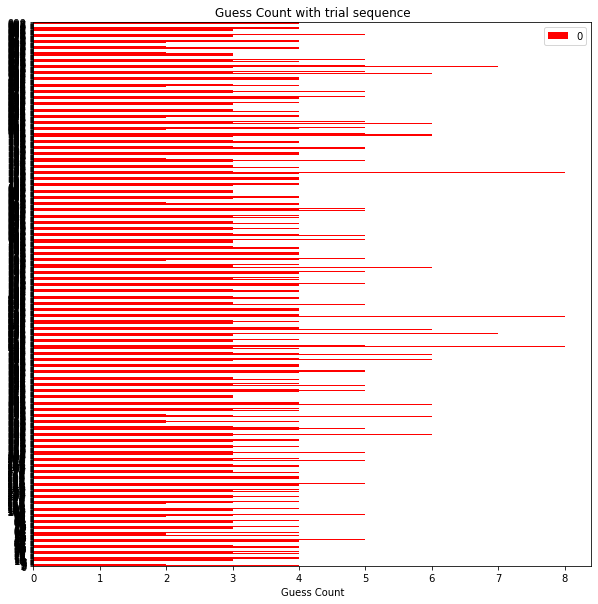

In [15]:
plt.close("all")
df = pd.DataFrame(guessCountToWin)
# fig = plt.figure(figsize=(10, 5))
# creating the bar plot
# plt.barh(df, color='maroon')
df.plot.barh(color='red', figsize=(10,10))
plt.xlabel("Guess Count")
plt.ylabel("")
plt.title("Guess Count with trial sequence")
plt.show()

In [16]:
print("Number of times we are not able to guess in 6 guess out of 200 trials, which is the limit in NY wordle game:")
print(len(list(filter(lambda x: x> 6, guessCountToWin))))

Number of times we are not able to guess in 6 guess out of 200 trials, which is the limit in NY wordle game:
11


Counter({4: 397, 3: 384, 5: 108, 2: 63, 6: 37, 7: 8, 8: 3})


<AxesSubplot:ylabel='Guess Count'>

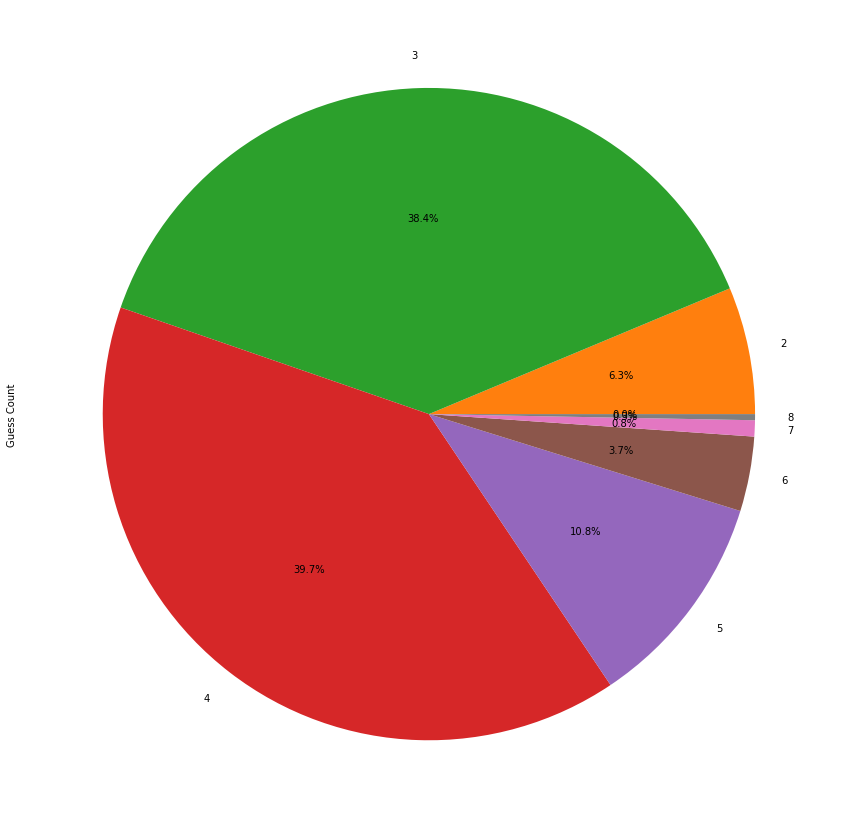

In [17]:
tryCountMap = Counter(guessCountToWin)
print(tryCountMap)
series = pd.Series(tryCountMap, index=[1,2,3,4,5,6,7,8], name="Guess Count")
series.plot.pie(autopct='%1.1f%%',figsize=(15, 15))

In [18]:
!jupyter nbconvert 2-entropy*.ipynb --to python

[NbConvertApp] Converting notebook 2-entropy-based-selection-ayushgupta.ipynb to python
[NbConvertApp] Writing 8801 bytes to 2-entropy-based-selection-ayushgupta.py
